In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import tflearn
import ipdb as pdb
import time

for k in range(5):
    
    tf.reset_default_graph()
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 2000
    MAX_EPISODE_LEN = 200

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.2
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
    IS_TRAIN = False
#     rate = 3.0
    res_path = 't_M_02_nB/'
    model_path = 'model_M_02_nB/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    init_seqCnt = 40
    
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000}]
    
    if not os.path.exists(res_path):
        os.mkdir(res_path) 
    
    print(user_config)
    # 0. initialize the session object
    sess = tf.Session() 

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
    # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        info['model_path'] = model_path + '_' + info['id']
        info['meta_path'] = info['model_path']+'.meta'
        info['init_path'] = init_path
        info['init_seqCnt'] = init_seqCnt
        user_list.append(MecTermRL(sess, info, train_config))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    sess.run(tf.global_variables_initializer())
    
    tflearn.config.is_training(is_training=IS_TRAIN, session=sess)

    env.init_target_network()

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset()

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):

            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    
    tflearn.config.is_training(is_training=False, session=sess)
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    saver.save(sess, model_path)

    sess.close()

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
---------0------------
[{'id': '1', 'model': 'AR', 'num_r': 4, 'rate': 1.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.2, 'penalty': 1000}, {'id': '2', 'model': 'AR', 'num_r': 4, 'rate': 2.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.2, 'penalty': 1000}, {'id': '3', 'model': 'AR', 'num_r': 4, 'rate': 3.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.2, 'penalty': 1000}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -4.32204408 -12.80768149 -72.7145874 ],p:[0.89424152 1.13434768 1.08429822],op:[0.89032183 0.29434568 0.        ],tr:[1.16248922 0.98532922 0.69709193],pr:[1.95817054 1.46559144 1.19007906],rev:[0.875 1.945 3.035],dbuf:[ 0.94114672 12.43786847 88.18248871],ch:[3.86235155 3.14552382 3.19912907],ibuf:[2.0, 25.0, 33.5],rbuf:[  1.07107998  76.81208428 263.065

21:r:[-116.21177484   -9.30458555  -12.33054713],p:[1.81451970e-03 2.27745527e+00 2.63062388e+00],op:[0.         1.35466044 0.93110431],tr:[0.00566729 1.95189006 1.95224302],pr:[0.        2.3622954 2.4851755],rev:[0.955 1.885 3.01 ],dbuf:[145.26018225   2.55044266   6.50886346],ch:[4.32071505 3.44093233 3.8652707 ],ibuf:[48.0, 25.0, 43.0],rbuf:[237.86654201   4.           4.        ]
22:r:[-98.00459508  -9.18638298 -10.78964836],p:[0.01428418 2.21144148 2.3821585 ],op:[0.         1.39904597 1.21028024],tr:[0.         2.10450915 2.20928912],pr:[0.20241192 2.38664768 2.51977612],rev:[1.05  1.995 3.07 ],dbuf:[122.4700334    2.45676009   4.5059636 ],ch:[4.31689035 4.22378965 5.40735625],ibuf:[22.0, 21.0, 20.5],rbuf:[191.51761697   0.           4.        ]
23:r:[-103.5647642    -8.8164507   -10.51707848],p:[0.01374018 2.07356937 2.55248455],op:[0.         1.49533691 1.0729888 ],tr:[0.         1.90760632 1.9768306 ],pr:[0.19445054 2.42598103 2.5198421 ],rev:[1.11  1.915 3.175],dbuf:[129.4216

44:r:[ -3.90296462  -7.86654579 -13.67743966],p:[0.22220031 2.16955555 2.81539271],op:[7.86545727e-02 6.54838124e-05 7.56286589e-01],tr:[0.29099302 2.15548925 1.76675946],pr:[1.06949408 0.43217491 2.50592713],rev:[1.055 2.17  3.21 ],dbuf:[4.12656858 4.40912965 8.16760131],ch:[4.61566409 4.81942149 3.89051846],ibuf:[11.5, 15.5, 42.0],rbuf:[15.79222009  4.01868193  2.        ]
45:r:[ -9.18670592  -7.21441985 -10.08520351],p:[0.19228972 2.09036665 2.42493852],op:[0.01539533 0.01785002 1.27489348],tr:[0.31713598 2.17347593 2.0522119 ],pr:[0.85569832 0.60705355 2.51864715],rev:[1.055 1.935 2.915],dbuf:[10.96416976  3.74748313  3.35692437],ch:[4.16407369 3.83200615 3.81124481],ibuf:[5.0, 27.5, 13.5],rbuf:[0.         5.         6.94087029]
46:r:[ -3.49676424  -5.77031048 -10.84286063],p:[0.30113602 1.85055105 2.75637966],op:[0.1142388  0.04653701 1.23261037],tr:[0.5194024  2.11845028 2.12071627],pr:[1.18315445 0.84098961 2.5198421 ],rev:[1.13  1.82  2.865],dbuf:[3.33251824 2.47016795 3.581100

67:r:[ -3.35848435  -6.47225929 -10.77330173],p:[0.54817611 1.8422177  2.69444962],op:[0.         0.         1.11337356],tr:[0.42915855 1.60015805 1.99262752],pr:[0.75245484 0.4746807  2.43732584],rev:[0.995 1.815 2.735],dbuf:[2.82766517 3.48477987 3.94706922],ch:[3.36868866 3.54719998 3.47375942],ibuf:[34.5, 3.5, 18.0],rbuf:[0.24269863 6.14977324 0.20715422]
68:r:[ -3.60872631  -7.79262831 -14.23604181],p:[0.69820449 1.76005517 2.81016491],op:[0.01922024 0.         1.03212194],tr:[0.95176852 1.53269492 2.2561344 ],pr:[0.64866494 0.71274849 2.45151417],rev:[0.935 2.095 2.965],dbuf:[2.71734605 5.34064746 8.18933514],ch:[5.42760255 4.35838737 4.25675501],ibuf:[45.5, 35.0, 49.0],rbuf:[2.         4.91131814 1.6340871 ]
69:r:[ -3.6952938   -6.3244251  -11.98359422],p:[0.60108627 1.3954805  2.73977367],op:[0.00182962 0.         1.1753911 ],tr:[0.56740057 1.38652875 2.21372341],pr:[0.70274994 0.4839225  2.48351818],rev:[0.945 1.88  2.96 ],dbuf:[3.11182753 4.41683012 5.19158085],ch:[4.19743639

90:r:[ -3.054957    -6.38888679 -10.85449896],p:[0.61498658 1.32582569 2.72176463],op:[0.13394594 0.58474654 1.16434449],tr:[0.56434276 0.8016083  2.16640032],pr:[1.32270853 2.07590494 2.51232845],rev:[0.99 1.95 3.09],dbuf:[1.94636494 3.2096779  3.8528509 ],ch:[3.42173955 4.03692408 3.90962246],ibuf:[31.5, 39.5, 19.5],rbuf:[0. 1. 1.]
91:r:[ -3.62066628  -5.93626618 -11.94801016],p:[0.67768162 1.41139437 2.68302736],op:[0.18255032 0.45880443 1.27105806],tr:[0.8650828  0.51385442 2.24816868],pr:[1.34568689 2.08613682 2.5198421 ],rev:[1.035 2.005 2.845],dbuf:[2.37525301 2.74483573 5.04979916],ch:[4.57566038 3.73335196 4.42694931],ibuf:[43.0, 27.0, 45.5],rbuf:[2.         1.76083627 2.        ]
92:r:[ -3.95094322  -4.7206793  -10.72574664],p:[0.71550901 1.209258   2.66490686],op:[2.89819167e-04 2.37248292e-01 1.27043960e+00],tr:[0.82866954 0.37929615 2.20778906],pr:[0.47409557 1.85038356 2.5198421 ],rev:[0.995 2.005 3.03 ],dbuf:[3.14918196 2.28458339 3.56881715],ch:[3.73688137 4.3913909  4.

113:r:[ -1.65159724  -5.71806335 -11.42089049],p:[0.27833394 1.45981837 2.64078879],op:[0.0571942  0.04545893 1.25030834],tr:[0.48495983 0.39072241 2.29233715],pr:[0.99355992 1.90543702 2.47265987],rev:[0.895 2.025 2.86 ],dbuf:[1.22567619 3.38438593 4.5483703 ],ch:[4.22429941 4.92549336 4.37515094],ibuf:[9.0, 38.5, 44.0],rbuf:[0.39567316 1.24297768 1.        ]
114:r:[ -3.41089803  -5.79071783 -13.60850679],p:[0.6314725  1.43822513 2.89500392],op:[0.01103669 0.09578528 0.96701698],tr:[0.64045215 0.53880228 1.98534183],pr:[0.80336859 1.71832747 2.46023562],rev:[1.11  2.025 2.89 ],dbuf:[2.65734957 3.40337128 7.35558124],ch:[4.33057901 4.37088018 3.78990737],ibuf:[22.5, 28.0, 43.5],rbuf:[ 3.56760006  3.14884449 15.39759865]
115:r:[ -3.81623144  -5.51713969 -11.69010995],p:[0.63937875 1.44674028 2.70283353],op:[0.         0.07117572 1.11751853],tr:[0.54189459 0.52614535 2.27243415],pr:[0.60135391 1.69617351 2.44143131],rev:[1.    2.095 2.905],dbuf:[3.17184243 3.10163461 5.06175728],ch:[3.68

136:r:[ -2.55126033  -5.47854092 -11.59537105],p:[0.46698348 1.4465644  2.98038421],op:[0.14073845 0.29561468 0.99468893],tr:[0.06519298 0.46281004 1.92628918],pr:[1.42783279 2.13134592 2.5092564 ],rev:[0.99  2.08  2.935],dbuf:[1.6697706  2.49272846 4.55653097],ch:[4.18855351 4.11618881 4.03662625],ibuf:[28.0, 16.0, 24.5],rbuf:[4.41049417 1.         2.        ]
137:r:[ -3.91729114  -4.80520064 -13.74457249],p:[0.60999161 1.12158982 2.87851398],op:[0.02667756 0.44928667 1.00334308],tr:[0.07586506 0.59747589 2.05913538],pr:[1.18369046 2.05281635 2.46882154],rev:[0.94  1.93  2.945],dbuf:[3.30494102 2.07930957 7.47607297],ch:[3.61486207 3.9081756  4.11908866],ibuf:[43.5, 7.5, 37.5],rbuf:[2.03206239 2.09483876 2.        ]
138:r:[ -3.44231136  -5.67478372 -10.49925256],p:[0.61729591 1.46305327 2.62203151],op:[0.01437734 0.16920832 1.25341428],tr:[0.05150091 0.43024717 2.37510068],pr:[1.15825794 2.11026046 2.4662368 ],rev:[1.085 2.17  2.92 ],dbuf:[2.72370608 3.01282566 3.43545122],ch:[4.60391

159:r:[ -2.17889769  -5.78514123 -10.70231059],p:[0.35734692 1.69454442 2.7808999 ],op:[0.02372828 0.02562305 1.2191001 ],tr:[0.01048339 0.30040152 1.79708894],pr:[1.23421786 1.87257626 2.5198421 ],rev:[1.02  2.105 2.91 ],dbuf:[1.77093413 2.93100787 3.37788824],ch:[5.02761354 2.59451353 3.26508106],ibuf:[13.5, 8.0, 5.0],rbuf:[1.14918921 2.         7.        ]
160:r:[ -2.68899766  -5.66951024 -10.60343598],p:[0.42915433 1.5333872  2.57546198],op:[0.00164372 0.01385585 1.42453802],tr:[0.0091388  0.38700135 2.2722237 ],pr:[1.12617867 1.82258282 2.5198421 ],rev:[1.07  2.115 2.98 ],dbuf:[2.28425193 3.21878018 3.25429497],ch:[4.7394439  5.72094126 3.79082342],ibuf:[9.0, 14.0, 5.5],rbuf:[0.         2.         4.05711671]
161:r:[ -2.22107646  -6.56866328 -10.89429834],p:[0.36131622 1.61310928 2.70164383],op:[0.00546986 0.05854217 1.29835617],tr:[0.00764939 0.60725143 2.22834322],pr:[1.05040413 1.79900679 2.5198421 ],rev:[0.95 2.1  2.92],dbuf:[1.85938039 4.03170046 3.61787292],ch:[3.22253338 4.

182:r:[ -3.98422848  -5.45160531 -12.60872498],p:[0.50169269 1.40746491 2.97532309],op:[0.         0.09482302 0.99528246],tr:[0.         0.58977136 2.13092976],pr:[1.11301433 1.71172956 2.5198421 ],rev:[1.08  1.935 3.165],dbuf:[3.72605387 3.05878681 5.83439236],ch:[6.01316798 3.54748168 4.33914613],ibuf:[8.5, 28.5, 43.5],rbuf:[1.89713394 4.0006951  1.        ]
183:r:[ -3.19765431  -5.87091756 -10.46843604],p:[0.41759311 1.31421755 2.65344086],op:[0.         0.04514983 1.26400669],tr:[0.         0.90761612 2.1766668 ],pr:[1.02461469 1.41254908 2.49407046],rev:[1.02  1.945 2.99 ],dbuf:[2.95308512 3.94022851 3.29192618],ch:[4.23173029 5.64901577 4.19660115],ibuf:[5.5, 47.5, 10.5],rbuf:[4.57706164 1.50283248 5.29359454]
184:r:[ -2.93093589  -5.33828255 -10.89556596],p:[0.42120193 1.34047246 2.71827403],op:[0.         0.00249697 0.94108976],tr:[0.         0.71853929 2.24281906],pr:[0.99192974 1.35274663 2.36638444],rev:[0.97 1.98 3.04],dbuf:[2.61066504 3.3154296  4.47104798],ch:[3.86987879 

205:r:[ -4.2050284   -5.0033169  -11.62066403],p:[0.54607256 1.36167302 2.87915612],op:[1.05389931 0.18145669 0.96962588],tr:[0.02491879 0.28871488 2.02502509],pr:[2.31329192 2.07307483 2.453183  ],rev:[1.04  2.03  3.085],dbuf:[1.2563558  2.39632187 4.90387502],ch:[3.74656966 3.58542968 3.32166976],ibuf:[15.0, 14.5, 26.5],rbuf:[1.         2.0547284  6.21990591]
206:r:[ -4.43871875  -6.3735371  -11.85624423],p:[0.60984365 1.4322591  2.97858291],op:[0.70509252 0.09114432 1.01955474],tr:[0.08006909 0.36775165 1.87069419],pr:[2.1149635  1.93981945 2.51905431],rev:[0.975 1.91  3.   ],dbuf:[2.26105801 4.15841281 4.82496118],ch:[3.94662264 3.19468195 2.96041021],ibuf:[38.0, 42.5, 35.0],rbuf:[1.08859254 4.         1.        ]
207:r:[ -2.84169125  -4.62988488 -12.21737736],p:[0.41293883 1.13163673 2.86536205],op:[0.5123875  0.03694511 1.13116407],tr:[0.01470592 0.19202026 2.16014661],pr:[1.91426399 1.80387123 2.5198421 ],rev:[0.96  1.815 2.995],dbuf:[1.23879823 2.86590152 5.28040641],ch:[3.9399

228:r:[ -4.89679899  -5.13279097 -10.4831673 ],p:[0.71426646 1.40318835 2.57121972],op:[0.77264412 0.0079542  1.03046967],tr:[0.91438118 0.52405305 2.22360739],pr:[1.98415138 1.54622336 2.42241639],rev:[0.885 1.97  2.985],dbuf:[2.40372227 2.88813233 4.09973564],ch:[5.57672253 3.51699938 4.54770311],ibuf:[43.0, 20.0, 32.5],rbuf:[1.         4.64202365 2.4423848 ]
229:r:[ -4.24143655  -5.77619802 -12.64936711],p:[0.68860805 1.43317349 2.58171583],op:[0.73736471 0.03437508 1.16222112],tr:[1.08007044 0.59727877 2.19557997],pr:[1.87283204 1.76514439 2.47623233],rev:[0.91  2.165 2.865],dbuf:[1.73686379 3.55137611 6.45186651],ch:[5.30448681 4.56251434 4.11641769],ibuf:[32.0, 22.0, 49.0],rbuf:[0.         0.01708799 4.        ]
230:r:[ -2.83813446  -5.76907856 -10.20926101],p:[0.49744332 1.33702684 2.47379957],op:[0.48150914 0.02476799 1.14719294],tr:[0.75000248 0.54712146 1.88555615],pr:[1.60401659 1.74076399 2.49941793],rev:[0.93  1.965 3.03 ],dbuf:[1.10028693 3.80686113 3.70909499],ch:[4.6808

251:r:[ -4.82369907  -4.66434844 -10.76761374],p:[1.823903   1.25182428 2.88678981],op:[0.05132633 0.05082455 0.92873814],tr:[2.09136678 0.87416316 1.89741279],pr:[0.2843579  1.31226616 2.4466137 ],rev:[0.99 2.06 3.02],dbuf:[1.34155052 2.57381347 3.92069729],ch:[4.23849473 5.4601522  4.18437854],ibuf:[11.0, 12.5, 12.0],rbuf:[2.47863331 2.4815981  4.89191381]
252:r:[ -5.37632386  -4.59245309 -12.94287925],p:[1.68267749 1.24401042 2.70249463],op:[0.03391371 0.00711765 1.07983296],tr:[1.86606308 0.50079603 2.31752825],pr:[0.5689792  1.4413217  2.42474099],rev:[1.01  1.885 3.02 ],dbuf:[2.42892681 2.6127462  6.72278008],ch:[3.43279846 4.87050765 4.59102101],ibuf:[45.5, 12.0, 41.5],rbuf:[3.12786898 4.04220437 6.        ]
253:r:[ -5.04996688  -5.16425043 -13.0642783 ],p:[1.35655863 1.43072219 2.81898836],op:[4.53214348e-04 1.59507499e-02 9.47676906e-01],tr:[1.36970122 0.34545721 2.02241448],pr:[0.19651456 1.74076735 2.41806045],rev:[1.04 1.98 2.94],dbuf:[2.91992898 2.83863069 6.9136847 ],ch:[

274:r:[ -3.47080048  -5.78072489 -10.83214237],p:[0.52773419 1.47711203 2.84958713],op:[0.21800591 0.00363045 1.15041287],tr:[0.12639926 0.37756992 2.02441265],pr:[1.6586536  1.76424243 2.5198421 ],rev:[0.985 2.01  3.045],dbuf:[2.47415034 3.52404988 3.54017796],ch:[4.06226952 3.60418419 4.1982063 ],ibuf:[47.5, 29.5, 13.0],rbuf:[1.         3.53236846 5.2219803 ]
275:r:[ -2.70306104  -7.14109001 -10.66432146],p:[0.41965631 1.62385139 2.76168648],op:[0.4057667  0.00181128 1.23831352],tr:[0.06302022 0.55825342 1.94696211],pr:[1.7949575 1.706346  2.5198421],rev:[0.93 2.08 2.81],dbuf:[1.31526878 4.86220585 3.33040183],ch:[4.18283985 4.27197023 3.29240886],ibuf:[17.5, 40.5, 6.0],rbuf:[2.         3.74394994 0.11022037]
276:r:[ -4.15944369  -6.18281822 -13.72160314],p:[0.58764918 1.45584969 2.93902991],op:[0.52740269 0.00500982 1.05934457],tr:[0.56517879 0.57877032 2.30219365],pr:[1.84761005 1.56176718 2.51915734],rev:[0.97  2.    3.175],dbuf:[2.41167494 4.076374   7.15606773],ch:[4.06641914 3.

297:r:[ -2.7831136   -6.12166607 -10.85335229],p:[0.46224456 1.52919873 2.8556383 ],op:[0.11456133 0.01989169 0.8776418 ],tr:[0.05507205 0.59850404 1.89854186],pr:[1.43251197 1.63739504 2.51977655],rev:[1.04  2.005 3.34 ],dbuf:[2.03687729 3.77935654 4.23349012],ch:[3.37740994 3.53530759 3.69340823],ibuf:[27.5, 38.0, 7.5],rbuf:[0.19034183 1.71853632 2.        ]
298:r:[ -1.86011601  -4.81571549 -10.13540861],p:[0.29017132 1.3189681  2.37920029],op:[0.11995933 0.00730003 1.34753268],tr:[0.         0.41590853 2.17124064],pr:[1.30271274 1.63988906 2.51947009],rev:[0.995 2.025 2.985],dbuf:[1.29981838 2.70397405 3.35242834],ch:[4.16916206 3.57489455 5.30117213],ibuf:[3.0, 4.0, 8.0],rbuf:[2.         0.50929103 8.70064486]
299:r:[ -2.43516101  -5.31879269 -10.42108832],p:[0.42447247 1.30907322 2.51802423],op:[2.47721102e-01 3.80959843e-04 1.23449055e+00],tr:[0.         0.29633746 2.01916885],pr:[1.68566209 1.73333189 2.5198421 ],rev:[1.08  1.885 2.895],dbuf:[1.36346733 3.3748554  3.64507346],ch

320:r:[ -2.72101736  -6.09089858 -10.45940764],p:[0.37715259 1.30338401 2.47375806],op:[0.55683763 0.07111726 1.15889921],tr:[5.84488821e-04 8.87674373e-01 2.34327385e+00],pr:[1.92827025 1.50123605 2.40073132],rev:[0.87  2.015 2.88 ],dbuf:[1.06629615 4.17737005 3.99261637],ch:[4.74370709 4.53276482 4.35437316],ibuf:[9.5, 48.0, 31.5],rbuf:[1.         2.25936027 5.        ]
321:r:[ -2.44122171  -5.32366253 -10.06876557],p:[0.38435844 1.1876811  2.45170663],op:[0.37578664 0.16666312 1.10457497],tr:[0.00773335 0.85610034 2.11648539],pr:[1.77930301 1.61396635 2.40760735],rev:[1.055 1.95  2.88 ],dbuf:[1.15116443 3.26871764 3.69525296],ch:[4.15369061 4.28263927 3.93992751],ibuf:[1.0, 46.0, 21.0],rbuf:[1. 2. 3.]
322:r:[ -2.31776347  -6.59568918 -12.17232445],p:[0.38004127 1.46460229 2.61922277],op:[0.29949955 0.074857   0.81235847],tr:[0.09262643 0.64746781 2.50511276],pr:[1.67062332 1.78009964 2.30645473],rev:[1.005 2.09  2.995],dbuf:[1.19835228 4.39596325 6.63645246],ch:[3.46717574 4.0996136

343:r:[ -2.44818617  -5.5270437  -13.24425893],p:[0.43226316 1.35504292 2.89502956],op:[0.08155288 0.0278069  0.8279914 ],tr:[0.32901239 0.34366025 1.88790448],pr:[1.11046037 1.85089123 2.45221082],rev:[0.99 1.99 3.04],dbuf:[1.77569259 3.45168007 7.24777127],ch:[4.75699803 3.88641471 3.17800538],ibuf:[27.0, 32.0, 45.0],rbuf:[1. 2. 4.]
344:r:[ -4.047152    -5.37684837 -12.41185378],p:[0.56441342 1.2560011  2.80999959],op:[0.02080597 0.03892134 1.06644744],tr:[0.44627948 0.27608395 1.86501347],pr:[0.98099537 1.88205429 2.46659819],rev:[1.02  1.895 2.775],dbuf:[3.59589154 3.48375436 5.82369966],ch:[4.3679443  4.87964002 3.54424446],ibuf:[47.5, 29.0, 38.0],rbuf:[1.         4.         2.81881065]
345:r:[ -1.91872243  -4.71583577 -11.95869062],p:[0.37676091 1.27251258 2.86876459],op:[0.19053863 0.08235839 1.09380029],tr:[0.56273249 0.18197346 1.93478557],pr:[1.09516181 1.96467045 2.50395952],rev:[0.915 2.005 2.865],dbuf:[0.9801542  2.50761729 5.04195109],ch:[4.27563729 3.69302994 3.44892774]

366:r:[ -3.87915795  -5.50446135 -10.9522256 ],p:[0.58570944 1.25545965 2.63479451],op:[0.42677005 0.00394677 1.17751629],tr:[0.19724897 0.44937922 2.05536059],pr:[1.85698135 1.67484042 2.50923302],rev:[0.955 1.955 2.96 ],dbuf:[2.31774871 3.73206062 4.159505  ],ch:[4.66032264 3.71399775 3.97771414],ibuf:[42.0, 35.5, 22.5],rbuf:[3.         2.26523486 1.        ]
367:r:[ -3.08871069  -5.12555494 -11.24456002],p:[0.35075244 1.29387882 2.82670009],op:[0.80016412 0.02429465 0.98760476],tr:[0.30642264 0.35604669 1.87158313],pr:[1.98932948 1.81626831 2.47614321],rev:[0.9   2.02  2.915],dbuf:[0.98359695 3.11150998 4.5199379 ],ch:[4.78973987 3.90437084 3.6912901 ],ibuf:[2.5, 27.0, 32.5],rbuf:[3.         2.48483337 3.20467989]
368:r:[ -3.58695614  -4.83627207 -10.15553038],p:[0.54071802 1.21726097 2.63062158],op:[0.69599419 0.00181657 1.11041013],tr:[0.37479007 0.27943245 1.89323604],pr:[1.98849793 1.76563537 2.45818288],rev:[0.93  2.055 2.755],dbuf:[1.39191465 2.99764625 3.3418337 ],ch:[3.42464

389:r:[ -2.75743725  -6.05882941 -10.52204119],p:[0.74872145 1.35945136 2.67554034],op:[0.15270563 0.03295751 1.22295046],tr:[0.83729536 0.5190314  2.03164574],pr:[1.0268882  1.9388613  2.49997841],rev:[1.065 2.18  2.89 ],dbuf:[1.19322887 4.09251458 3.40632449],ch:[2.79753617 5.28690522 4.16746815],ibuf:[4.0, 39.0, 6.0],rbuf:[1.         0.69586072 2.        ]
390:r:[ -4.23351185  -5.85511836 -10.98952208],p:[1.13480501 1.39532827 2.71522624],op:[0.0237554  0.08058191 1.21660819],tr:[1.63730333 0.37346719 2.25112736],pr:[0.4461176  2.01856359 2.51956872],rev:[0.95  2.055 3.025],dbuf:[2.39548881 3.6291225  3.90731654],ch:[4.67080728 3.6380141  3.90763188],ibuf:[41.0, 35.5, 0.0],rbuf:[2. 2. 4.]
391:r:[ -3.07025548  -5.60556267 -11.9122955 ],p:[1.04259039 1.37289867 2.6928795 ],op:[0.01924389 0.25700543 1.1697914 ],tr:[1.34728548 0.35879485 2.10496308],pr:[0.4131616  2.10386785 2.5198421 ],rev:[0.965 1.93  2.935],dbuf:[1.18323365 2.93219308 5.23369212],ch:[3.82813603 2.53503925 4.52895483]

412:r:[ -2.48697027  -4.48607654 -11.07414596],p:[0.39805139 1.0734069  2.77064299],op:[6.38091088e-05 5.64519022e-02 9.28370796e-01],tr:[0.01962672 0.36650154 1.95608777],pr:[1.068392   1.7607282  2.38574581],rev:[1.01  1.865 2.87 ],dbuf:[2.11342483 2.78294866 4.59514799],ch:[3.89108575 4.55021763 3.4454779 ],ibuf:[17.0, 26.5, 34.0],rbuf:[1.58862811 2.         2.81499711]
413:r:[ -2.65306202  -5.07097919 -10.77419852],p:[0.42941568 1.31138199 2.72281342],op:[0.01044225 0.07689646 0.99321396],tr:[0.0515874  0.40975799 2.18644294],pr:[1.1532488  1.90498533 2.39369107],rev:[0.97 2.01 2.96],dbuf:[2.21668269 2.86802788 4.1776797 ],ch:[4.45621169 3.48583205 3.62593371],ibuf:[30.5, 23.0, 20.0],rbuf:[3.18803782 2.01073451 0.        ]
414:r:[ -3.5875491   -6.06464685 -10.70368503],p:[0.46132154 1.22511116 2.61623512],op:[0.00360322 0.09554344 1.0120618 ],tr:[0.13287814 0.4723562  2.35291518],pr:[1.04450218 1.89645286 2.3524804 ],rev:[0.91  1.945 2.995],dbuf:[3.32212447 4.27917204 4.30886401],c

435:r:[ -1.60423671  -5.43053856 -11.09420079],p:[0.25604702 1.3163897  2.81744475],op:[0.06252519 0.24581466 1.12120614],tr:[0.         0.25444953 2.02470109],pr:[1.2831849  2.12370704 2.5141825 ],rev:[0.91  1.835 3.12 ],dbuf:[1.20886534 2.88266231 4.02112375],ch:[4.23880681 3.19718222 3.39945678],ibuf:[6.5, 30.0, 14.5],rbuf:[1.44733968 2.         4.        ]
436:r:[ -2.10712519  -6.64584435 -11.88785728],p:[0.37970641 1.45778542 2.91814572],op:[0.08691564 0.17243926 1.07683862],tr:[0.         0.28357611 1.79076945],pr:[1.46007668 2.16645768 2.51810246],rev:[1.07  2.005 2.92 ],dbuf:[1.46735137 4.23174373 4.87236077],ch:[4.21684949 3.92282683 3.4680972 ],ibuf:[8.0, 42.5, 28.5],rbuf:[0.         3.29334844 7.81789923]
437:r:[ -2.62167716  -5.20949885 -11.64128558],p:[0.43891811 1.22844628 2.87369969],op:[0.06645848 0.29714948 1.09356638],tr:[0.02587628 0.31535624 2.13956615],pr:[1.41162031 2.13613639 2.50994342],rev:[1.01  1.925 3.055],dbuf:[2.01365497 2.69788417 4.63344179],ch:[4.121093

458:r:[ -3.01751224  -4.84324806 -10.8136912 ],p:[0.55139843 1.17441691 2.73060809],op:[0.0570644  0.00637517 1.2598817 ],tr:[0.74539594 0.40899971 2.09702477],pr:[0.98757391 1.72654591 2.5198421 ],rev:[0.99  2.045 3.02 ],dbuf:[2.25073323 3.10207987 3.54088952],ch:[5.3615202  4.27957665 3.67683067],ibuf:[32.0, 18.5, 6.0],rbuf:[0.        2.5966683 3.       ]
459:r:[ -2.1259667   -6.17640826 -12.18393779],p:[0.57543669 1.28715918 2.82220822],op:[0.05710158 0.00570253 1.17779178],tr:[0.96481675 0.32034802 2.17239938],pr:[0.90630939 1.81337932 2.5198421 ],rev:[0.93  1.92  2.915],dbuf:[1.0761127  4.48835606 5.22992224],ch:[5.42073613 3.38054011 4.24829719],ibuf:[11.0, 43.5, 40.0],rbuf:[0.         4.         5.77100776]
460:r:[ -2.69218351  -4.49300933 -12.94716224],p:[0.66409373 1.15032215 2.87476697],op:[0.0732825  0.02315344 1.12523303],tr:[0.73994063 0.20161708 2.06080635],pr:[1.16918695 1.83924572 2.5198421 ],rev:[1.11  1.96  3.065],dbuf:[1.52178881 2.6825727  6.18395281],ch:[4.05660682

481:r:[ -2.96025837  -4.27620408 -11.75259768],p:[0.45727261 1.05520915 2.62657304],op:[0.25464656 0.18182425 0.9326225 ],tr:[0.11393753 0.23064937 2.25235299],pr:[1.67622645 1.97658579 2.31886997],rev:[0.9   1.875 2.845],dbuf:[1.92052504 2.2526716  5.79275824],ch:[4.19801564 3.92044347 3.89409015],ibuf:[41.0, 0.5, 38.0],rbuf:[0.         1.21138023 4.        ]
482:r:[ -1.9600852   -5.64565208 -11.47093302],p:[0.32080486 1.38838926 2.90513358],op:[0.08629407 0.18845798 0.74881345],tr:[4.99651962e-04 2.81732357e-01 1.90700753e+00],pr:[1.30551801 2.12917839 2.36306132],rev:[0.915 2.025 3.17 ],dbuf:[1.43235915 3.11494701 5.20379869],ch:[3.59868149 2.89367708 3.50529529],ibuf:[8.0, 25.5, 5.0],rbuf:[0.88025292 5.36915058 5.09262115]
483:r:[ -2.96678779  -5.27576618 -11.13160735],p:[0.48055217 1.35337648 2.9928232 ],op:[0.01569133 0.08599782 0.96315179],tr:[0.09779814 0.27038293 1.90988901],pr:[1.25140299 2.04675508 2.50550442],rev:[1.035 2.03  3.025],dbuf:[2.46787598 2.99627198 4.02457172],c

504:r:[ -2.52230068  -5.43326848 -10.14570108],p:[0.43886539 1.22307194 2.53315926],op:[1.81243530e-05 7.87928152e-04 1.20349646e+00],tr:[0.32899473 0.50541827 1.98293607],pr:[0.75805094 1.64159792 2.46821329],rev:[0.93 2.01 2.83],dbuf:[2.05566706 3.73193593 3.34048707],ch:[3.70282514 3.9153678  3.92954974],ibuf:[25.5, 30.5, 4.0],rbuf:[2.64318932 3.47032131 5.90318492]
505:r:[ -2.7263851   -4.93653641 -11.76521242],p:[0.41123327 1.21598354 2.66284306],op:[0.        0.0013275 1.1354839],tr:[0.25070878 0.61059615 2.21803272],pr:[0.86690145 1.54462883 2.51598087],rev:[0.98  2.115 3.055],dbuf:[2.3798982  3.1273929  5.21069815],ch:[4.30555823 3.80468526 4.31494782],ibuf:[29.0, 9.0, 33.5],rbuf:[3.         1.39132226 6.93398138]
506:r:[ -4.28461007  -5.03473195 -10.45888649],p:[0.66339794 1.31524697 2.49259574],op:[7.45080078e-05 7.04255697e-03 1.12928851e+00],tr:[0.47857945 0.69027126 1.76110585],pr:[0.81486946 1.54173071 2.48842642],rev:[1.015 2.18  2.73 ],dbuf:[3.69708147 2.98769111 4.0188

527:r:[ -2.0595188   -4.40194461 -11.84985253],p:[0.42276101 1.02640198 2.7131001 ],op:[1.31494990e-01 8.21377616e-04 8.82546256e-01],tr:[0.57545687 0.46671101 2.15490655],pr:[1.25641759 1.48244326 2.35669531],rev:[0.925 1.91  3.005],dbuf:[1.18875849 2.93437239 5.82319978],ch:[5.10819354 4.27343459 3.92502014],ibuf:[16.0, 10.5, 32.0],rbuf:[3.         3.01787177 4.        ]
528:r:[ -2.46777278  -3.98893522 -12.33736661],p:[0.48885278 0.93558022 2.89233472],op:[0.2101824  0.02973522 0.97269074],tr:[0.53070378 0.42192418 2.05936464],pr:[1.43602447 1.54529187 2.46063556],rev:[0.985 1.84  3.04 ],dbuf:[1.33712803 2.57288042 5.75914463],ch:[4.53474415 4.16525402 4.17114239],ibuf:[21.0, 16.0, 40.0],rbuf:[0.13518607 1.3190322  1.        ]
529:r:[ -2.05344768  -5.02836549 -10.70103249],p:[0.38157084 1.28841784 2.69443169],op:[0.13542304 0.03307066 1.25643618],tr:[0.35269628 0.41900215 2.26978558],pr:[1.33539918 1.82120452 2.49893538],rev:[1.035 2.085 3.06 ],dbuf:[1.27432489 2.9817356  3.49912094

550:r:[ -2.45250542  -4.71082922 -12.73598223],p:[0.68402779 1.17231411 2.87789525],op:[0.08575312 0.03676463 0.76863998],tr:[1.08512387 0.34302181 1.90635797],pr:[0.86395325 1.83035894 2.36343112],rev:[1.015 2.045 2.865],dbuf:[1.14117951 2.86583967 6.80363972],ch:[4.77955444 4.1085587  4.25634202],ibuf:[8.5, 11.5, 48.5],rbuf:[5.         3.64923486 1.        ]
551:r:[ -4.08671765  -4.61706417 -10.84241352],p:[1.01949928 1.10901096 2.66182202],op:[0.09166999 0.01174922 1.25773647],tr:[1.09672837 0.45872525 2.08796344],pr:[0.83973235 1.75804421 2.48667844],rev:[1.025 2.11  2.935],dbuf:[2.33047388 2.96942976 3.75412067],ch:[3.38471082 4.93265535 3.7898644 ],ibuf:[39.5, 15.0, 24.5],rbuf:[1.58009083 3.20298949 8.89608197]
552:r:[ -3.26460457  -5.59073743 -11.2378782 ],p:[0.76979751 1.48629139 2.73785479],op:[0.04705992 0.03638691 1.22898504],tr:[1.00271379 0.38197206 2.42689322],pr:[0.71206905 2.01387641 2.50578268],rev:[1.01  2.305 3.18 ],dbuf:[2.03861214 3.18172605 4.13024818],ch:[4.34569

573:r:[ -1.89936972  -3.86701909 -10.43222888],p:[0.41968764 0.97997208 2.51340728],op:[0.0182762  0.09298713 1.16197233],tr:[0.39532129 0.69867696 1.82318063],pr:[0.85448251 1.43821985 2.5198421 ],rev:[1.045 1.89  2.86 ],dbuf:[1.27930256 2.15137583 3.85183707],ch:[4.0222386  3.50916832 3.8160202 ],ibuf:[2.0, 0.5, 10.0],rbuf:[ 2.32538776  0.23713091 12.63441894]
574:r:[ -2.58926523  -4.34979859 -10.5347848 ],p:[0.42283587 1.15117613 2.6393867 ],op:[0.         0.09875675 1.29742627],tr:[0.04582678 0.69112964 2.14908237],pr:[1.06558974 1.58641431 2.5198421 ],rev:[0.985 2.01  2.89 ],dbuf:[2.17949187 2.31241604 3.32644859],ch:[5.25244083 3.736482   4.15999109],ibuf:[26.0, 9.5, 2.5],rbuf:[0.71669705 1.253711   3.        ]
575:r:[ -2.1080387   -5.17551812 -10.42991967],p:[0.39766873 1.09382812 2.64358457],op:[0.02501816 0.1560673  1.31415421],tr:[0.01732298 1.11570888 1.9968584 ],pr:[1.24434102 1.39619387 2.51889599],rev:[1.045 1.885 2.83 ],dbuf:[1.57833116 3.34465909 3.14305265],ch:[3.57574

596:r:[ -2.55401311  -4.1305037  -10.55957083],p:[0.26191957 0.90120574 2.63774218],op:[0.         0.20374233 1.17002909],tr:[0.         1.02704214 2.12546526],pr:[0.95762694 1.54132829 2.51023233],rev:[0.95 1.89 3.06],dbuf:[2.53771745 2.40075944 3.68003534],ch:[5.24271111 5.13148386 3.66660281],ibuf:[3.5, 28.0, 13.5],rbuf:[1.97461287 4.         3.        ]
597:r:[ -2.94905887  -5.35160016 -12.72365306],p:[0.32316326 1.21172563 2.61111904],op:[0.         0.02623809 1.19375945],tr:[0.05527928 0.53144015 2.06877531],pr:[0.97622375 1.66429874 2.51407247],rev:[1.025 1.975 2.885],dbuf:[2.87841544 3.59459092 6.3923701 ],ch:[4.47250414 3.48989623 4.53527747],ibuf:[4.0, 35.5, 41.5],rbuf:[2.69939424 3.67121755 2.        ]
598:r:[ -3.17944427  -4.23489493 -11.68892108],p:[0.36029905 1.07111714 2.76481098],op:[0.         0.09721858 1.17017591],tr:[0.08474216 0.2976149  2.23395923],pr:[1.03190095 1.85423028 2.51887955],rev:[1.075 1.95  3.055],dbuf:[3.07355771 2.37277936 4.77368412],ch:[3.78263957 

619:r:[ -2.84533232  -4.00758467 -12.36632538],p:[0.49850506 0.95283204 2.86724526],op:[0.07968556 0.07139866 0.97567803],tr:[0.20798581 0.38120768 2.04194346],pr:[1.41181474 1.78739019 2.45283492],rev:[0.955 2.    2.92 ],dbuf:[2.11118884 2.44890411 5.8505985 ],ch:[3.93876573 3.76060789 3.63484672],ibuf:[42.0, 0.5, 37.5],rbuf:[0.         5.98925516 0.        ]
620:r:[ -2.58294793  -4.39558104 -10.98414979],p:[0.53035885 1.07206904 2.81169768],op:[0.06690161 0.10325818 1.07453172],tr:[0.41386319 0.3355958  2.10375281],pr:[1.25157782 1.88484659 2.47164781],rev:[1.035 1.95  2.99 ],dbuf:[1.73553376 2.55615827 4.01461376],ch:[3.94190811 3.16532199 3.4623472 ],ibuf:[28.5, 14.5, 28.5],rbuf:[1.         2.         3.58135217]
621:r:[ -1.77604657  -5.50069342 -10.8365661 ],p:[0.30663162 1.32889514 2.68583004],op:[9.98054644e-04 1.93377849e-01 1.23997970e+00],tr:[0.29603408 0.61155276 2.27705655],pr:[0.72986319 2.00730911 2.49272458],rev:[0.96 2.09 2.89],dbuf:[1.45098402 3.07018429 3.73118329],ch

642:r:[ -2.28688252  -4.06135916 -11.44526319],p:[0.41909344 0.93965172 2.91116422],op:[0.03776515 0.0320137  1.08398543],tr:[0.15678966 0.49768567 1.92627892],pr:[1.22410856 1.57100502 2.5198421 ],rev:[1.1   1.92  2.995],dbuf:[1.71645668 2.64753541 4.31870486],ch:[4.42834196 4.77953205 3.57081749],ibuf:[8.0, 13.5, 33.5],rbuf:[1.06206677 3.59125048 3.        ]
643:r:[ -2.49526667  -4.26509307 -11.64112289],p:[0.45708615 1.00813144 2.95042716],op:[0.05089865 0.03423783 1.04957284],tr:[0.09083916 0.29059671 2.11322955],pr:[1.37581375 1.7315199  2.5198421 ],rev:[1.035 1.905 3.24 ],dbuf:[1.84912135 2.72544319 4.55140361],ch:[5.55518342 3.51335684 4.68234085],ibuf:[28.5, 5.0, 17.0],rbuf:[1.09368196 1.0420553  4.        ]
644:r:[ -2.15234961  -6.31943904 -12.1228995 ],p:[0.38276636 1.23446239 2.88787243],op:[0.01388606 0.00336496 1.11212757],tr:[0.02694108 0.4387493  1.99730506],pr:[1.24306994 1.77427572 2.5198421 ],rev:[1.07 2.02 2.94],dbuf:[1.69880597 4.80473043 5.15362438],ch:[4.54862659 

665:r:[ -1.78539638  -4.73621951 -10.72701055],p:[0.32000743 1.03931026 2.75813822],op:[0.06178109 0.10151091 1.23608281],tr:[0.01769951 0.80712041 2.15099495],pr:[1.30118352 1.57072363 2.5198421 ],rev:[0.935 1.86  2.985],dbuf:[1.27727417 3.06822147 3.42321063],ch:[3.72588803 5.11817558 3.76789938],ibuf:[6.5, 30.5, 7.0],rbuf:[2.02704505 3.16963158 2.        ]
666:r:[ -3.15127344  -4.5511907  -11.08205305],p:[0.54118088 1.11793999 2.67709089],op:[0.03891436 0.06003955 1.31618329],tr:[0.21372603 0.77828588 2.30818473],pr:[1.25292865 1.59107368 2.51736057],rev:[1.03  2.005 2.995],dbuf:[2.4888537  2.74403952 3.86938085],ch:[3.25098071 3.56458608 4.06625645],ibuf:[40.0, 21.5, 17.5],rbuf:[0.         2.22822458 1.        ]
667:r:[ -3.2271321   -4.15988501 -11.12447566],p:[0.52964192 1.07165131 2.51910704],op:[0.02388077 0.12349742 1.47455927],tr:[0.43747491 1.13678097 2.79186466],pr:[1.09796286 1.41301321 2.51790831],rev:[1.045 1.975 2.97 ],dbuf:[2.6501084  2.21198444 3.92142881],ch:[4.986778

688:r:[ -4.06702781  -3.97863551 -10.54006202],p:[0.69173261 0.93253349 2.53228525],op:[0.00330657 0.04632828 1.46771475],tr:[0.441522   0.71431597 2.31617042],pr:[0.99087622 1.43177738 2.5198421 ],rev:[1.135 2.005 2.855],dbuf:[3.34618683 2.52613996 3.17507753],ch:[2.87630309 3.991839   4.42006556],ibuf:[47.0, 13.0, 11.0],rbuf:[2.18325032 4.0725503  1.        ]
689:r:[ -2.25454551  -4.70102782 -12.11587832],p:[0.43506803 1.08388145 2.72448304],op:[0.09283667 0.02815545 1.26931622],tr:[0.24679383 0.90593162 2.28989768],pr:[1.36877377 1.36391284 2.5198421 ],rev:[1.07  2.005 2.7  ],dbuf:[1.49842013 3.09619253 5.16034977],ch:[3.98770705 4.43592071 4.12201709],ibuf:[13.0, 30.0, 36.5],rbuf:[0. 2. 2.]
690:r:[ -2.16311199  -5.47472384 -10.76107046],p:[0.36250029 1.22595344 2.66108132],op:[0.2252521  0.07303029 1.33884984],tr:[0.05792991 0.624472   2.35466058],pr:[1.61660804 1.80149921 2.51981313],rev:[0.99  1.975 2.94 ],dbuf:[1.23450903 3.59594546 3.45151018],ch:[3.97943074 3.86719874 4.534427

711:r:[ -3.49014043  -5.43288938 -10.15035474],p:[0.64017265 1.1361812  2.57203439],op:[0.00627714 0.0504485  1.07961834],tr:[0.64162342 0.52164328 2.22793255],pr:[0.77289475 1.82798969 2.36850126],rev:[1.045 2.03  2.83 ],dbuf:[2.74655106 3.82453749 3.55881159],ch:[4.17204246 3.75789762 4.32607692],ibuf:[47.5, 43.0, 24.0],rbuf:[1.28090505 3.         3.        ]
712:r:[ -2.3829457   -4.17538519 -10.20113581],p:[0.44955002 0.92742364 2.57220425],op:[6.33951254e-04 3.50442327e-02 1.18915301e+00],tr:[0.54957062 0.31904328 2.15161544],pr:[0.60215756 1.73716368 2.46432807],rev:[0.905 1.925 2.945],dbuf:[1.85322221 2.8130618  3.34802662],ch:[4.42159373 3.97359614 4.10302051],ibuf:[28.5, 17.0, 10.5],rbuf:[0.57907554 4.         5.        ]
713:r:[ -3.15113692  -4.8895094  -12.56559565],p:[0.51074766 1.13691822 2.93625851],op:[0.00465395 0.11454613 0.95469871],tr:[0.26443898 0.321898   1.8157643 ],pr:[1.09996753 1.9406829  2.50088104],rev:[1.09  1.925 3.015],dbuf:[2.65041712 2.98322588 5.97960153

734:r:[ -3.39329247  -4.83209099 -10.87736479],p:[0.54915494 1.08275265 2.80738688],op:[0.01131617 0.00450917 1.11929427],tr:[0.12181812 0.40050003 2.23855609],pr:[1.38172486 1.59047418 2.49021585],rev:[1.185 1.84  3.05 ],dbuf:[2.84043781 3.3219592  3.7800031 ],ch:[3.70678391 3.25361628 4.90687705],ibuf:[45.0, 30.0, 24.5],rbuf:[3.         1.47939546 5.        ]
735:r:[ -1.79133505  -5.12734688 -11.04266493],p:[0.29804398 1.10019459 2.67813659],op:[0.1474512  0.00669529 1.10474264],tr:[0.         0.62073686 2.07302427],pr:[1.47634841 1.59813021 2.46505373],rev:[0.92 2.08 2.92],dbuf:[1.12543085 3.6419589  4.34613307],ch:[3.72548914 5.50667679 3.89351519],ibuf:[6.5, 28.0, 36.0],rbuf:[1.         2.95137796 6.        ]
736:r:[ -3.51968226  -4.20741275 -12.68781395],p:[0.56171841 0.9862549  2.7036262 ],op:[0.16510374 0.06559547 1.1894236 ],tr:[0.07932631 0.57561815 2.17999689],pr:[1.63905258 1.73014846 2.48217928],rev:[0.985 2.12  2.91 ],dbuf:[2.58254746 2.62964002 6.12714292],ch:[3.22678455

757:r:[ -2.87267245  -6.13822135 -10.55299026],p:[0.52038991 1.20126703 2.65444854],op:[0.00297585 0.01610641 0.92946789],tr:[0.53473732 0.79352363 1.93720784],pr:[0.78162093 1.56550866 2.41435539],rev:[1.02 2.08 2.98],dbuf:[2.28242616 4.62934307 4.23144675],ch:[4.49052498 4.65022778 3.58377724],ibuf:[36.0, 47.5, 9.0],rbuf:[1.04635571 4.38600416 3.        ]
758:r:[ -4.08642458  -5.10303548 -11.78327782],p:[0.67820068 1.26385884 2.69780894],op:[0.08169285 0.03035327 0.9559765 ],tr:[0.44807957 0.35740604 1.97281109],pr:[1.31819853 1.85753422 2.43997528],rev:[1.02  2.075 2.97 ],dbuf:[3.2082969  3.14326407 5.59463368],ch:[3.19879452 3.05129463 3.72214518],ibuf:[48.5, 13.0, 34.0],rbuf:[2.28408461 2.67792577 3.        ]
759:r:[ -2.97639511  -4.6731996  -10.99041407],p:[0.47165932 0.99900906 2.77103693],op:[0.01118509 0.00373333 1.04532686],tr:[0.24175891 0.53088514 1.90772022],pr:[1.03810383 1.67825973 2.44743284],rev:[0.92  2.155 2.93 ],dbuf:[2.51338287 3.33464354 4.1971081 ],ch:[3.54021613

780:r:[ -3.10207473  -5.17556766 -10.09155538],p:[0.50313084 1.14670814 2.64857899],op:[0.18171511 0.02686276 0.92815641],tr:[0.08090647 0.39441845 2.13588141],pr:[1.60639985 1.79431879 2.32766157],rev:[0.975 2.02  3.03 ],dbuf:[2.16547853 3.53553231 3.67260571],ch:[4.54951586 3.66702484 3.98039442],ibuf:[33.5, 24.5, 15.5],rbuf:[1.50582415 1.37891175 2.        ]
781:r:[ -2.40335946  -3.85142654 -11.72502251],p:[0.46935059 0.84404571 2.92402712],op:[0.02551094 0.04251409 0.81979706],tr:[0.23095605 0.52283611 1.90677905],pr:[1.18204031 1.54941837 2.41567624],rev:[1.025 1.91  3.155],dbuf:[1.76704552 2.59788366 5.29671768],ch:[3.43402638 5.6342751  3.69233154],ibuf:[29.0, 18.5, 28.5],rbuf:[0.         2.36091021 4.38102067]
782:r:[ -2.42186997  -3.75070503 -12.06239991],p:[0.59080843 0.86546353 3.02711304],op:[0.0524514  0.07285406 0.90787325],tr:[0.65600417 0.76796139 1.96334098],pr:[0.89980293 1.3945168  2.50559133],rev:[1.105 1.9   3.16 ],dbuf:[1.4191879  2.34258731 5.24053417],ch:[4.0665

803:r:[ -1.91940907  -5.03713908 -11.83972026],p:[0.41440858 1.18331072 2.80780515],op:[0.00625276 0.17753109 1.18282677],tr:[0.44238514 0.82671273 2.22079482],pr:[0.73670207 1.80486063 2.51587351],rev:[0.975 2.015 2.995],dbuf:[1.34760798 2.89431932 4.82307053],ch:[3.49262522 4.20292133 4.16259546],ibuf:[2.5, 28.0, 32.0],rbuf:[2.61363371 0.74335356 3.        ]
804:r:[ -2.574147    -6.11126341 -12.822994  ],p:[0.46264782 1.16803906 2.91663306],op:[1.11575795e-04 1.38984615e-01 9.74887568e-01],tr:[0.29262571 0.76615802 2.0821816 ],pr:[0.85241604 1.74486789 2.47322032],rev:[1.   1.94 3.03],dbuf:[2.06078525 4.37152006 6.29994094],ch:[2.83952784 3.65975785 3.63942103],ibuf:[24.5, 47.5, 43.5],rbuf:[1.83923064 6.70710836 7.        ]
805:r:[ -2.41951918  -4.74846086 -10.9485517 ],p:[0.49897029 1.06159751 2.80248688],op:[0.00290674 0.04752091 1.15277969],tr:[0.7350541  0.49182124 1.95388573],pr:[0.52867343 1.74384686 2.50068195],rev:[0.925 1.935 2.93 ],dbuf:[1.76970639 3.16278002 3.79752318],ch

826:r:[ -3.15466704  -4.9677     -11.03732378],p:[0.63845874 1.15940768 2.65963072],op:[0.06986481 0.04169775 1.18339982],tr:[0.55551259 0.51382581 1.84774553],pr:[1.10054648 1.68150821 2.5198421 ],rev:[0.94  1.905 2.885],dbuf:[2.17252494 3.20686142 4.18907838],ch:[4.31176403 3.31334163 3.08047956],ibuf:[39.5, 27.0, 24.5],rbuf:[1.         1.36100423 3.        ]
827:r:[ -2.04812547  -4.36862987 -12.01525969],p:[0.43055302 0.9956467  2.84446349],op:[0.11360681 0.01518279 1.08716256],tr:[0.46297378 0.59531379 1.91740203],pr:[1.17157328 1.61320363 2.5198421 ],rev:[1.095 2.055 2.91 ],dbuf:[1.19975727 2.93371361 5.19000949],ch:[3.94883699 4.48122652 3.52621472],ibuf:[1.5, 19.0, 43.5],rbuf:[2.        2.4333306 2.7043331]
828:r:[ -3.54870701  -4.91932609 -12.22773624],p:[0.68364437 1.21616185 2.86461783],op:[0.15332726 0.09292858 1.09042596],tr:[0.51414589 0.3714624  1.95428717],pr:[1.41705082 1.92566376 2.5198421 ],rev:[0.995 2.035 2.905],dbuf:[2.34345469 2.87643152 5.39706083],ch:[3.1178132 

849:r:[ -2.55348403  -4.67979983 -11.56013842],p:[0.48079434 1.08085944 2.73056001],op:[0.23402618 0.02460774 0.95182105],tr:[0.21264679 0.34901933 2.27871465],pr:[1.62981054 1.8093876  2.39274628],rev:[0.935 2.105 3.08 ],dbuf:[1.40480373 3.08608185 5.24422038],ch:[4.23485236 3.4070015  4.30564632],ibuf:[23.0, 4.0, 35.5],rbuf:[1.         3.         5.99112034]
850:r:[ -3.86227211  -4.6392863  -15.65014805],p:[0.61787831 0.9375359  3.20254724],op:[0.44625335 0.09288891 0.51129612],tr:[0.30200883 0.53897978 1.71481337],pr:[1.8513003  1.74316148 2.39323881],rev:[1.035 1.865 3.305],dbuf:[ 2.16751098  3.22304584 10.27807667],ch:[2.9746633  5.33056719 2.62726266],ibuf:[37.0, 38.5, 27.5],rbuf:[1.         1.         5.10690009]
851:r:[ -2.63826962  -3.99485629 -11.36853848],p:[0.50132789 0.91102072 2.83504658],op:[0.32828637 0.02745964 0.85764519],tr:[0.37409052 0.36433438 1.75648227],pr:[1.68394473 1.67306549 2.39308923],rev:[1.09  1.945 2.985],dbuf:[1.22380139 2.64736945 4.97894369],ch:[4.03

872:r:[ -2.66337184  -4.72516638 -10.73004423],p:[0.45541431 1.07062544 2.72770585],op:[0.43940684 0.01247271 0.97387096],tr:[0.26512425 0.85266528 2.05726208],pr:[1.77719147 1.40174857 2.44659932],rev:[0.99  2.085 2.995],dbuf:[1.09216191 3.19871257 4.15861327],ch:[3.39535082 4.7150316  3.9563034 ],ibuf:[9.0, 29.5, 30.0],rbuf:[0. 3. 2.]
873:r:[ -3.16747461  -5.35475358 -11.28243949],p:[0.51775668 1.10713733 2.63003368],op:[5.33016982e-01 8.81150289e-04 1.08120653e+00],tr:[0.42869902 1.07441121 2.28284466],pr:[1.89053686 1.13288086 2.47757204],rev:[1.065 2.08  3.14 ],dbuf:[1.33240911 3.92339577 4.82494882],ch:[4.95908494 4.09948465 4.87562748],ibuf:[17.5, 29.0, 25.5],rbuf:[1.         6.1316743  6.17382129]
874:r:[ -2.72435681  -5.33505368 -11.65221061],p:[0.45954244 1.15443125 2.91061624],op:[0.333498   0.         0.98684309],tr:[0.04346539 0.94999351 2.07977333],pr:[1.7688738  1.03956602 2.49390795],rev:[0.895 2.    3.235],dbuf:[1.4228449  3.78273897 4.82161492],ch:[3.04077317 3.673178

895:r:[ -2.92888385  -6.31427288 -11.44559389],p:[0.47670459 1.31277804 2.67741447],op:[2.77467390e-04 9.16808230e-02 1.15803399e+00],tr:[0.09554985 0.48741006 2.05138277],pr:[1.09207474 1.90206006 2.47850273],rev:[0.995 2.    2.895],dbuf:[2.46864966 4.38169395 4.71837122],ch:[4.02985386 3.44857877 4.01671846],ibuf:[39.5, 38.0, 26.0],rbuf:[1.11076964 3.         4.3225835 ]
896:r:[ -2.26004488  -6.47636922 -11.52687592],p:[0.43131915 1.27631266 2.74056991],op:[0.03694111 0.03334463 0.98201016],tr:[0.09576435 0.45708725 2.29146591],pr:[1.25824151 1.90566095 2.39714221],rev:[1.1  2.08 3.03],dbuf:[1.65440543 4.8213183  5.10214472],ch:[3.85603972 4.33517963 4.40125601],ibuf:[14.5, 45.0, 43.0],rbuf:[1.         3.64864517 4.        ]
897:r:[ -3.29507049  -4.64465963 -11.25702628],p:[0.54171927 0.98815113 2.75993207],op:[0.02524689 0.03436476 0.9073026 ],tr:[0.17948979 0.2871039  2.20661755],pr:[1.25185523 1.8293158  2.37128168],rev:[1.005 1.9   3.075],dbuf:[2.70142271 3.24953482 4.90319618],c

918:r:[ -2.47395417  -4.47071523 -10.94628387],p:[0.42653737 1.03920129 2.57043637],op:[0.02473463 0.01000503 0.98286583],tr:[0.04955004 0.50510504 1.77311013],pr:[1.24918659 1.63210938 2.50694343],rev:[1.005 2.11  3.03 ],dbuf:[1.96426272 2.96537823 4.79959932],ch:[3.57300917 3.56098248 3.90176538],ibuf:[30.0, 5.0, 32.5],rbuf:[ 3.32653954  4.23836608 15.68372938]
919:r:[ -4.22843267  -4.24475512 -10.09985272],p:[0.56944795 0.96757978 2.57039696],op:[4.08971421e-04 1.20798565e-01 1.00981032e+00],tr:[0.09242364 0.72467735 1.96734771],pr:[1.15506826 1.64768181 2.44528684],rev:[1.005 2.005 3.11 ],dbuf:[3.86089853 2.58499803 3.67429771],ch:[3.30952153 4.51094114 4.42754825],ibuf:[49.0, 11.0, 7.5],rbuf:[1.29185732 2.         3.62473575]
920:r:[ -2.42635302  -4.58528983 -10.19190032],p:[0.4358006  1.04732625 2.71521136],op:[0.01288027 0.32166959 0.95331822],tr:[0.04187456 0.87470106 1.83723982],pr:[1.21960747 1.84397207 2.41684176],rev:[1.03  1.965 2.935],dbuf:[1.91123909 2.30912268 3.5685514

941:r:[ -3.2532971   -4.74422393 -13.11035628],p:[0.52215434 1.09451639 2.8085452 ],op:[0.21379766 0.09611248 1.00872879],tr:[0.09593919 0.91333291 2.03151932],pr:[1.64454232 1.42799563 2.50986786],rev:[0.965 1.86  3.11 ],dbuf:[2.22674138 2.95370774 6.84476037],ch:[3.85177814 3.97710838 4.17508908],ibuf:[37.0, 31.5, 31.0],rbuf:[1.88209498 2.         3.        ]
942:r:[ -2.70358266  -4.39412515 -10.87117801],p:[0.49236707 1.05980501 2.68581424],op:[0.10876518 0.09092044 1.02956852],tr:[0.13623286 0.77529506 1.86992527],pr:[1.4840309  1.59046132 2.50699786],rev:[1.05  2.015 2.88 ],dbuf:[1.87664771 2.61584281 4.30051561],ch:[3.46847731 3.90505124 3.4502041 ],ibuf:[32.5, 7.0, 27.5],rbuf:[3.49839374 3.67734147 2.        ]
943:r:[ -3.16567617  -5.29800223 -10.5224173 ],p:[0.50878261 1.24746076 2.6075562 ],op:[0.10552619 0.03612739 1.283408  ],tr:[0.14480897 0.91046459 2.24351184],pr:[1.46997439 1.54604869 2.50625596],rev:[0.965 2.18  3.03 ],dbuf:[2.4213232  3.41353242 3.42561111],ch:[3.83109

964:r:[ -2.53138552  -4.14921156 -11.14063181],p:[0.5010739  0.91973682 2.82012638],op:[1.87988173e-02 3.75856748e-04 1.17987362e+00],tr:[0.40190667 0.73406187 2.08098916],pr:[0.95271993 1.22016445 2.5198421 ],rev:[1.035 1.94  3.015],dbuf:[1.86455011 2.88623276 3.92578976],ch:[4.23876322 3.90363755 4.10204288],ibuf:[27.5, 2.5, 23.5],rbuf:[1.         5.63097648 1.        ]
965:r:[ -2.15554653  -4.09079638 -12.31631097],p:[0.41974796 0.97419947 2.8502773 ],op:[0.15081546 0.02637741 1.14041574],tr:[0.35948242 0.93604248 2.08873417],pr:[1.40092276 1.25641345 2.51588395],rev:[1.02 1.94 3.03],dbuf:[1.26802461 2.61205328 5.41865612],ch:[4.00393196 4.13482831 3.39813672],ibuf:[7.0, 14.0, 39.5],rbuf:[3.         2.22580428 2.        ]
966:r:[ -3.42566591  -4.30689374 -10.6310821 ],p:[0.63816094 0.99885877 2.78552116],op:[0.20832446 0.02995177 0.99928668],tr:[0.27105431 0.81994688 2.07593184],pr:[1.68290216 1.3663074  2.4249033 ],rev:[1.105 1.965 3.095],dbuf:[2.16586887 2.81159083 3.82683302],ch:

987:r:[ -3.02934017  -7.67226145 -10.8700096 ],p:[0.55653319 1.33800034 2.49345499],op:[0.28458813 0.         1.07961784],tr:[0.75717003 0.81813263 2.46883814],pr:[1.54447728 1.49346546 2.32899896],rev:[0.905 2.075 2.84 ],dbuf:[1.68387191 6.24532595 4.65482991],ch:[4.83863252 3.63302149 5.37703332],ibuf:[37.0, 47.5, 28.0],rbuf:[0.        0.1803834 3.       ]
988:r:[ -2.55398265  -6.41605367 -10.1037474 ],p:[0.5600729  1.26640778 2.55135363],op:[0.1186794  0.02278465 0.85782591],tr:[0.6424088  0.90589648 2.22113853],pr:[1.08644059 1.5063923  2.26056927],rev:[0.965 2.12  2.955],dbuf:[1.49559755 4.797086   4.10673538],ch:[3.74415308 3.77576096 4.61561358],ibuf:[29.5, 41.5, 21.5],rbuf:[1.         1.89713827 2.        ]
989:r:[ -3.15881391  -4.3809519  -11.3812111 ],p:[0.61645422 0.99394161 2.81389885],op:[0.06164832 0.05190239 0.6250307 ],tr:[0.654524   0.75316631 2.15368833],pr:[0.98537011 1.58167414 2.26033644],rev:[1.04  2.09  3.245],dbuf:[2.25326103 2.86157988 5.62919001],ch:[3.8677999

1010:r:[ -2.74857132  -5.38756714 -12.98435599],p:[0.5429989  1.18744026 2.92011548],op:[0.39872462 0.0013978  1.07988452],tr:[0.81764536 0.48891744 2.08693027],pr:[1.59338751 1.63452816 2.5198421 ],rev:[1.03  2.025 3.025],dbuf:[1.08140535 3.76236377 6.23044499],ch:[4.1172235  2.96983222 4.00124264],ibuf:[6.5, 24.0, 44.0],rbuf:[2.         6.08169321 0.        ]
1011:r:[ -2.84461205  -5.64755398 -11.16526861],p:[0.56814325 1.08360631 2.76249738],op:[0.40908072 0.         1.23750262],tr:[0.906973   0.58606325 2.04556904],pr:[1.6090631 1.5868626 2.5198421],rev:[0.96 2.01 2.89],dbuf:[1.11270514 4.35042671 3.95658577],ch:[4.55330965 4.22378415 3.81062705],ibuf:[17.5, 35.5, 22.5],rbuf:[1.         2.91482859 3.41289566]
1012:r:[ -3.68463477  -8.19865205 -11.38208227],p:[0.69225786 1.32200411 2.79722218],op:[0.27992713 0.         1.20267826],tr:[0.59710596 0.79477931 2.20822798],pr:[1.6054978  1.44920154 2.5198421 ],rev:[0.975 2.025 2.945],dbuf:[2.175331   6.94330479 4.22785173],ch:[3.2840855 

1033:r:[ -2.89171496  -5.35100758 -10.6315581 ],p:[0.64142012 0.9978531  2.62506563],op:[0.02901068 0.         1.25969527],tr:[0.65177635 0.46583273 2.16121857],pr:[0.84185997 1.60523263 2.5198421 ],rev:[1.05  2.005 3.11 ],dbuf:[1.93856671 4.19412672 3.57754536],ch:[3.31294769 4.94392981 4.08611   ],ibuf:[33.5, 20.0, 7.5],rbuf:[1.         6.78692827 5.32312447]
1034:r:[ -3.25961117  -5.85413906 -10.28963751],p:[0.65483881 1.12647024 2.5371417 ],op:[0.05141947 0.         1.25976311],tr:[0.69918366 0.46406239 2.06240987],pr:[1.04803133 1.70990481 2.5198421 ],rev:[1.085 2.085 2.93 ],dbuf:[2.30886825 4.50149822 3.36978487],ch:[3.98047981 3.90622913 4.06660478],ibuf:[38.0, 22.0, 4.5],rbuf:[0.         4.20656133 3.        ]
1035:r:[ -1.98250713  -4.72727596 -11.86317679],p:[0.40159786 1.01907821 2.72002239],op:[0.05428285 0.00259506 1.15605772],tr:[0.50744516 0.36343846 2.22586886],pr:[0.97190202 1.67513188 2.5198421 ],rev:[0.99  2.045 3.075],dbuf:[1.33843212 3.35491177 5.13877073],ch:[4.722

1056:r:[ -2.75445319  -4.81727984 -10.13309027],p:[0.37752415 0.91988117 2.32502091],op:[0.         0.00639725 1.24610717],tr:[0.09096073 0.22218089 2.26945301],pr:[1.0829086  1.78218406 2.51857521],rev:[1.    1.85  3.015],dbuf:[2.49925611 3.70590373 3.73854264],ch:[4.6470637  4.08610463 5.11314059],ibuf:[35.5, 30.0, 23.0],rbuf:[0.72613394 4.28967941 2.        ]
1057:r:[ -2.16904119  -6.18632673 -12.45937408],p:[0.33136492 1.17952735 2.63239232],op:[3.14674104e-05 3.60363205e-02 1.02286613e+00],tr:[0.35336278 0.30255041 1.92561138],pr:[0.65503821 1.97685426 2.5198421 ],rev:[0.875 1.995 2.945],dbuf:[1.88281053 4.69399922 6.43607147],ch:[4.26065687 3.80339032 3.850921  ],ibuf:[20.0, 43.5, 48.0],rbuf:[0.1259145  4.67860472 4.        ]
1058:r:[ -3.09984499  -5.94384761 -14.14286123],p:[0.59478825 1.2172582  2.76765073],op:[0.01852852 0.05500272 0.97381963],tr:[0.61512051 0.28232674 2.13048093],pr:[0.80025532 2.02403777 2.5198421 ],rev:[0.995 2.01  3.175],dbuf:[2.34151431 4.24915722 8.32490

1079:r:[ -2.02314448  -6.19427685 -11.3924984 ],p:[0.36448168 1.11566052 3.06375739],op:[0.10429435 0.04930943 0.90578054],tr:[0.00711307 0.57066327 1.62094331],pr:[1.47506983 1.6529614  2.51969847],rev:[1.055 1.825 3.095],dbuf:[1.35699051 4.83042119 4.31677818],ch:[3.52590035 3.73857831 2.8508161 ],ibuf:[6.5, 48.5, 1.5],rbuf:[0.         1.31939425 4.95784417]
1080:r:[ -2.25686088  -5.16484642 -10.53054016],p:[0.39536958 1.24193799 2.67034863],op:[0.24067784 0.03266947 1.23944232],tr:[0.01678932 0.71733666 1.81645424],pr:[1.66623037 1.68469716 2.51981432],rev:[1.035 2.18  2.84 ],dbuf:[1.23095756 3.26953937 3.38869783],ch:[3.50313855 3.33164843 3.68521876],ibuf:[9.5, 18.5, 7.0],rbuf:[2.04127825 1.         3.        ]
1081:r:[ -3.40116751  -5.63644866 -10.89897674],p:[0.52489592 1.2268282  2.7397618 ],op:[0.19153013 0.03431864 1.18325693],tr:[0.1385191  0.62602262 1.99731881],pr:[1.65645457 1.70455481 2.5198421 ],rev:[1.015 2.03  2.84 ],dbuf:[2.46039426 3.89269373 3.8161741 ],ch:[3.95546

1102:r:[ -3.16809981  -4.24459538 -12.95624199],p:[0.61028484 0.87901075 2.68381782],op:[0.04447293 0.05023983 0.95069398],tr:[0.61169878 0.76681461 2.12238274],pr:[0.92251098 1.41390838 2.48336236],rev:[1.03  1.995 3.17 ],dbuf:[2.32323034 2.98261777 7.10902299],ch:[3.26451823 4.1297302  4.52376854],ibuf:[46.0, 8.5, 35.5],rbuf:[0. 4. 4.]
1103:r:[ -1.59556119  -5.59978249 -10.26120469],p:[0.31802917 1.24620813 2.28829603],op:[0.00703852 0.16568029 1.34217108],tr:[0.38215455 0.86594939 2.32567137],pr:[0.68229685 1.83881438 2.5198421 ],rev:[0.91 2.19 2.9 ],dbuf:[1.18178225 3.47000704 3.75033809],ch:[3.97635436 4.07876774 6.01100291],ibuf:[4.0, 36.5, 24.5],rbuf:[1.4042406 4.        2.       ]
1104:r:[ -2.32779439  -4.03908348 -12.73662712],p:[0.42791468 0.89253149 2.61648701],op:[0.0019782  0.07516998 1.11320249],tr:[0.50304351 0.55260464 2.20645586],pr:[0.65886437 1.71062581 2.5198421 ],rev:[0.985 2.015 3.025],dbuf:[1.8350108  2.62960069 6.59656015],ch:[3.13661604 4.24828312 4.93651686],i

1125:r:[ -3.05460454  -7.02978768 -11.17593355],p:[0.56048751 1.07165378 3.00250941],op:[0.2388144  0.         0.88720553],tr:[0.41158562 0.88216258 1.79652758],pr:[1.60724811 1.36979107 2.48181415],rev:[1.015 2.05  3.1  ],dbuf:[1.8200009  6.10810015 4.24562958],ch:[3.96070551 4.7986106  2.92420141],ibuf:[38.5, 43.5, 7.0],rbuf:[0.         3.10926847 3.        ]
1126:r:[ -3.61662044  -5.49216691 -10.7131973 ],p:[0.58861448 1.09587763 2.87301578],op:[0.26327673 0.         0.91954832],tr:[0.43055932 0.56985376 1.85010242],pr:[1.62640657 1.62609245 2.45142464],rev:[0.965 2.07  3.075],dbuf:[2.39104752 4.12551456 3.91008637],ch:[3.67821328 3.24804829 3.94371009],ibuf:[47.5, 27.5, 3.0],rbuf:[0.         2.31075852 0.        ]
1127:r:[ -2.62838667  -5.51101494 -11.39469869],p:[0.42764173 1.10887253 2.85046518],op:[0.36816625 0.01843135 0.88129131],tr:[0.06749138 0.65057783 1.75148258],pr:[1.79004455 1.53713188 2.42079073],rev:[0.975 1.95  2.905],dbuf:[1.29596339 4.07050896 4.91398215],ch:[3.682

1148:r:[ -2.25885877  -6.44324131 -11.52378288],p:[0.44870979 1.11728441 3.03240965],op:[0.1963372  0.         0.96649456],tr:[0.44952849 0.56808354 2.0263534 ],pr:[1.46398889 1.56552849 2.51938031],rev:[1.08  1.985 3.205],dbuf:[1.21095599 5.26084061 4.40746809],ch:[4.24462517 3.97430387 3.51855729],ibuf:[3.0, 32.5, 18.5],rbuf:[1.         2.77759411 3.65771765]
1149:r:[ -2.7477239   -9.21426693 -12.81091804],p:[0.56236732 1.27583366 2.97819888],op:[0.24519334 0.         1.02180112],tr:[0.51346611 0.71615452 1.90724245],pr:[1.53284885 1.45321249 2.5198421 ],rev:[1.095 1.95  2.975],dbuf:[1.41575324 8.3282495  6.01364756],ch:[3.70816151 3.72981397 3.59698691],ibuf:[18.0, 47.5, 37.0],rbuf:[1.         3.62659748 2.        ]
1150:r:[ -2.19904923  -5.03899944 -11.24603062],p:[0.5083328  0.87027795 2.66748952],op:[0.17399088 0.         1.33251048],tr:[0.68493993 0.49894196 2.30944209],pr:[1.2791728  1.49408299 2.5198421 ],rev:[0.94  1.965 2.89 ],dbuf:[1.04300233 4.12305442 4.05753828],ch:[3.99

1171:r:[ -2.42764032  -4.86404352 -10.88919072],p:[0.38968583 0.90085173 2.79724258],op:[0.        0.        0.9186725],tr:[0.14320959 0.58233066 2.11541249],pr:[0.94102046 1.50437617 2.41156911],rev:[0.97  1.995 3.145],dbuf:[2.06033582 3.82792507 4.32170071],ch:[2.77763246 3.91726275 4.05710781],ibuf:[25.0, 20.5, 24.5],rbuf:[2.15399078 2.15863374 5.41603019]
1172:r:[ -1.69720064  -5.97658005 -14.88397686],p:[0.25489294 0.8759842  2.90683179],op:[7.42482569e-03 1.16813533e-04 8.21203396e-01],tr:[0.00477429 0.60415981 2.15461439],pr:[0.99191332 1.46460446 2.40326832],rev:[0.95  1.89  3.165],dbuf:[1.46570638 5.28047254 9.28488311],ch:[4.36602781 4.60071976 3.8060185 ],ibuf:[2.0, 39.5, 44.0],rbuf:[2.410831   3.77521654 6.60549099]
1173:r:[ -1.55613842  -6.04941141 -11.2670301 ],p:[0.2637275  1.0742166  2.62281835],op:[0.02692077 0.00384386 0.93638399],tr:[0.00619389 0.76483051 2.20407188],pr:[1.10547322 1.55719939 2.34221944],rev:[0.91  2.18  2.865],dbuf:[1.21855237 4.86661314 5.18578179]

1194:r:[ -2.32224269  -4.64504885 -13.46322345],p:[0.46885351 0.95044217 3.13599397],op:[0.20205997 0.00311616 0.82166888],tr:[0.36203071 0.60847751 1.97185434],pr:[1.50088604 1.42623938 2.51272202],rev:[1.02  1.94  3.255],dbuf:[1.22551965 3.42241523 6.93487219],ch:[3.5528851  3.7128259  3.63491569],ibuf:[15.5, 21.5, 36.0],rbuf:[0.         4.59513757 5.        ]
1195:r:[ -2.81984245  -4.23454137 -10.80669866],p:[0.57126493 0.90617718 2.71363723],op:[0.20253471 0.04974375 1.25612506],tr:[0.71684172 0.70886324 2.19441376],pr:[1.38952469 1.42807981 2.50702735],rev:[1.07 1.9  2.85],dbuf:[1.59030396 2.90337438 3.58396761],ch:[4.20426552 4.34135919 4.18845969],ibuf:[27.0, 26.5, 17.5],rbuf:[1.         3.65273963 6.        ]
1196:r:[ -3.1881796   -3.86126172 -11.36329237],p:[0.57696357 0.76229592 2.879047  ],op:[0.26229354 0.00692579 1.00448661],tr:[0.68897301 0.63717263 2.05395117],pr:[1.49835097 1.35419574 2.46984288],rev:[0.94  1.94  3.025],dbuf:[1.88708174 2.90352288 4.49528141],ch:[4.0441

1217:r:[ -2.74814127  -4.96357582 -10.5101859 ],p:[0.62654882 1.14155456 2.63374792],op:[0.08374919 0.24503629 1.128317  ],tr:[1.11983747 1.19258645 2.29585789],pr:[0.88217691 1.65113241 2.41628698],rev:[1.02  1.875 2.965],dbuf:[1.65943156 2.73799264 3.73257008],ch:[4.89363232 4.2175753  3.87162005],ibuf:[36.0, 35.0, 23.5],rbuf:[1.         1.42023455 6.11679427]
1218:r:[ -3.05323913  -4.36510054 -10.99150317],p:[0.63006103 1.05580802 2.94100205],op:[0.29121589 0.22257005 0.8516721 ],tr:[1.10584901 0.95341005 1.68764714],pr:[1.43393143 1.6991385  2.43525572],rev:[1.02  1.955 3.02 ],dbuf:[1.51335662 2.26043051 4.2576936 ],ch:[4.55281087 3.13695868 2.35257026],ibuf:[29.5, 5.5, 11.5],rbuf:[0.         3.11735137 9.0158026 ]
1219:r:[ -3.50450414  -6.17966279 -11.85507258],p:[0.65376924 1.31630791 2.5420768 ],op:[0.28587881 0.21488508 1.13347497],tr:[0.59869368 1.16563634 2.22542344],pr:[1.57361352 1.75110958 2.45089491],rev:[1.025 2.07  2.935],dbuf:[2.03151007 3.89659601 5.62996131],ch:[3.44

1240:r:[ -1.74043826  -5.44992518 -11.74979207],p:[0.34163376 1.03003493 2.70241152],op:[0.10664995 0.00720746 1.09824654],tr:[0.54681677 0.85288797 1.93755997],pr:[1.18039699 1.43152762 2.48589587],rev:[0.935 2.07  2.76 ],dbuf:[1.05483854 4.2193005  5.18559493],ch:[5.55457972 4.51578753 3.94181279],ibuf:[7.5, 38.5, 33.0],rbuf:[2.16576015 0.90886022 3.        ]
1241:r:[ -2.1770773   -5.83834474 -11.14759418],p:[0.48302498 1.02153321 2.70427349],op:[4.87547102e-02 1.16257401e-03 1.20042755e+00],tr:[0.62227466 0.64765216 2.23331942],pr:[0.89963579 1.47505562 2.5198421 ],rev:[1.    1.925 3.035],dbuf:[1.3918974  4.74119146 4.17274013],ch:[4.70372621 3.59341467 4.40455195],ibuf:[18.0, 42.0, 22.0],rbuf:[1.         2.86398408 1.        ]
1242:r:[ -2.38431389  -5.13747131 -13.04679561],p:[0.45813134 1.04523889 3.05721042],op:[5.24633424e-02 5.72733150e-05 9.08844557e-01],tr:[0.26068193 0.64027234 2.05007814],pr:[1.19074095 1.49383064 2.5198421 ],rev:[1.07  2.025 3.185],dbuf:[1.70390564 3.80859

1263:r:[ -2.47747678  -4.26195079 -11.96376991],p:[0.41454304 0.98448071 2.83357347],op:[0.07145122 0.11068467 1.16099262],tr:[0.10520624 0.56952401 2.0356732 ],pr:[1.35201956 1.7713877  2.51773357],rev:[0.94  2.045 2.95 ],dbuf:[1.88186033 2.58952506 4.96829716],ch:[4.50929907 4.61961885 3.73121591],ibuf:[37.5, 12.0, 43.5],rbuf:[ 0.          4.         10.29798096]
1264:r:[ -3.69202715  -5.68313944 -12.26687378],p:[0.59729426 1.10580356 2.97062048],op:[0.11410282 0.02258293 0.98280742],tr:[0.13867411 0.63127046 2.00979579],pr:[1.57216381 1.69685249 2.50004524],rev:[1.105 2.015 3.135],dbuf:[2.83654124 4.28295806 5.45002246],ch:[3.17560841 4.0323969  3.59940695],ibuf:[44.0, 48.0, 24.0],rbuf:[1. 1. 3.]
1265:r:[ -2.46128493  -4.4124332  -10.93958144],p:[0.45105599 0.96572582 2.72421968],op:[0.07779995 0.07311324 1.2673453 ],tr:[0.12449183 0.40665635 2.07881985],pr:[1.36675243 1.78482849 2.51627611],rev:[1.01  1.9   3.005],dbuf:[1.75446631 2.91844386 3.69556436],ch:[4.04520618 3.64104919 3.

1286:r:[ -2.86198571  -4.64379511 -10.93484174],p:[0.48200135 1.03963077 2.50378536],op:[0.01315094 0.16398425 1.41958068],tr:[0.52883261 0.47899044 2.69377579],pr:[0.77458589 1.90301596 2.5198421 ],rev:[0.875 1.975 3.15 ],dbuf:[2.33960141 2.79570633 3.86013706],ch:[3.92951296 3.7704442  5.25539112],ibuf:[48.5, 27.5, 22.0],rbuf:[0.         2.95597322 4.69606615]
1287:r:[ -1.75252853  -5.24665616 -11.17727724],p:[0.33494302 1.17620911 2.69072375],op:[0.03315952 0.1868472  1.14489336],tr:[0.15965636 0.69350605 2.08914685],pr:[1.02821485 1.87095519 2.5198421 ],rev:[0.945 2.04  3.045],dbuf:[1.27040433 3.15067945 4.38255378],ch:[3.07376915 3.78309069 3.83120191],ibuf:[10.5, 33.0, 37.0],rbuf:[2. 1. 5.]
1288:r:[ -3.27293224  -4.88381445 -11.37071602],p:[0.53244829 1.12924842 2.92854253],op:[0.09059004 0.07224815 1.0631608 ],tr:[0.16312932 0.67886615 2.0081024 ],pr:[1.33487211 1.6858294  2.5198421 ],rev:[0.895 2.075 3.065],dbuf:[2.53356948 3.10102665 4.2341367 ],ch:[3.55341343 3.61080549 3.701

1309:r:[ -1.9279454   -4.03433982 -11.15375308],p:[0.32437344 0.9389904  2.90106797],op:[0.0632247  0.14277973 1.09893203],tr:[0.         1.03575335 2.00359159],pr:[1.31741633 1.41887224 2.5198421 ],rev:[1.03  1.94  3.085],dbuf:[1.44093639 2.33849947 3.94219135],ch:[5.36885773 4.08852977 3.52954581],ibuf:[0.5, 11.5, 11.0],rbuf:[1.         0.         5.43525889]
1310:r:[ -2.09359204  -4.37209931 -12.20155394],p:[0.37623662 1.0283512  2.82830526],op:[0.15259838 0.09533141 1.17169474],tr:[0.02209593 1.19596996 2.23791379],pr:[1.53219653 1.32342771 2.5198421 ],rev:[1.    1.985 2.965],dbuf:[1.29490256 2.65591761 5.25194242],ch:[3.70790011 3.93220193 4.23455314],ibuf:[13.0, 27.0, 47.0],rbuf:[2. 1. 0.]
1311:r:[ -1.66421593  -5.01266171 -12.41285678],p:[0.2897322  1.18013554 2.77748052],op:[0.00867979 0.03238509 1.22251948],tr:[0.00677021 0.95776758 2.20722929],pr:[0.96870549 1.47556599 2.5198421 ],rev:[0.925 2.195 2.825],dbuf:[1.33423994 3.23452558 5.51607098],ch:[3.74054362 3.70654366 4.3820

1332:r:[ -3.60700895  -4.45644055 -10.64655293],p:[0.47059609 0.94013986 2.70366767],op:[0.         0.05883401 1.07689076],tr:[0.1191266  0.57454131 2.07498025],pr:[1.14070413 1.65029538 2.44042699],rev:[1.035 1.94  2.995],dbuf:[3.33227097 3.07311601 3.85679509],ch:[4.01266302 3.85643195 3.85794133],ibuf:[46.5, 24.5, 13.5],rbuf:[1.53385467 2.10132511 3.70712553]
1333:r:[ -2.67713453  -7.24458357 -15.57478369],p:[0.35857454 1.31872324 3.0370558 ],op:[0.         0.05632268 0.884759  ],tr:[0.09638203 0.67906692 2.25627076],pr:[1.06800247 1.79719563 2.50530445],rev:[1.055 2.18  3.47 ],dbuf:[2.44998182 5.61811466 9.6639426 ],ch:[3.55974079 3.61446425 4.11160504],ibuf:[22.0, 38.5, 38.5],rbuf:[0.12310072 2.         6.51569248]
1334:r:[ -2.72390375  -4.20996094 -11.10577957],p:[0.46486655 0.93154111 2.86079705],op:[0.00115966 0.07530077 1.03673254],tr:[0.07887806 0.45903477 2.01529299],pr:[1.01898232 1.68928785 2.49829486],rev:[0.96 1.91 3.03],dbuf:[2.23981417 2.74534647 4.13840049],ch:[3.3200

1355:r:[ -1.73907666  -5.55037294 -10.54072112],p:[0.31572393 1.15940081 2.67579382],op:[0.01882496 0.00223093 1.12780899],tr:[0.03638571 0.51189421 1.89879961],pr:[1.0360382 1.6443003 2.5184447],rev:[0.9   2.085 2.97 ],dbuf:[1.33747361 4.03388681 3.6668944 ],ch:[4.09432549 2.87582956 3.81207772],ibuf:[16.5, 21.5, 8.5],rbuf:[1.         8.22731664 5.        ]
1356:r:[ -2.67706597  -4.08118892 -10.41791959],p:[0.4632133  0.92581517 2.6747129 ],op:[0.00709872 0.09459787 1.09345312],tr:[0.10089885 0.73941493 1.79698531],pr:[1.18070231 1.55293625 2.49500434],rev:[1.085 2.04  2.825],dbuf:[2.17055241 2.55045353 3.60198443],ch:[3.39974375 3.96327468 3.59834036],ibuf:[36.5, 1.0, 19.5],rbuf:[ 2.06673187  0.         11.        ]
1357:r:[ -2.32093829  -5.4123238  -10.30594496],p:[0.36726263 1.11147366 2.50234004],op:[0.01335588 0.00491326 1.09239005],tr:[0.02441302 0.79778557 2.18859993],pr:[1.11830139 1.44414583 2.41457825],rev:[1.055 2.045 2.945],dbuf:[1.94962658 3.97443745 3.895606  ],ch:[3.522

1378:r:[ -2.05393212  -5.01827729 -11.22602954],p:[0.4230578  1.05852621 2.79638617],op:[0.02463433 0.03246406 1.15624296],tr:[0.21231472 0.51321051 1.818369  ],pr:[1.10804671 1.75256487 2.49961865],rev:[1.12  2.115 2.925],dbuf:[1.44818484 3.54537094 4.15096409],ch:[5.0614445  4.31212519 4.02288469],ibuf:[7.5, 16.0, 5.0],rbuf:[0.59111861 3.         4.        ]
1379:r:[ -2.79362006  -4.39728202 -12.49693463],p:[0.43516244 0.97809539 2.90293185],op:[0.         0.09577977 0.97676616],tr:[0.14039696 0.39366824 2.0395079 ],pr:[0.97881687 1.83155901 2.46849999],rev:[0.95  2.01  3.025],dbuf:[2.40411899 2.81191463 5.92192326],ch:[3.58851559 3.43165163 4.10095534],ibuf:[36.0, 9.0, 30.0],rbuf:[2.2726301  4.23924189 1.        ]
1380:r:[ -2.02155287  -4.79310924 -10.54371251],p:[0.32773652 1.09678892 2.79410631],op:[6.91152073e-05 9.57038116e-02 1.06066245e+00],tr:[0.13842902 0.44464968 1.95001947],pr:[0.87440937 1.81863566 2.45991828],rev:[0.94  2.025 2.975],dbuf:[1.70742701 3.01015472 3.54271874

1401:r:[ -2.60371604  -4.22062694 -10.36674325],p:[0.54094877 0.78660225 2.71995135],op:[0.10521385 0.00785425 0.84277417],tr:[0.61696173 0.69687691 1.85987422],pr:[1.03952962 1.37979853 2.41621087],rev:[0.945 2.055 3.14 ],dbuf:[1.63923849 3.28964244 4.05161525],ch:[4.23119918 4.2836584  3.35826118],ibuf:[34.0, 2.5, 14.0],rbuf:[2.         1.76765687 3.        ]
1402:r:[ -2.36456015  -7.24046959 -10.86389865],p:[0.44513401 1.37511921 2.63259789],op:[1.99743079e-01 3.73615524e-04 8.23536619e-01],tr:[0.27590676 0.6974894  1.90794691],pr:[1.47845524 1.62930988 2.33351841],rev:[0.94  2.125 2.86 ],dbuf:[1.34350747 5.61185493 4.93953704],ch:[3.33222865 3.06675128 4.20723234],ibuf:[27.0, 42.5, 41.5],rbuf:[0.         2.28241739 1.        ]
1403:r:[ -3.01316371  -3.85434153 -12.36230138],p:[0.50602521 0.7767574  2.73974018],op:[0.04625339 0.05945773 0.5770323 ],tr:[0.31572774 0.43228413 1.8871567 ],pr:[1.07388267 1.6270536  2.22899023],rev:[1.005 1.87  2.995],dbuf:[2.38575813 2.72738909 7.160945

1424:r:[ -2.17267933  -5.47131432 -10.84305762],p:[0.39725264 1.17577563 2.83508463],op:[0.00872804 0.05557456 0.98426009],tr:[0.12322138 0.88596974 1.87399583],pr:[0.95655677 1.52208171 2.4410931 ],rev:[0.965 2.09  2.925],dbuf:[1.70089747 3.76076743 4.00546023],ch:[3.6095337  3.7223017  3.75716149],ibuf:[18.5, 29.5, 22.0],rbuf:[0.43073865 3.29839528 2.        ]
1425:r:[ -2.53227044  -5.74349293 -10.53403319],p:[0.38146804 0.99668991 2.65265241],op:[4.92268724e-04 6.86045539e-04 1.12320429e+00],tr:[0.13952549 0.96827277 2.03876207],pr:[1.05517249 1.21270441 2.46109688],rev:[1.09 1.98 2.89],dbuf:[2.21043729 4.68592628 3.72789974],ch:[4.69562482 3.7226125  3.63631709],ibuf:[21.0, 45.0, 21.0],rbuf:[0.64612975 5.89332548 1.        ]
1426:r:[ -2.26497328  -5.85463087 -11.23869717],p:[0.36120172 1.09030882 2.77159968],op:[6.37454719e-04 3.54973003e-02 1.16922413e+00],tr:[0.11070432 0.88240354 2.21348421],pr:[0.984836   1.45903308 2.49692177],rev:[1.03  2.035 3.13 ],dbuf:[1.92661866 4.5037733

1447:r:[ -2.03556665  -5.81705257 -10.8165552 ],p:[0.3885338  1.20478988 2.78577193],op:[0.08429653 0.09026102 1.10027136],tr:[0.05365746 1.01503203 1.95820639],pr:[1.36985295 1.52325298 2.51970855],rev:[0.99  2.035 3.15 ],dbuf:[1.36238249 4.03368846 3.80558578],ch:[4.56362865 3.81704284 3.4444377 ],ibuf:[18.0, 44.0, 1.5],rbuf:[1.         4.         5.58622739]
1448:r:[ -1.76898038  -3.9100496  -12.77404921],p:[0.3267798  0.82940665 2.871114  ],op:[0.05875269 0.05658322 0.93210021],tr:[0.02565708 0.45745726 2.26046566],pr:[1.26921121 1.65518025 2.46750387],rev:[0.96  1.955 3.18 ],dbuf:[1.24739425 2.67258733 6.45952598],ch:[4.27586996 3.73220079 4.00112792],ibuf:[10.5, 9.5, 38.0],rbuf:[1.34668885 2.04537835 5.        ]
1449:r:[ -3.38773382  -5.68618039 -10.7439139 ],p:[0.49528156 1.0494283  2.57544131],op:[0.13311579 0.01172383 1.22927511],tr:[0.12529302 0.86170484 2.3857995 ],pr:[1.51696736 1.3849217  2.43624174],rev:[0.925 2.045 2.815],dbuf:[2.6636739  4.45484515 3.91810134],ch:[4.396

1470:r:[ -3.39667311  -5.35094816 -10.20983433],p:[0.60099535 1.0431283  2.49671406],op:[0.20919968 0.16018219 1.16714613],tr:[0.5965501  0.81406134 2.38730985],pr:[1.49103679 1.70079964 2.3839572 ],rev:[1.08  1.995 2.825],dbuf:[2.22035382 3.68040897 3.60264244],ch:[3.60081521 3.70222025 4.98086286],ibuf:[41.5, 37.5, 24.5],rbuf:[1.         7.61204106 9.13219397]
1471:r:[ -4.20851634  -5.57994304 -10.67422671],p:[0.78762187 0.95435493 2.81541508],op:[0.18118699 0.13958752 1.09611303],tr:[0.77171203 0.55753321 1.68202081],pr:[1.30803049 1.73895834 2.51433459],rev:[1.035 1.78  3.045],dbuf:[2.83862326 4.24007267 3.56396309],ch:[4.03284069 3.70516685 2.690507  ],ibuf:[45.5, 43.0, 1.0],rbuf:[1. 2. 7.]
1472:r:[ -2.3304249   -3.78640971 -10.35520848],p:[0.50520422 0.75566849 2.54984257],op:[0.18570344 0.01474829 1.27930869],tr:[0.56516862 0.90227183 2.01571377],pr:[1.33439555 1.14457083 2.5198421 ],rev:[1.03  1.94  2.875],dbuf:[1.18576196 2.80697017 3.37113245],ch:[3.59509339 5.28273501 3.7364

1493:r:[ -3.48836313  -5.59698307 -11.09908941],p:[0.6610995  1.20479179 2.6264739 ],op:[0.34202773 0.10622662 1.05049125],tr:[0.71080059 0.95667402 2.5331044 ],pr:[1.63938806 1.52334969 2.37577964],rev:[1.045 1.955 3.15 ],dbuf:[1.85263585 3.71868279 4.68144888],ch:[3.91975199 3.62660755 5.69077268],ibuf:[38.5, 33.5, 25.0],rbuf:[3. 2. 3.]
1494:r:[ -2.44751089  -4.94611927 -11.95066209],p:[0.53092694 1.13285163 2.76651591],op:[0.29056085 0.14051074 0.70196212],tr:[0.6960654  1.15948959 2.1837101 ],pr:[1.45871612 1.55116082 2.27062618],rev:[0.94  2.135 3.195],dbuf:[1.00566913 2.99924317 6.26713254],ch:[3.56655473 4.24347656 4.35728418],ibuf:[9.5, 13.0, 45.5],rbuf:[2.         1.19358644 4.        ]
1495:r:[-2.13547821 -4.34390871 -9.64528017],p:[0.40894086 0.97989342 2.65220453],op:[0.21353848 0.2853294  0.71124954],tr:[0.35262658 0.88631248 1.93953187],pr:[1.46911887 1.73042408 2.234313  ],rev:[1.05  1.875 3.065],dbuf:[1.11314944 2.26682883 3.64796504],ch:[3.21551858 3.90338622 3.7356721

1516:r:[ -2.25469279  -5.38432881 -15.34806262],p:[0.42032687 1.00797813 2.95659564],op:[0.00629931 0.07332236 0.88205321],tr:[0.05373615 0.79292311 2.18735867],pr:[0.99762219 1.57101373 2.48808077],rev:[0.915 2.05  3.175],dbuf:[1.75180055 4.0271598  9.58845616],ch:[3.24955485 5.02828066 4.50489495],ibuf:[24.5, 37.5, 47.0],rbuf:[0.01822099 4.67575173 5.62720344]
1517:r:[ -2.7152788   -7.34348109 -10.84166446],p:[0.48493396 1.2645902  2.64857472],op:[0.04084126 0.01023639 1.21268037],tr:[0.09441201 0.6513339  2.03686595],pr:[1.2676472  1.74038155 2.51000135],rev:[1.025 2.185 2.995],dbuf:[2.07966047 5.9922849  3.89894285],ch:[4.17500095 4.25923361 4.15735537],ibuf:[36.0, 37.0, 19.0],rbuf:[2.         1.66608178 7.95148438]
1518:r:[ -1.8960081   -5.31080543 -10.65440909],p:[0.35968506 1.11584765 2.57230324],op:[0.09189468 0.08281204 1.41061098],tr:[0.00518391 0.49443601 2.32613612],pr:[1.36493743 1.85868894 2.51259284],rev:[0.99 2.19 2.92],dbuf:[1.24106076 3.64185758 3.36072579],ch:[4.7722

1539:r:[ -2.50220107  -4.36350468 -12.45338598],p:[0.44220746 0.81844937 3.11023565],op:[0.00108872 0.02537464 0.88708829],tr:[0.18077854 0.41636635 1.59672835],pr:[1.05913814 1.62035604 2.51871303],rev:[1.11 1.93 2.98],dbuf:[2.01951091 3.3448208  5.57342264],ch:[4.00781428 3.92126488 2.71226894],ibuf:[22.5, 10.5, 36.0],rbuf:[0.35147276 5.50562733 4.07472834]
1540:r:[ -3.12117242  -4.2356141  -11.06168681],p:[0.53483249 0.84469076 2.78463489],op:[0.09227843 0.04434765 1.20456498],tr:[0.10911769 0.60327885 2.04349973],pr:[1.43995764 1.6451841  2.5152802 ],rev:[1.025 2.055 3.015],dbuf:[2.33368822 3.07192159 3.85410884],ch:[4.05020694 5.60978244 3.60346634],ibuf:[39.0, 19.5, 16.5],rbuf:[1.         4.05134102 2.00123964]
1541:r:[ -3.05895434  -4.46760929 -12.14993834],p:[0.52331818 0.93881365 3.01853465],op:[0.11367081 0.07475217 0.96461689],tr:[0.17042607 0.65827666 1.89020561],pr:[1.51138487 1.6554325  2.51268316],rev:[0.99  2.085 3.125],dbuf:[2.23122045 3.05059706 5.22954406],ch:[3.6875

1562:r:[ -2.22420678  -6.67030971 -27.7845763 ],p:[0.41539864 1.0887911  1.67776808],op:[0.19236756 0.0216397  0.        ],tr:[0.20576284 0.9878284  1.91548975],pr:[1.52870654 1.37061658 0.87137252],rev:[1.095 2.025 2.82 ],dbuf:[ 1.26084298  5.56181015 30.53630018],ch:[4.17744288 4.42816087 4.22379371],ibuf:[7.5, 44.0, 18.5],rbuf:[ 1.          0.0762457  25.12754672]
1563:r:[ -2.36123993  -6.36858874 -44.04024165],p:[0.40936657 1.13299803 1.73234992],op:[0.27170281 0.01118264 0.        ],tr:[0.2505116  1.34513545 1.54237375],pr:[1.61385911 0.94585701 0.91556795],rev:[1.1   1.875 2.81 ],dbuf:[ 1.24887646  5.10028426 50.71942727],ch:[4.476219   4.81046713 3.23105357],ibuf:[0.0, 45.5, 22.0],rbuf:[ 0.          2.6000449  92.41165995]
1564:r:[ -2.38313507  -4.60584184 -38.81525632],p:[0.42495013 1.02378169 1.6791648 ],op:[0.29091033 0.00704991 0.        ],tr:[0.00688403 1.50764084 1.96357365],pr:[1.73335409 0.73834265 0.83314361],rev:[1.07  2.    3.065],dbuf:[ 1.18926767  3.1802233  44.3211

1584:r:[ -2.22158318  -3.5241294  -24.93035257],p:[0.36600343 0.70478134 2.32628461],op:[0.00275746 0.01998279 0.        ],tr:[0.04919188 0.77930571 1.96309223],pr:[1.00966046 1.2312276  1.09179741],rev:[0.935 1.86  3.15 ],dbuf:[ 1.85507675  2.59325142 25.3472292 ],ch:[3.80882742 4.03567642 4.04698701],ibuf:[21.0, 4.0, 8.0],rbuf:[ 0.29324929  5.3513485  27.02207233]
1585:r:[ -1.89988145  -5.26683019 -24.74782455],p:[0.32542353 1.04968693 2.44406645],op:[0.01127331 0.00376619 0.        ],tr:[0.01957582 0.94729565 1.75913003],pr:[1.11957796 1.17428429 1.23157929],rev:[1.055 2.075 2.96 ],dbuf:[ 1.53310971  3.94990494 24.82461457],ch:[4.13317571 3.5485798  4.22535202],ibuf:[3.0, 10.0, 28.0],rbuf:[ 0.0267985   7.83706108 21.85813621]
1586:r:[ -1.88370837  -6.42221816 -25.59634245],p:[0.33886005 1.11660683 2.49834859],op:[0.0068299  0.00496061 0.        ],tr:[0.01872652 1.09786909 2.19140835],pr:[1.0355751  1.22498742 1.13512731],rev:[0.965 2.09  3.35 ],dbuf:[ 1.49041059  5.2238541  25.74955

1607:r:[ -3.00251564  -5.30433492 -16.34828027],p:[0.52825772 0.87021507 1.69881026],op:[0.15574941 0.01468195 0.        ],tr:[0.20551075 0.60956481 1.38881141],pr:[1.53382077 1.43627722 1.48809045],rev:[1.   1.8  2.94],dbuf:[ 2.04312674  4.41817609 16.1883247 ],ch:[3.74533884 4.02453322 3.89667968],ibuf:[38.0, 42.5, 1.5],rbuf:[ 2.          2.         14.11962674]
1608:r:[ -1.76357278  -4.15546628 -18.55229121],p:[0.32483609 0.81398395 1.81712007],op:[0.04528756 0.00908492 0.        ],tr:[0.1096109  0.86605297 1.56740071],pr:[1.17157557 1.33176369 1.55259638],rev:[0.965 2.125 3.18 ],dbuf:[ 1.27915683  3.13666066 18.64756385],ch:[4.28991972 4.62900034 5.005435  ],ibuf:[10.5, 15.0, 5.5],rbuf:[ 2.56281565  5.1106018  17.50058323]
1609:r:[ -1.94623822  -3.65542145 -16.0031606 ],p:[0.35063687 0.69397921 1.93689599],op:[0.01071199 0.02704252 0.        ],tr:[0.0435815  0.55545263 1.46316702],pr:[1.12262665 1.3678112  1.53227679],rev:[1.045 1.765 2.81 ],dbuf:[ 1.52942562  2.76672247 15.1617107

1630:r:[ -2.38103493  -6.1057525  -22.13389939],p:[0.47347037 1.25198008 2.40865952],op:[0.01580766 0.05427738 0.        ],tr:[0.39200364 1.21946935 0.46170577],pr:[0.86184648 1.369197   2.49346953],rev:[1.005 2.11  2.98 ],dbuf:[ 1.75309859  4.36654697 21.64572544],ch:[4.04234736 3.48011283 4.39067085],ibuf:[27.5, 40.0, 25.0],rbuf:[ 0.          2.76521596 29.96494116]
1631:r:[ -1.88275503  -5.44246657 -21.46430322],p:[0.40191565 1.07314114 2.35417635],op:[0.03258315 0.00366553 0.        ],tr:[0.48693198 1.29469098 0.50398754],pr:[0.75617758 0.99970718 2.50155205],rev:[0.925 2.1   2.96 ],dbuf:[ 1.26719679  4.11106656 20.94493814],ch:[3.8946506  4.15960349 3.87973218],ibuf:[18.5, 34.5, 28.5],rbuf:[ 0.          2.13970877 19.39208332]
1632:r:[ -2.42063249  -5.65048143 -21.30923503],p:[0.44347413 1.0463205  2.3474022 ],op:[0.00112971 0.0002691  0.        ],tr:[0.24894592 0.72091882 0.37093579],pr:[0.8357017  1.32955221 2.50026207],rev:[0.915 1.955 2.83 ],dbuf:[ 1.91428101  4.44662777 20.76

1653:r:[ -1.69788487  -5.54081043 -12.94789512],p:[0.29490363 0.98898605 2.24965552],op:[0.14552744 0.00344226 0.00054456],tr:[0.19679683 0.80415695 1.94026141],pr:[1.23006398 1.40074662 1.25363673],rev:[0.96  1.98  3.085],dbuf:[ 1.02127843  4.44494226 10.55936868],ch:[4.44018334 4.23940252 3.51280814],ibuf:[0.5, 43.0, 21.0],rbuf:[0.         0.85758343 3.29570489]
1654:r:[ -3.30185299  -5.77784539 -13.52128282],p:[0.5536008  1.03235759 2.41194245],op:[0.00090626 0.         0.01723605],tr:[0.24263561 0.83948742 2.15239388],pr:[1.03876516 1.43819153 1.31901825],rev:[1.045 2.17  3.095],dbuf:[ 2.74104858  4.64141276 10.82865727],ch:[3.90347346 4.49360027 3.765699  ],ibuf:[46.0, 25.0, 48.0],rbuf:[ 2.3751754   3.46421026 16.23253638]
1655:r:[ -1.98566888  -5.0781848  -11.39528365],p:[0.41924255 0.84756658 2.38869508],op:[0.02225241 0.00174509 0.0336444 ],tr:[0.1970178  0.41218511 2.05978332],pr:[1.03119853 1.57294958 1.3855968 ],rev:[1.015 1.97  3.   ],dbuf:[1.37834871 4.22445184 8.18825585]

1676:r:[ -2.47547015  -5.89377196 -13.24541619],p:[0.46462466 1.05330298 2.64687902],op:[0.22600358 0.04906312 0.01471602],tr:[0.03859513 0.79056371 2.10879512],pr:[1.66434763 1.50742547 1.58317269],rev:[1.005 1.955 3.34 ],dbuf:[1.3677671  4.61129971 9.90278262],ch:[5.49614952 4.10849091 4.56094918],ibuf:[18.5, 39.0, 47.5],rbuf:[0. 1. 2.]
1677:r:[ -2.15146325  -4.68999724 -10.4216871 ],p:[0.35097416 0.98393984 2.43185317],op:[0.30329841 0.07284961 0.0911859 ],tr:[0.00686357 1.32836593 2.38789638],pr:[1.69572533 1.25882398 1.48363636],rev:[0.935 2.15  3.055],dbuf:[1.05364764 3.22052292 6.71951119],ch:[2.75782079 5.46936503 3.99920523],ibuf:[7.5, 23.0, 33.0],rbuf:[ 0.          1.         10.22961046]
1678:r:[-3.08073291 -6.0945203  -9.46962157],p:[0.57435891 1.16294648 2.49357088],op:[0.27002802 0.00098266 0.08766737],tr:[0.07673801 0.94238203 1.86969638],pr:[1.79749681 1.23586858 1.59912597],rev:[1.12 1.98 2.96],dbuf:[1.73994881 4.70832752 5.38393132],ch:[5.04152854 3.22794647 3.2418957

1699:r:[-2.48469445 -6.12302255 -9.98890797],p:[0.40618853 0.98764338 2.56949211],op:[0.         0.00224076 0.20396543],tr:[0.0736641  0.50820852 2.49037214],pr:[1.02097972 1.65210458 1.75688919],rev:[0.975 1.99  3.17 ],dbuf:[2.09039673 5.17906785 5.55249112],ch:[3.39579803 3.07161264 5.16115005],ibuf:[26.5, 40.0, 27.0],rbuf:[2.57123685 7.13207597 8.25327258]
1700:r:[-2.91311783 -6.14429481 -9.1715517 ],p:[0.52174771 1.09511266 2.52628831],op:[0.04274424 0.01498023 0.17661299],tr:[0.08148834 0.4360385  2.36712666],pr:[1.43141811 1.6759094  1.74120254],rev:[1.135 1.965 3.2  ],dbuf:[2.23016741 4.90513627 4.70718637],ch:[4.6381371  3.19786218 4.76032114],ibuf:[31.0, 23.5, 14.5],rbuf:[0.         4.92894673 4.        ]
1701:r:[-1.98851766 -4.75445896 -8.8396742 ],p:[0.35818402 0.84982093 2.46501239],op:[0.12734756 0.00968133 0.18937769],tr:[0.02080643 0.78046471 2.0608267 ],pr:[1.47662721 1.37931378 1.67684519],rev:[1.035 2.    2.88 ],dbuf:[1.27181813 3.79431806 4.41361754],ch:[4.28293013 5

1722:r:[ -3.75116403  -5.71244534 -10.41271455],p:[0.446268   1.13267335 2.6847377 ],op:[0.         0.16763843 0.12272547],tr:[0.10320459 0.97731615 2.03858785],pr:[1.09562318 1.68263256 1.75556624],rev:[0.99  1.985 2.985],dbuf:[3.57328503 3.88977723 5.99723526],ch:[4.21992978 4.0389036  3.6882891 ],ibuf:[45.5, 44.5, 31.5],rbuf:[3.73444553 3.74822105 4.        ]
1723:r:[ -3.15499806  -5.04933538 -10.83237838],p:[0.36243219 1.02949233 2.57103345],op:[0.         0.11396909 0.04737816],tr:[0.13206157 0.81451148 2.14996947],pr:[1.01241505 1.62376693 1.5791099 ],rev:[0.985 1.93  3.12 ],dbuf:[3.03766709 3.45301566 6.99444396],ch:[4.86468332 4.20260101 4.06663325],ibuf:[34.0, 38.5, 36.5],rbuf:[2.10467618 2.78217951 4.27470121]
1724:r:[-4.05412227 -6.63348116 -8.57329374],p:[0.5148658  1.20703889 2.45536565],op:[0.         0.02549639 0.04834523],tr:[0.12896032 0.62964391 1.74972463],pr:[1.08985581 1.75473399 1.48625444],rev:[0.985 2.12  2.775],dbuf:[3.78048833 5.21051324 4.45733999],ch:[4.2054

1745:r:[ -2.81911946  -5.57450264 -10.13701156],p:[0.5188147  1.11903802 2.58788896],op:[0.20320248 0.18529159 0.02740892],tr:[0.2366048  0.97350676 1.92857769],pr:[1.55019228 1.68152361 1.45211295],rev:[0.99  1.965 2.94 ],dbuf:[1.71885637 3.70730428 6.13301976],ch:[3.47955784 4.4083902  3.42462086],ibuf:[30.0, 35.5, 44.5],rbuf:[2.         1.         4.04275697]
1746:r:[-2.8649417  -4.53881422 -9.2893031 ],p:[0.54669031 1.00681754 2.35088068],op:[0.1089576  0.1423844  0.02128226],tr:[0.44663233 0.76576857 2.12039017],pr:[1.28010857 1.67190525 1.2684283 ],rev:[0.985 1.92  3.01 ],dbuf:[1.94205735 2.80051291 5.68122153],ch:[4.14229149 3.37775586 3.91471969],ibuf:[35.0, 26.0, 30.5],rbuf:[0.21419867 4.         5.85822212]
1747:r:[-2.27016613 -4.28308421 -8.65233438],p:[0.51436181 1.0425062  2.34622311],op:[0.02922903 0.09300878 0.0529556 ],tr:[0.55511761 0.81242138 1.84781075],pr:[0.86904393 1.5308419  1.43566287],rev:[1.14 1.95 2.97],dbuf:[1.47873055 2.51506782 4.8174712 ],ch:[4.66207041 4

1768:r:[-3.013234   -4.37493388 -8.71461329],p:[0.52725893 0.89566482 2.55089008],op:[0.11953975 0.03589932 0.06170471],tr:[0.35090568 0.71464207 1.98674418],pr:[1.32233309 1.40769562 1.57057851],rev:[0.915 1.9   3.1  ],dbuf:[2.1495458  3.139757   4.36177964],ch:[3.30030114 5.22623534 3.67915245],ibuf:[43.0, 27.0, 5.0],rbuf:[1.12458889 5.50640189 5.71105533]
1769:r:[ -2.75779139  -4.88250996 -10.58967221],p:[0.48245579 0.88480069 2.63329386],op:[0.0437244  0.00012317 0.08815717],tr:[0.3365736  0.7734564  2.50336493],pr:[1.17768975 1.2464169  1.56227336],rev:[0.975 1.875 3.085],dbuf:[2.13178875 3.89082779 6.43346268],ch:[4.18098367 4.31031028 5.23919856],ibuf:[47.0, 31.5, 43.0],rbuf:[4.         2.57943329 2.        ]
1770:r:[-2.02059788 -5.00601571 -8.35497006],p:[0.37394181 0.93238363 2.47568107],op:[0.15876799 0.00031165 0.16944008],tr:[0.36076915 0.43414991 2.01438313],pr:[1.38268231 1.58438802 1.69576596],rev:[0.96  1.85  2.935],dbuf:[1.19397284 3.92578145 3.83090969],ch:[6.60304278

1791:r:[-3.68650486 -4.68012451 -7.67390327],p:[0.64556514 1.12567432 2.12481409],op:[0.30377411 0.17521293 0.00227121],tr:[0.48883827 1.53313499 2.22133538],pr:[1.72385301 1.38295559 0.878444  ],rev:[1.22  1.955 2.76 ],dbuf:[2.23478295 2.59793752 4.27466583],ch:[4.1863917  4.72806849 4.19848182],ibuf:[42.0, 32.5, 13.0],rbuf:[2.        4.7267443 1.6764292]
1792:r:[ -3.24237639  -4.70641941 -10.03969415],p:[0.6207271  1.1637894  2.40715724],op:[0.32189147 0.28401128 0.01085511],tr:[0.56972609 1.1037161  1.7450507 ],pr:[1.63865658 1.68030815 1.55803066],rev:[1.035 1.82  3.06 ],dbuf:[1.69642406 2.26352257 6.5045868 ],ch:[3.63058085 3.3273831  3.39370385],ibuf:[33.0, 19.5, 31.0],rbuf:[1. 2. 5.]
1793:r:[ -2.91311666  -4.8892284  -10.45414878],p:[0.52728117 1.13649762 2.46377173],op:[0.20023599 0.2441865  0.04182512],tr:[0.31520245 1.05108135 1.91768739],pr:[1.51500074 1.69329039 1.71490831],rev:[0.885 2.02  3.17 ],dbuf:[1.82260292 2.65982521 6.80369386],ch:[3.2808479  3.69418008 3.78324575]

1814:r:[-2.94734685 -4.87314732 -8.84320382],p:[0.50481882 0.89552896 2.49213733],op:[9.22625022e-03 6.80283542e-05 4.19506103e-02],tr:[0.13063537 0.67624063 2.03933307],pr:[1.20270793 1.36296894 1.39989069],rev:[1.06  1.885 2.93 ],dbuf:[2.39907089 3.85244168 4.71878494],ch:[4.81733989 3.52402619 3.7637492 ],ibuf:[39.0, 34.5, 32.0],rbuf:[0.         3.87157892 3.30305458]
1815:r:[ -2.88212203  -6.65215793 -11.47213411],p:[0.52742374 1.30459594 2.72291037],op:[3.34708845e-02 4.57131750e-05 1.73397982e-02],tr:[0.17323237 1.16395723 1.9762622 ],pr:[1.20026895 1.08129077 1.44803073],rev:[0.975 2.12  3.05 ],dbuf:[2.20041598 5.05359327 7.48954221],ch:[2.98962222 4.19873252 4.72486805],ibuf:[35.5, 28.5, 45.5],rbuf:[0.14923068 3.47278778 8.5110022 ]
1816:r:[-2.62787835 -7.0997334  -8.48414579],p:[0.43165175 1.42846561 2.40550023],op:[0.         0.         0.00772358],tr:[0.14936542 0.77295148 2.41002286],pr:[0.94333813 1.57693605 0.96477117],rev:[0.92 2.22 2.96],dbuf:[2.20571856 5.30350273 4.57

1837:r:[-3.12794294 -5.9675865  -9.50366158],p:[0.47456925 1.21296496 2.53253565],op:[0.01496861 0.         0.00505371],tr:[0.14497209 0.73600226 1.99841051],pr:[1.13474775 1.3716513  1.30830423],rev:[0.945 1.925 3.02 ],dbuf:[2.68608403 4.42707073 5.53560357],ch:[3.17621156 3.27594331 3.82632206],ibuf:[49.0, 40.0, 30.0],rbuf:[0.13840546 3.46928843 5.56493354]
1838:r:[-3.12329297 -4.77510812 -8.21595369],p:[0.53836347 1.05311843 2.45475815],op:[0.05823136 0.019965   0.0483998 ],tr:[0.1119614  0.75924856 1.85937595],pr:[1.4414431  1.41397375 1.34035993],rev:[1.05  1.98  2.855],dbuf:[2.41262914 3.28617659 4.01204722],ch:[4.10173238 4.27861908 3.27916959],ibuf:[40.5, 26.5, 11.5],rbuf:[1.68414559 1.         3.73308428]
1839:r:[-2.48705521 -4.70801292 -8.83627317],p:[0.39555537 0.99666999 2.6283955 ],op:[0.01446678 0.12092593 0.04380377],tr:[0.14839357 0.82770859 1.88716316],pr:[1.09559333 1.71705122 1.55499909],rev:[0.895 2.14  3.01 ],dbuf:[2.08376361 3.09102637 4.36484329],ch:[3.82234222 4

1860:r:[-1.91312575 -4.70552663 -7.75659013],p:[0.33589092 1.07850473 2.35580204],op:[0.0013969  0.00771481 0.16038065],tr:[0.08013338 1.01344289 2.34865833],pr:[0.99126998 1.09620823 1.44105351],rev:[1.045 2.055 2.905],dbuf:[1.54818765 3.16635944 3.40528094],ch:[3.17198694 4.39637288 5.08706833],ibuf:[2.0, 7.0, 9.0],rbuf:[1.57018752 2.         5.        ]
1861:r:[-2.89872638 -5.64978644 -7.99987934],p:[0.46848809 1.06107013 2.36497839],op:[0.         0.00095253 0.23863115],tr:[0.15503367 0.98082805 2.43880114],pr:[1.10993797 1.11948679 1.65956546],rev:[1.155 1.9   3.03 ],dbuf:[2.45218774 4.40717638 3.49082534],ch:[3.76082082 4.39151208 5.23973581],ibuf:[24.5, 43.0, 15.5],rbuf:[2.50567153 3.66562905 2.        ]
1862:r:[-2.05815466 -6.13857614 -8.40961418],p:[0.39323347 1.27660491 2.54513699],op:[0.00189154 0.         0.25626988],tr:[0.08354753 1.06906714 2.1648823 ],pr:[1.06416617 1.01090963 1.77282519],rev:[1.055 1.95  2.825],dbuf:[1.5848808  4.48170791 3.50850055],ch:[3.79380532 3.46

1883:r:[-2.64311772 -4.659747   -9.77950003],p:[0.47104216 0.92874719 2.22629377],op:[0.00755279 0.02652485 0.00221287],tr:[0.17224302 0.57018691 1.71668336],pr:[1.06375314 1.64304102 1.46622755],rev:[1.   1.99 2.96],dbuf:[2.10740979 3.43650366 6.65310843],ch:[4.94994921 5.11973606 3.40010647],ibuf:[33.0, 30.0, 39.5],rbuf:[1.         1.41271617 4.67516168]
1884:r:[-3.40834349 -3.78713258 -8.42085213],p:[0.53658671 0.75179362 1.9655839 ],op:[0.07502899 0.01597346 0.        ],tr:[0.1858305  0.51174342 1.91297397],pr:[1.3600674  1.4554965  1.21190051],rev:[0.97 1.87 2.92],dbuf:[2.7313901  2.81449803 5.6121054 ],ch:[4.29097687 4.16012162 4.69825396],ibuf:[49.0, 9.0, 21.0],rbuf:[1.36163469 2.3599499  9.53404739]
1885:r:[-3.39831728 -5.70109705 -8.89662942],p:[0.53515934 1.14069846 2.2942819 ],op:[0.         0.07249298 0.01141512],tr:[0.07359984 0.74600991 1.60087202],pr:[1.03534707 1.6815315  1.47057175],rev:[0.96  2.025 2.87 ],dbuf:[2.90999825 4.09339271 5.35654422],ch:[3.90457483 4.743368

1906:r:[-3.55374386 -5.11685446 -9.04672111],p:[0.60267963 1.19628219 2.74133659],op:[0.34390987 0.1651468  0.07361321],tr:[0.5901599  1.08450369 1.770997  ],pr:[1.66206817 1.6826289  1.69200259],rev:[1.03  2.125 2.93 ],dbuf:[2.0757061  2.9924956  4.27102689],ch:[4.64697462 3.80373438 3.19568115],ibuf:[48.0, 27.0, 17.5],rbuf:[2.         2.09435483 2.        ]
1907:r:[-2.1161218  -4.01096627 -8.89984163],p:[0.37777897 0.89109796 2.62842941],op:[0.03025105 0.05226657 0.04779446],tr:[0.11722624 0.89488419 2.12198325],pr:[1.11291556 1.38910853 1.53368691],rev:[0.985 1.99  3.145],dbuf:[1.62507721 2.65529652 4.43424236],ch:[4.23375257 4.19936321 3.86073909],ibuf:[19.5, 13.0, 7.0],rbuf:[2.81058256 2.         3.        ]
1908:r:[-3.9764331  -5.07835261 -9.28396218],p:[0.49502433 0.99695638 2.49714871],op:[0.         0.06554072 0.00731149],tr:[0.19776649 0.54062511 2.02364091],pr:[1.05228721 1.69316629 1.27912196],rev:[1.025 1.885 2.925],dbuf:[3.73298055 3.69169801 5.34380224],ch:[3.17486473 3.

1929:r:[-2.69025674 -5.72716917 -9.01828177],p:[0.51813552 1.10881274 2.39468562],op:[0.14602964 0.00583602 0.00506207],tr:[0.04963605 0.72604121 2.0361919 ],pr:[1.57010476 1.47068824 1.04771794],rev:[0.985 1.97  2.78 ],dbuf:[1.70240805 4.37233956 5.27348297],ch:[3.22959286 3.53243413 3.66864853],ibuf:[27.5, 39.5, 36.0],rbuf:[1. 1. 5.]
1930:r:[ -2.05398457  -4.5536671  -10.31597298],p:[0.41724938 1.04290782 2.51104327],op:[0.10752062 0.16212432 0.01149071],tr:[0.00524877 0.68678841 2.13187838],pr:[1.50989693 1.7592921  1.1376874 ],rev:[1.06 2.03 2.76],dbuf:[1.25555572 2.67950355 6.58863126],ch:[5.22128523 3.48931716 5.25602747],ibuf:[6.0, 5.5, 49.0],rbuf:[0.         1.66226433 1.58898225]
1931:r:[-2.54956429 -6.82802065 -9.1271519 ],p:[0.43100016 1.35059859 2.51884383],op:[0.03285572 0.2944519  0.0508197 ],tr:[0.14724417 1.1227753  2.24576282],pr:[1.18822014 1.89034407 1.48368799],rev:[0.905 2.15  3.065],dbuf:[2.02731566 4.42239958 4.98478105],ch:[3.90151331 4.56505235 4.66886058],ibuf

1952:r:[-1.83504524 -4.34679174 -9.40523898],p:[0.36137167 0.89077569 2.72163637],op:[0.12260467 0.06751163 0.11481774],tr:[0.24285274 0.25004361 2.39289123],pr:[1.29586014 1.79310574 1.74041421],rev:[0.98  1.895 3.26 ],dbuf:[1.0838657  3.03777139 4.66541345],ch:[3.83517136 3.27110947 4.63176234],ibuf:[3.0, 3.0, 9.0],rbuf:[1.         6.07364753 3.05698029]
1953:r:[-2.15321659 -4.63018416 -7.62226056],p:[0.43209611 0.98251931 2.385547  ],op:[0.11181267 0.07384986 0.13217344],tr:[0.02925345 0.44170662 2.36133641],pr:[1.51120968 1.78710681 1.43263145],rev:[1.055 1.92  2.825],dbuf:[1.33174881 3.14680727 3.2335246 ],ch:[5.08401466 3.16767011 4.85574275],ibuf:[8.5, 26.0, 15.0],rbuf:[0. 1. 3.]
1954:r:[-2.35458118 -4.32534258 -8.82816888],p:[0.42718301 0.86849543 2.5513548 ],op:[0.1841414  0.03365286 0.01036068],tr:[0.11218074 0.31152843 2.09965505],pr:[1.54955195 1.67350802 1.24681987],rev:[0.925 1.83  3.035],dbuf:[1.41491546 3.1513075  4.63092241],ch:[3.93955389 2.92102068 4.26353102],ibuf:[

1975:r:[-2.40906853 -4.88118753 -9.33691914],p:[0.38363538 1.09098284 2.50266536],op:[0.         0.02059904 0.00077413],tr:[0.25688449 0.55716281 2.07450108],pr:[0.78840616 1.68016189 1.11261733],rev:[0.95  2.145 3.03 ],dbuf:[2.05224721 3.32252971 5.41255019],ch:[4.28041272 3.45165892 4.17938455],ibuf:[18.0, 8.0, 2.0],rbuf:[1.47720873 2.66644764 4.60751622]
1976:r:[ -3.94179483  -6.3347406  -11.37175743],p:[0.4836958  1.09853045 2.81724402],op:[0.         0.04416448 0.00294844],tr:[0.22964285 1.31582944 1.77330167],pr:[0.92853992 1.11132145 1.50526171],rev:[0.925 1.955 2.96 ],dbuf:[3.71800403 5.06168842 7.16421565],ch:[4.0857434  5.17604441 3.04124878],ibuf:[48.5, 47.5, 34.0],rbuf:[1.86344493 4.04879277 6.        ]
1977:r:[ -2.78513282  -5.0184057  -11.64077058],p:[0.37016353 1.0808291  2.80697631],op:[0.         0.00738543 0.00259945],tr:[0.14638237 1.06241319 1.97291614],pr:[0.93345216 1.25313347 1.49011038],rev:[1.05  2.15  3.105],dbuf:[2.5560072  3.55247082 7.52702382],ch:[3.922427

1998:r:[-1.75707163 -6.03619413 -9.73561026],p:[0.39748841 1.2131027  2.50292948],op:[0.03563634 0.21447422 0.06825502],tr:[0.41808914 0.64632669 1.92296058],pr:[0.84588136 1.90616724 1.58199443],rev:[0.995 2.08  2.97 ],dbuf:[1.11352767 3.97630037 5.74155157],ch:[3.9789221  3.62681469 3.92772899],ibuf:[4.0, 31.5, 25.0],rbuf:[3.03310802 6.         3.        ]
1999:r:[-1.69296178 -5.11828332 -7.455517  ],p:[0.34467524 1.0323103  2.23019706],op:[0.07495033 0.15065151 0.26115826],tr:[0.31519067 0.79773095 1.83266065],pr:[0.9533228  1.65617777 1.71555384],rev:[0.895 1.92  2.585],dbuf:[1.0671383  3.44044962 3.09100795],ch:[5.30740355 4.19224801 3.39700886],ibuf:[9.5, 32.5, 1.5],rbuf:[2.76134743 1.         4.        ]
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this

18:r:[  -3.20816989  -10.15264144 -182.63480686],p:[0.40244646 2.35861987 0.72353   ],op:[0.10009513 1.61170864 0.        ],tr:[0.66201503 2.08048221 0.2657513 ],pr:[1.11026729 2.50984    1.34101866],rev:[0.9   2.045 3.08 ],dbuf:[  2.7538584    2.76498052 226.48468356],ch:[3.5951266  3.56198966 3.23520597],ibuf:[28.0, 28.5, 44.0],rbuf:[  1.           1.         338.64600696]
19:r:[ -7.77159628  -9.79173346 -11.76017141],p:[0.33499605 2.33251113 2.47680394],op:[0.09297894 1.63162919 1.11535638],tr:[0.29938793 1.97364431 1.96704742],pr:[1.26275667 2.50456323 2.51163777],rev:[0.955 1.875 2.84 ],dbuf:[8.64455789 2.32931602 5.71981347],ch:[3.32545281 3.53653947 4.42415537],ibuf:[39.5, 27.5, 47.0],rbuf:[0.         0.33392242 2.12847328]
20:r:[ -8.30912686  -9.76119401 -10.20157728],p:[0.25196319 2.22934425 2.54441996],op:[0.11714635 1.52641866 1.27259559],tr:[0.12045943 2.16319814 1.97253463],pr:[1.36627638 2.45923806 2.5198421 ],rev:[0.93 2.12 2.84],dbuf:[9.46363473 2.81208525 3.20943275],c

41:r:[-88.24289439  -6.58819632 -10.33364614],p:[0.00710216 1.32829082 2.5864236 ],op:[0.         0.69916978 1.20027662],tr:[0.02020412 0.08725737 2.03072573],pr:[0.05235743 2.51646016 2.50127519],rev:[0.88  1.96  3.015],dbuf:[110.2858626    3.16659388   3.45030711],ch:[3.24402268 3.59231464 3.84987831],ibuf:[25.0, 9.5, 2.0],rbuf:[186.48769101   0.           2.        ]
42:r:[-52.98144527  -6.63340231 -10.84267248],p:[0.79694239 1.36776574 2.48750648],op:[0.21391805 0.61872266 1.19496819],tr:[0.         0.00734742 2.23621254],pr:[1.42661354 2.51314426 2.48318965],rev:[0.985 2.035 2.935],dbuf:[63.69965548  3.32553187  4.34715393],ch:[4.30164633 3.25736758 4.59936745],ibuf:[42.0, 3.5, 28.0],rbuf:[1. 4. 2.]
43:r:[ -3.80933777  -9.37601161 -11.89097062],p:[0.56106029 1.47044792 2.77349363],op:[0.75111475 0.52955208 0.72965978],tr:[0.         0.         1.79017871],pr:[2.17340436 2.5198421  2.35600603],rev:[1.16  1.885 2.93 ],dbuf:[1.4812346  6.72001451 6.10582975],ch:[3.49876445 4.10860622

64:r:[ -2.78087464 -10.50484874 -10.6310353 ],p:[0.57490885 1.51278778 2.69487794],op:[0.         0.         1.05269626],tr:[0.00708331 0.         1.79839135],pr:[1.11944919 2.14589029 2.49430216],rev:[1.085 2.005 3.09 ],dbuf:[2.03882117 9.34909147 3.91985862],ch:[3.37661862 3.73309679 3.38984462],ibuf:[9.0, 33.0, 15.5],rbuf:[0.69350019 4.82194292 4.        ]
65:r:[ -2.73784547 -10.51635324 -11.10545472],p:[0.53587166 1.41749088 2.78599986],op:[2.49565916e-03 1.00981621e-04 1.06355713e+00],tr:[0.01101273 0.         2.01878679],pr:[1.07399622 2.06080861 2.51460807],rev:[1.005 1.855 3.23 ],dbuf:[2.07638854 9.60146188 4.25792593],ch:[2.85308326 4.15983729 4.09277485],ibuf:[18.5, 43.0, 2.0],rbuf:[3.07814984 2.         3.        ]
66:r:[ -3.80579213  -6.3809814  -11.62347771],p:[0.53299719 1.4107657  2.89811986],op:[0.00187691 0.00257996 0.81674605],tr:[0.01183977 0.         1.78377301],pr:[1.07335697 2.0838227  2.48774127],rev:[0.94  2.065 3.1  ],dbuf:[3.42005489 4.44286259 5.24218237],ch:

87:r:[ -2.0631126   -6.69480005 -11.00114925],p:[0.37725159 1.62875357 2.58975596],op:[0.04143413 0.08645026 1.41024404],tr:[0.2979224  1.11863609 2.38551116],pr:[1.0743958  1.03981035 2.5198421 ],rev:[1.01  1.935 2.835],dbuf:[1.53217646 4.08049049 3.75143656],ch:[3.71512738 3.18518755 4.69022976],ibuf:[20.0, 33.0, 24.5],rbuf:[0.96775627 4.70839929 2.26817622]
88:r:[ -3.39319513  -7.04897942 -11.00684144],p:[0.61450617 1.61256227 2.70946657],op:[0.09913426 0.0013577  1.29053343],tr:[0.19737966 1.65685132 2.1855361 ],pr:[1.4595807 0.457269  2.5198421],rev:[1.075 1.91  2.84 ],dbuf:[2.45739284 4.77642436 3.7585518 ],ch:[3.59139091 4.49804078 4.11633558],ibuf:[34.5, 34.0, 18.0],rbuf:[1.         3.28464135 8.        ]
89:r:[ -2.16913879  -6.55070522 -11.51088588],p:[0.50190639 1.8142429  2.7227157 ],op:[6.77821552e-02 1.26243983e-03 1.27728430e+00],tr:[0.27369351 1.51172783 2.20599733],pr:[1.24429447 0.61460756 2.5198421 ],rev:[1.03  1.925 2.97 ],dbuf:[1.28720213 3.64961818 4.38860734],ch:[

110:r:[ -3.60516061  -5.35832552 -12.75664822],p:[0.62793854 1.58127558 2.77277412],op:[0.         0.23434653 1.2144132 ],tr:[0.05766006 1.53139815 2.5040506 ],pr:[1.11254379 1.4453911  2.5144275 ],rev:[1.09  2.07  3.065],dbuf:[2.93660441 2.15885161 5.97784197],ch:[3.46606758 3.74222893 5.31724004],ibuf:[19.0, 5.5, 47.0],rbuf:[2.95922977 2.61932795 1.        ]
111:r:[ -3.79935503  -4.93883451 -10.70675247],p:[0.68114864 1.33921036 2.74392021],op:[0.         0.26523517 1.23891983],tr:[0.09406534 1.26181407 1.94806022],pr:[1.1056246  1.50851974 2.51257771],rev:[1.09  2.045 2.905],dbuf:[3.04632219 2.16242931 3.42634047],ch:[3.50459667 3.79395077 3.23985868],ibuf:[26.0, 1.0, 4.0],rbuf:[4.06201224 2.         3.        ]
112:r:[ -3.17394147  -5.86417564 -11.43789029],p:[0.57950625 1.5065462  2.82352245],op:[0.         0.20479172 1.13473299],tr:[0.02347988 1.26037192 2.06662083],pr:[1.07364676 1.52059528 2.51951916],rev:[1.07  2.165 3.07 ],dbuf:[2.51866122 3.05187473 4.40172427],ch:[3.5884657

133:r:[ -2.52642515  -5.9338065  -10.27634965],p:[0.47054999 1.35869642 2.53485939],op:[0.06009654 0.14790295 0.01666843],tr:[0.10098979 0.81778103 2.02454548],pr:[1.28212536 1.62890047 1.18879355],rev:[0.875 2.105 3.   ],dbuf:[1.8314151  3.65075969 6.46661752],ch:[4.69616173 4.2931345  4.21175269],ibuf:[37.0, 38.5, 41.5],rbuf:[2.18446221 4.         3.86996823]
134:r:[ -1.92323896  -4.36152504 -10.57188794],p:[0.40576729 1.11934676 2.36274046],op:[0.04015274 0.13818492 0.02276293],tr:[0.06610413 0.90889944 2.06844482],pr:[1.24291671 1.31716583 1.13775978],rev:[0.99  1.985 3.06 ],dbuf:[1.28924861 2.30807709 7.25110146],ch:[4.00026046 5.27676353 4.99003202],ibuf:[12.0, 10.5, 28.0],rbuf:[3.06436567 2.         4.90413354]
135:r:[ -3.66294357  -4.61466418 -13.56946847],p:[0.61856012 1.21074039 2.70992111],op:[0.050441   0.11567937 0.02014431],tr:[0.10575281 1.02597133 1.51610515],pr:[1.38512157 1.43094477 1.74095909],rev:[0.955 2.135 3.105],dbuf:[ 2.90617666  2.45228082 10.13667203],ch:[3.3

156:r:[-2.76070286 -6.11889812 -8.28304324],p:[0.55227722 1.39996411 2.49265044],op:[0.00083746 0.01229779 0.03650256],tr:[0.02789341 0.60813037 1.78343066],pr:[1.07686424 1.42059928 1.24424757],rev:[1.02  1.89  2.975],dbuf:[2.06809187 4.11796789 4.03092155],ch:[3.88755761 3.42581346 3.8217528 ],ibuf:[16.0, 30.0, 5.5],rbuf:[1.75298131 5.34075371 1.1904866 ]
157:r:[ -3.52821878  -4.50120201 -10.80656378],p:[0.65917379 1.11887426 2.74458115],op:[0.         0.01114599 0.02920296],tr:[0.18782364 0.30445672 1.66151843],pr:[1.11398676 1.68543719 1.52422559],rev:[1.145 1.965 3.12 ],dbuf:[2.762339   2.80145187 6.57374446],ch:[4.76022724 4.62235678 3.25985325],ibuf:[33.5, 1.0, 12.5],rbuf:[2.13791877 0.80238118 5.        ]
158:r:[ -2.45109376  -4.38473493 -10.83135216],p:[0.51493666 1.14335353 2.49403812],op:[0.00373679 0.02928631 0.        ],tr:[0.18508662 0.25634853 1.80835621],pr:[0.87055134 1.79185321 1.3723968 ],rev:[0.945 1.925 3.   ],dbuf:[1.76718359 2.54931906 7.3040949 ],ch:[3.94635292 

179:r:[-2.2178055 -4.3280144 -9.1713741],p:[0.47611066 1.12893926 2.45090942],op:[0.02473683 0.02416395 0.00919609],tr:[0.01890646 0.3907724  1.697926  ],pr:[1.25519924 1.63111897 1.28197244],rev:[1.07  1.925 2.895],dbuf:[1.52013815 2.52725997 5.31395386],ch:[3.2180321  3.77540598 3.83731243],ibuf:[3.5, 7.0, 23.0],rbuf:[0.         1.26460263 7.25926097]
180:r:[-1.56129819 -5.17226565 -9.55817019],p:[0.2601125  1.32126937 2.30167029],op:[0.03047758 0.00786195 0.0377101 ],tr:[1.18824598e-03 3.87839735e-01 1.60512220e+00],pr:[1.14003608 1.74537253 1.59379294],rev:[0.875 1.97  2.945],dbuf:[1.22514755 3.14250376 6.09926176],ch:[4.43455513 3.61594704 4.2506274 ],ibuf:[6.0, 25.0, 39.5],rbuf:[1.28707255 1.         2.75087933]
181:r:[ -3.20228837  -5.70109836 -10.04162776],p:[0.54593081 1.49184242 2.59622494],op:[0.02140304 0.0028589  0.02217427],tr:[0.12342184 0.39178076 1.61901904],pr:[1.23634899 1.67626875 1.39785388],rev:[0.985 1.95  2.84 ],dbuf:[2.58452582 3.38961967 6.00603669],ch:[4.6066

202:r:[-3.07485406 -5.30220568 -8.09242364],p:[0.52583827 1.25058952 2.12072445],op:[0.         0.01527476 0.01240936],tr:[0.07941663 0.86818692 1.76218523],pr:[1.04499787 1.29428723 1.31404491],rev:[1.035 2.015 2.99 ],dbuf:[2.5289719  3.4630964  4.78269505],ch:[3.71716306 4.48678755 4.66503286],ibuf:[20.5, 29.5, 19.0],rbuf:[2.61710127 2.65568796 4.63388477]
203:r:[-3.85142899 -4.83640262 -8.38796282],p:[0.64877754 1.25078843 2.38739985],op:[7.67877749e-05 1.42205963e-02 7.95617596e-03],tr:[0.1435508  0.67400877 1.43703955],pr:[0.97716574 1.27768911 1.56424379],rev:[0.9   1.855 2.925],dbuf:[3.19215043 2.8829807  4.49656346],ch:[4.16288998 3.35742596 3.18939416],ibuf:[46.0, 16.0, 10.5],rbuf:[2.01113345 3.92200168 2.25279668]
204:r:[-3.75654593 -4.90401838 -8.32442014],p:[0.71435921 1.25601252 2.20314921],op:[0.         0.01055789 0.00174082],tr:[0.09843825 0.7351187  1.5277973 ],pr:[1.21045613 1.30398477 1.56505994],rev:[1.15  1.92  3.085],dbuf:[2.90978439 2.96359695 4.8933001 ],ch:[3.7

225:r:[ -2.43145494  -6.37658713 -11.48689654],p:[0.45870429 1.34563634 2.60405929],op:[0.01863203 0.00131819 0.00296761],tr:[0.44718687 0.40939259 1.51591385],pr:[0.84775497 1.67123651 1.88457916],rev:[0.87  1.915 3.17 ],dbuf:[1.84597788 4.60334759 7.84105341],ch:[4.29155009 4.53583388 3.33363388],ibuf:[36.5, 36.5, 49.0],rbuf:[2.91909678 3.49347541 4.        ]
226:r:[-3.48672732 -5.72791036 -9.86943706],p:[0.58648771 1.41899526 2.2960817 ],op:[0.00470742 0.00860025 0.00100353],tr:[0.22276792 0.44247982 1.51483239],pr:[1.11042045 1.64054488 1.61822567],rev:[1.09  2.095 3.03 ],dbuf:[2.88042135 3.59089916 6.59408328],ch:[3.63231723 3.74476184 3.78278176],ibuf:[39.5, 1.5, 23.5],rbuf:[5.36341003 4.8086741  4.28613759]
227:r:[ -2.04654824  -5.3401878  -10.21200254],p:[0.35308506 1.35787633 2.50727088],op:[0.00021978 0.00483437 0.00268071],tr:[0.20748878 0.40765629 1.29488871],pr:[0.7306581  1.62695277 1.78354522],rev:[0.85  1.97  2.965],dbuf:[1.6749232  3.268458   6.49012419],ch:[4.69065508

248:r:[-2.2832461  -5.66416963 -7.21898183],p:[0.48964538 1.26651812 1.79325087],op:[0.07978991 0.34331753 0.03156575],tr:[0.60560981 1.28549375 1.83486897],pr:[0.81501048 1.73353412 1.28793843],rev:[1.1   1.965 2.805],dbuf:[1.43046942 3.05562292 4.46168576],ch:[4.01086551 4.63861098 5.33035159],ibuf:[9.5, 41.5, 38.0],rbuf:[2.45695255 3.         6.        ]
249:r:[ -2.38364363  -4.41004484 -12.23948203],p:[0.52665456 1.17350345 2.75811894],op:[0.15054538 0.07858003 0.0190591 ],tr:[0.63673585 0.86540634 1.69947668],pr:[1.04562467 1.40510295 1.70069726],rev:[1.135 1.86  3.135],dbuf:[1.2865547  2.38234735 8.35640745],ch:[3.99284004 4.10379716 3.54714334],ibuf:[7.0, 20.5, 48.5],rbuf:[0.         1.         4.09353238]
250:r:[ -2.70555925  -4.67434481 -13.16894483],p:[0.53845371 1.21505756 2.80571659],op:[0.1094752  0.15753045 0.00088945],tr:[0.56970299 0.9253271  1.76796283],pr:[1.06761031 1.578634   1.49965197],rev:[0.84  2.035 3.1  ],dbuf:[1.7621268  2.41146099 9.44466596],ch:[4.13516839 

271:r:[-2.09468463 -5.49740478 -8.45649125],p:[0.32389338 1.28363822 2.29015275],op:[0.00398054 0.01391314 0.10184541],tr:[0.0317147  0.85308254 1.40973656],pr:[0.95547433 1.2687147  1.80357292],rev:[0.89 1.91 2.86],dbuf:[1.79867098 3.62787758 4.59061867],ch:[4.51857228 4.21932325 3.55616486],ibuf:[12.5, 38.0, 28.0],rbuf:[3.95675785 3.41309426 3.47868545]
272:r:[-3.24282666 -5.12175793 -9.90519926],p:[0.55959112 1.33406423 2.71848648],op:[0.00025801 0.00640018 0.0534435 ],tr:[0.10197883 0.64134945 1.7029978 ],pr:[1.10847655 1.39013922 1.90853372],rev:[1.05 2.   3.44],dbuf:[2.65391049 3.05103638 5.45167411],ch:[4.44619711 3.19971735 3.77662712],ibuf:[32.5, 7.0, 20.5],rbuf:[1.24643256 2.52540161 3.52955591]
273:r:[-2.32980443 -5.56940028 -8.69413716],p:[0.41537535 1.24135861 2.4005555 ],op:[0.00632812 0.09244379 0.05359893],tr:[0.12390673 0.92830419 1.44908903],pr:[0.9983174  1.30276374 1.69067752],rev:[0.965 1.945 2.895],dbuf:[1.85799688 3.62724435 4.73228537],ch:[3.91166257 4.80297909 

294:r:[-2.8779266  -4.65103342 -9.05525451],p:[0.54764833 1.20537598 2.55833006],op:[0.03499316 0.03639189 0.11286937],tr:[0.08096686 0.61521195 1.61688502],pr:[1.40565315 1.51801514 1.75384122],rev:[1.125 2.015 3.07 ],dbuf:[2.14080451 2.70937212 4.64106957],ch:[4.21692245 3.84600364 3.30495121],ibuf:[32.0, 19.0, 25.5],rbuf:[1.11177073 4.         3.33341889]
295:r:[-1.78875774 -4.01583658 -8.223681  ],p:[0.25503222 1.00598845 2.43594931],op:[0.04031204 0.03351745 0.11117276],tr:[0.00931631 0.48205628 1.77242304],pr:[1.2345244  1.39008376 1.72621411],rev:[1.   1.8  3.19],dbuf:[1.4975865  2.421031   3.91179608],ch:[4.0124316  3.44735019 3.88254662],ibuf:[5.0, 8.0, 5.5],rbuf:[1.83697058 4.         1.25932655]
296:r:[ -2.79074468  -6.68850226 -10.88099134],p:[0.44271661 1.42241711 2.76169761],op:[0.03006937 0.00475448 0.15497352],tr:[0.16381312 0.604537   1.71623467],pr:[1.222813   1.63729346 1.97843106],rev:[1.005 2.025 3.14 ],dbuf:[2.30646591 4.79269884 6.30956136],ch:[4.02883947 3.61917

317:r:[-3.90606847 -5.48224012 -9.02966019],p:[0.65903723 1.55795671 2.19133141],op:[0.         0.15733792 0.152502  ],tr:[0.16414463 1.16513595 1.87718169],pr:[1.11245345 1.59834181 1.58821038],rev:[1.05  2.205 2.65 ],dbuf:[3.23499251 2.56456358 5.42749169],ch:[3.15509495 3.64356732 4.27005649],ibuf:[45.5, 5.5, 42.5],rbuf:[0.80726472 3.40330031 3.        ]
318:r:[-2.7544487  -5.31895395 -9.92855294],p:[0.52230497 1.31330747 2.6104432 ],op:[0.01793395 0.06292051 0.04998229],tr:[0.20374861 0.97418847 1.77544395],pr:[0.93906905 1.42511336 1.51758323],rev:[0.945 1.9   2.965],dbuf:[2.09246356 3.20812247 5.75962745],ch:[4.66385407 3.71381075 3.49973262],ibuf:[31.5, 34.0, 39.0],rbuf:[0.96361698 1.41820285 4.        ]
319:r:[-2.34044634 -5.4514376  -8.97220279],p:[0.41378149 1.33706123 2.62642359],op:[0.0083213  0.03970709 0.24597485],tr:[0.0580639  1.17018724 2.30904467],pr:[1.01653377 1.18185973 1.76137156],rev:[0.915 2.015 3.315],dbuf:[1.87030094 3.3723762  4.03425738],ch:[3.73451967 3.909

340:r:[ -2.53584189  -5.18612465 -10.20428678],p:[0.52369688 1.24078274 2.63166727],op:[0.15197768 0.0013947  0.00850175],tr:[0.52035543 0.81183602 1.75361718],pr:[1.04032844 1.30372757 1.39779298],rev:[1.03  2.06  2.995],dbuf:[1.48061598 3.37721224 6.15493592],ch:[4.12729356 4.39167221 4.04718909],ibuf:[18.0, 17.0, 33.5],rbuf:[1.         6.57631912 4.22890006]
341:r:[ -2.58654586  -5.40712077 -10.39722794],p:[0.54029616 1.28460912 2.48519036],op:[0.05752931 0.0117064  0.01320356],tr:[0.14028516 0.45538412 1.85707986],pr:[1.06248529 1.73603504 1.36071933],rev:[0.99  2.005 2.965],dbuf:[1.73861864 3.51811217 6.75055011],ch:[3.37518639 3.32879549 3.96231146],ibuf:[26.5, 34.5, 46.0],rbuf:[0.         4.854871   3.15954446]
342:r:[ -2.09253179  -5.9230654  -11.83744493],p:[0.43998381 1.38777999 2.73377242],op:[0.02470165 0.01842806 0.00534903],tr:[0.02489064 0.51969965 1.66900663],pr:[1.02115458 1.88738619 1.70778186],rev:[0.95  2.215 3.305],dbuf:[1.45395108 3.88831163 7.94900254],ch:[3.6203

363:r:[-2.90873562 -6.32933533 -8.50284923],p:[0.56932487 1.24592147 2.65537491],op:[0.00241687 0.01991442 0.05047228],tr:[0.06465141 0.8303675  1.71519692],pr:[1.12672694 1.31370906 1.38384793],rev:[1.09  1.895 2.975],dbuf:[2.20656516 4.74707942 3.86394356],ch:[4.49829692 4.75994625 2.9005126 ],ibuf:[25.0, 47.0, 5.5],rbuf:[5.30187086 2.84651765 2.        ]
364:r:[-3.38016935 -4.86379003 -9.16099659],p:[0.59293028 1.17852281 2.45548757],op:[0.00215355 0.00261116 0.07444964],tr:[0.11795506 0.51092697 1.94756449],pr:[1.04246494 1.43870276 1.48480521],rev:[0.93 1.94 2.86],dbuf:[2.73750212 3.12690263 5.12640272],ch:[3.45046172 4.04183848 4.15028349],ibuf:[46.0, 0.5, 42.5],rbuf:[1.61098153 3.17412037 3.54308917]
365:r:[-4.31358836 -5.11704864 -8.77261074],p:[0.67109503 1.19774061 2.46823547],op:[0.         0.00579222 0.25839749],tr:[0.11957004 0.53486506 2.04413115],pr:[1.24062651 1.59103945 1.8216982 ],rev:[1.13  1.955 2.96 ],dbuf:[3.71424788 3.38747873 4.14918102],ch:[3.45282668 3.9326393

386:r:[-3.99354591 -7.50258432 -7.18567014],p:[0.71768814 1.61475561 2.0814143 ],op:[0.01123801 0.01233749 0.0634767 ],tr:[0.08212828 0.63617894 1.63615337],pr:[1.11917934 1.64039097 1.50098392],rev:[0.98  2.055 2.74 ],dbuf:[3.16961701 5.31049766 3.6198602 ],ch:[3.55337227 3.16811937 4.03525853],ibuf:[42.0, 49.0, 26.5],rbuf:[3.37168921 7.36805003 1.21213616]
387:r:[-2.09028812 -5.6853017  -8.37272658],p:[0.40578019 1.37990474 2.40362282],op:[0.         0.01101054 0.12785236],tr:[0.         0.76821546 1.96285327],pr:[0.85663831 1.41189813 1.6708971 ],rev:[0.84  2.035 3.05 ],dbuf:[1.59840968 3.62933891 4.13722029],ch:[3.81772817 3.69409468 3.84341889],ibuf:[5.5, 30.5, 17.0],rbuf:[2.17233707 4.10485962 5.        ]
388:r:[-2.68653973 -4.21078656 -8.41906725],p:[0.58293859 0.96291123 2.49064258],op:[0.00614702 0.01147074 0.21206054],tr:[1.26693546e-03 2.32386381e-01 1.69617463e+00],pr:[1.15761855 1.64943772 1.80245499],rev:[1.135 1.755 2.915],dbuf:[1.88546064 2.82752827 3.76707626],ch:[3.73

409:r:[-2.61867614 -4.86913364 -8.54088044],p:[0.51707236 1.23232826 2.43115206],op:[0.01264143 0.02980265 0.04547337],tr:[0.04955806 0.38442457 1.69171388],pr:[1.20077361 1.87471105 1.44096863],rev:[1.01  2.12  3.085],dbuf:[1.94906069 2.93108978 4.48453699],ch:[3.9374514  3.83585903 3.74798975],ibuf:[25.0, 15.0, 1.5],rbuf:[1.00592566 2.64454999 6.70408395]
410:r:[-3.15197572 -5.04772354 -9.82370608],p:[0.53666065 1.23640234 2.54669627],op:[0.04549048 0.03312682 0.05272882],tr:[0.09319    0.36174149 1.93425362],pr:[1.33011157 1.83571139 1.38680571],rev:[0.885 1.945 3.095],dbuf:[2.48459182 3.13583154 5.78106989],ch:[4.1291713  3.71919515 4.55416817],ibuf:[42.0, 28.5, 20.5],rbuf:[0.         1.10908263 1.        ]
411:r:[-2.26193941 -4.74465911 -7.67308809],p:[0.42881555 1.17106029 2.37762991],op:[0.02878385 0.02849577 0.1069113 ],tr:[1.76498613e-03 5.04089270e-01 1.90109854e+00],pr:[1.25022129 1.75597182 1.41977193],rev:[1.05 2.09 2.93],dbuf:[1.68342578 2.93193373 3.38000709],ch:[4.86624

432:r:[-2.90510366 -8.22701099 -7.98274829],p:[0.62279731 1.75420591 2.25155211],op:[0.01685917 0.         0.38381003],tr:[0.35955435 1.65488347 1.86554611],pr:[0.92768121 0.58920164 1.88298917],rev:[1.    2.025 2.81 ],dbuf:[2.03223837 5.89824896 3.39003001],ch:[3.69452738 4.24852213 4.54329782],ibuf:[34.5, 47.0, 12.5],rbuf:[0.         3.53878497 5.        ]
433:r:[-1.9342387  -7.95247922 -7.88708328],p:[0.45007447 1.82732771 2.3344298 ],op:[0.07236339 0.         0.32378659],tr:[0.42621132 1.4493508  1.9106364 ],pr:[1.14105202 0.73867939 1.81682167],rev:[0.975 1.955 2.94 ],dbuf:[1.11170372 5.37227974 3.21331312],ch:[3.59146841 3.22000685 4.71245291],ibuf:[9.5, 41.0, 0.5],rbuf:[1. 4. 4.]
434:r:[-2.21084073 -7.08735671 -8.75493885],p:[0.53989421 1.60813609 2.66792917],op:[0.06405107 0.         0.27265958],tr:[0.6246153  1.73093731 1.73541244],pr:[1.02260021 0.43669182 1.94203311],rev:[0.995 1.975 2.98 ],dbuf:[1.25368771 4.83885566 3.59220168],ch:[4.12068652 4.33348194 3.13793825],ibuf:[1

455:r:[ -2.82915908  -5.58076156 -12.7124302 ],p:[0.50139537 1.22517988 2.75904703],op:[0.13051272 0.00970874 0.02975449],tr:[0.07055744 0.91292624 1.71848934],pr:[1.54292348 1.3486023  1.52943035],rev:[1.02  2.065 3.01 ],dbuf:[1.95667861 3.88873039 8.91853396],ch:[3.1824295  3.67857977 3.39987825],ibuf:[36.5, 30.5, 41.5],rbuf:[0.         2.30097971 6.        ]
456:r:[-2.36324822 -5.48036679 -8.40062212],p:[0.36633677 1.36590485 2.32450481],op:[0.35070025 0.00315082 0.07567846],tr:[1.57463547e-04 1.31522429e+00 2.17906686e+00],pr:[1.76386217 0.7459221  1.17301306],rev:[1.    1.995 3.03 ],dbuf:[1.16146774 3.4278193  4.50031947],ch:[4.1376893  4.12039821 4.54989924],ibuf:[0.0, 9.0, 31.5],rbuf:[2.05396319 4.47282542 5.9989702 ]
457:r:[-2.01145336 -6.20821774 -8.092399  ],p:[0.32525285 1.3728943  2.41912599],op:[0.20448871 0.00750167 0.04197819],tr:[0.02425748 1.30012044 1.95390051],pr:[1.52078373 1.14657198 1.19876506],rev:[0.91  2.165 3.005],dbuf:[1.1899628  4.30928224 3.96273831],ch:[4.

478:r:[-2.63525812 -4.21285434 -9.15348921],p:[0.50883637 0.90021045 2.38696401],op:[0.04426462 0.06304632 0.02544992],tr:[0.13057369 0.71264516 2.20943142],pr:[1.1488026  1.47480451 1.14110538],rev:[0.93  1.81  3.075],dbuf:[1.91132017 2.85792599 5.41082668],ch:[2.96999229 3.92944788 4.49096262],ibuf:[44.0, 30.0, 34.5],rbuf:[1.         3.09485702 6.32990788]
479:r:[-2.91048312 -5.18836791 -9.26751777],p:[0.56542239 1.17000079 2.62007669],op:[0.0143324  0.03245094 0.0050006 ],tr:[0.08270893 0.71158857 1.85291938],pr:[1.08746858 1.64191208 1.33446516],rev:[0.98 2.08 3.09],dbuf:[2.18871692 3.47933057 5.02170397],ch:[3.48694038 3.83486623 3.27293123],ibuf:[37.0, 33.0, 27.5],rbuf:[ 2.78581013  0.94910721 11.79028294]
480:r:[ -2.40512506  -4.25743655 -10.28361479],p:[0.49164796 0.98786061 2.41214406],op:[0.01040095 0.06237572 0.04573658],tr:[0.01930218 0.4456099  1.86414121],pr:[1.14463992 1.5400455  1.27588559],rev:[1.095 1.905 2.76 ],dbuf:[1.75128404 2.69620488 6.70981689],ch:[4.00222579 4

501:r:[-2.92957839 -5.52475349 -9.47064583],p:[0.56013591 1.30187894 2.45213957],op:[0.01896646 0.38708108 0.063272  ],tr:[0.25045706 0.27765683 1.92039835],pr:[1.07440703 2.19718468 1.68536839],rev:[1.005 1.98  3.15 ],dbuf:[2.21421705 2.6835418  5.54977837],ch:[4.05480033 3.23535904 4.04316372],ibuf:[38.0, 21.0, 37.0],rbuf:[0.         3.         4.08485781]
502:r:[-2.80713567 -7.39834704 -9.65434696],p:[0.58632766 1.66707677 2.79021701],op:[0.01610765 0.3064231  0.0824629 ],tr:[0.39152815 0.33148374 1.71639409],pr:[0.85508166 2.25754775 1.61279462],rev:[1.03  2.105 3.12 ],dbuf:[2.00283132 4.31418413 4.88623394],ch:[3.81037577 3.2162615  3.58942108],ibuf:[33.0, 40.0, 13.0],rbuf:[4.72135114 5.32554237 2.        ]
503:r:[-2.21145272 -5.91511153 -8.587476  ],p:[0.39600812 1.51955041 2.56129824],op:[0.         0.29702748 0.12087564],tr:[0.23275262 0.27429879 1.82701082],pr:[0.77685262 2.26891636 1.51096867],rev:[0.955 2.14  2.975],dbuf:[1.7742956  2.85244467 4.02891029],ch:[3.08812704 3.57

524:r:[-2.97362557 -5.1679765  -8.57691108],p:[0.62365245 1.30945297 2.55017317],op:[0.37712438 0.27956495 0.28774861],tr:[0.61328595 0.34331773 1.8156796 ],pr:[1.65784332 1.96557504 1.93855276],rev:[0.995 1.94  3.05 ],dbuf:[1.21508988 2.48742581 3.6263344 ],ch:[3.35741432 3.62759363 4.48349504],ibuf:[22.0, 22.5, 16.0],rbuf:[1. 2. 0.]
525:r:[-3.5283667  -5.02646856 -7.22687909],p:[0.75703408 1.16575945 2.11854744],op:[0.23337308 0.42324138 0.09875189],tr:[0.95183603 0.32128181 2.05474501],pr:[1.40691826 2.05266595 1.31109003],rev:[0.835 2.    2.97 ],dbuf:[1.93444048 2.31058362 3.49035053],ch:[3.74358086 3.63796915 5.07236445],ibuf:[42.0, 3.0, 16.0],rbuf:[1. 4. 0.]
526:r:[-3.04155194 -5.01011516 -6.38400981],p:[0.76030887 1.24372258 1.86956141],op:[0.28307794 0.33454495 0.13601856],tr:[0.967992   0.38206567 1.97860128],pr:[1.49672378 2.01793864 1.31840473],rev:[1.12  2.055 2.785],dbuf:[1.19347288 2.31697512 2.96606234],ch:[3.30440757 4.48229936 3.98810945],ibuf:[5.5, 8.5, 6.0],rbuf:[0. 

547:r:[ -2.02930483  -9.18930832 -13.45609715],p:[0.38773196 1.9044298  2.62210189],op:[0.01265525 1.26225686 0.00577021],tr:[0.         1.77289631 1.5711849 ],pr:[1.12380105 2.18014842 1.76984356],rev:[1.035 1.97  3.17 ],dbuf:[ 1.53566302  3.56991873 10.25044118],ch:[3.12679839 4.72560517 3.50940554],ibuf:[2.5, 41.0, 38.0],rbuf:[2.17553718 4.         5.68374573]
548:r:[-2.80029083 -7.30380811 -8.06412947],p:[0.57686382 1.65917242 2.18475724],op:[0.0826635  1.04358382 0.01712831],tr:[0.07549698 1.71695859 1.77896357],pr:[1.52100366 1.82291117 1.33603135],rev:[1.08  1.985 2.98 ],dbuf:[1.85154522 2.37286953 4.57544795],ch:[4.65405836 4.35929848 3.86454745],ibuf:[30.5, 16.0, 25.0],rbuf:[0.47774284 3.         2.90275093]
549:r:[-2.09791301 -7.47659585 -7.83407949],p:[0.39708986 1.58510223 2.11088166],op:[0.00788741 0.80903969 0.02642705],tr:[0.05209433 1.31611051 1.86687774],pr:[1.06663091 1.73413628 1.21866005],rev:[1.045 1.915 3.01 ],dbuf:[1.6099481  3.36039001 4.44932759],ch:[3.48842428

571:r:[ -1.6692847   -5.55872619 -10.7972933 ],p:[0.35465932 1.36732946 2.66484703],op:[0.06701908 0.4467226  0.18089791],tr:[0.29809922 1.05528762 1.57190683],pr:[1.0809573  1.39417087 1.93289091],rev:[0.91 2.06 2.86],dbuf:[1.03240987 2.41327761 6.38225426],ch:[5.05757398 3.62632163 2.92728761],ibuf:[3.5, 8.0, 37.5],rbuf:[0. 5. 0.]
572:r:[ -2.81246457  -5.04089642 -11.40469745],p:[0.63142179 1.14278703 2.27017713],op:[0.07014832 0.45869608 0.13559429],tr:[0.61333477 0.89232632 1.85710813],pr:[0.80278484 1.36962926 1.74457399],rev:[0.94  1.905 2.985],dbuf:[1.76165542 2.29741275 8.24144326],ch:[4.0664494  4.24168618 4.40679078],ibuf:[34.5, 0.0, 49.0],rbuf:[1. 3. 0.]
573:r:[-3.48615555 -5.01086892 -7.32432   ],p:[0.70599455 1.16982371 2.14850988],op:[0.04956915 0.46114703 0.06114404],tr:[0.56565351 1.01748139 1.75472341],pr:[0.97981496 1.26178395 1.22117921],rev:[1.155 1.785 2.83 ],dbuf:[2.46878518 2.18615932 3.6312652 ],ch:[4.65861752 3.70200888 4.11252717],ibuf:[39.5, 17.0, 13.0],rbuf:

594:r:[-2.64149337 -5.33986829 -9.67607325],p:[0.45518988 1.31378928 2.29138619],op:[0.         0.12373944 0.06836457],tr:[0.03853845 1.04031144 1.9065231 ],pr:[1.05440304 1.21434848 1.405441  ],rev:[1.005 2.035 2.96 ],dbuf:[2.16389202 3.08101358 6.19571466],ch:[3.01618053 4.78129164 3.4198973 ],ibuf:[20.5, 17.0, 42.5],rbuf:[2.91170229 3.         6.31580843]
595:r:[-2.39836971 -7.19750673 -9.48017254],p:[0.41448923 1.51592925 2.54694416],op:[0.         0.17559701 0.06194877],tr:[0.05793905 1.10779169 1.7253575 ],pr:[1.00753902 1.38336072 1.5361411 ],rev:[1.05  2.125 2.95 ],dbuf:[1.96173906 4.76806778 5.32798336],ch:[3.6230379  3.7050885  2.99585506],ibuf:[6.5, 45.5, 43.0],rbuf:[3.86479084 3.         4.69823392]
596:r:[-3.27953826 -5.80756532 -7.86436402],p:[0.5802826  1.35798093 2.08814685],op:[0.         0.10914726 0.01328799],tr:[0.09122275 0.87942247 1.64607603],pr:[1.11361188 1.27986881 1.18999951],rev:[1.07  1.915 2.74 ],dbuf:[2.64871633 3.59163618 4.57686791],ch:[3.87797474 3.405

617:r:[ -2.69054319  -6.10235949 -12.92930079],p:[0.41491492 1.30894929 2.45385175],op:[0.         0.06105756 0.02849534],tr:[0.02938857 0.90893779 1.89672827],pr:[1.01280567 1.10484194 1.3194942 ],rev:[1.04  1.755 2.95 ],dbuf:[2.32589168 4.20293223 9.95575824],ch:[3.52391567 4.77554388 4.49975455],ibuf:[1.5, 37.5, 49.0],rbuf:[1.06115329 2.20409816 3.45233041]
618:r:[ -3.69244962  -6.18254823 -10.32996791],p:[0.5351735  1.56241893 2.50195879],op:[0.         0.17199535 0.01002701],tr:[0.1188794  1.08078781 1.58626266],pr:[1.08583817 1.29309847 1.42619646],rev:[0.99  2.1   2.865],dbuf:[3.27762828 3.39214959 6.63249536],ch:[3.89699554 4.80816809 4.41417122],ibuf:[44.0, 25.5, 30.5],rbuf:[1.0564851 2.        3.5507649]
619:r:[-3.20205804 -6.29681406 -9.7158059 ],p:[0.4823121  1.51703749 2.59234605],op:[0.         0.25942639 0.02991212],tr:[0.04539348 1.29520018 1.84309739],pr:[1.10047342 1.21955449 1.63359792],rev:[1.11  2.105 3.27 ],dbuf:[2.7967923  3.42985786 5.58911195],ch:[4.62761707 3.

640:r:[-2.38304691 -7.01255671 -8.6308135 ],p:[0.46024702 1.40688083 2.471193  ],op:[0.         0.0531482  0.04338517],tr:[0.62332069 0.9534472  1.7015229 ],pr:[0.53428134 1.12055929 1.54826227],rev:[0.95  1.805 2.975],dbuf:[1.82819108 5.11562333 4.50207144],ch:[4.68788175 3.89635085 3.62930604],ibuf:[21.5, 46.0, 27.5],rbuf:[1.32703948 4.30562337 4.        ]
641:r:[-2.5425243  -7.26176836 -8.24112457],p:[0.46584225 1.71539007 2.57064369],op:[0.         0.02672621 0.05860628],tr:[0.32119312 0.6574172  1.76686227],pr:[0.73735161 1.6185581  1.41633178],rev:[1.035 2.045 3.   ],dbuf:[2.01354975 4.72191974 3.72828078],ch:[3.61919967 3.29536726 3.36902411],ibuf:[3.0, 45.0, 10.5],rbuf:[2.39135147 2.         2.        ]
642:r:[-2.77564342 -5.07340838 -7.83922594],p:[0.53284877 1.37383134 2.39415083],op:[0.         0.03085764 0.04477889],tr:[0.05207537 0.54055907 1.76644058],pr:[1.06657576 1.44761532 1.26077703],rev:[1.06 1.95 2.9 ],dbuf:[2.13743236 2.83003802 3.70170812],ch:[3.40010006 3.537606

663:r:[-3.38925771 -6.73934702 -7.9958206 ],p:[0.76997517 1.64251499 2.35964723],op:[0.04179093 0.01554321 0.26792663],tr:[0.99215815 0.80451742 1.36811359],pr:[0.76727112 1.46129178 1.9897693 ],rev:[0.975 2.08  2.845],dbuf:[2.2071569  4.27903828 3.4258411 ],ch:[3.95451875 3.21802588 2.59667643],ibuf:[39.5, 38.0, 8.5],rbuf:[2.         3.17504964 5.        ]
664:r:[ -3.11024542  -4.88105628 -10.12132952],p:[0.77650792 1.13672799 2.5848401 ],op:[0.03532388 0.02428201 0.29482001],tr:[0.88347666 1.07933203 1.56888557],pr:[0.68724505 0.9755486  2.15596473],rev:[0.895 1.93  3.155],dbuf:[1.85822728 3.19879533 5.45251162],ch:[3.48094528 6.28534028 3.84483785],ibuf:[32.5, 19.0, 34.0],rbuf:[1.         3.83038919 0.        ]
665:r:[-2.22013066 -5.0853166  -9.77234771],p:[0.56421833 1.26601263 2.33271064],op:[0.03506404 0.02328168 0.38981896],tr:[0.97881084 0.66994491 1.66525141],pr:[0.48425127 1.46764911 2.09344415],rev:[1.015 2.05  2.955],dbuf:[1.27695739 3.13340999 5.40911064],ch:[5.9029122  3.

686:r:[-2.15039046 -6.33013731 -8.59033298],p:[0.32672935 1.42390495 2.43075879],op:[0.02461738 0.00417272 0.03929245],tr:[0.02493176 0.73706259 2.0875666 ],pr:[1.01187651 1.35966041 1.31516721],rev:[0.92  1.925 3.2  ],dbuf:[1.80962127 4.34247746 4.56278813],ch:[4.26618174 4.03743085 4.54176784],ibuf:[5.5, 40.0, 14.5],rbuf:[1.15284019 6.36803286 3.        ]
687:r:[-3.38559642 -6.35484851 -7.45090451],p:[0.5194286  1.42090358 2.18210028],op:[0.         0.00738752 0.09573354],tr:[0.07987781 0.77748308 1.66509471],pr:[1.05045034 1.43842785 1.58279476],rev:[1.025 2.025 2.86 ],dbuf:[2.93342404 4.37283289 3.61904609],ch:[4.45125994 4.19197381 3.5583965 ],ibuf:[24.0, 43.0, 13.0],rbuf:[2.9343694  5.60790183 3.        ]
688:r:[ -3.24540388  -5.97342134 -12.26354729],p:[0.48483637 1.56626215 2.69624234],op:[0.         0.00481914 0.07351709],tr:[0.08470157 0.59057862 1.57862831],pr:[1.06962713 1.52868536 1.88041659],rev:[1.04  2.115 3.035],dbuf:[2.84466393 3.53907344 8.40503553],ch:[4.10202386 3.

709:r:[-3.92036375 -4.7125387  -8.62751192],p:[0.6263975  1.25259594 2.54938478],op:[0.39061513 0.06888723 0.01935684],tr:[0.32279609 1.05391344 1.68358381],pr:[1.81744896 1.03203191 1.40407459],rev:[1.025 1.955 3.   ],dbuf:[2.35792309 2.58696544 4.36253585],ch:[4.06137906 4.56668706 3.30649622],ibuf:[46.0, 5.5, 16.0],rbuf:[0. 2. 3.]
710:r:[-3.32695923 -6.39402292 -9.89495713],p:[0.53572547 1.51450792 2.61190052],op:[0.24455488 0.0891345  0.03203116],tr:[0.22727867 1.3160939  1.74223934],pr:[1.60581102 0.99728772 1.46893468],rev:[0.9   1.965 2.975],dbuf:[2.20799816 3.9834226  5.75886721],ch:[4.19380259 4.41227109 3.66076878],ibuf:[40.5, 48.5, 37.5],rbuf:[0.         3.02158146 5.28109431]
711:r:[-2.28647309 -5.73414177 -7.78034001],p:[0.4369098  1.29772692 2.15109169],op:[0.1062411  0.13343105 0.0147968 ],tr:[0.13313018 1.09473901 1.88951072],pr:[1.4307558  1.19181555 1.040853  ],rev:[0.93 1.85 2.83],dbuf:[1.50021413 3.5897823  4.31070377],ch:[3.0243665  4.13017674 5.53502649],ibuf:[31.

732:r:[ -4.81690675  -5.31000765 -10.3468818 ],p:[0.44699476 1.34885242 2.72796773],op:[1.54570825 0.12826348 0.00317346],tr:[0.54509503 0.16405303 1.67135345],pr:[2.37889317 1.86222822 1.51653162],rev:[0.99  1.855 3.03 ],dbuf:[1.03937591 2.94471981 6.10574927],ch:[3.82010118 4.33424189 3.36434228],ibuf:[4.5, 18.5, 32.0],rbuf:[1.         3.         1.63176236]
733:r:[-4.13367942 -6.47543995 -8.77812786],p:[0.6338631  1.63626962 2.37366016],op:[0.51329518 0.03332057 0.01021769],tr:[0.51794986 0.24981372 1.80300541],pr:[1.28699792 1.97905557 1.19292086],rev:[0.96  2.135 2.935],dbuf:[2.29920358 3.92032447 5.01296519],ch:[2.86713215 3.49625038 3.98893457],ibuf:[40.5, 18.0, 20.5],rbuf:[ 2.11935158  3.70000881 12.54739411]
734:r:[-3.30869973 -6.64029024 -8.71908436],p:[0.58889005 1.37648592 2.45626817],op:[0.01150297 0.02282322 0.02140832],tr:[0.61527708 0.56608452 1.77799589],pr:[0.59626778 1.70992195 1.37211996],rev:[1.12  2.02  2.975],dbuf:[2.63489213 4.80208997 4.70466423],ch:[4.10919388

755:r:[-3.10579161 -3.84366357 -8.81919558],p:[0.48428626 0.79854147 2.55812978],op:[0.         0.05667266 0.15693372],tr:[0.24192653 0.9299614  1.80943224],pr:[0.81168269 1.29679182 1.85442013],rev:[0.935 1.995 3.145],dbuf:[2.67152386 2.66654413 4.23633572],ch:[3.18987593 4.58891226 4.28818136],ibuf:[25.5, 5.5, 25.5],rbuf:[1.77815619 6.70249389 0.        ]
756:r:[-5.3356412  -6.56183203 -7.40163582],p:[0.75398374 1.22629557 2.1679223 ],op:[0.         0.01367035 0.21176914],tr:[0.4532708  0.92698143 1.8856772 ],pr:[0.85806291 1.33943165 1.67786124],rev:[1.085 2.05  2.815],dbuf:[4.78459215 5.10237524 3.30281616],ch:[3.45500968 3.78692538 5.26589656],ibuf:[48.0, 38.0, 11.5],rbuf:[2.73325764 6.72070324 3.67115028]
757:r:[ -4.36808331  -7.41772467 -15.04038694],p:[0.56388765 1.58456167 2.92093703],op:[0.         0.         0.01913045],tr:[0.33647747 1.42173133 1.72618239],pr:[0.82652237 0.80329896 1.61297923],rev:[0.975 2.095 3.015],dbuf:[ 4.050385    5.31075166 11.45031498],ch:[4.02105137

778:r:[ -1.85512706  -7.27144924 -10.25315959],p:[0.33630565 1.42144793 2.74868151],op:[0.0937419  0.00063672 0.02320243],tr:[0.03358748 0.44177812 1.88365791],pr:[1.3904459  1.63815836 1.49823726],rev:[0.995 1.84  3.145],dbuf:[1.24378996 5.53409992 5.88673962],ch:[3.87097244 3.4752716  3.93514948],ibuf:[11.0, 49.0, 36.0],rbuf:[0.80662389 2.         3.03664568]
779:r:[ -1.76043789  -5.13804798 -10.87352643],p:[0.33457613 1.2062546  2.70943205],op:[0.04760585 0.00216783 0.01873004],tr:[0.01869885 0.45413753 1.81585757],pr:[1.31167283 1.63471955 1.46247282],rev:[1.015 2.04  3.035],dbuf:[1.24509241 3.4015039  6.77150282],ch:[3.42984987 3.84124721 3.35269523],ibuf:[3.5, 8.0, 47.5],rbuf:[1.22117418 0.74497569 4.16949172]
780:r:[-2.30244946 -5.63190689 -7.73870528],p:[0.45157422 1.3370655  2.24927979],op:[0.03642467 0.00212442 0.0023891 ],tr:[0.097383   0.5049192  1.61556331],pr:[1.33573088 1.65618551 1.12505185],rev:[1.095 2.145 2.76 ],dbuf:[1.6580646  3.69190881 4.04420937],ch:[3.54201201 

801:r:[-2.27354476 -7.05685182 -7.87527038],p:[0.47755142 1.48089296 2.33702657],op:[0.19741088 0.         0.0342499 ],tr:[0.46522344 1.05824402 1.837243  ],pr:[1.43296772 1.27915102 1.19019891],rev:[0.98 2.17 2.95],dbuf:[1.1545252  5.11883238 3.91589679],ch:[3.35121369 3.56761013 3.80120774],ibuf:[18.5, 39.5, 9.0],rbuf:[2.         6.02099138 5.15236065]
802:r:[-3.37733362 -7.01561347 -7.70804035],p:[0.67256566 1.37484009 2.13489283],op:[0.09308401 0.         0.00672969],tr:[0.39588764 1.13411523 1.84263149],pr:[1.37347946 1.27809079 0.95083502],rev:[1.07  2.185 2.685],dbuf:[2.30754284 5.33241661 4.28099414],ch:[3.00775166 5.01831575 4.41090182],ibuf:[37.0, 48.0, 21.0],rbuf:[1.         3.07909189 3.59969025]
803:r:[-2.1110499  -4.87643846 -9.48873073],p:[0.41524833 1.10792415 2.51057124],op:[0.18255784 0.00040461 0.00633059],tr:[0.44133985 0.67480052 1.65909994],pr:[1.38592825 1.07380738 1.45393149],rev:[0.955 1.76  3.005],dbuf:[1.14429695 3.32472617 5.56865883],ch:[4.02028682 5.070516

824:r:[-2.67276549 -5.76042499 -8.85985571],p:[0.49818172 1.40555286 2.18225647],op:[0.01448802 0.00554176 0.14473639],tr:[0.17857969 0.70419609 1.57813481],pr:[1.1535589  1.56123996 1.89958696],rev:[1.055 2.11  3.08 ],dbuf:[2.05928252 3.67279467 5.25733748],ch:[3.45848121 4.59929647 4.3220185 ],ibuf:[32.0, 27.5, 42.5],rbuf:[1.35430151 2.78764792 8.62323721]
825:r:[-2.62863393 -6.33940338 -9.76334438],p:[0.56825114 1.50304647 2.65185781],op:[0.03529506 0.0036486  0.03101127],tr:[0.43391643 0.56144027 1.40074934],pr:[1.01153331 1.51830248 1.66638774],rev:[0.995 1.955 2.94 ],dbuf:[1.77692691 4.15751656 5.49700777],ch:[3.77012415 4.01646846 3.01927939],ibuf:[29.5, 27.5, 21.0],rbuf:[2.00341861 2.96932811 3.        ]
826:r:[ -2.50594549  -5.29901645 -11.03910741],p:[0.5597194  1.29387202 2.68476246],op:[0.0117014  0.         0.02697761],tr:[0.5069099  0.48817381 1.46036834],pr:[0.76876772 1.40136396 1.61686087],rev:[1.065 1.835 2.89 ],dbuf:[1.70387988 3.3890905  7.01953408],ch:[3.87074583 3

847:r:[-1.99876508 -4.57644145 -9.26993078],p:[0.30737224 1.08538908 2.57595138],op:[0.14230715 0.22526944 0.00675525],tr:[0.0366939  0.64424755 1.823995  ],pr:[1.45838656 1.88591883 1.34751137],rev:[1.035 2.04  3.02 ],dbuf:[1.37425788 2.4439055  5.1306469 ],ch:[4.26002043 4.4038174  3.42494461],ibuf:[6.0, 9.5, 32.5],rbuf:[1.58650945 0.         4.56731991]
848:r:[ -2.35519182  -4.61110985 -10.08584795],p:[0.42174859 1.04626962 2.70777342],op:[0.24498282 0.18835883 0.00283078],tr:[0.05512931 0.50455574 1.72587031],pr:[1.67362911 1.8748924  1.49433448],rev:[0.985 1.875 3.225],dbuf:[1.27716125 2.67731618 5.83079943],ch:[3.99478437 4.17186658 3.08065639],ibuf:[18.5, 29.5, 3.0],rbuf:[2.         4.23547698 6.467495  ]
849:r:[-2.03077865 -4.71022671 -7.80743244],p:[0.38916836 0.99519276 2.27883261],op:[0.09844664 0.20116589 0.00751729],tr:[0.00515055 0.45396871 1.86669311],pr:[1.46005183 1.89183378 1.10457359],rev:[1.1   1.8   2.915],dbuf:[1.31943579 2.89688676 4.04341579],ch:[3.33670054 4.25

870:r:[-1.90814896 -5.05502247 -9.32446423],p:[0.36338914 1.33759784 2.24275677],op:[0.14248911 0.05068138 0.01360681],tr:[0.05435216 0.54289469 1.65827098],pr:[1.47378331 1.78433645 1.43542311],rev:[0.9   2.15  2.905],dbuf:[1.12049058 2.84808006 6.01467133],ch:[4.69243534 4.21670273 4.57160068],ibuf:[17.0, 15.0, 37.5],rbuf:[1.         3.19074942 2.86086814]
871:r:[-1.99090007 -5.96590521 -8.13752884],p:[0.37970307 1.39076271 2.08409605],op:[0.04657475 0.05357382 0.01451668],tr:[0.0595403  0.77976918 1.51415757],pr:[1.1705919  1.45837404 1.50077831],rev:[0.9  1.95 2.85],dbuf:[1.42293056 3.84654019 4.92537923],ch:[4.48518625 4.23314569 4.72466542],ibuf:[23.5, 38.0, 28.0],rbuf:[0.7865823  1.43272755 2.90582868]
872:r:[ -1.55213985  -5.67454256 -10.55059057],p:[0.28320262 1.50300988 2.67572686],op:[0.01291547 0.04829995 0.06230339],tr:[0.06587775 0.63303304 1.65106308],pr:[0.88650656 1.59522918 1.79186592],rev:[0.895 2.05  3.185],dbuf:[1.1998796  3.21490364 6.34316259],ch:[4.97641991 3.38

893:r:[-3.3792612  -6.48422488 -7.96913351],p:[0.53248967 1.47382669 2.18147215],op:[0.17116696 0.09474332 0.05990687],tr:[0.1561549  1.10291031 1.68260309],pr:[1.57279953 1.46796511 1.60633266],rev:[0.96  1.935 3.105],dbuf:[2.46493491 4.18385606 4.35796935],ch:[3.41042421 3.60362032 4.1941529 ],ibuf:[49.0, 47.0, 11.5],rbuf:[1.         0.76922829 2.45463038]
894:r:[ -2.74939918  -6.73584685 -10.07139038],p:[0.47876528 1.5538861  2.5945129 ],op:[0.12257263 0.08586023 0.02286104],tr:[0.08777978 1.16598448 1.59955255],pr:[1.48839197 1.36490028 1.71651356],rev:[0.985 2.055 3.19 ],dbuf:[1.93340421 4.32044273 6.04580313],ch:[3.59091561 3.74243812 4.07729611],ibuf:[32.5, 40.0, 23.0],rbuf:[0.99564368 1.45901345 4.17525101]
895:r:[-3.71449163 -5.50955144 -8.22196824],p:[0.63166061 1.46534518 2.25423894],op:[0.10118559 0.06765424 0.0328298 ],tr:[0.13425478 0.73796736 1.75681792],pr:[1.52697084 1.60380555 1.49872804],rev:[1.07  2.09  3.115],dbuf:[2.81099902 3.05444076 4.55978844],ch:[4.04781137 3

916:r:[ -2.89171663  -4.89382884 -10.28675572],p:[0.47747123 1.27882996 2.46964864],op:[0.01667385 0.05028088 0.15311042],tr:[0.18551937 0.90894922 1.87364353],pr:[1.05645507 1.52641756 1.86740791],rev:[0.955 2.05  3.155],dbuf:[2.37928309 2.79450896 6.30154702],ch:[4.13003962 4.00273964 4.33246214],ibuf:[43.5, 23.0, 45.0],rbuf:[1. 2. 3.]
917:r:[ -2.16831353  -4.72009442 -10.96010475],p:[0.4493515  1.28406044 2.65751824],op:[0.04859147 0.03230247 0.10398608],tr:[0.25367054 1.01323546 1.64672844],pr:[1.17053882 1.17360933 1.73327996],rev:[1.105 1.895 2.955],dbuf:[1.46553449 2.60921075 6.79637013],ch:[4.23588469 4.19302238 3.14853923],ibuf:[19.5, 21.0, 44.0],rbuf:[0.         1.         2.01025115]
918:r:[-1.95717316 -5.70624675 -8.98300559],p:[0.40124401 1.52302573 2.58218967],op:[0.06220277 0.00798112 0.09121495],tr:[0.37994156 0.97362196 1.62915479],pr:[0.96274557 1.15250068 1.67516172],rev:[1.01  1.965 3.1  ],dbuf:[1.28784951 3.30529131 4.54524543],ch:[5.07444063 3.72753306 3.272392  ]

939:r:[-1.87019172 -6.05827558 -8.09000935],p:[0.35474022 1.26429851 2.27927316],op:[0.03668797 0.23461646 0.28370585],tr:[0.22323296 0.70306453 1.82252496],pr:[1.02083839 1.88300562 1.93504667],rev:[1.01  1.895 3.165],dbuf:[1.35916918 3.82555705 3.70506419],ch:[4.69147924 3.55478888 4.3259674 ],ibuf:[2.0, 42.0, 6.5],rbuf:[1.         0.24011206 3.94437073]
940:r:[ -3.42273662  -4.53210495 -12.18468281],p:[0.62473649 1.09759703 2.95539483],op:[0.25278616 0.03882654 0.17771133],tr:[0.58380636 0.62821999 1.74206166],pr:[1.54684885 1.60211458 2.1278024 ],rev:[0.955 2.005 3.365],dbuf:[2.08461417 2.82407225 7.39808812],ch:[3.97722964 4.59499667 3.11964698],ibuf:[38.5, 18.5, 38.5],rbuf:[0.         2.55482807 5.5985562 ]
941:r:[ -2.81951638  -4.35571768 -10.38121706],p:[0.64266183 1.10670428 2.54369132],op:[0.07446554 0.10614504 0.25592871],tr:[0.70565346 0.78412211 1.88195093],pr:[0.93663014 1.60465371 2.00629809],rev:[0.815 2.03  3.13 ],dbuf:[1.73157707 2.4125238  5.97747125],ch:[3.34372156 

962:r:[-1.786908   -5.74485387 -6.81807538],p:[0.30544663 1.24906629 1.80546661],op:[0.12977981 0.02636637 0.01042714],tr:[0.0111257  0.53652824 1.11588042],pr:[1.42996626 1.68966314 1.74705462],rev:[0.97  1.94  2.815],dbuf:[1.14556891 3.99248569 3.98285985],ch:[3.25050157 4.06011835 4.29869944],ibuf:[0.0, 35.0, 8.0],rbuf:[0.2760388  2.63551498 1.        ]
963:r:[-2.09371681 -5.45885449 -7.69595008],p:[0.4010226  1.28239156 1.95562084],op:[0.05962999 0.02328849 0.01340218],tr:[0.05235126 0.19581245 1.4164248 ],pr:[1.28999397 1.94592419 1.73846778],rev:[1.04 2.01 3.06],dbuf:[1.46551452 3.55936798 4.69738004],ch:[4.41109227 4.38292853 4.4985149 ],ibuf:[17.5, 20.5, 21.0],rbuf:[0.         4.34004866 5.2137313 ]
964:r:[-2.19730363 -5.3798997  -7.45099629],p:[0.3977231  1.33478582 1.94556877],op:[0.04146003 0.05118218 0.01115295],tr:[0.07292086 0.40715221 1.3046624 ],pr:[1.26058449 1.92265107 1.76677668],rev:[1.025 2.07  3.005],dbuf:[1.64867171 3.25995465 4.42194104],ch:[4.04136239 3.9280577

985:r:[-2.41129478 -4.8671198  -8.09996129],p:[0.41543668 1.33842672 2.0017795 ],op:[0.00206329 0.02027839 0.03271013],tr:[0.26127687 0.9288174  1.15835362],pr:[0.876017   1.10562421 1.91044679],rev:[0.98  1.985 2.865],dbuf:[1.97036854 2.687137   5.03872753],ch:[5.1588396  3.6282938  3.57640874],ibuf:[28.5, 3.0, 39.0],rbuf:[1.99846101 2.56068218 4.5380196 ]
986:r:[-3.28522712 -4.90171768 -7.89094106],p:[0.49547957 1.32744779 2.03946951],op:[0.         0.06331914 0.00558329],tr:[0.1537628  1.09297967 1.20034011],pr:[1.04512562 1.35512892 1.84906508],rev:[1.015 2.175 2.965],dbuf:[2.86783498 2.65022978 4.75104434],ch:[3.13998958 4.40707918 4.02417968],ibuf:[37.5, 6.5, 21.5],rbuf:[0.72231567 8.96726954 5.81333063]
987:r:[-1.93744983 -6.23644029 -6.95749298],p:[0.29871445 1.50877914 1.92097126],op:[0.00080095 0.         0.0512746 ],tr:[0.03405234 0.79763778 1.15908449],pr:[0.94466508 1.33674626 1.83043349],rev:[0.91  1.975 2.87 ],dbuf:[1.67302379 4.02360252 3.76625157],ch:[3.86176158 4.0598

1008:r:[ -2.50674791  -6.66661142 -12.22698117],p:[0.53668588 1.3962116  2.23707929],op:[0.08936254 0.09055208 0.01867618],tr:[0.50594759 1.20689623 1.03530211],pr:[1.03676175 1.60981375 2.27069679],rev:[1.    2.105 3.055],dbuf:[1.56831384 4.61635509 9.64433777],ch:[3.29637106 4.32194601 4.57833347],ibuf:[27.0, 49.0, 49.0],rbuf:[2.        1.        2.3822496]
1009:r:[-2.09786344 -5.12529367 -8.43914379],p:[0.4666169  1.31046664 2.15488367],op:[0.07741096 0.12589975 0.00935831],tr:[0.63212497 1.30370928 0.84677361],pr:[0.9254623  1.52658006 2.2235995 ],rev:[1.115 2.185 3.095],dbuf:[1.26225964 2.81570109 5.13832477],ch:[4.25434668 4.9659331  4.58344908],ibuf:[3.5, 18.0, 0.5],rbuf:[0.         2.73955284 7.07850575]
1010:r:[ -1.59323328  -5.3431667  -12.88352257],p:[0.36010608 1.332343   2.4747517 ],op:[0.02798258 0.02850125 0.06639503],tr:[0.47622683 0.76551067 0.8487817 ],pr:[0.70434164 1.54489752 2.34702263],rev:[0.86  2.005 2.985],dbuf:[1.02131996 3.27684773 9.7515364 ],ch:[3.95539728 

1031:r:[-3.55011825 -6.44151256 -8.2742636 ],p:[0.76129081 1.42012572 2.23537719],op:[0.21730641 0.         0.07018421],tr:[1.02668319 0.80149535 0.85114281],pr:[1.36315739 1.36575826 2.21621813],rev:[0.99  2.06  2.955],dbuf:[1.99115477 4.50157639 4.57892599],ch:[4.23034486 3.87549547 3.44229994],ibuf:[43.0, 23.0, 14.0],rbuf:[2.         1.54927862 2.11108425]
1032:r:[-3.96732699 -5.80322578 -9.06932727],p:[0.75614522 1.24081045 2.2642495 ],op:[0.20204695 0.         0.20545314],tr:[1.07425665 0.74447477 0.9569771 ],pr:[1.3970275  1.22331685 2.29036033],rev:[1.165 1.915 2.895],dbuf:[2.56367831 4.15200609 5.16240248],ch:[4.99626773 3.74556051 3.10338252],ibuf:[46.0, 12.5, 38.5],rbuf:[4.         4.20719833 3.        ]
1033:r:[-2.23476161 -5.45832225 -7.13157349],p:[0.40733099 1.23276936 1.92423849],op:[0.05584994 0.         0.18595924],tr:[0.25736998 0.80565196 1.23633137],pr:[1.06921924 1.1270548  1.91255612],rev:[0.935 1.895 2.91 ],dbuf:[1.6354997  3.74097941 3.63897252],ch:[4.28422293 4

1054:r:[-3.01087155 -5.26720308 -9.3209309 ],p:[0.40582261 1.27572204 2.39649561],op:[0.00407266 0.00025868 0.1362118 ],tr:[0.1541217  0.76675212 0.82166336],pr:[1.02732432 1.28369431 2.36656492],rev:[1.04  1.995 2.89 ],dbuf:[2.73885124 3.39405205 5.3193951 ],ch:[4.02390956 4.95502458 3.92960813],ibuf:[30.5, 12.5, 37.5],rbuf:[4.         1.43993108 6.25430367]
1055:r:[-3.09831331 -6.47352714 -8.63928015],p:[0.47128947 1.61937294 2.35062479],op:[0.02615946 0.         0.18235158],tr:[0.17897721 0.95517219 0.82906461],pr:[1.10009712 1.40608455 2.37108635],rev:[0.965 2.23  2.955],dbuf:[2.62926932 4.04347657 4.46665924],ch:[4.26064485 3.89465913 3.86840109],ibuf:[48.5, 30.5, 24.0],rbuf:[0.         5.20696159 4.44493946]
1056:r:[ -3.58511842  -5.50459954 -10.15772122],p:[0.51305085 1.4093332  2.43296653],op:[0.         0.00242864 0.10376868],tr:[0.24544039 1.09085786 0.88593851],pr:[0.93217003 0.9945779  2.37680139],rev:[0.985 2.015 2.99 ],dbuf:[3.19877092 3.35134483 6.35531351],ch:[3.3451977

1077:r:[ -1.66364049  -6.00606635 -11.13390695],p:[0.23532428 1.61874172 2.63392552],op:[0.01828321 0.00987072 0.0497286 ],tr:[0.03882688 1.15033697 0.84641179],pr:[0.99506246 1.04507741 2.31985123],rev:[0.945 2.06  3.015],dbuf:[1.44553189 3.43605185 7.2082484 ],ch:[5.29517992 3.69241216 3.38718926],ibuf:[0.5, 21.0, 30.5],rbuf:[9.37611937e-04 3.00000000e+00 9.38220133e+00]
1078:r:[-1.88245633 -6.80322173 -9.43112177],p:[0.31448951 1.59467838 2.38384089],op:[0.12542685 0.01903032 0.0303514 ],tr:[0.03743786 1.4138298  0.95806873],pr:[1.39155675 0.94969502 2.28694869],rev:[0.995 2.085 3.035],dbuf:[1.25327953 4.46975542 5.7534215 ],ch:[3.01231793 4.59643625 5.0460823 ],ibuf:[0.0, 46.5, 44.0],rbuf:[0.         3.00877166 7.53747753]
1079:r:[-2.68887118 -4.46166756 -8.35297142],p:[0.4968862  1.22405758 2.24127253],op:[0.13175462 0.06385742 0.00821841],tr:[0.15559636 1.3376721  0.9761333 ],pr:[1.51104121 1.20173381 2.12980067],rev:[1.11 1.96 3.02],dbuf:[1.78948691 2.35729694 4.81748691],ch:[4.

1100:r:[-2.35142689 -5.32829503 -9.89758682],p:[0.3870587  1.27895417 2.19955594],op:[0.26166663 0.00406223 0.05791318],tr:[0.08941089 1.00280039 0.91253488],pr:[1.63991962 1.18823914 2.23543864],rev:[1.01  2.12  2.905],dbuf:[1.3174703  3.45282778 6.72831073],ch:[3.7551816  4.46790773 4.44924621],ibuf:[19.0, 5.5, 41.0],rbuf:[2.         0.40429278 2.73658376]
1101:r:[-2.53915456 -5.48040881 -8.50386049],p:[0.43181485 1.32317076 2.12484246],op:[0.29206681 0.00575337 0.08181558],tr:[0.24824466 0.96416958 1.01894097],pr:[1.67121154 1.23727164 2.03093344],rev:[1.13  2.115 2.87 ],dbuf:[1.36423904 3.5282007  5.11318052],ch:[3.79694869 4.11034506 4.17760785],ibuf:[9.5, 11.5, 24.5],rbuf:[2.         1.78895289 3.00186374]
1102:r:[-2.31908347 -5.54943384 -8.31261606],p:[0.42692368 1.21025525 2.18317307],op:[0.2588036  0.05299097 0.08762708],tr:[0.31342438 0.7751332  1.04427145],pr:[1.59452552 1.59634704 2.0427238 ],rev:[1.06  1.955 2.985],dbuf:[1.18453615 3.77867674 4.71376971],ch:[3.42925745 3.6

1123:r:[ -2.34802297  -5.25730304 -10.77157228],p:[0.45308819 1.23524384 2.42801824],op:[0.19596854 0.02538997 0.06572291],tr:[0.28355635 0.80277837 0.93624208],pr:[1.5087442  1.33068516 2.25880699],rev:[1.065 1.91  2.97 ],dbuf:[1.31238688 3.42004427 7.23011249],ch:[3.06543965 3.97529191 3.09107946],ibuf:[15.5, 31.5, 39.5],rbuf:[2.         2.06773828 6.59197706]
1124:r:[ -3.41180143  -5.29201518 -10.50624239],p:[0.6054321  1.28933789 2.53518397],op:[0.23937963 0.0341018  0.04458235],tr:[0.47759493 0.94776827 0.92301042],pr:[1.52327462 1.34220392 2.34621987],rev:[0.94  2.025 3.055],dbuf:[2.15272249 3.30641976 6.6833872 ],ch:[3.76015727 4.11512543 3.54252565],ibuf:[36.0, 27.5, 38.5],rbuf:[0.         2.3103249  4.16117887]
1125:r:[-2.53230072 -5.09658905 -8.45317973],p:[0.4924124  1.32805227 2.34644032],op:[0.0948963  0.01122665 0.15495996],tr:[0.48203866 0.92010729 0.78973466],pr:[1.17201543 1.09034864 2.36804019],rev:[0.98 1.96 3.04],dbuf:[1.69710416 3.02253901 4.31297397],ch:[4.3174336

1146:r:[-3.75674678 -5.31286956 -9.06920416],p:[0.57003064 1.19574238 2.26846357],op:[0.00212182 0.08480931 0.07305176],tr:[0.25799336 0.84454421 0.89771798],pr:[1.05886021 1.5668944  2.24583735],rev:[1.1   2.085 2.93 ],dbuf:[3.26555234 3.43970773 5.48271686],ch:[4.67238785 3.67970492 4.49437117],ibuf:[41.0, 16.0, 27.5],rbuf:[0.16035576 3.26022897 6.40328972]
1147:r:[ -3.19604705  -6.33640519 -11.16684451],p:[0.52500265 1.27207707 2.74577253],op:[0.01243885 0.00813348 0.02104004],tr:[0.16826913 1.0923467  1.06004611],pr:[1.19442601 1.1971088  2.33058963],rev:[1.125 2.055 3.175],dbuf:[2.65145505 4.71998012 7.0415242 ],ch:[3.68620566 4.01032346 4.23566964],ibuf:[40.0, 35.0, 41.0],rbuf:[0.19102041 3.1381013  2.        ]
1148:r:[-1.83785653 -8.00548943 -9.64686952],p:[0.31496599 1.73452891 2.57842654],op:[0.02099847 0.         0.00894277],tr:[0.14212194 1.443769   1.01392178],pr:[1.03701799 0.97992465 2.29265136],rev:[1.05  2.18  3.315],dbuf:[1.45740951 5.67053951 5.59016363],ch:[4.1505725

1169:r:[ -2.84404315  -6.65069527 -11.91527272],p:[0.60622129 1.52332197 2.50553886],op:[0.05035294 0.         0.02625309],tr:[0.86271227 1.44607729 1.00445818],pr:[0.7895482  0.51562481 2.23961371],rev:[0.935 1.945 3.   ],dbuf:[1.91361836 4.50506415 8.56461103],ch:[4.37800684 3.39537237 3.19805365],ibuf:[39.0, 5.0, 48.0],rbuf:[0.         5.26107404 6.07097145]
1170:r:[-1.74832641 -6.22407647 -8.6269742 ],p:[0.35096814 1.27152555 2.32008354],op:[0.05395441 0.         0.01352053],tr:[0.24847139 1.22877715 0.86024053],pr:[0.97362091 0.67787621 2.31798569],rev:[0.915 1.89  3.12 ],dbuf:[1.17310164 4.60128171 4.94970759],ch:[3.00743396 3.32282725 4.19570769],ibuf:[7.5, 5.0, 14.0],rbuf:[2.36341979 5.77611237 4.9700542 ]
1171:r:[-3.11869209 -8.71049983 -8.10369021],p:[0.5917582  1.62960657 2.16364028],op:[0.16562661 0.         0.00247339],tr:[0.5310279  1.4067519  0.69767512],pr:[1.44387808 0.89133491 2.21984684],rev:[1.1   2.105 2.92 ],dbuf:[2.00490309 6.81410837 4.71432858],ch:[3.9911371  3

1192:r:[ -1.94387693  -5.16583431 -10.8990342 ],p:[0.3799     1.08961195 2.44217664],op:[0.07697903 0.17034891 0.07979889],tr:[0.33131274 0.77598072 0.99876311],pr:[1.21854806 1.54694297 2.27095782],rev:[1.03 1.82 3.  ],dbuf:[1.28764859 3.30739073 7.31885392],ch:[3.76586332 3.57050644 3.59510437],ibuf:[11.0, 36.5, 41.0],rbuf:[1.         3.23446235 1.41742287]
1193:r:[-3.21707152 -5.15236387 -7.16629271],p:[0.54619404 1.28478736 2.00406897],op:[0.09928009 0.05673114 0.07814731],tr:[0.34709551 0.45068245 0.89460394],pr:[1.43714768 1.71680865 2.21192937],rev:[1.125 2.005 2.95 ],dbuf:[2.40765408 3.08665857 3.7523252 ],ch:[4.63350334 3.83539876 4.73004742],ibuf:[40.5, 20.5, 9.0],rbuf:[0.         3.41750079 4.315223  ]
1194:r:[-1.95503885 -7.07002159 -7.60891136],p:[0.35436061 1.34845513 1.99256568],op:[0.01462077 0.06991602 0.02335724],tr:[0.20052887 0.26259327 0.97718475],pr:[0.97160203 2.01920223 2.08809418],rev:[0.995 1.915 2.98 ],dbuf:[1.52134511 5.29159912 4.47133192],ch:[4.09005378 3.

1215:r:[ -2.55343135  -4.53222619 -10.63322561],p:[0.33642834 0.98475362 2.72683252],op:[0.00809815 0.37626245 0.07892281],tr:[0.13529561 1.03618556 0.88741626],pr:[1.01867607 1.73047891 2.39005362],rev:[0.93 2.01 3.05],dbuf:[2.33047297 2.26274256 6.2771437 ],ch:[4.11547707 3.66628378 2.54810876],ibuf:[33.0, 9.5, 34.0],rbuf:[2.         4.         1.18869554]
1216:r:[-1.70902075 -4.21995286 -9.29559474],p:[0.33894127 0.94761308 2.53159025],op:[0.07268209 0.22180026 0.02185061],tr:[0.38585307 0.99090725 0.92280656],pr:[1.11766258 1.52240374 2.29383253],rev:[0.9   1.94  3.125],dbuf:[1.10721754 2.35140771 5.23589128],ch:[4.15064825 4.2764401  3.88899409],ibuf:[12.5, 2.0, 17.5],rbuf:[2.         3.         4.01094776]
1217:r:[ -1.84743578  -4.43864501 -10.78501118],p:[0.31329166 0.98430141 2.34280728],op:[0.00980163 0.11106484 0.01605378],tr:[0.28881848 1.13397238 0.82447464],pr:[0.81085962 1.42794816 2.19029579],rev:[1.005 2.05  2.835],dbuf:[1.50156151 2.80989061 7.58411132],ch:[3.38444746 

1238:r:[-2.92682765 -7.11054422 -9.41111899],p:[0.40947729 1.53640591 2.33356782],op:[0.00184448 0.14992301 0.08116986],tr:[0.07202382 0.28362701 1.07375191],pr:[1.03909389 2.21389078 2.24701218],rev:[0.955 2.05  3.06 ],dbuf:[2.63023014 4.67235798 5.72705455],ch:[3.28844687 4.69011196 4.0380041 ],ibuf:[30.0, 46.5, 34.5],rbuf:[1.       1.       1.780535]
1239:r:[-1.64741459 -4.8403823  -7.62256237],p:[0.30065607 1.28898382 2.15176218],op:[0.02995692 0.03665589 0.11619921],tr:[0.17398292 0.16463329 0.68786715],pr:[1.0006141  1.9799207  2.27923193],rev:[0.925 2.04  2.88 ],dbuf:[1.23273576 2.73637862 3.85829949],ch:[2.98169511 4.34936637 3.14159039],ibuf:[8.5, 13.0, 0.0],rbuf:[2.         5.43509362 2.39982266]
1240:r:[-2.7590038  -5.0280086  -9.88644436],p:[0.45656589 1.25117464 2.37904628],op:[0.0430598  0.05092854 0.09150027],tr:[0.20137057 0.1383386  1.00272197],pr:[1.22136215 1.94595216 2.25291146],rev:[0.965 2.015 2.985],dbuf:[2.19969054 3.02975282 6.18168907],ch:[3.20368148 3.7135904

1261:r:[-3.04072433 -6.53044438 -7.64944587],p:[0.60697804 1.50369446 2.1743584 ],op:[0.22706047 0.19575059 0.08669706],tr:[0.51131539 0.27177261 0.78901856],pr:[1.57183628 2.20535498 2.31415268],rev:[1.165 2.015 2.945],dbuf:[1.71580914 3.91444286 3.90916869],ch:[3.79963676 3.79032058 5.02034905],ibuf:[24.5, 39.0, 20.0],rbuf:[1.         3.4801579  2.10519538]
1262:r:[-2.07390381 -5.7119976  -9.79232551],p:[0.39524617 1.35850201 2.39593214],op:[0.08430164 0.18287477 0.10022675],tr:[0.31478737 0.34244646 0.89844877],pr:[1.2387773  2.11539508 2.18878853],rev:[0.94  2.005 2.84 ],dbuf:[1.39351022 3.28655507 6.00000966],ch:[3.73569678 3.85973217 3.42012679],ibuf:[18.5, 41.0, 30.5],rbuf:[3. 1. 0.]
1263:r:[-1.9457248  -4.69900117 -7.54776952],p:[0.40955986 1.25112861 2.01886267],op:[0.06552894 0.09648568 0.02236035],tr:[0.49216058 0.25406938 1.05135768],pr:[1.0859471  1.89287316 2.07544148],rev:[0.955 2.04  3.05 ],dbuf:[1.24443399 2.50471574 4.33165435],ch:[4.23325517 3.65363056 5.3090955 ],ib

1284:r:[-3.07270904 -4.48381793 -8.26185707],p:[0.51845745 1.15013649 2.22939936],op:[0.00040879 0.11463943 0.13507945],tr:[0.75051507 0.20608041 0.87271381],pr:[0.50111784 1.89933743 2.37275482],rev:[0.9   1.965 2.96 ],dbuf:[2.54372069 2.44283261 4.41612432],ch:[4.34734328 4.24474353 4.28903147],ibuf:[44.5, 5.0, 33.5],rbuf:[1.88741841 1.         3.        ]
1285:r:[ -1.78635921  -4.9695426  -10.92852685],p:[0.41252585 1.1665909  2.29039159],op:[0.02589004 0.33043277 0.36669473],tr:[0.76879767 0.33323052 1.1909562 ],pr:[0.60402777 2.07527694 2.32303864],rev:[0.955 1.905 2.885],dbuf:[1.1369093  2.46936907 7.01794276],ch:[5.28195525 4.30628284 4.28941407],ibuf:[1.5, 27.0, 43.0],rbuf:[4.42568411 4.         4.        ]
1286:r:[ -2.60250585  -5.21490337 -10.05959831],p:[0.49549182 1.0827294  2.36210627],op:[0.00700301 0.70800539 0.33109716],tr:[0.59750287 0.76486949 1.2293048 ],pr:[0.61388043 2.14213696 2.32706729],rev:[0.895 1.885 2.99 ],dbuf:[1.99689526 2.04179225 5.84148931],ch:[3.749988

1307:r:[-3.09536876 -5.41346501 -7.34510882],p:[0.52628859 1.33184723 2.10954441],op:[0.00114737 0.13342807 0.11724342],tr:[0.32262893 0.72532312 0.75576338],pr:[0.85820528 1.64150707 2.24948071],rev:[1.01  2.035 2.855],dbuf:[2.55062105 3.10364303 3.61441645],ch:[3.8502978  3.91851388 4.67854788],ibuf:[31.5, 24.0, 5.0],rbuf:[2.12542442 0.         1.        ]
1308:r:[ -1.95185881  -4.38330411 -11.10385301],p:[0.41397827 1.14264759 2.82420452],op:[0.00240455 0.12916288 0.11314886],tr:[0.51326892 0.42069716 1.00670696],pr:[0.60973871 1.75073755 2.43535064],rev:[0.985 1.995 3.13 ],dbuf:[1.39886646 2.29960398 6.53643282],ch:[3.23372223 4.79981585 3.55352606],ibuf:[0.0, 8.5, 45.0],rbuf:[0.        5.0608809 3.       ]
1309:r:[-3.48172552 -5.98518742 -8.85766374],p:[0.56116264 1.41152246 2.48690881],op:[0.00265455 0.16102853 0.20326571],tr:[0.87795969 0.33757112 1.03232261],pr:[0.53038545 2.09632921 2.40928344],rev:[1.045 2.02  3.285],dbuf:[2.94261395 3.55010682 4.34664338],ch:[5.46089838 4.10

1330:r:[ -2.55147101  -5.01522749 -10.94316321],p:[0.41830355 1.1188906  2.62742773],op:[0.23420066 0.51263714 0.14977017],tr:[0.06655692 0.73491836 1.16496212],pr:[1.63953641 2.04302605 2.33926182],rev:[0.945 1.93  3.185],dbuf:[1.55807825 2.19021502 6.73595929],ch:[3.14664656 4.61378154 4.64032769],ibuf:[26.0, 9.0, 37.0],rbuf:[1.         1.         2.86475397]
1331:r:[-2.43031189 -5.12165004 -8.2154523 ],p:[0.38011288 1.30175616 2.07705642],op:[0.27392431 0.21100881 0.22579869],tr:[0.05763621 0.34017513 1.08698249],pr:[1.65363674 2.048097   2.16038911],rev:[0.97  1.985 2.815],dbuf:[1.40279688 2.62015014 4.51217759],ch:[4.37050764 3.91865852 4.18291659],ibuf:[20.5, 13.0, 34.5],rbuf:[2.15449557 2.47104757 3.0363337 ]
1332:r:[ -3.15662517  -7.25890105 -11.12953138],p:[0.53088155 1.65397453 2.37458837],op:[0.15079338 0.22754772 0.29697945],tr:[0.19195627 0.46987394 1.34450607],pr:[1.5758876  2.24138918 2.19814048],rev:[1.135 2.23  3.05 ],dbuf:[2.24159414 4.36982068 7.23299468],ch:[4.84339

1353:r:[-2.61386647 -6.4751062  -8.01056148],p:[0.43752411 1.48054179 2.27747159],op:[0.08472468 0.13824431 0.08796825],tr:[0.20624115 0.42976628 0.80332468],pr:[1.3524368  1.96600963 2.30787134],rev:[1.055 2.045 2.975],dbuf:[1.96171112 4.04691749 4.09960224],ch:[5.20086813 3.88443995 4.26100346],ibuf:[35.5, 36.0, 10.5],rbuf:[0.         3.16589767 6.10326747]
1354:r:[ -2.4852425   -5.35684132 -10.80826794],p:[0.41238472 1.23418052 2.53710775],op:[0.08250643 0.31534191 0.036883  ],tr:[0.13476137 0.39881629 0.94978542],pr:[1.374677   2.02413997 2.35376213],rev:[1.03  1.925 3.085],dbuf:[1.86932525 2.82224559 7.07535805],ch:[4.06236531 4.05278511 4.22266676],ibuf:[38.0, 31.0, 39.0],rbuf:[3.         1.         4.56912982]
1355:r:[-2.36038955 -4.38664016 -8.85428245],p:[0.37486347 1.11316824 2.55777236],op:[0.17345608 0.22310441 0.06504382],tr:[0.0910423  0.28804349 0.82333298],pr:[1.47924411 1.95728877 2.33708625],rev:[0.925 1.915 3.06 ],dbuf:[1.57968805 2.14261857 4.51081259],ch:[2.9697611

1376:r:[-2.64295685 -5.39651421 -8.65667446],p:[0.43981661 1.19749035 2.35623024],op:[0.1704572  0.09626334 0.04685942],tr:[0.07332318 0.36645918 1.12660361],pr:[1.58837958 1.7753094  2.14568379],rev:[1.025 1.81  3.195],dbuf:[1.77801153 3.51125854 4.81311894],ch:[3.79227438 4.21744341 3.44693932],ibuf:[28.0, 40.5, 6.5],rbuf:[2.44431081 0.16957301 2.52554056]
1377:r:[-3.78887417 -5.92781262 -7.99298579],p:[0.54492343 1.32032147 2.09875248],op:[0.16643383 0.16098901 0.14063396],tr:[0.14211838 0.45056329 1.09232239],pr:[1.57810943 1.91740485 2.0795492 ],rev:[0.975 1.935 2.86 ],dbuf:[2.95769957 3.70648958 4.39276611],ch:[3.82856935 5.15187112 3.99845098],ibuf:[49.0, 46.5, 30.0],rbuf:[2. 2. 1.]
1378:r:[-1.96790617 -5.47793399 -8.76688255],p:[0.30643698 1.2137882  2.40389218],op:[0.20114276 0.1635207  0.05096332],tr:[0.03167481 0.4231028  1.20584758],pr:[1.54428587 1.86807757 2.10681246],rev:[1.   1.89 3.22],dbuf:[1.19093335 3.40414525 4.82146442],ch:[3.52011524 3.91599197 2.99309393],ibuf:[

1399:r:[ -3.46223123  -4.92536572 -10.94265676],p:[0.37540907 1.15018607 2.21168384],op:[0.         0.39709548 0.10844563],tr:[0.17518198 0.70699042 1.73381853],pr:[0.95620312 1.91283284 1.98264699],rev:[0.96  2.085 3.35 ],dbuf:[3.38926637 2.2885033  7.87799727],ch:[3.70918773 3.70321371 4.90206368],ibuf:[37.0, 4.0, 41.5],rbuf:[2.72298068 3.24166791 1.        ]
1400:r:[-3.1361071  -4.51681897 -9.43313924],p:[0.37839288 1.15878864 2.36328838],op:[0.         0.21281793 0.27275404],tr:[0.16118134 0.23295991 1.51926077],pr:[0.96682747 2.00354264 2.08862339],rev:[0.98  1.945 3.055],dbuf:[2.97415168 2.21700727 5.201318  ],ch:[3.44646021 3.56480744 4.15218106],ibuf:[33.5, 5.0, 36.5],rbuf:[3.89823715 1.         3.        ]
1401:r:[-2.98451365 -6.45084104 -8.20425866],p:[0.32875878 1.4655914  1.8859247 ],op:[0.0009079  0.17749879 0.41387069],tr:[0.22842623 0.44798051 1.76300557],pr:[0.97540499 2.0890009  2.00591314],rev:[1.14  2.085 2.895],dbuf:[2.90647539 3.95582582 4.50583483],ch:[4.0898562  

1422:r:[-3.13652081 -7.24619471 -7.73392881],p:[0.31950942 1.46947518 2.090215  ],op:[0.         0.12153504 0.1111004 ],tr:[0.3083906  0.25782029 1.44082824],pr:[0.79204072 2.05866117 1.96091065],rev:[1.005 1.99  3.225],dbuf:[3.12187746 5.08021784 4.16412251],ch:[3.52353651 3.07455685 4.02340901],ibuf:[21.5, 37.5, 14.5],rbuf:[ 3.31251272  3.         10.09191933]
1423:r:[-2.16145667 -5.29409547 -7.65001913],p:[0.29593734 1.25335526 1.98781445],op:[0.00094454 0.1294656  0.05673324],tr:[0.37515831 0.26527417 1.51026732],pr:[0.68772339 2.00613997 1.75430117],rev:[0.975 1.9   3.08 ],dbuf:[1.95961611 3.16056719 4.45115469],ch:[3.27453449 4.35782917 5.21942018],ibuf:[10.0, 36.0, 27.5],rbuf:[0.20962933 4.20126567 8.82496927]
1424:r:[-3.23057257 -5.26799679 -6.87753353],p:[0.51817332 1.38271134 1.79668468],op:[0.00274754 0.13163901 0.09361106],tr:[0.69391789 0.24345217 1.3625411 ],pr:[0.68786789 2.11273017 1.64408475],rev:[1.045 2.09  2.77 ],dbuf:[2.73591358 2.7991201  3.87117755],ch:[4.4839366

1445:r:[-3.00987515 -5.81185304 -8.5970422 ],p:[0.66748502 1.35301844 2.55930795],op:[0.02606917 0.17310302 0.16771444],tr:[0.63376731 0.25901797 1.41382974],pr:[0.90358529 2.11371967 1.94859841],rev:[1.115 1.955 3.015],dbuf:[2.02845847 3.44951265 3.92874677],ch:[3.90729666 4.30982962 2.48290997],ibuf:[26.0, 36.5, 3.5],rbuf:[3.16767648 1.88881371 2.34818105]
1446:r:[-3.01179857 -7.58480038 -9.18828322],p:[0.74010241 1.57102386 2.37674588],op:[0.04274921 0.15880818 0.202363  ],tr:[0.9612465  0.31726849 1.76926547],pr:[0.74324861 2.19482951 1.94109648],rev:[1.11 2.07 3.07],dbuf:[1.80761917 5.15642037 5.03758181],ch:[3.90155021 4.65778518 3.98963635],ibuf:[23.0, 42.0, 31.0],rbuf:[0. 1. 1.]
1447:r:[-3.17841245 -5.64277153 -9.07910441],p:[0.77120461 1.27092786 2.29754415],op:[0.15460484 0.12650772 0.09474452],tr:[0.84529259 0.29599686 1.48706272],pr:[1.22162744 1.94439626 1.76064074],rev:[0.94  1.84  2.845],dbuf:[1.65849193 3.55987545 5.36815883],ch:[4.29198506 5.48757754 4.24057203],ibuf:[

1469:r:[ -1.92243352  -4.44345206 -12.54951194],p:[0.34230096 1.19577344 2.24599882],op:[0.12154527 0.02928466 0.35435115],tr:[0.28127229 0.21787205 1.63316825],pr:[1.31923401 1.81913552 2.07395448],rev:[1.005 1.98  2.965],dbuf:[1.24342632 2.49166985 9.186015  ],ch:[4.2303617  3.4193005  4.19103461],ibuf:[4.0, 7.0, 40.0],rbuf:[0.94753001 3.67816792 3.75968466]
1470:r:[-2.63940411 -4.02089458 -6.39551463],p:[0.45658751 1.07592671 1.76395058],op:[0.06753659 0.0358331  0.18163436],tr:[0.35217803 0.19809565 1.90359786],pr:[1.3397108  1.72245521 1.57686494],rev:[1.205 1.855 2.855],dbuf:[1.98894488 2.24671872 3.13043093],ch:[4.51252307 3.10988676 4.58143203],ibuf:[29.5, 4.5, 8.5],rbuf:[0. 1. 6.]
1471:r:[ -2.9904189   -4.11305685 -10.66819276],p:[0.47074279 1.06763889 2.5698393 ],op:[0.02114671 0.05788671 0.22088972],tr:[0.32970641 0.30488931 1.62854647],pr:[1.00921557 1.64543184 2.04605053],rev:[1.005 1.825 3.02 ],dbuf:[2.50829988 2.32750707 6.35841839],ch:[3.63438038 4.05772871 3.97064092],

1492:r:[-3.40850626 -6.52052747 -8.838098  ],p:[0.48058728 1.25149394 2.24670719],op:[0.00129477 0.84767578 0.12817756],tr:[0.11302973 1.470106   1.29172565],pr:[1.08795491 2.13342048 2.02225222],rev:[1.005 2.06  2.985],dbuf:[3.0559277  2.90273503 5.11041063],ch:[3.14366604 5.99203615 3.81361242],ibuf:[39.0, 34.0, 32.0],rbuf:[1.16150523 0.         3.        ]
1493:r:[ -2.17245707  -6.27522735 -18.95110296],p:[0.25784552 1.41795526 2.76777365],op:[4.25300313e-06 5.70239816e-01 4.70473834e-02],tr:[0.12399133 1.29693437 1.33681483],pr:[0.89493137 1.93808084 2.20649544],rev:[0.945 1.99  3.27 ],dbuf:[ 2.07094691  2.87354649 16.65182613],ch:[4.10459432 4.18881083 3.22330139],ibuf:[17.5, 34.0, 42.5],rbuf:[2.71954333 3.         4.23957208]
1494:r:[-1.97115002 -6.53377347 -6.84700136],p:[0.31342714 1.41630509 1.89630117],op:[0.00749909 0.84066259 0.14394945],tr:[0.17683981 1.19632401 1.32565224],pr:[0.90892894 2.19015187 1.87578777],rev:[0.98  2.16  2.935],dbuf:[1.66162195 2.52479765 3.45812515

1515:r:[ -2.45436442  -6.55646635 -10.36177695],p:[0.33692502 1.34510765 2.34978779],op:[0.00627659 0.59029757 0.08174407],tr:[0.21516396 0.94878899 1.57010187],pr:[0.99198519 2.1213736  1.832462  ],rev:[1.09  1.95  3.115],dbuf:[2.2099515  3.35706988 6.87339152],ch:[4.2023351  3.81366113 3.89378506],ibuf:[16.5, 49.0, 38.0],rbuf:[0.         5.         3.64543746]
1516:r:[-1.78090184 -5.28331499 -7.07299088],p:[0.30032029 1.129296   1.84448809],op:[0.11159955 0.64024881 0.20111656],tr:[0.24935564 0.85439941 1.48842233],pr:[1.26658015 2.1145449  1.72888831],rev:[1.02  1.92  2.865],dbuf:[1.19632771 2.1802817  3.72722697],ch:[3.29251366 3.79257421 3.9861187 ],ibuf:[4.0, 12.0, 3.5],rbuf:[1. 1. 2.]
1517:r:[-2.20517095 -5.78802814 -8.6309444 ],p:[0.3974716  1.25091427 2.16086747],op:[0.08194841 0.70439892 0.11152951],tr:[0.30255762 0.92603838 1.69353875],pr:[1.29103624 2.18678629 1.71573822],rev:[1.01  2.045 3.14 ],dbuf:[1.55791366 2.34675221 5.10768805],ch:[3.38141094 3.36558766 3.64298688],i

1538:r:[-2.79966697 -6.5502481  -7.03482288],p:[0.29410829 1.42171475 1.8898687 ],op:[0.         0.01407238 0.05134262],tr:[0.16162876 0.26214693 1.86535383],pr:[1.00790634 1.99073645 1.42518501],rev:[1.035 2.035 3.12 ],dbuf:[2.76431299 4.59834229 3.94050028],ch:[4.42149565 4.3495745  4.01126662],ibuf:[28.5, 42.5, 12.5],rbuf:[1.59298013 2.30103506 6.        ]
1539:r:[-2.37222928 -4.85509402 -8.80609538],p:[0.30710726 1.20737142 2.36565577],op:[0.01275012 0.02548691 0.04951075],tr:[0.15671677 0.19690926 1.60289623],pr:[1.07931413 1.85373195 1.73769669],rev:[1.045 1.885 3.145],dbuf:[2.16564313 2.98672171 4.96970293],ch:[4.29178055 4.33119706 3.95586808],ibuf:[26.0, 29.0, 18.0],rbuf:[0.         3.         2.64613001]
1540:r:[-4.34204938 -5.7747014  -8.73799016],p:[0.51483275 1.44969392 2.41603829],op:[0.00854779 0.05302198 0.07516565],tr:[0.12602567 0.26459484 1.4098321 ],pr:[1.15671471 2.00068869 1.83688146],rev:[0.97  2.125 2.98 ],dbuf:[4.11911037 3.46158699 4.69447785],ch:[3.34290279 4

1561:r:[-2.24746107 -4.71050116 -9.1450607 ],p:[0.2483779  1.21245738 2.33034662],op:[0.00550293 0.1378796  0.09597638],tr:[0.16124451 0.1553527  1.5583677 ],pr:[0.841719   2.05041479 1.80441487],rev:[0.97  1.915 3.01 ],dbuf:[2.17462427 2.51228401 5.36551839],ch:[3.4275511  4.24684746 3.23270071],ibuf:[4.0, 12.0, 26.5],rbuf:[2.4249531  2.         2.93266884]
1562:r:[-1.95871619 -5.16458517 -9.97703188],p:[0.31834213 1.34613579 2.56372607],op:[0.05563825 0.15210807 0.09562319],tr:[0.1829054  0.09906054 1.38510597],pr:[1.21632889 2.19190356 2.0240342 ],rev:[1.04 2.05 3.09],dbuf:[1.51344428 2.71012181 5.82291669],ch:[4.07288283 5.17574546 3.29103891],ibuf:[21.5, 9.0, 40.5],rbuf:[0.         2.96795446 4.77007941]
1563:r:[ -2.97767779  -5.53775947 -13.37168672],p:[0.5235961  1.31932533 2.51565548],op:[0.03074508 0.14337032 0.0343555 ],tr:[0.39037811 0.16192743 1.28534956],pr:[0.99793428 2.12354791 1.94363113],rev:[1.015 1.98  2.95 ],dbuf:[ 2.33624429  3.26546021 10.33958094],ch:[2.86328239 

1584:r:[ -1.7619521   -5.2618014  -10.99289233],p:[0.34948687 1.28316079 2.1098001 ],op:[0.00076837 0.16055263 0.        ],tr:[0.64727853 0.64531967 1.66525909],pr:[0.41092653 1.76203543 1.48721787],rev:[0.885 1.95  2.98 ],dbuf:[1.32680203 2.96796822 8.46661517],ch:[4.11228042 3.31937728 4.58525182],ibuf:[0.0, 40.0, 40.0],rbuf:[1.         3.         5.50460828]
1585:r:[-2.04702337 -4.9271754  -8.04338768],p:[0.45952163 1.14604862 2.1395232 ],op:[0.01363181 0.08842024 0.02955041],tr:[0.60420693 0.71028463 1.28071206],pr:[0.676733   1.48702071 1.77392977],rev:[1.04 1.91 2.85],dbuf:[1.3758956  3.0727971  4.63155058],ch:[3.11658847 4.60667423 3.94316075],ibuf:[4.0, 25.0, 33.0],rbuf:[1.60778683 1.         4.        ]
1586:r:[-4.32887165 -4.63903762 -7.72841749],p:[0.8701282  1.17850981 2.01853632],op:[0.02430386 0.19530072 0.26022238],tr:[0.80890185 0.60934247 1.56872442],pr:[0.84860648 1.78938062 1.9150181 ],rev:[1.07  2.11  2.895],dbuf:[3.17500941 2.36427069 3.9636251 ],ch:[3.36193633 3.4

1607:r:[-3.26081231 -6.02738206 -9.96802134],p:[0.48882727 1.27547897 1.83277665],op:[0.06902234 0.30765719 0.00896048],tr:[0.22066394 0.69791677 1.47484241],pr:[1.33915098 1.92386792 1.57737481],rev:[0.96 1.9  2.8 ],dbuf:[2.68139135 3.57638717 7.85568384],ch:[4.91972229 4.45773584 4.45465864],ibuf:[48.5, 43.0, 49.0],rbuf:[0.         2.         2.73840502]
1608:r:[ -3.1017857   -7.30847448 -10.13447646],p:[0.45507432 1.42419617 2.15147013],op:[0.19020465 0.61849627 0.02866065],tr:[0.17774844 0.8290426  1.39845789],pr:[1.52393376 2.21642953 1.715704  ],rev:[0.905 2.015 3.025],dbuf:[2.26403471 4.02886202 7.21776863],ch:[3.97192363 3.96886344 3.25701627],ibuf:[43.5, 46.5, 12.5],rbuf:[2.         2.         6.44411483]
1609:r:[-3.04005921 -6.67180571 -8.59505716],p:[0.47176522 1.60503514 1.97348985],op:[0.04118479 0.28026002 0.05866294],tr:[0.24945258 0.53226421 1.59605734],pr:[1.16253956 2.22363787 1.63466201],rev:[0.99  2.2   2.965],dbuf:[2.51769898 3.62651924 5.66343947],ch:[3.63216432 4

1630:r:[-2.56743517 -5.29885166 -7.88747754],p:[0.56040174 1.20806312 2.06265481],op:[0.16006141 0.31897585 0.04837043],tr:[0.67989916 0.82618188 1.50467634],pr:[1.30185442 1.76153559 1.81688036],rev:[1.005 1.905 3.01 ],dbuf:[1.40813609 2.80596716 4.58178382],ch:[4.0617177  4.11485227 5.24696847],ibuf:[24.5, 40.5, 42.0],rbuf:[1. 3. 2.]
1631:r:[-2.8642932  -4.88882098 -6.98056696],p:[0.58702805 1.26515913 1.88018551],op:[0.26235751 0.23660416 0.07860443],tr:[0.77019174 0.38141085 1.75737853],pr:[1.43086997 1.96870933 1.63486746],rev:[0.88 2.1  3.16],dbuf:[1.45690259 2.356618   3.82873386],ch:[3.6940674  3.13917577 5.30659601],ibuf:[29.0, 1.0, 11.0],rbuf:[2.         4.19135426 6.52909109]
1632:r:[-3.04218548 -4.57399194 -9.03359746],p:[0.5574724 1.1556367 2.5407416],op:[0.2999847  0.18717072 0.0891653 ],tr:[0.58234868 0.46748929 1.32002507],pr:[1.54727504 1.81270444 1.93044825],rev:[0.97 1.98 2.97],dbuf:[1.65908908 2.36047137 4.71722957],ch:[3.52977407 4.07528646 2.75359434],ibuf:[30.0, 

1653:r:[ -1.69898494  -4.94817575 -10.4527532 ],p:[0.21474373 1.22092036 2.14104657],op:[0.00777613 0.28943315 0.        ],tr:[0.07104313 0.55965659 1.80573567],pr:[0.97859116 1.99875293 1.49641261],rev:[1.005 2.15  3.27 ],dbuf:[1.5674315  2.40933592 7.71332507],ch:[3.99716751 3.86859637 3.87944541],ibuf:[2.0, 1.0, 13.5],rbuf:[1.         5.         7.07034407]
1654:r:[-2.16786342 -5.4250448  -8.36087697],p:[0.30353269 1.15689243 1.67266481],op:[1.61466262e-03 1.71048106e-01 1.39970846e-04],tr:[0.34924605 0.67553201 1.74381645],pr:[0.74589566 1.65088754 1.1886925 ],rev:[1.015 1.825 2.89 ],dbuf:[1.94696089 3.46145465 6.26908427],ch:[3.43115786 4.37158574 5.68211217],ibuf:[10.5, 40.5, 13.5],rbuf:[3.70698224 1.         5.16768478]
1655:r:[ -3.90855555  -5.06678564 -11.02794171],p:[0.3531837  1.11554162 2.11437607],op:[0.         0.21028287 0.00638008],tr:[0.30505078 0.81886153 1.59665052],pr:[0.7637009  1.61347235 1.68247153],rev:[0.92  1.955 3.095],dbuf:[4.00273518 3.01892081 8.48303676],

1676:r:[-2.08811899 -5.11389729 -6.8275126 ],p:[0.21158342 1.24425509 1.91684255],op:[4.29867235e-05 5.65837247e-02 3.86366686e-02],tr:[0.12125193 0.19675814 1.80098946],pr:[0.88655987 1.87504024 1.45741181],rev:[0.96  1.835 2.99 ],dbuf:[2.08108271 3.14027457 3.6456927 ],ch:[4.89072446 3.60050552 4.93331384],ibuf:[12.5, 36.0, 21.0],rbuf:[2.96926506 3.5685045  3.04163208]
1677:r:[-3.44214125 -7.4230235  -9.07560679],p:[0.31181051 1.55446636 2.41869191],op:[0.         0.02141423 0.0191617 ],tr:[0.25918007 0.37358359 1.42493251],pr:[0.94809053 1.95177541 1.75096214],rev:[1.    2.125 3.005],dbuf:[3.52315028 5.3390779  5.24987445],ch:[4.35079717 4.00289475 3.6218906 ],ibuf:[43.0, 36.5, 31.0],rbuf:[1.54587926 2.3327984  6.96969366]
1678:r:[ -4.44109656  -4.54412471 -10.35077488],p:[0.44230017 1.19262652 2.24690051],op:[0.         0.07093522 0.03922344],tr:[0.38646753 0.35970915 1.6081849 ],pr:[0.81793646 1.80531833 1.65573673],rev:[1.045 2.03  2.955],dbuf:[4.44562029 2.52125153 7.22315871],c

1699:r:[-2.1034305  -5.38577286 -9.11109208],p:[0.30865657 1.37748196 2.49957295],op:[0.1380841  0.05316846 0.00081912],tr:[0.0461876  0.27483996 1.75161122],pr:[1.43719662 1.99047879 1.39404269],rev:[0.925 2.13  3.075],dbuf:[1.51243646 3.15559004 5.13788491],ch:[4.05281149 3.96082015 3.56412523],ibuf:[22.0, 15.5, 17.5],rbuf:[0.         3.21283615 3.45294248]
1700:r:[ -3.27925179  -4.65082617 -12.03249713],p:[0.43149095 1.24600673 2.68023086],op:[0.0776407  0.05126087 0.00084337],tr:[0.14697082 0.1983735  1.83316466],pr:[1.40809084 1.904736   1.52538711],rev:[1.    2.03  3.165],dbuf:[2.82623559 2.57036372 8.33793583],ch:[3.86655167 3.73966097 3.86092415],ibuf:[46.0, 0.0, 41.5],rbuf:[0.         4.24457533 3.        ]
1701:r:[-1.91842134 -5.235631   -9.15152859],p:[0.27236603 1.30889478 2.54984432],op:[0.06305616 0.09546808 0.00120975],tr:[0.00443042 0.28015633 1.5260635 ],pr:[1.32460363 1.98206703 1.37508924],rev:[1.02 2.05 2.9 ],dbuf:[1.55947121 3.03363161 5.06177555],ch:[3.78159196 3.

1722:r:[-3.12932497 -5.05136489 -9.13394413],p:[0.45847313 1.30916712 1.85869918],op:[0.05345973 0.12653276 0.0040439 ],tr:[0.14290265 0.80609032 1.61095595],pr:[1.25670947 1.67067864 1.46419221],rev:[0.94  2.195 2.86 ],dbuf:[2.63182406 2.72495642 6.76057247],ch:[3.82858434 4.23404096 4.5740064 ],ibuf:[38.5, 11.5, 41.5],rbuf:[1.04879179 1.         0.        ]
1723:r:[-2.59918538 -6.31091485 -8.68061046],p:[0.32837964 1.45244202 2.25083064],op:[0.00651055 0.12693659 0.00483288],tr:[0.41512707 0.87889302 1.50729297],pr:[0.76492232 1.75430511 1.58385715],rev:[0.945 2.205 2.96 ],dbuf:[2.41175626 3.94019702 5.2116043 ],ch:[4.20956292 4.65943309 3.51322312],ibuf:[29.5, 41.0, 29.5],rbuf:[1.484824   1.04561922 6.60580943]
1724:r:[-2.30301774 -4.77140954 -7.62602325],p:[0.45409461 1.20513332 2.05922553],op:[0.00237937 0.11113139 0.00588786],tr:[0.54485524 0.4924515  1.65576092],pr:[0.65782734 1.7816153  1.4430688 ],rev:[1.01 1.94 3.01],dbuf:[1.73758722 2.67360015 4.36974559],ch:[3.11613022 3.82

1745:r:[ -3.67045692  -6.07638289 -12.34039688],p:[0.53474252 1.44736919 2.59098359],op:[0.1989599  0.16486993 0.09453842],tr:[0.10858181 0.21607691 1.33984806],pr:[1.63954533 2.20703994 2.07935913],rev:[0.99  2.045 3.11 ],dbuf:[2.75381509 3.56488079 8.71169107],ch:[3.49342814 3.27570009 3.25771165],ibuf:[43.0, 29.5, 32.5],rbuf:[1. 4. 1.]
1746:r:[-2.72921231 -7.33756528 -7.18078041],p:[0.41516708 1.60773572 1.92374934],op:[0.14878891 0.20043121 0.04140558],tr:[0.07225344 0.3054672  1.18672814],pr:[1.54011061 2.2867391  1.79272672],rev:[1.015 2.19  2.85 ],dbuf:[2.00162541 4.65153927 4.06308822],ch:[4.37260617 4.01429044 3.90954847],ibuf:[28.5, 39.0, 13.0],rbuf:[2.         7.29480554 4.19373324]
1747:r:[ -2.28494785  -7.6431619  -10.0149228 ],p:[0.35728167 1.55546059 2.06313187],op:[0.28318011 0.09803488 0.01970224],tr:[0.11821501 0.29604609 1.42055675],pr:[1.65956291 2.15836776 1.7358398 ],rev:[1.025 2.08  2.905],dbuf:[1.25503038 5.42021371 7.31156822],ch:[3.74771788 3.62034393 4.318043

1768:r:[-2.03853874 -4.78181693 -8.97829581],p:[0.21383173 1.22401445 2.32397718],op:[0.00219177 0.23510868 0.        ],tr:[0.14299101 0.29337712 1.85370891],pr:[0.91527559 2.03683944 1.03179625],rev:[1.04  1.905 2.845],dbuf:[2.00811468 2.32946331 5.41292682],ch:[4.54403614 3.49384823 4.2387056 ],ibuf:[4.0, 10.5, 12.5],rbuf:[1.92186251 1.9611794  5.76807067]
1769:r:[ -3.52507355  -6.32248994 -13.76033787],p:[0.44643689 1.45954674 2.3931128 ],op:[1.86300282e-05 1.51655415e-01 0.00000000e+00],tr:[0.46836549 0.32578806 1.95084147],pr:[0.80563679 2.11139735 1.13247013],rev:[1.07  1.985 2.96 ],dbuf:[ 3.29020314  3.87510703 11.21764035],ch:[4.36727136 3.09908711 3.87807089],ibuf:[43.0, 40.0, 32.5],rbuf:[ 2.41531548  0.         10.05372185]
1770:r:[ -3.59362308  -4.58724443 -10.03319417],p:[0.48040404 1.21882636 2.11869918],op:[7.80061416e-05 4.52154245e-02 5.88488333e-03],tr:[0.59324278 0.18668648 1.91212628],pr:[0.64214284 1.89842507 1.13143164],rev:[1.035 1.995 2.975],dbuf:[3.29082373 2.57

1791:r:[-3.23446352 -5.38705353 -8.33019865],p:[0.23064718 1.33362951 2.0391001 ],op:[0.         0.2526187  0.00044041],tr:[0.17705577 0.36000438 1.57480227],pr:[0.94315865 2.12245252 1.49466446],rev:[1.12  1.98  2.975],dbuf:[3.46646146 2.7681964  5.31389702],ch:[3.97521815 4.4408635  4.01681802],ibuf:[4.5, 24.0, 21.0],rbuf:[4.45711489 1.         3.87911693]
1792:r:[ -3.06619103  -6.18936711 -10.24325276],p:[0.28787554 1.36644403 1.93916017],op:[0.         0.21289744 0.        ],tr:[0.45327212 0.37227901 1.81913811],pr:[0.57799916 2.13205182 1.04169018],rev:[0.94 1.99 2.81],dbuf:[3.11304993 3.78835523 7.95616554],ch:[5.61577412 4.3478854  3.52127249],ibuf:[22.0, 39.0, 14.5],rbuf:[4.25210204 3.         6.30699293]
1793:r:[ -3.96078376  -5.32949326 -15.24994612],p:[0.3211952  1.40644912 2.43327769],op:[0.         0.07521863 0.00040693],tr:[0.24302027 0.35611722 1.9390429 ],pr:[0.88174401 2.02729872 1.54307942],rev:[1.06  2.165 3.275],dbuf:[ 4.1479917   2.9576972  12.97822111],ch:[2.52775

1814:r:[-2.85619371 -5.50878291 -8.97565307],p:[0.50799085 1.2880698  2.27909622],op:[0.00329706 0.1125928  0.11763416],tr:[0.62574286 0.4462545  1.70238668],pr:[0.61780272 1.89131693 1.88942244],rev:[0.91  2.02  3.175],dbuf:[2.29202235 3.38432213 5.2277404 ],ch:[3.61699    3.61125269 4.56675411],ibuf:[41.0, 28.5, 44.0],rbuf:[2.23409101 3.         2.57866426]
1815:r:[-2.61886113 -4.30122271 -6.83193782],p:[0.50138473 1.01729773 1.80384602],op:[0.         0.25982721 0.1116832 ],tr:[0.81649675 0.70527943 1.47587364],pr:[0.38646528 1.81333222 1.79692091],rev:[1.01  1.935 2.995],dbuf:[2.02011459 2.18371603 3.75109923],ch:[4.39979023 5.97519136 4.81613757],ibuf:[15.0, 11.0, 5.0],rbuf:[1.43526106 3.         8.1533683 ]
1816:r:[-1.77539473 -5.29115067 -7.13415782],p:[0.30358964 1.23284851 1.84891598],op:[0.01369859 0.32438747 0.02766424],tr:[0.39329695 0.9165987  1.66714663],pr:[0.73673089 1.9342932  1.56019575],rev:[0.98  2.035 2.945],dbuf:[1.42602285 2.72084838 4.22624673],ch:[3.72131698 4.

1837:r:[-1.93079563 -5.67934608 -9.30876954],p:[0.28458631 1.41601612 2.2487323 ],op:[0.23155254 0.11147306 0.05332684],tr:[0.19039464 0.13576791 1.94039108],pr:[1.4927607  2.19237352 1.71042183],rev:[0.97  2.045 3.165],dbuf:[1.12314739 3.28045967 5.88081407],ch:[3.72477178 3.74250129 5.2738583 ],ibuf:[4.5, 20.5, 39.5],rbuf:[1.84125103 1.         6.33639837]
1838:r:[-3.02445997 -5.43351595 -9.41641054],p:[0.57550267 1.28403665 2.23353783],op:[0.16529635 0.15646765 0.03058945],tr:[0.61134261 0.16188556 1.71405815],pr:[1.39783611 2.13042794 1.6711326 ],rev:[1.095 1.885 3.015],dbuf:[1.92857742 3.19063419 6.11019497],ch:[3.50319445 4.34002386 4.36645849],ibuf:[35.5, 28.0, 42.5],rbuf:[5. 0. 1.]
1839:r:[ -2.54531981  -5.79151041 -11.76342136],p:[0.49368208 1.35118017 2.70612607],op:[0.22765107 0.24902378 0.05560751],tr:[0.51011636 0.19923932 1.51780365],pr:[1.4756194  2.22025936 1.97587567],rev:[0.99  1.975 3.125],dbuf:[1.37831689 3.23887814 7.79994274],ch:[3.8892901  3.49143376 2.96456279],

1860:r:[-2.14420253 -4.92727395 -9.2091055 ],p:[0.2942547  1.06912783 2.02198872],op:[0.00953213 0.2975666  0.04154198],tr:[0.14089566 0.67942235 1.25130272],pr:[1.00284036 1.93086285 1.87972312],rev:[0.98  1.925 2.85 ],dbuf:[1.92078609 2.74235637 6.35255512],ch:[2.60932223 5.16253581 3.79818865],ibuf:[21.5, 30.5, 40.0],rbuf:[2.34607583 1.         7.        ]
1861:r:[-2.80970173 -4.68409309 -7.89489164],p:[0.42109115 1.1592705  2.08426189],op:[0.01823991 0.28989177 0.0239803 ],tr:[0.31142819 0.51385552 1.12263593],pr:[0.97761422 2.01976093 1.91011604],rev:[0.97  2.07  2.955],dbuf:[2.41379951 2.23221069 4.59800908],ch:[4.45956529 4.26552315 4.00214332],ibuf:[33.5, 6.5, 15.5],rbuf:[ 0.          3.         10.64384211]
1862:r:[-3.2801389  -6.03229683 -6.97855194],p:[0.47444957 1.43169881 1.85734199],op:[0.16517152 0.19314686 0.02516338],tr:[0.22408874 0.6967238  1.26414937],pr:[1.54410699 1.81634288 1.72198935],rev:[1.075 1.975 2.77 ],dbuf:[2.5011209  3.47825688 4.01692648],ch:[4.99878418

1883:r:[-1.72384918 -6.43654905 -8.93538987],p:[0.2721188  1.27559202 2.11585409],op:[0.19949848 0.44437359 0.        ],tr:[0.22082681 0.81052356 1.8484666 ],pr:[1.40299938 2.1134683  1.3662341 ],rev:[0.87 1.99 3.08],dbuf:[0.97576828 3.74577229 5.87960211],ch:[3.17705191 4.761568   5.15251033],ibuf:[5.0, 46.5, 26.5],rbuf:[1.         3.03215247 7.0429265 ]
1884:r:[ -2.71398844  -4.9996902  -14.47508298],p:[0.40263613 1.12131822 2.28964978],op:[2.26647467e-02 3.86613938e-01 1.78663577e-04],tr:[0.24037518 1.11787207 1.41810742],pr:[1.10592366 1.85092247 1.90802063],rev:[1.065 2.    3.09 ],dbuf:[ 2.32923336  2.47978235 12.36928261],ch:[3.44627011 5.30567168 3.61146754],ibuf:[34.5, 16.5, 48.5],rbuf:[0.13761214 5.         1.48507116]
1885:r:[ -1.92792849  -5.14087631 -13.61275336],p:[0.29052294 1.19664573 2.34667088],op:[0.00245184 0.43619098 0.        ],tr:[0.37557085 0.91994928 1.49360253],pr:[0.67800544 1.95951071 1.70130813],rev:[1.    1.98  3.025],dbuf:[ 1.67747366  2.34400361 11.149264

1906:r:[-2.54380913 -5.60704033 -7.56656327],p:[0.35607581 1.10141286 2.07832659],op:[0.02389272 0.00043064 0.01046784],tr:[0.12621329 0.72638152 1.34473254],pr:[1.16012005 1.43031926 1.69534166],rev:[0.95  1.955 2.995],dbuf:[2.22984006 4.25419166 4.23621802],ch:[3.66917726 5.5036443  4.13080638],ibuf:[35.5, 43.5, 1.5],rbuf:[1.         3.57665328 6.8565021 ]
1907:r:[-1.61804093 -3.91126326 -8.46245688],p:[0.25309694 0.9310381  2.1602832 ],op:[0.09954929 0.00044195 0.00475404],tr:[0.21891729 0.39828195 1.27839635],pr:[1.22675767 1.45988771 1.69393022],rev:[0.93  1.755 2.775],dbuf:[1.14093558 2.56037894 5.16547801],ch:[3.68172693 3.61967448 2.7929349 ],ibuf:[2.5, 21.5, 38.5],rbuf:[5.         1.74691622 3.90937016]
1908:r:[ -2.25460467  -4.07940247 -11.7056379 ],p:[0.48052137 0.99855307 2.56610284],op:[0.12816577 0.06174738 0.04099585],tr:[0.59254086 0.61764546 1.58373255],pr:[1.2598901  1.44263951 1.90502595],rev:[1.075 1.815 3.07 ],dbuf:[1.29653797 2.44850196 8.11430065],ch:[3.38658556 

1929:r:[ -2.2749285   -5.56976811 -10.3549476 ],p:[0.38389373 1.36241733 2.34298897],op:[0.05409533 0.07757546 0.01593291],tr:[0.37257567 0.21522507 1.75391345],pr:[1.15660926 2.04238531 1.57266773],rev:[1.075 2.01  3.025],dbuf:[1.74868798 3.36222815 7.0463798 ],ch:[3.68602293 3.58911569 4.50519612],ibuf:[18.5, 20.0, 44.0],rbuf:[0.         3.08881559 3.0125786 ]
1930:r:[-3.09013214 -6.22317887 -8.75522608],p:[0.52281475 1.39370871 2.4605571 ],op:[0.22281231 0.06779302 0.04247379],tr:[0.3912561  0.31771403 1.72969351],pr:[1.59104501 2.05800921 1.67070979],rev:[1.115 2.035 3.055],dbuf:[1.99859753 4.12521925 4.68645537],ch:[3.47589722 4.51807688 3.54431219],ibuf:[38.5, 41.5, 33.0],rbuf:[1.         3.61564924 8.1820348 ]
1931:r:[-2.53131578 -6.63034659 -8.59739012],p:[0.39379835 1.42857975 2.46188357],op:[0.13222124 0.18217178 0.03266956],tr:[0.23601333 0.48226747 1.78426623],pr:[1.428758   2.10991491 1.61862733],rev:[1.095 2.095 3.09 ],dbuf:[1.84909576 4.26105441 4.51035484],ch:[4.6745317

1952:r:[-1.77747821 -5.59096231 -8.76462617],p:[0.27964337 1.21943969 2.12961649],op:[0.01659758 0.03230175 0.16307868],tr:[0.29418394 0.24647717 1.76410409],pr:[0.87372713 1.9141148  1.81413975],rev:[1.    1.915 2.965],dbuf:[1.48124538 3.85934928 5.2240448 ],ch:[3.2117283  3.2257358  4.27208423],ibuf:[4.5, 41.5, 44.5],rbuf:[1.41003012 2.         1.        ]
1953:r:[-1.92376615 -7.20809508 -7.53131268],p:[0.33137521 1.43766071 2.08327666],op:[0.07154101 0.09744234 0.04779563],tr:[0.34770104 0.21763689 1.35182707],pr:[1.14152317 2.07720657 1.70873947],rev:[0.965 1.94  2.84 ],dbuf:[1.39741713 5.17236121 4.08646014],ch:[4.0876264  4.47732967 3.63759216],ibuf:[16.0, 42.5, 24.0],rbuf:[0.48433801 2.0175808  3.        ]
1954:r:[-2.12707624 -5.0241264  -7.45956493],p:[0.33834388 1.19636441 1.92246261],op:[0.10065118 0.10058946 0.00995508],tr:[0.20201346 0.13359353 1.43503712],pr:[1.32588177 2.00204485 1.38851752],rev:[0.985 1.915 2.71 ],dbuf:[1.56135765 3.03777333 4.49341192],ch:[4.44219786 4.

1975:r:[-4.27700408 -7.72049804 -8.53548139],p:[0.53985682 1.61563869 2.3356362 ],op:[0.         0.17185873 0.00029745],tr:[0.56977887 0.5953109  1.2574531 ],pr:[0.67842845 2.07084825 1.67655239],rev:[1.04 2.11 2.94],dbuf:[3.99661304 5.18187902 4.82951763],ch:[4.36716136 4.21540982 2.98782761],ibuf:[43.0, 44.0, 5.0],rbuf:[2.25851468 2.60519619 6.24052602]
1976:r:[ -3.11802809  -5.82230237 -12.57992127],p:[0.54562905 1.38929843 2.45118372],op:[0.01102625 0.049486   0.0017183 ],tr:[0.64632087 0.27022722 1.52652203],pr:[0.69739765 1.95131942 1.6500034 ],rev:[0.94  2.035 2.965],dbuf:[2.50589684 3.68091688 9.59264654],ch:[4.64255971 4.19753803 3.3892116 ],ibuf:[41.0, 28.0, 46.5],rbuf:[1.40511963 4.58015715 4.4508917 ]
1977:r:[ -2.36814738  -4.46056777 -11.56720852],p:[0.49639249 1.12793076 2.58040268],op:[0.01267502 0.01205854 0.        ],tr:[0.90616893 0.21620011 1.66631385],pr:[0.50784587 1.76702663 1.52195025],rev:[0.955 1.9   2.975],dbuf:[1.68751543 2.72573647 8.00800396],ch:[4.69880459

1998:r:[-1.63597199 -4.70034398 -8.19237099],p:[0.25584189 1.12388014 2.06153508],op:[0.14786728 0.17782428 0.14861876],tr:[0.54665114 0.8812334  1.71152523],pr:[1.23407625 1.5344482  1.83237222],rev:[0.9  1.86 3.03],dbuf:[1.03569205 2.62116891 4.71507914],ch:[5.71762625 4.03937675 4.87982488],ibuf:[0.5, 23.0, 37.0],rbuf:[1. 1. 3.]
1999:r:[-2.41049382 -4.38132871 -7.19589235],p:[0.45218936 1.07219925 2.07226417],op:[0.2261758  0.25497086 0.02894158],tr:[0.62967952 0.56220373 1.61527787],pr:[1.423401   1.87491785 1.52035099],rev:[1.085 1.945 3.005],dbuf:[1.31720436 2.15873561 3.74185107],ch:[4.27981529 3.84859702 4.00934136],ibuf:[12.0, 4.0, 9.5],rbuf:[0.         2.         1.78407371]
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably 

18:r:[-46.19963896 -13.40496248 -10.36157264],p:[0.28046154 1.64811338 2.48773982],op:[0.         0.48652202 1.44636202],tr:[0.66990812 0.31278085 2.27021572],pr:[0.         2.5198421  2.51509912],rev:[0.975 2.195 2.82 ],dbuf:[57.04839486 11.4196146   3.11671121],ch:[4.35116186 3.32738853 4.26409065],ibuf:[21.5, 38.5, 10.5],rbuf:[82.51837647  4.22677631  2.02088684]
19:r:[-75.00776901  -6.69131136 -10.66716719],p:[0.23944374 1.16247055 2.51421432],op:[0.         1.21288416 1.45488603],tr:[0.65256473 0.79480281 2.50653584],pr:[0.         2.51622625 2.5198421 ],rev:[1.14 1.94 2.87],dbuf:[93.16110192  2.42575242  3.41120811],ch:[4.6621433  4.15660389 4.43412037],ibuf:[46.0, 11.5, 15.0],rbuf:[143.48705413   2.           1.        ]
20:r:[-43.07484495  -9.62295173 -12.01018136],p:[0.18871383 2.34933245 2.85670082],op:[0.         1.41104551 1.07660612],tr:[0.48839893 1.74574995 1.99415462],pr:[0.         2.44427343 2.5198421 ],rev:[1.05  2.035 3.055],dbuf:[53.37177161  2.62774476  5.17945933

41:r:[ -7.68473287  -8.51820303 -11.56556661],p:[1.60270452 1.25099028 2.94204908],op:[1.79375765 0.55014412 1.05795092],tr:[1.47321365 0.20984484 2.07697279],pr:[2.4916065  2.40412573 2.5198421 ],rev:[1.05  1.96  3.205],dbuf:[1.11476067 6.1449178  4.45695827],ch:[3.53907525 4.27260355 3.51203144],ibuf:[7.5, 32.0, 21.0],rbuf:[1.         5.70532928 3.        ]
42:r:[ -9.10705824 -13.35917467 -11.78965815],p:[2.10603517 1.54095859 2.86270873],op:[1.77962096 0.37176935 1.12250485],tr:[2.16046908 0.04785177 1.96192608],pr:[2.47779445 2.4741855  2.5198421 ],rev:[1.035 2.04  2.95 ],dbuf:[ 1.66968246 11.91714848  4.77403872],ch:[4.02552143 3.44698938 3.35225052],ibuf:[30.5, 31.0, 35.5],rbuf:[4. 1. 6.]
43:r:[ -8.5642288  -16.33781059 -10.81322396],p:[2.0920732  1.5298759  2.74954082],op:[1.64155026 0.29236031 1.25045918],tr:[2.0340569  0.         2.03774173],pr:[2.40238284 2.44274739 2.5198421 ],rev:[0.965 1.985 2.87 ],dbuf:[ 1.37122734 15.86667271  3.51652995],ch:[3.75551914 4.24757744 3.4881

64:r:[ -2.54696344  -7.9565574  -12.12853547],p:[0.31708067 1.39268579 2.75873629],op:[0.0354445  1.07931291 1.23554907],tr:[0.08495707 0.81292152 2.38221115],pr:[1.18607996 2.5198421  2.5198421 ],rev:[1.03  2.105 2.9  ],dbuf:[2.3023914  3.76570002 5.17495595],ch:[3.99553729 3.75439024 4.69100574],ibuf:[19.5, 33.0, 42.5],rbuf:[3.26290979 2.         3.        ]
65:r:[ -2.89988922  -6.84622392 -10.57709409],p:[0.30191119 1.21712861 2.59507927],op:[0.02077328 1.15348625 1.13032277],tr:[0.10050632 0.66306845 2.10860356],pr:[1.13658933 2.51953708 2.51699644],rev:[1.03 2.02 3.1 ],dbuf:[2.81815035 2.63124277 3.90786252],ch:[4.58280825 3.51882149 4.68732302],ibuf:[21.5, 10.5, 1.0],rbuf:[3.33877123 2.         3.        ]
66:r:[ -3.22301716  -6.925108   -12.14569357],p:[0.26296982 1.32252763 2.76464068],op:[0.00379289 0.8693842  0.93526506],tr:[0.09437243 0.43020993 1.8855655 ],pr:[0.88886186 2.51491008 2.51004601],rev:[0.94  2.05  3.015],dbuf:[3.36186468 3.17660542 5.93235263],ch:[4.4965254  3.

87:r:[ -3.38747562 -11.01302835 -13.69056482],p:[0.54387562 1.39006794 2.94386917],op:[0.27794997 0.26667827 0.85797607],tr:[0.45058297 0.00506632 1.91562646],pr:[1.5537262  2.36524141 2.43339959],rev:[0.89  1.975 3.045],dbuf:[2.17978056 9.6244199  7.60859292],ch:[3.37505519 3.24539603 2.99499313],ibuf:[41.0, 38.5, 46.5],rbuf:[0.3614527  5.94955319 5.92022765]
88:r:[ -2.39757648 -11.05333553 -11.94956834],p:[0.40215856 1.31752264 2.86677144],op:[0.22917967 0.31700588 1.00488104],tr:[3.83320545e-01 2.09474009e-04 2.00368527e+00],pr:[1.4460038  2.35502218 2.51356497],rev:[0.95  1.84  3.165],dbuf:[1.41862504 9.7303481  5.25782923],ch:[3.32814234 4.54517393 4.0555839 ],ibuf:[21.5, 39.5, 40.0],rbuf:[0.         1.         2.49616133]
89:r:[ -2.08234085 -22.49603884 -10.0115194 ],p:[0.31129884 1.74815412 2.47422811],op:[0.22045874 0.2141396  1.37727808],tr:[4.41388262e-01 2.54680544e-04 2.04898291e+00],pr:[1.43750681 2.50357216 2.47573273],rev:[1.045 2.1   2.71 ],dbuf:[ 1.27353212 23.21431425

110:r:[ -5.09581423 -15.834813   -11.00034519],p:[0.79621455 1.65031627 2.84669736],op:[0.03935025 0.21984531 1.15330264],tr:[0.45768953 0.         2.04103987],pr:[0.67301685 2.46397365 2.5198421 ],rev:[0.87 2.04 3.17],dbuf:[ 4.28085578 15.11811229  3.75043149],ch:[4.16338609 4.94767198 3.66176088],ibuf:[49.0, 48.0, 0.0],rbuf:[2.61275527 3.         3.82861756]
111:r:[ -4.04221189  -9.78109439 -10.60020852],p:[0.57702264 1.48199364 2.72280119],op:[0.03685898 0.4969745  1.27719881],tr:[0.34052403 0.         2.10284843],pr:[1.00199804 2.51085833 2.5198421 ],rev:[1.05  1.905 2.925],dbuf:[3.5180608  7.27894763 3.25026065],ch:[4.53038435 4.23701926 3.68084757],ibuf:[39.0, 30.0, 0.5],rbuf:[1. 0. 3.]
112:r:[ -4.05973054  -7.11449759 -10.76295207],p:[0.60601846 1.38114137 2.62569669],op:[0.07129243 0.51769367 1.37430331],tr:[0.32479027 0.         2.34801718],pr:[1.2799827  2.47629434 2.5198421 ],rev:[1.135 2.085 3.06 ],dbuf:[3.38138597 4.14603437 3.45369009],ch:[3.49236464 4.44367893 4.69493478

133:r:[-3.78071068 -7.96643842 -9.85236398],p:[0.79708569 1.42997425 2.38634951],op:[0.05028597 1.13005468 1.18215283],tr:[0.70825233 0.87552945 1.86928819],pr:[0.44292471 2.50799185 2.5198421 ],rev:[1.035 2.015 2.91 ],dbuf:[2.60745921 3.55797569 3.3941991 ],ch:[3.7301334  4.26391114 3.89092697],ibuf:[9.0, 37.5, 4.0],rbuf:[1.57730433 1.         4.        ]
134:r:[ -5.14357939  -8.94076026 -11.12696157],p:[0.99320827 1.46444827 2.80017582],op:[0.06070714 1.15235407 0.9011534 ],tr:[0.89165908 0.87609052 1.71171924],pr:[0.54248585 2.51277919 2.5198421 ],rev:[1.13  2.015 3.06 ],dbuf:[3.79468571 4.63394448 4.65537892],ch:[3.54732585 3.53100948 3.25957265],ibuf:[49.0, 41.0, 26.0],rbuf:[4.65227002 4.         6.        ]
135:r:[ -3.36690802  -9.86871894 -13.82708351],p:[0.58604209 1.56088927 2.55506405],op:[0.0965678  1.39579788 1.02846843],tr:[0.81452363 1.54432808 2.07208078],pr:[0.34473889 2.5198421  2.5198421 ],rev:[0.975 1.975 2.995],dbuf:[2.50211031 4.9441808  8.32502319],ch:[5.18763372 

156:r:[ -4.07889542  -8.1169842  -11.56022315],p:[0.76374414 1.32545046 2.64153999],op:[0.07431571 1.34593365 1.18298921],tr:[0.55218575 1.20426269 2.26868267],pr:[0.54633512 2.48273104 2.45736746],rev:[0.97 1.89 2.9 ],dbuf:[3.00346966 3.46776998 4.88895594],ch:[5.68280605 3.95489629 4.21826065],ibuf:[15.0, 41.5, 37.5],rbuf:[0.56551155 4.40605767 6.02452576]
157:r:[ -4.56973044  -7.42204279 -12.76925111],p:[0.85405624 1.48284615 2.71491029],op:[0.10358831 0.49826314 1.1873679 ],tr:[0.5929302  0.18404288 2.34206039],pr:[0.60595071 2.45229064 2.48720375],rev:[1.005 2.055 2.955],dbuf:[3.31805167 4.32478028 6.20586842],ch:[3.7406807  5.93195472 4.22985694],ibuf:[24.5, 39.5, 42.5],rbuf:[2.29066043 8.48893071 1.18075652]
158:r:[ -3.93148069  -8.31134814 -10.84544545],p:[0.62795563 1.54303645 2.59760071],op:[0.02676842 0.55832722 1.08490438],tr:[0.38355076 0.15637855 2.16156249],pr:[0.56162131 2.4697463  2.42425082],rev:[0.87  1.985 2.885],dbuf:[3.27754072 5.13577601 4.35054407],ch:[5.4313965

179:r:[ -4.51065769  -7.08625194 -10.62076664],p:[0.76595997 1.27668282 2.7750201 ],op:[0.13187236 0.91372899 0.91780871],tr:[0.6791041  0.6157307  2.09609434],pr:[0.57874137 2.44340859 2.38353725],rev:[0.93  1.97  3.155],dbuf:[3.39374127 3.3817854  4.04388627],ch:[4.49883345 4.2871079  4.44233936],ibuf:[37.5, 38.0, 9.0],rbuf:[3.34830583 2.         6.        ]
180:r:[ -4.70532879  -5.50383758 -12.21199224],p:[0.86710039 1.0729459  2.85621418],op:[0.08271601 0.72080725 0.8783549 ],tr:[0.76323705 0.2217684  2.10142145],pr:[0.57642268 2.37378428 2.40273973],rev:[1.02  1.88  3.095],dbuf:[3.50711997 2.3954141  5.92856758],ch:[4.38614289 3.25339146 4.16750334],ibuf:[37.0, 7.5, 33.0],rbuf:[2.75183096 2.         5.64456994]
181:r:[ -3.9247553   -7.88718604 -12.34923751],p:[0.77591486 1.46651343 2.95291788],op:[0.08826447 0.56637649 0.97584081],tr:[0.62757281 0.1639837  1.98681924],pr:[0.47736118 2.47381433 2.4892055 ],rev:[1.03  1.965 3.125],dbuf:[2.7454958  4.77675775 5.61465014],ch:[3.479748

202:r:[ -3.31669373  -6.92005297 -10.08699962],p:[0.56243775 1.28977943 2.52999322],op:[0.151197   1.1274303  1.15196804],tr:[0.29826828 1.05933254 2.10642126],pr:[1.30429679 2.37854674 2.45812201],rev:[0.95  2.04  2.905],dbuf:[2.36178028 2.60704191 3.40384637],ch:[4.22532499 3.57649486 4.74593723],ibuf:[36.5, 21.5, 9.5],rbuf:[2. 2. 1.]
203:r:[-2.9099322  -6.43668981 -9.81885502],p:[0.54621916 1.11353803 2.40719677],op:[0.1384266  1.17453125 1.18433534],tr:[0.31883633 0.79466155 2.34437002],pr:[1.13806255 2.43610632 2.38169979],rev:[1.045 1.91  2.91 ],dbuf:[1.92580085 2.32568907 3.29473849],ch:[3.93558244 4.01968009 3.95638648],ibuf:[27.0, 17.0, 2.5],rbuf:[0.         2.44140085 5.        ]
204:r:[ -2.95493267  -6.29358285 -10.95731088],p:[0.55548757 1.19521139 2.8180964 ],op:[0.09463556 0.95745447 0.98065559],tr:[0.22978722 0.53170237 2.13776876],pr:[1.08330653 2.46791192 2.45538736],rev:[0.985 2.035 3.195],dbuf:[2.06835802 2.48531391 4.19975861],ch:[3.30895909 3.94224861 4.06206287],i

226:r:[ -4.21304171  -7.04484039 -11.81745831],p:[0.92168351 1.31861659 2.59115874],op:[0.21603961 1.27625636 1.29142858],tr:[0.57906792 1.02528245 2.15718878],pr:[0.80495923 2.49633791 2.51929447],rev:[1.06 2.07 2.74],dbuf:[2.42199433 2.31886811 5.0653546 ],ch:[3.15648982 4.23312729 4.55963168],ibuf:[29.0, 2.5, 44.0],rbuf:[2.         2.91144582 5.15901836]
227:r:[ -3.37701884  -8.58933056 -11.32651678],p:[0.67039532 1.55003643 2.7405285 ],op:[0.27290594 1.02534881 1.11180574],tr:[0.46701373 0.82610325 2.00791969],pr:[0.69700718 2.5198421  2.5198421 ],rev:[0.915 2.095 2.975],dbuf:[1.8630204  4.29820011 4.52731036],ch:[3.69278911 3.40129728 3.65839572],ibuf:[3.0, 47.0, 23.0],rbuf:[0.         1.         2.15424525]
228:r:[ -3.62536056  -9.72495567 -11.99997396],p:[0.79332783 2.11826078 2.90459018],op:[0.23863534 1.63341823 0.98684176],tr:[0.54290087 2.2176934  1.94804245],pr:[0.76690838 2.5198421  2.5198421 ],rev:[1.03  1.96  3.045],dbuf:[1.95179278 2.77699706 5.27138761],ch:[3.82159213 

249:r:[ -3.03443504  -6.8694309  -11.02785853],p:[0.7253446  1.30612611 2.73646694],op:[0.10766685 0.89051995 1.26353306],tr:[0.64162007 0.90734913 2.1657516 ],pr:[0.55371354 2.3518024  2.5198421 ],rev:[0.995 2.175 3.06 ],dbuf:[1.71051517 3.09517348 3.78482316],ch:[3.99262569 3.98022788 4.24259985],ibuf:[10.5, 21.0, 26.0],rbuf:[2.91377232 2.07375781 0.13679456]
250:r:[ -3.17827072  -7.36120498 -11.47418123],p:[0.71916765 1.28085864 2.85286306],op:[0.120552   1.27196672 1.14713694],tr:[0.69449219 1.27721493 2.12884301],pr:[0.64108065 2.42693584 2.5198421 ],rev:[1.04  1.97  3.015],dbuf:[1.87353928 2.81944282 4.34272654],ch:[4.83871012 4.06194097 3.66531694],ibuf:[22.5, 30.0, 30.0],rbuf:[1.51254667 1.         3.66041117]
251:r:[ -3.75591865  -7.10766653 -10.97753046],p:[0.7662418  1.29798656 2.67748078],op:[0.09225418 1.32010324 1.32251922],tr:[0.75495669 1.17056562 2.19782365],pr:[0.63450047 2.42291274 2.5198421 ],rev:[0.91  1.865 2.92 ],dbuf:[2.54865835 2.33935866 3.72191307],ch:[4.0354

273:r:[ -1.85870948  -7.33883481 -12.01947795],p:[0.34942469 1.35768317 2.7691816 ],op:[0.2021925  0.84555657 1.15213004],tr:[0.05201626 0.4991747  2.06892612],pr:[1.46638167 2.4513264  2.51732482],rev:[0.9   1.96  2.965],dbuf:[0.94434387 3.66544414 5.22106835],ch:[3.54945785 3.64956728 3.9436506 ],ibuf:[7.0, 43.5, 27.0],rbuf:[1.         1.         8.90216306]
274:r:[ -2.31115739  -6.73041479 -11.26956334],p:[0.47428339 0.96335451 2.95074848],op:[0.21622485 1.70385934 1.04670202],tr:[0.14397593 1.28171712 1.94680881],pr:[1.49902667 2.48927743 2.51876479],rev:[0.99  1.72  3.155],dbuf:[1.16267614 1.74498386 4.09332792],ch:[3.76009722 4.63236733 3.33070596],ibuf:[18.0, 0.5, 16.0],rbuf:[1. 0. 3.]
275:r:[ -3.41584613  -6.28340396 -10.87027184],p:[0.64077979 1.1223181  2.61251195],op:[0.23463117 1.07316458 1.30593153],tr:[0.18583747 0.47986186 2.44188058],pr:[1.64518151 2.48738191 2.48481374],rev:[1.02  1.965 3.03 ],dbuf:[2.08128027 2.36554824 3.7917311 ],ch:[3.98513838 4.24988408 5.41711679

297:r:[ -2.15025064  -9.31716859 -11.25557642],p:[0.46517099 1.58107153 2.75439182],op:[0.16338067 1.03974555 1.05319135],tr:[0.02119744 0.69987451 2.00218946],pr:[1.52366475 2.4835116  2.43508821],rev:[0.99  2.005 2.755],dbuf:[1.11643417 5.09441801 4.55051259],ch:[4.59290422 2.75313071 4.17906196],ibuf:[8.0, 38.0, 33.0],rbuf:[2.15971737 3.         3.53368556]
298:r:[ -2.83484106  -6.93385723 -10.31358063],p:[0.70306664 1.39165774 2.77064772],op:[0.07140955 0.83888416 1.05293224],tr:[0.08291007 0.54376148 1.89587768],pr:[1.07809123 2.46176683 2.44298655],rev:[1.055 2.11  2.925],dbuf:[1.60736084 3.09096679 3.33302589],ch:[3.7887319  3.62930074 3.09602132],ibuf:[6.5, 27.5, 5.0],rbuf:[1.38564572 3.89035846 0.        ]
299:r:[ -2.29324586  -5.70775824 -10.45533779],p:[0.53212496 1.10751073 2.59567091],op:[0.0723379  0.80756627 1.2745876 ],tr:[0.09643658 0.21363368 2.32495309],pr:[1.26152479 2.4494494  2.47124865],rev:[0.94  1.92  3.015],dbuf:[1.35540017 2.3470053  3.39352596],ch:[4.1177284

320:r:[ -2.54993993  -7.00744264 -11.89385473],p:[0.5211059  1.46581459 2.79442209],op:[0.23543342 0.63551129 0.9693056 ],tr:[0.10738982 0.32669168 2.10430487],pr:[1.6582778  2.45111693 2.4463954 ],rev:[1.015 2.06  3.12 ],dbuf:[1.2960766  3.5059886  5.45799918],ch:[3.79068438 3.08153417 3.89210838],ibuf:[23.5, 38.5, 28.5],rbuf:[ 0.          2.         11.46172633]
321:r:[ -2.47187309  -7.31448963 -12.24801404],p:[0.51616441 1.43267056 2.83033107],op:[0.20839857 0.67221596 0.99402654],tr:[0.11949415 0.24772416 1.9033594 ],pr:[1.5723407  2.46101434 2.47080476],rev:[1.    1.98  2.935],dbuf:[1.27843389 3.88089573 5.74912354],ch:[3.96455027 3.0946079  3.24965973],ibuf:[21.0, 32.5, 38.5],rbuf:[0.        1.4724591 4.       ]
322:r:[ -2.36358617  -5.58553259 -10.83097472],p:[0.50905495 1.19166847 2.63925093],op:[0.12285437 0.53688599 1.35110455],tr:[0.33559697 0.12108493 2.57934432],pr:[1.25939928 2.35930194 2.51585802],rev:[0.945 1.93  3.17 ],dbuf:[1.37470941 2.66052959 3.56282971],ch:[4.3711

344:r:[ -3.11032973  -7.58200135 -11.52390535],p:[0.65090489 1.23130527 2.81206587],op:[0.10857814 1.20511841 1.14523276],tr:[0.3452729  0.8116696  2.22768686],pr:[1.24607738 2.48715762 2.5198421 ],rev:[1.    1.905 3.195],dbuf:[1.98920459 3.38644248 4.5116351 ],ch:[5.28435894 3.63383613 4.44091095],ibuf:[36.0, 35.0, 27.0],rbuf:[2.36189029 4.         4.95377412]
345:r:[ -3.68279253  -7.20260236 -10.98992717],p:[0.74576774 1.25488365 2.69734904],op:[0.05218056 1.26957494 1.2163167 ],tr:[0.20018543 1.10552564 1.97598303],pr:[0.96968917 2.51211967 2.50924897],rev:[0.915 2.235 2.89 ],dbuf:[2.60861991 2.69210648 3.95324462],ch:[4.14227289 4.58114639 3.48678331],ibuf:[42.0, 24.0, 6.5],rbuf:[4. 2. 2.]
346:r:[ -2.21671179  -6.65354569 -10.30739705],p:[0.47202342 1.1322326  2.48619708],op:[0.13203441 1.28266678 1.31639568],tr:[0.27805135 0.74476209 2.14824911],pr:[1.24295066 2.51806609 2.51306929],rev:[0.985 1.95  2.975],dbuf:[1.26074515 2.27968365 3.37776443],ch:[4.54655709 4.14505469 4.2508787

367:r:[ -4.48432245  -6.49846419 -10.72258904],p:[0.90055964 1.35996592 2.63904914],op:[0.10521737 0.49759612 1.36095086],tr:[0.49251723 0.20347231 2.36664152],pr:[0.94556415 2.40186721 2.5198421 ],rev:[1.12 2.1  3.05],dbuf:[3.09096054 3.47917513 3.4032363 ],ch:[4.01235278 4.27599654 5.00854631],ibuf:[43.5, 18.5, 0.0],rbuf:[0.        3.2603914 3.       ]
368:r:[ -3.10250434  -7.04569987 -11.484913  ],p:[0.78656942 1.50384703 2.98063045],op:[0.09406939 0.66074622 0.96297394],tr:[0.40434491 0.22005918 1.9130077 ],pr:[0.83409649 2.51730851 2.49578048],rev:[1.14  2.085 3.22 ],dbuf:[1.67653341 3.39564171 4.49713027],ch:[3.23496063 3.41239641 3.44981783],ibuf:[3.0, 23.5, 9.0],rbuf:[2.6364527  1.09880217 5.        ]
369:r:[ -3.10623512  -6.91283262 -12.75060065],p:[0.74219576 1.38990027 2.80134089],op:[0.07345999 0.72155302 1.14622643],tr:[0.16057845 0.24662485 2.3405487 ],pr:[1.19524246 2.51146663 2.49753283],rev:[1.16  2.04  2.955],dbuf:[1.84365453 3.36240757 6.06933251],ch:[3.24371254 3.86

390:r:[ -3.8273463   -9.21484288 -11.65967131],p:[0.80369194 1.67387982 2.69783703],op:[0.02129161 1.05502549 1.2056875 ],tr:[0.0986151  0.8835705  2.14589934],pr:[1.09869124 2.5198421  2.5198421 ],rev:[0.955 2.14  3.175],dbuf:[2.721724   4.69629031 4.81577782],ch:[5.52188479 3.33960004 4.6455266 ],ibuf:[42.0, 48.5, 13.5],rbuf:[ 0.44733689  1.         24.34565626]
391:r:[ -4.12011797  -6.86940716 -11.98803075],p:[0.86882535 1.31217755 2.97964636],op:[0.0610654 1.0400693 1.0107009],tr:[0.22745366 0.56120869 1.96308662],pr:[1.05517015 2.51741394 2.5198421 ],rev:[1.04  1.995 3.185],dbuf:[2.82542058 2.70614183 5.00917029],ch:[4.12086732 3.32580377 3.62960601],ibuf:[44.5, 22.5, 17.0],rbuf:[3.       1.       1.210878]
392:r:[ -3.53361892  -6.29662842 -10.98595649],p:[0.8392628  1.12083519 2.85471321],op:[0.02087978 1.16611855 1.14528679],tr:[0.09898196 0.4986561  2.01302077],pr:[1.06091266 2.51753545 2.5198421 ],rev:[1.035 1.89  3.045],dbuf:[2.26666719 2.15340119 3.73244562],ch:[3.87889816 3

413:r:[ -4.36942399  -8.99725847 -11.75011358],p:[0.87739424 1.59365762 2.69206614],op:[0.07590283 0.64119337 1.14410247],tr:[0.44519977 0.23763935 1.96023512],pr:[0.96479245 2.51768976 2.5198421 ],rev:[1.06  2.015 2.9  ],dbuf:[3.0785373  5.65944561 5.09722044],ch:[2.99169027 3.72072678 4.08788007],ibuf:[46.5, 43.0, 30.0],rbuf:[0.        1.        7.5452296]
414:r:[ -2.8848191   -6.26583371 -10.93616263],p:[0.70884185 1.40281658 2.68857918],op:[0.04169825 0.58060537 1.10784402],tr:[0.28040602 0.03834329 1.90287082],pr:[0.89218139 2.50093607 2.5198421 ],rev:[1.03  2.05  2.905],dbuf:[1.72967363 2.87373726 4.17914529],ch:[2.93355737 3.90429633 4.07362163],ibuf:[14.0, 3.5, 17.5],rbuf:[1. 4. 5.]
415:r:[ -4.2836336   -8.00154179 -11.19728317],p:[0.73578817 1.40701537 2.68176191],op:[0.06514236 0.70596897 1.26953275],tr:[0.46627359 0.26265701 2.17771489],pr:[0.83523624 2.48444186 2.5198421 ],rev:[0.94  1.955 2.98 ],dbuf:[3.35221568 4.71946639 4.11836733],ch:[3.78086718 4.19226046 4.3556    ],

437:r:[ -2.24957754  -7.07060528 -12.24774919],p:[0.48509846 1.13157907 2.98022129],op:[0.14095281 1.40423763 1.01977871],tr:[0.12281945 1.11365573 1.78603209],pr:[1.48807448 2.5198421  2.5198421 ],rev:[0.96  2.065 2.98 ],dbuf:[1.24684377 2.49871483 5.30968649],ch:[3.87288715 5.16753822 3.19905354],ibuf:[14.5, 25.0, 40.5],rbuf:[1. 3. 2.]
438:r:[ -2.65427896  -6.80379285 -10.7475743 ],p:[0.51595257 1.20914709 2.73563567],op:[0.15726776 1.21644582 1.26436433],tr:[0.05691127 0.91183062 1.9742956 ],pr:[1.55067474 2.5198421  2.5198421 ],rev:[0.935 2.075 2.78 ],dbuf:[1.63479789 2.44075881 3.43446787],ch:[3.04665893 4.81866315 3.43531313],ibuf:[24.5, 20.5, 0.0],rbuf:[1.11514297 2.         2.        ]
439:r:[ -3.87308879  -7.76720869 -13.07133562],p:[0.74126871 1.35464999 3.04422685],op:[0.12748546 0.98690755 0.95577315],tr:[0.1953454  0.68177942 1.85822263],pr:[1.62931258 2.48587857 2.5198421 ],rev:[1.15  2.035 2.98 ],dbuf:[2.66947556 3.85511701 6.33916952],ch:[3.89918096 3.91614301 3.1324601

460:r:[ -2.78855618  -7.09254272 -12.65531918],p:[0.66859305 1.27749399 2.87725083],op:[0.05656872 0.97360683 1.1215182 ],tr:[0.30685311 0.43844634 1.97281649],pr:[0.84775158 2.5198421  2.5198421 ],rev:[1.05  1.91  2.825],dbuf:[1.67279079 3.23792636 5.82222641],ch:[3.37290852 4.16530296 3.63016961],ibuf:[5.0, 37.5, 47.5],rbuf:[2.91704445 3.         1.        ]
461:r:[ -2.4130312   -7.93697061 -10.95653011],p:[0.55100124 1.36414321 2.78750904],op:[0.03657367 0.9138464  1.1930822 ],tr:[0.24069589 0.44167808 2.0951025 ],pr:[0.75873592 2.5198421  2.51162889],rev:[0.92  1.955 3.035],dbuf:[1.54735171 4.22623925 3.74418454],ch:[4.06715583 4.5054818  4.23630566],ibuf:[5.5, 41.0, 3.5],rbuf:[1.3746662 3.        4.       ]
462:r:[ -3.61043283  -7.45756545 -11.09287658],p:[0.76672037 1.43146037 2.92485865],op:[0.01494404 0.89487176 0.97931759],tr:[0.06655066 0.64500777 1.92536047],pr:[1.1288337  2.5198421  2.47871754],rev:[1.06  2.1   2.945],dbuf:[2.55888001 3.5061265  4.10565513],ch:[4.19208199 5

483:r:[ -2.77630455  -6.41587833 -10.78772821],p:[0.43211558 1.22948789 2.78143472],op:[0.0057609  0.84785268 1.21684342],tr:[0.14515051 0.29662969 1.92094037],pr:[1.05181212 2.48782283 2.5198421 ],rev:[0.985 1.85  2.91 ],dbuf:[2.37568949 2.8264965  3.48896491],ch:[3.26139311 5.03985005 3.91986768],ibuf:[33.0, 33.5, 5.5],rbuf:[1.24506082 0.78337008 5.7810606 ]
484:r:[ -2.423533    -6.42247608 -10.3500028 ],p:[0.38353654 1.40604049 2.48474403],op:[0.0293606  0.67565346 1.38622765],tr:[0.00246305 0.11285394 2.02174926],pr:[1.2763453  2.51765228 2.51703737],rev:[1.035 2.025 2.85 ],dbuf:[1.99717341 2.82386022 3.2600743 ],ch:[4.00015195 3.49188359 3.81785795],ibuf:[18.5, 21.5, 8.5],rbuf:[2.         6.57928226 4.81308989]
485:r:[ -2.83684058  -6.6753241  -12.27654689],p:[0.43544034 1.45427679 2.73972243],op:[0.12754921 0.67034053 1.22440906],tr:[0.09535665 0.16718095 2.35928396],pr:[1.52689498 2.5198421  2.51660503],rev:[1.055 2.055 2.965],dbuf:[2.13857685 3.03261182 5.43535487],ch:[4.922931

506:r:[ -2.4252959   -7.48101253 -11.02116766],p:[0.40260969 1.53363467 2.51970163],op:[0.06453874 0.69090045 1.03040298],tr:[0.         0.35126637 2.18944429],pr:[1.38727257 2.5198421  2.45187854],rev:[0.995 2.135 3.08 ],dbuf:[1.86374882 3.78992786 4.90119804],ch:[3.65285255 4.73818777 4.77289981],ibuf:[17.5, 36.0, 34.0],rbuf:[0.64638784 4.4404737  4.        ]
507:r:[ -1.96005886  -6.30835754 -10.10406321],p:[0.25666627 1.26138452 2.54445436],op:[0.0057759  0.85763659 1.19687445],tr:[0.         0.14468436 2.01624583],pr:[0.9694515 2.5198421 2.4488066],rev:[0.85  1.89  2.915],dbuf:[1.79396815 2.58789414 3.27675699],ch:[4.70752256 3.09577962 3.4959479 ],ibuf:[16.0, 19.5, 1.5],rbuf:[1.18608984 2.         1.29872343]
508:r:[ -1.83169378  -7.28261519 -10.72690084],p:[0.25650812 1.34105814 2.55549408],op:[0.00492566 0.90682172 1.25232558],tr:[0.         0.37067737 2.21271897],pr:[0.96992538 2.51809113 2.50921742],rev:[0.935 1.93  3.06 ],dbuf:[1.63603279 3.48356933 3.88907692],ch:[4.95044321

530:r:[ -2.53475434  -7.28771287 -10.11971267],p:[0.47513264 1.34817284 2.50510494],op:[0.07570509 0.73783043 1.06498949],tr:[0.63295198 0.52494258 2.5714106 ],pr:[0.99153947 2.42862183 2.32386564],rev:[0.975 2.055 2.905],dbuf:[1.79134861 3.89463292 3.72440477],ch:[4.38684307 4.42109057 5.28456154],ibuf:[30.5, 43.0, 22.5],rbuf:[3. 2. 5.]
531:r:[ -3.6394959   -7.9830215  -10.56813718],p:[0.62278939 1.39248797 2.66323059],op:[0.03034959 0.74863047 0.76646737],tr:[0.51153884 0.46051472 1.85404605],pr:[1.09605715 2.44197795 2.25673026],rev:[1.195 1.91  2.825],dbuf:[2.91652241 4.62598078 4.63592659],ch:[3.63629118 4.03796508 3.09752136],ibuf:[46.0, 47.5, 20.0],rbuf:[5.1172181  2.         5.35132388]
532:r:[ -2.01306879  -6.03892433 -11.7225034 ],p:[0.30115513 1.31381886 2.76353467],op:[0.00525545 0.5653993  0.71057422],tr:[0.22632735 0.05020881 2.09455765],pr:[0.78007103 2.44813059 2.3415766 ],rev:[0.82 1.99 3.13],dbuf:[1.75030952 2.85061002 5.96785704],ch:[3.94296187 4.51862006 4.67446548]

553:r:[ -2.91192442  -7.1171296  -12.68718791],p:[0.57928869 1.32494009 2.78561526],op:[0.3389037  0.84178423 1.21438474],tr:[0.58838689 0.41194849 2.1723245 ],pr:[1.60535048 2.48922285 2.5198421 ],rev:[0.98  1.925 2.935],dbuf:[1.34442455 3.47960122 5.85898489],ch:[2.87796282 4.26983111 4.41321447],ibuf:[22.0, 42.5, 35.0],rbuf:[2. 1. 5.]
554:r:[ -2.43367333  -6.29486204 -11.05974524],p:[0.46146219 1.22781967 2.83490517],op:[0.3266545  0.90660541 1.15223616],tr:[0.74650976 0.31155956 2.15232358],pr:[1.4923464  2.50481046 2.5198421 ],rev:[1.01  2.02  3.085],dbuf:[1.07179993 2.53251486 3.85682823],ch:[4.2446693  3.83652592 3.91371612],ibuf:[2.5, 2.0, 17.5],rbuf:[1.         2.         5.77018423]
555:r:[ -2.84751307  -7.01303764 -12.00779554],p:[0.55325053 1.46921927 2.9321648 ],op:[0.21430165 0.65016712 1.04521299],tr:[0.66579272 0.30005409 1.86247074],pr:[1.42136292 2.47677428 2.5198421 ],rev:[1.03  2.09  2.935],dbuf:[1.64051088 3.4678311  5.06629995],ch:[4.25579532 3.97235902 3.01769323

576:r:[ -3.46745922  -8.3027377  -11.88006214],p:[0.4680613  1.39328665 2.79072032],op:[3.19719783e-04 1.07639531e+00 8.24832161e-01],tr:[0.55469599 0.90216057 2.10940692],pr:[0.68537017 2.51960369 2.39659152],rev:[0.97  2.085 3.085],dbuf:[3.16337148 4.20421723 5.81119646],ch:[4.00679762 5.22501017 3.59272194],ibuf:[47.0, 47.0, 29.0],rbuf:[1.41272521 2.         3.93334899]
577:r:[ -2.72312181  -7.23933178 -11.5449234 ],p:[0.36615654 1.34978285 2.69606063],op:[0.         0.76106646 0.94091969],tr:[0.07454597 0.40042735 2.1968294 ],pr:[1.10454641 2.45942458 2.40838594],rev:[1.045 1.9   3.05 ],dbuf:[2.4885109  3.77204144 5.33870347],ch:[3.94598707 3.48161392 3.81950194],ibuf:[26.5, 42.5, 36.0],rbuf:[1.09076097 0.         2.        ]
578:r:[ -1.85373444  -7.93120839 -10.51224324],p:[0.3013707  1.51730234 2.74238377],op:[0.02491144 0.72221349 0.82401422],tr:[0.         0.36602059 1.73019554],pr:[1.07863932 2.51847639 2.40686108],rev:[0.995 2.035 3.065],dbuf:[1.50146268 4.31522091 4.22430908

599:r:[-3.90739107 -8.22995637 -9.73455355],p:[0.64240094 1.45315871 2.34694374],op:[0.19001732 0.68865948 1.15478964],tr:[0.33589315 0.15163421 1.93366639],pr:[1.55957537 2.5198421  2.46808643],rev:[1.03  1.86  2.775],dbuf:[2.80319318 4.93289999 3.41385848],ch:[3.1928933  3.1726297  4.53614193],ibuf:[48.0, 46.5, 5.0],rbuf:[0. 2. 2.]
600:r:[ -2.85800411  -7.62936032 -10.72935491],p:[0.5715839  1.38272856 2.57194056],op:[0.33127725 0.74476159 1.10456507],tr:[0.52062284 0.13682149 1.99033279],pr:[1.6441048  2.5198421  2.46420916],rev:[1.06  1.825 2.94 ],dbuf:[1.31535226 4.21797503 4.22042956],ch:[3.47277928 3.39968506 3.77910574],ibuf:[14.5, 44.5, 20.0],rbuf:[0.        6.0561544 2.       ]
601:r:[ -3.03042592  -6.16567953 -11.73446871],p:[0.62047552 1.21106409 2.64718308],op:[0.25738196 0.80285796 0.89489228],tr:[0.59603938 0.01475502 1.95178839],pr:[1.5449721  2.51875249 2.51542676],rev:[1.05  1.915 3.265],dbuf:[1.59338871 2.67229429 5.8128975 ],ch:[3.65696105 4.16580475 3.74158767],ibu

622:r:[ -2.50944434  -7.43065113 -10.79655521],p:[0.45897403 1.38145177 2.65141725],op:[0.18278556 0.60616442 1.15522895],tr:[0.28999307 0.11599868 2.05558691],pr:[1.40223115 2.46997426 2.47595188],rev:[0.99  1.855 2.99 ],dbuf:[1.53240646 4.31927344 3.97907851],ch:[3.29907941 4.06302932 3.74291519],ibuf:[24.5, 43.0, 11.0],rbuf:[1. 1. 4.]
623:r:[ -2.54974465  -6.69079138 -10.46303035],p:[0.44068442 1.44242992 2.69771834],op:[0.07610407 0.50847657 1.14761648],tr:[0.08764786 0.06509646 2.0332883 ],pr:[1.23924287 2.47720854 2.49008188],rev:[1.    2.065 2.92 ],dbuf:[1.89520961 3.48622301 3.46545088],ch:[3.46789268 4.03371622 4.45695295],ibuf:[30.0, 15.0, 19.5],rbuf:[1.         3.69473357 6.78327295]
624:r:[ -2.39397398  -6.39158027 -10.62677957],p:[0.37612555 1.39690022 2.78437065],op:[0.00577477 0.51197125 0.93232605],tr:[0.01180989 0.05412203 2.22274392],pr:[1.13659577 2.46455498 2.40017709],rev:[1.065 1.99  3.21 ],dbuf:[2.0377167  3.21729666 3.99173271],ch:[5.27992765 3.57787523 4.181228

646:r:[ -3.08122877  -7.18095142 -11.24895584],p:[0.66028595 1.48389824 2.85848191],op:[0.12940054 0.5628079  1.0814221 ],tr:[0.78210322 0.09554535 2.1900207 ],pr:[1.02502629 2.50272897 2.5198421 ],rev:[0.985 2.08  3.34 ],dbuf:[1.87731973 3.85942391 4.21143478],ch:[3.84092926 3.77606036 4.50369233],ibuf:[37.5, 18.0, 15.0],rbuf:[1. 5. 4.]
647:r:[ -2.15183605  -6.9541213  -11.0337218 ],p:[0.52165078 1.37774383 2.69201693],op:[0.14895583 0.69269435 1.15929851],tr:[0.8903344  0.13465412 2.10447511],pr:[0.9169703  2.5198421  2.49760338],rev:[0.96  1.88  2.865],dbuf:[1.01327853 3.51655619 4.16386366],ch:[4.42058975 3.86828151 4.13849853],ibuf:[5.0, 42.0, 25.5],rbuf:[2. 2. 3.]
648:r:[ -3.22868577  -6.82403349 -10.45532642],p:[0.71227107 1.49084791 2.73830381],op:[0.14887505 0.52919456 1.08959565],tr:[0.95619335 0.01134239 1.97669392],pr:[1.07811187 2.5198421  2.47824589],rev:[1.105 2.075 2.955],dbuf:[1.88299193 3.47993569 3.49940936],ch:[4.91527516 3.78606837 3.96310706],ibuf:[34.0, 5.0, 8.5]

670:r:[ -2.65071888  -8.22671505 -11.57832949],p:[0.49865098 1.57916001 2.71534829],op:[0.14419773 0.59451028 0.92012758],tr:[0.16277015 0.35481386 1.80881602],pr:[1.38038829 2.50744492 2.48398165],rev:[1.005 2.115 3.05 ],dbuf:[1.70627682 4.84921809 5.38422221],ch:[3.02418962 4.90591643 3.47039672],ibuf:[27.5, 39.0, 33.5],rbuf:[0.2530141  0.         2.24489848]
671:r:[ -1.87952603  -7.15665975 -18.93877614],p:[0.35953457 1.49456015 2.75536725],op:[0.06557222 0.57943743 0.99344016],tr:[0.0095277  0.17889605 2.41117682],pr:[1.18025038 2.48832109 2.49035839],rev:[1.01  1.995 3.105],dbuf:[ 1.28664056  3.76083073 14.30145166],ch:[4.24799224 3.24232057 5.72595514],ibuf:[4.0, 28.0, 44.0],rbuf:[1.         0.         6.22866497]
672:r:[ -2.95057494  -6.90158302 -10.1982011 ],p:[0.45502477 1.37811118 2.55137867],op:[0.05596762 0.73139492 1.215019  ],tr:[0.14818817 0.20242338 2.06095651],pr:[1.13668522 2.51422534 2.48869967],rev:[0.92 1.96 2.81],dbuf:[2.41073771 3.3532135  3.33175721],ch:[4.60709

694:r:[ -1.67833334  -7.29415992 -11.86361213],p:[0.31427603 1.47979983 2.97140812],op:[0.05733118 0.69679558 0.85803832],tr:[0.08950467 0.34609119 1.71130697],pr:[0.99945034 2.51808266 2.45347895],rev:[0.875 2.115 2.94 ],dbuf:[1.16889864 3.67621137 5.25589906],ch:[5.14340328 4.53431198 2.93885108],ibuf:[11.0, 33.0, 27.0],rbuf:[1.         1.62718039 2.        ]
695:r:[ -2.00937988  -7.02374864 -12.35232289],p:[0.36309594 1.44089495 2.98823424],op:[0.01521859 0.73195264 0.82529125],tr:[0.04527928 0.35450908 1.88203767],pr:[1.07662326 2.51907936 2.43948887],rev:[1.04  2.16  3.035],dbuf:[1.56593854 3.34756682 5.90658988],ch:[4.07875883 5.5730554  3.73739631],ibuf:[12.0, 18.5, 33.5],rbuf:[ 3.13156858  2.43714063 14.04565375]
696:r:[ -1.92762212  -6.43169531 -10.64935839],p:[0.37579631 1.31181394 2.79225945],op:[0.09561271 0.7464112  0.9014638 ],tr:[0.1582218  0.19323168 1.76192371],pr:[1.1580334  2.5198421  2.38368875],rev:[1.055 2.035 2.855],dbuf:[1.23100509 2.89405629 4.07738987],ch:[2.9

717:r:[ -2.6117615   -7.30420039 -13.45603313],p:[0.55767003 1.1856686  3.07660716],op:[0.19445711 1.05532513 0.92339284],tr:[0.58848984 0.47423749 1.94974825],pr:[1.23693981 2.51683708 2.5198421 ],rev:[1.125 1.81  3.165],dbuf:[1.38438402 3.52776615 6.82004141],ch:[3.81737421 4.81544116 3.32827361],ibuf:[14.5, 39.0, 28.0],rbuf:[0.         2.         4.68316017]
718:r:[ -2.23022592  -7.78395632 -11.4111403 ],p:[0.42533377 1.38261487 2.7485935 ],op:[0.25019337 0.92406199 1.2514065 ],tr:[0.60046804 0.72424221 2.42169469],pr:[1.25801129 2.50009059 2.5198421 ],rev:[0.895 2.07  3.085],dbuf:[1.09896453 3.96325325 4.26392537],ch:[4.80197597 4.86243355 4.56259005],ibuf:[15.5, 41.0, 27.0],rbuf:[0. 2. 4.]
719:r:[ -4.10393842  -6.94796521 -12.21428915],p:[0.65202995 1.3059198  2.94219129],op:[0.32557006 0.85272529 1.05645554],tr:[0.40683596 0.648274   2.18308844],pr:[1.68810158 2.42122071 2.51927065],rev:[0.975 2.02  3.14 ],dbuf:[2.68592299 3.28834378 5.27124436],ch:[4.23461247 4.75549966 4.671934

741:r:[ -3.07111718  -7.48997397 -10.6336955 ],p:[0.60694622 1.38821632 2.38863108],op:[0.38380298 0.50856174 1.39079536],tr:[0.73303922 0.10930771 2.53756807],pr:[1.65321402 2.44534472 2.50111536],rev:[1.135 1.995 2.75 ],dbuf:[1.36202349 4.62052229 3.84355329],ch:[4.88313769 3.37693915 5.77562462],ibuf:[17.0, 30.0, 33.0],rbuf:[0.         2.58692137 2.        ]
742:r:[ -2.40872959  -6.14013383 -10.25309219],p:[0.45743322 1.1885743  2.44005063],op:[0.19881312 0.65888467 1.32497884],tr:[0.1932476  0.         2.38147267],pr:[1.4685891  2.45350289 2.51317978],rev:[1.075 1.865 2.955],dbuf:[1.37029612 3.05651988 3.40379156],ch:[3.85151696 3.72807928 5.0500255 ],ibuf:[18.5, 2.0, 16.5],rbuf:[0.14910462 2.         0.        ]
743:r:[ -2.32207554  -6.93196623 -11.25922731],p:[0.48976165 1.37567046 2.63272141],op:[0.13750724 0.35090179 1.1311689 ],tr:[0.16815127 0.09617349 2.20322158],pr:[1.37693494 2.36809009 2.5198421 ],rev:[1.1   2.005 3.04 ],dbuf:[1.3344222  4.34852717 4.66430837],ch:[3.18631

764:r:[ -2.40758881  -7.54318551 -11.83250379],p:[0.45678095 1.49774357 2.86329143],op:[0.16775636 0.53360583 0.44280983],tr:[0.02521393 0.16929954 1.71480505],pr:[1.57925403 2.46253526 2.19022963],rev:[1.05 2.01 3.06],dbuf:[1.44814274 4.3506084  6.52537659],ch:[3.91690038 4.09755929 2.63756999],ibuf:[18.0, 40.5, 17.5],rbuf:[2.63522798 4.         4.        ]
765:r:[ -3.81546097  -6.02892131 -11.0253547 ],p:[0.66356848 1.21689311 2.73657679],op:[0.12173031 0.5414883  0.77461271],tr:[0.11793129 0.00439354 2.08702814],pr:[1.54190232 2.41285348 2.29409656],rev:[1.09  1.915 3.015],dbuf:[2.80607923 3.14019811 5.00371961],ch:[4.63597108 3.79706321 4.39442804],ibuf:[42.5, 3.5, 33.0],rbuf:[1.2552782  1.         3.72003928]
766:r:[ -3.02372775  -7.42487859 -10.74837643],p:[0.51431254 1.46334913 2.56804582],op:[0.41775803 0.37129916 1.06857911],tr:[0.50504691 0.16645299 2.14338305],pr:[1.72199815 2.39137266 2.35846024],rev:[1.025 2.075 2.875],dbuf:[1.44948328 4.69447751 4.3439082 ],ch:[3.76684916

787:r:[ -2.64696067  -7.38375632 -11.03738304],p:[0.48966277 1.31544032 3.06389976],op:[0.2254174  0.4698661  0.58598586],tr:[0.37841686 0.31518483 1.68788222],pr:[1.47137461 2.1423069  2.37067792],rev:[1.075 1.915 3.28 ],dbuf:[1.5210004  4.76642935 4.67201476],ch:[5.02993655 3.63693459 2.86528199],ibuf:[25.0, 33.5, 12.0],rbuf:[0.         7.27617328 3.52610191]
788:r:[ -2.07899719  -8.50952981 -10.78071366],p:[0.41115434 1.27342497 2.58002674],op:[0.06692706 0.         1.06338689],tr:[0.03634448 1.38679645 2.18828472],pr:[1.16937755 0.48697692 2.41620061],rev:[0.925 1.825 2.95 ],dbuf:[1.403543   7.45334982 4.36735799],ch:[3.73181872 4.15022941 4.08526726],ibuf:[21.0, 17.0, 28.0],rbuf:[1.         7.24532565 3.08785785]
789:r:[ -3.23108796 -11.85069088 -10.47961319],p:[0.58002784 1.75748086 2.58276603],op:[0.18399211 0.         1.1648291 ],tr:[0.04766296 1.68421476 2.05508419],pr:[1.65854922 0.52008464 2.49594633],rev:[1.045 2.03  3.165],dbuf:[ 2.12881006 10.41966144  3.73052866],ch:[3.8

810:r:[ -2.24184289  -8.27364522 -10.69141207],p:[0.44320973 1.15716298 2.65867453],op:[1.27461103e-01 2.19915474e-04 1.28969648e+00],tr:[0.04085292 0.89172515 2.21035082],pr:[1.4016716 1.273012  2.5198421],rev:[1.025 2.085 3.11 ],dbuf:[1.37562653 7.44859928 3.49333755],ch:[4.39985182 3.25574884 3.91797426],ibuf:[17.5, 25.0, 0.0],rbuf:[0.09432281 9.13495641 5.17762144]
811:r:[ -3.91538295  -9.98634045 -12.32360416],p:[0.65587197 1.13447856 2.8839344 ],op:[0.16303843 0.         0.9980828 ],tr:[0.13520434 1.22109257 1.89924564],pr:[1.6003015  0.83641672 2.5198421 ],rev:[1.04  2.055 2.98 ],dbuf:[2.84695268 9.64672917 5.6994622 ],ch:[3.81348136 4.20900113 4.02179408],ibuf:[45.0, 13.0, 46.5],rbuf:[ 2.         12.498142    7.99756311]
812:r:[ -2.33580842 -11.60950485 -10.66349419],p:[0.39625905 1.45906299 2.69333678],op:[0.28772266 0.         1.23903652],tr:[0.04486626 1.43243917 2.13942665],pr:[1.64428138 0.68390913 2.5198421 ],rev:[0.91  1.995 2.94 ],dbuf:[ 1.20980626 10.8642236   3.498434

833:r:[ -3.35209872  -7.18023293 -11.42162825],p:[0.84303578 1.38829743 2.45441472],op:[0.27568882 0.69976912 1.05212581],tr:[0.9449759  0.05303376 1.90491581],pr:[1.21298716 2.5198421  2.50301785],rev:[0.98  1.885 2.91 ],dbuf:[1.39331189 3.75512479 5.51068398],ch:[3.86394575 3.71961072 4.41790811],ibuf:[26.5, 26.0, 34.5],rbuf:[2.         2.         2.04351418]
834:r:[ -2.87734517  -8.00838714 -14.33119177],p:[0.72021743 1.47160035 2.77104419],op:[0.26549451 0.59095249 0.61676034],tr:[0.95127947 0.09209848 1.45387891],pr:[1.1249516  2.5198421  2.44389051],rev:[1.025 1.975 2.97 ],dbuf:[1.1324016  4.85410184 9.44447838],ch:[3.59283559 4.77817183 3.45693152],ibuf:[9.0, 28.0, 31.0],rbuf:[1.         1.         2.20146259]
835:r:[-3.1222713  -7.64257966 -9.61019364],p:[0.77416291 1.39162325 2.28104361],op:[0.18901383 0.70639773 1.2089896 ],tr:[1.04775352 0.04932819 1.92656272],pr:[0.97367438 2.51962534 2.50658226],rev:[0.9  1.85 2.85],dbuf:[1.49489727 4.30817213 3.28765902],ch:[3.86318853 3.

856:r:[ -4.19722392  -8.92653355 -11.28596902],p:[0.84610171 1.46184913 2.98021835],op:[0.32389284 0.82368737 0.91961981],tr:[0.70920965 0.40068576 1.70872024],pr:[1.56967766 2.5198421  2.47638956],rev:[0.98  1.965 2.95 ],dbuf:[2.32154352 5.4443257  4.35786588],ch:[3.47512184 3.11506702 2.99702465],ibuf:[44.0, 42.0, 27.0],rbuf:[0. 2. 3.]
857:r:[ -2.6735696   -6.08334392 -10.89212834],p:[0.59418442 1.15759944 2.86415726],op:[0.20766922 0.89455182 0.97031616],tr:[0.73385815 0.19025835 2.05242492],pr:[1.19426113 2.50815186 2.44796458],rev:[1.035 1.945 3.13 ],dbuf:[1.33732791 2.47380176 4.02897686],ch:[4.66791651 3.28671498 4.30332884],ibuf:[22.5, 1.5, 21.0],rbuf:[0.         3.         8.92165788]
858:r:[ -3.16213174  -7.37421468 -10.2472418 ],p:[0.58679613 1.39301    2.66192377],op:[0.14139074 0.66526339 1.16509383],tr:[0.37479508 0.15343792 2.22702269],pr:[1.25135317 2.51042651 2.44420923],rev:[0.97  1.875 2.89 ],dbuf:[2.1321975  4.07208488 3.24150825],ch:[3.62566258 3.47091295 3.7694559

880:r:[-2.05446245 -7.24593234 -9.85649045],p:[0.38670904 1.40253189 2.3125403 ],op:[0.16350614 0.3087089  1.28609863],tr:[0.         0.04227219 2.28485011],pr:[1.54451162 2.37752122 2.4877073 ],rev:[1.005 2.15  2.96 ],dbuf:[1.19254013 4.77931344 3.32401575],ch:[3.96978758 3.36637842 5.16595896],ibuf:[3.5, 5.0, 13.5],rbuf:[1.         2.55649788 7.        ]
881:r:[ -3.77335358  -7.9421172  -12.86952015],p:[0.58661074 1.36157449 2.46731335],op:[0.14083627 0.68883125 0.75294424],tr:[0.05982462 0.39551933 1.8698888 ],pr:[1.52418241 2.42551496 2.39637469],rev:[0.95  1.925 3.005],dbuf:[2.89807444 4.80163214 8.03625619],ch:[3.89449488 3.83128138 3.79446042],ibuf:[41.5, 47.5, 47.5],rbuf:[0.        3.        3.5187641]
882:r:[-2.38310893 -7.41802002 -9.68231242],p:[0.44483765 1.50386053 2.34077668],op:[0.30477763 0.54312907 0.67759801],tr:[0.3105441  0.34242826 1.63455317],pr:[1.61594089 2.46980059 2.35262049],rev:[0.98  2.225 3.03 ],dbuf:[1.10484795 4.15505102 4.5569538 ],ch:[4.63802917 3.4897

903:r:[ -2.77834151  -8.86411427 -11.22533418],p:[0.52838096 1.63610488 2.83700138],op:[0.2801478  0.4801603  1.14187077],tr:[0.34153225 0.1494314  2.13592726],pr:[1.50283165 2.50581956 2.51087971],rev:[0.97  2.075 3.095],dbuf:[1.45160499 5.7894799  4.08448736],ch:[3.2538287  4.65019399 3.88048424],ibuf:[24.0, 45.5, 12.5],rbuf:[ 2.         10.96356136  2.        ]
904:r:[ -3.18518423 -10.02978032 -11.70005703],p:[0.56314889 1.63995572 2.8830667 ],op:[0.24693867 0.71009116 1.11539313],tr:[0.0788834  0.4935966  2.01289721],pr:[1.70345715 2.5198421  2.51919201],rev:[1.01  2.1   2.945],dbuf:[1.95626137 6.66210819 4.62892171],ch:[4.94403285 3.86109509 3.60304686],ibuf:[35.5, 48.0, 30.5],rbuf:[2.         3.27874903 7.        ]
905:r:[ -3.4073472   -7.02251307 -12.87517038],p:[0.58452957 1.28730601 2.96133381],op:[0.26214267 0.91558241 0.95912423],tr:[0.12692807 0.44611185 1.9413239 ],pr:[1.72866892 2.5198421  2.5198421 ],rev:[1.025 2.005 3.275],dbuf:[2.14250341 3.27092028 6.29281787],ch:[3.9

926:r:[ -2.50297073  -7.05634779 -11.47299037],p:[0.51984291 1.33787793 2.77849262],op:[0.11682461 0.46221641 1.22150738],tr:[0.30163973 0.04696928 1.8949863 ],pr:[1.12753586 2.41631359 2.5198421 ],rev:[0.98 1.93 2.74],dbuf:[1.53704461 4.32019889 4.34123797],ch:[3.43895318 3.51960509 4.23092125],ibuf:[21.5, 23.5, 28.5],rbuf:[2.73472085 1.         2.95164271]
927:r:[ -2.9275018   -6.80297377 -15.44050095],p:[0.55591071 1.32180387 2.90663328],op:[0.08181497 0.54727008 1.06287235],tr:[0.29854614 0.         1.98987086],pr:[1.16208313 2.46340461 2.51590031],rev:[1.07  2.02  2.845],dbuf:[2.06506304 3.83103235 9.37686213],ch:[3.8885682  3.77189829 4.11852312],ibuf:[34.5, 1.0, 40.0],rbuf:[2.         3.         4.17817938]
928:r:[ -3.45999878  -6.83575905 -10.59001202],p:[0.74242204 1.26970363 2.71767624],op:[0.11581462 0.66514766 1.12865108],tr:[0.5739216  0.03415156 2.31201497],pr:[1.0359832  2.47315386 2.45350682],rev:[0.93  1.86  3.135],dbuf:[2.1794068  3.70757059 3.62169672],ch:[3.10277172

949:r:[ -1.85094766  -8.7784826  -10.55083356],p:[0.36652377 1.52519756 2.68685776],op:[0.01682906 0.53815509 1.02139699],tr:[0.21804154 0.09540803 1.68438486],pr:[0.88522251 2.5198421  2.49890001],rev:[0.965 1.925 2.935],dbuf:[1.3553025  5.81472162 3.91790507],ch:[3.31969029 2.72833569 3.26140576],ibuf:[16.5, 47.5, 15.5],rbuf:[2. 2. 5.]
950:r:[ -2.69899184  -6.90671029 -10.23891017],p:[0.58275662 1.45130884 2.6166571 ],op:[0.14274748 0.56801868 1.1553158 ],tr:[0.3208395  0.00842025 2.04300628],pr:[1.30976804 2.5198421  2.48014981],rev:[1.135 1.98  3.075],dbuf:[1.55997952 3.58506906 3.36870545],ch:[2.8940111  4.15490821 4.69074634],ibuf:[21.0, 20.0, 1.5],rbuf:[1.        5.9603158 2.       ]
951:r:[ -3.21797975  -7.39085672 -10.33147309],p:[0.65438894 1.46479354 2.56787916],op:[0.11849412 0.54430055 1.06712368],tr:[0.51065344 0.034985   2.2331551 ],pr:[1.03048201 2.5198421  2.40414006],rev:[1.005 2.05  2.995],dbuf:[2.09026703 4.21583568 3.82683426],ch:[3.84583764 4.82192918 5.47144879],

973:r:[-3.85747321 -7.89234844 -9.80178394],p:[0.96688933 1.45996631 2.45813408],op:[0.         0.37786597 1.06728   ],tr:[1.16668954 0.02669817 2.54215744],pr:[0.10824059 2.4365741  2.30170711],rev:[1.05 2.04 2.88],dbuf:[2.40461818 5.27085486 3.43869473],ch:[4.14000161 3.6506976  5.27003843],ibuf:[36.0, 17.0, 19.0],rbuf:[1.         3.14907003 1.        ]
974:r:[ -3.6433981   -9.34494342 -10.19509144],p:[1.03021518 1.54120128 2.69589223],op:[0.         0.14806902 0.99685561],tr:[1.16330942 0.00990444 2.13714223],pr:[0.0449399  2.37586291 2.38333479],rev:[1.12  2.24  2.955],dbuf:[1.97870967 7.45800353 3.5119947 ],ch:[3.59321901 3.61893948 4.24723518],ibuf:[13.0, 6.5, 10.0],rbuf:[2. 3. 1.]
975:r:[ -2.8577852   -7.2207396  -10.45576085],p:[0.83776904 1.39065298 2.69672924],op:[0.         0.22350432 1.10375577],tr:[1.22606309 0.         2.27674369],pr:[0.03760489 2.34570365 2.43296439],rev:[1.   2.1  3.03],dbuf:[1.4778089  4.99053126 3.56848852],ch:[4.05697875 3.7799948  3.69872478],ibuf:[

996:r:[ -3.0947992   -7.43542235 -12.24410171],p:[0.74727817 1.41317087 2.69104751],op:[0.04625223 0.69156566 0.97337162],tr:[0.75860303 0.2050828  2.12063658],pr:[0.7241939  2.51086264 2.37530657],rev:[1.02 1.95 2.79],dbuf:[1.88467301 4.03243663 6.14407933],ch:[3.18597707 4.28150902 3.61654081],ibuf:[33.0, 43.5, 48.5],rbuf:[2. 0. 6.]
997:r:[-3.57263406 -6.11327695 -9.5020014 ],p:[0.6413189  1.260003   2.37934927],op:[0.09656948 0.69531082 1.05476199],tr:[0.41014239 0.11694883 1.86682205],pr:[0.97345276 2.47971058 2.4128741 ],rev:[0.99  2.005 2.825],dbuf:[2.6210716  2.75331164 3.29222361],ch:[3.41273854 4.47663961 4.17735893],ibuf:[42.0, 0.5, 10.0],rbuf:[1.         2.42165208 1.        ]
998:r:[ -2.13051075  -7.24821676 -14.93786998],p:[0.38657997 1.46735571 3.02878945],op:[0.00456273 0.56495999 0.72828519],tr:[0.20849006 0.10453489 1.66481257],pr:[0.90258568 2.5187647  2.50615752],rev:[0.985 2.15  3.19 ],dbuf:[1.68528169 3.97948171 9.27965086],ch:[3.86864785 4.89230152 3.19572465],ibu

1019:r:[ -2.71874249  -7.82240592 -12.35670268],p:[0.54452133 1.51512354 2.90305651],op:[0.3371788  0.54890639 1.05706355],tr:[0.50629715 0.15197579 2.10128685],pr:[1.58652809 2.5198421  2.50653925],rev:[1.1   2.16  3.045],dbuf:[1.1941778  4.61793258 5.5455782 ],ch:[3.19835223 4.55108078 3.68376316],ibuf:[6.0, 17.5, 33.5],rbuf:[2.         3.28121586 2.        ]
1020:r:[ -2.69588341  -6.86668723 -11.70889366],p:[0.61839678 1.45554177 2.73658618],op:[0.29370005 0.55219478 1.14989694],tr:[0.8591992  0.03289698 2.07439116],pr:[1.44210646 2.51170145 2.50734394],rev:[1.01  2.02  2.895],dbuf:[1.08961218 3.56401765 4.91990928],ch:[3.90295781 3.5293186  3.25575876],ibuf:[7.5, 17.0, 35.5],rbuf:[3.04576212 0.60204836 5.60608511]
1021:r:[ -2.00577664  -8.18707461 -11.10688634],p:[0.43424526 1.3715856  2.94749377],op:[0.12466308 0.80196156 0.95834244],tr:[0.41348295 0.24894574 1.87732284],pr:[1.11288155 2.51304319 2.51336431],rev:[1.01  1.865 3.215],dbuf:[1.10994993 4.79997536 4.11901741],ch:[4.117

1042:r:[ -2.94208581  -7.5565408  -10.34914664],p:[0.55642218 1.31027922 2.57271578],op:[0.44823283 1.11088886 1.13249063],tr:[0.75946062 0.93320844 1.83263787],pr:[1.68860138 2.5198421  2.5198421 ],rev:[0.94 1.94 3.03],dbuf:[1.16596973 3.3927558  3.67341728],ch:[4.03690141 4.78645192 3.38870103],ibuf:[16.0, 38.5, 2.5],rbuf:[1.         2.10772141 3.        ]
1043:r:[ -2.51557814  -6.93897645 -12.03621118],p:[0.48656277 1.42712893 2.63051477],op:[0.39020716 0.88341058 1.16752731],tr:[0.54945086 0.61991139 2.18873744],pr:[1.60563653 2.5198421  2.5198421 ],rev:[0.93  2.14  3.015],dbuf:[0.95254783 2.8973718  5.55015876],ch:[3.44735658 4.32450741 5.11355819],ibuf:[1.0, 14.5, 30.0],rbuf:[1. 3. 3.]
1044:r:[ -2.06754038  -6.34544834 -10.51210112],p:[0.45341271 1.21082848 2.62852994],op:[0.14511084 0.88595481 1.30683641],tr:[0.55224268 0.2353951  2.27358986],pr:[1.06859927 2.5198421  2.5198421 ],rev:[0.985 1.86  2.935],dbuf:[1.08811659 2.6898522  3.30171052],ch:[3.93373908 3.55897567 4.46775312

1065:r:[ -3.29848311  -7.2947761  -10.44139634],p:[0.6427351  1.28613172 2.59781455],op:[0.01911853 1.46084024 1.3488912 ],tr:[0.19197531 1.39113499 2.21210232],pr:[1.1360458  2.5198421  2.50278394],rev:[1.11  1.9   2.735],dbuf:[2.46846979 2.25104021 3.18498106],ch:[3.17224397 4.73439523 4.11774956],ibuf:[32.5, 13.5, 14.0],rbuf:[1. 1. 4.]
1066:r:[ -2.0750355   -7.86052049 -13.0767575 ],p:[0.4604543  1.43613306 2.7313349 ],op:[0.01074825 1.25531586 1.08790463],tr:[0.29751901 1.29192664 2.24996152],pr:[0.87880992 2.5198421  2.5175755 ],rev:[1.01  2.21  3.135],dbuf:[1.415788   3.0970283  6.79784808],ch:[3.30294496 4.8080502  4.49135167],ibuf:[13.5, 36.5, 48.0],rbuf:[0.60481254 3.27349127 4.        ]
1067:r:[ -2.10239845  -7.96404121 -10.51632549],p:[0.39304538 1.53862695 2.50898524],op:[0.00163451 1.18115277 1.28186343],tr:[0.12178336 0.96849321 2.11919957],pr:[0.90728583 2.5198421  2.5198421 ],rev:[0.98  2.095 2.995],dbuf:[1.64129835 3.1556022  3.66828518],ch:[3.28719079 3.48113735 4.776

1089:r:[ -2.79367044  -7.37318797 -11.68079237],p:[0.48510902 1.20291817 2.76365164],op:[0.09617102 1.00641944 1.05878229],tr:[0.08788515 0.40923411 2.18057434],pr:[1.43623301 2.5198421  2.49937364],rev:[0.93  1.725 3.16 ],dbuf:[2.03888796 3.69314095 5.04490564],ch:[4.47836032 4.20784139 4.23410679],ibuf:[36.0, 38.0, 40.0],rbuf:[2.        1.        5.2693229]
1090:r:[-2.24321861 -6.86919226 -9.91891087],p:[0.48341815 1.36655468 2.42255476],op:[0.0580699  0.87318085 1.38134529],tr:[0.10179411 0.47254032 2.13505622],pr:[1.25617598 2.51531635 2.4810141 ],rev:[1.105 2.065 2.665],dbuf:[1.45030314 2.9871515  2.88888846],ch:[3.94056949 2.8970149  4.49542233],ibuf:[15.0, 8.0, 3.0],rbuf:[2.20039319 0.         1.        ]
1091:r:[ -2.59109198  -8.61195306 -10.99251696],p:[0.59665204 1.46514878 2.64723639],op:[0.05270274 1.11147692 1.29187804],tr:[0.65376936 1.23697212 2.3896358 ],pr:[0.86317839 2.46961605 2.51657197],rev:[0.98 2.08 2.96],dbuf:[1.61547803 4.3233771  3.89286012],ch:[4.18090559 4.7

1112:r:[ -4.28883351  -7.193753   -11.25400011],p:[0.71456672 1.42177041 2.9065437 ],op:[0.37133512 0.71740815 0.98974814],tr:[0.60734347 0.32040344 1.78626734],pr:[1.72131713 2.5198421  2.51954119],rev:[1.005 2.165 3.005],dbuf:[2.64628729 3.64424484 4.32677055],ch:[3.58894624 3.57373927 2.96078844],ibuf:[45.0, 12.0, 17.0],rbuf:[0.         4.95351725 0.        ]
1113:r:[ -2.7554166   -6.91285804 -10.56731925],p:[0.49157167 1.13779591 2.60075297],op:[0.35966502 1.21691236 1.36158415],tr:[0.41818449 0.90350414 2.1819509 ],pr:[1.66013118 2.5198421  2.5198421 ],rev:[0.965 2.015 2.775],dbuf:[1.31617904 2.75430188 3.30330625],ch:[3.87476708 5.02265234 3.87250678],ibuf:[18.5, 17.5, 15.5],rbuf:[1. 2. 1.]
1114:r:[ -1.94550123  -7.94326236 -11.49357986],p:[0.3770092  1.33283594 2.81266184],op:[0.16767268 1.11064431 1.1872364 ],tr:[0.09131986 0.81238386 2.26214855],pr:[1.37117412 2.5198421  2.5198421 ],rev:[0.91  2.055 3.   ],dbuf:[1.07017185 3.8203773  4.36722922],ch:[3.32613285 4.07790101 4.186

1135:r:[ -4.0170265   -7.67727054 -11.07716551],p:[0.67344185 1.45398084 2.59011048],op:[0.43041535 0.90094295 0.85415428],tr:[0.12797756 0.68671183 1.89983813],pr:[1.97786024 2.51030541 2.40876736],rev:[1.145 2.025 2.96 ],dbuf:[2.26164014 3.70927869 5.23579498],ch:[4.75427922 3.42641717 3.86547513],ibuf:[44.0, 31.5, 36.0],rbuf:[2. 0. 1.]
1136:r:[ -4.24108008  -7.07137309 -11.39916308],p:[0.63626874 1.25768238 2.50701445],op:[0.50257629 1.34314259 0.84297588],tr:[0.09162504 1.56498738 1.93443633],pr:[1.9842315  2.42172874 2.35087903],rev:[0.96 1.89 2.9 ],dbuf:[2.45423752 2.33715394 5.87397803],ch:[4.14093254 5.41154353 3.53572391],ibuf:[48.0, 18.0, 45.5],rbuf:[0. 1. 3.]
1137:r:[ -3.10515758  -6.32101072 -12.38225395],p:[0.53489606 1.16541127 2.89867893],op:[0.39857866 0.9549088  0.67469102],tr:[0.05384171 0.52283735 1.4184962 ],pr:[1.87158249 2.47802445 2.46755701],rev:[1.005 2.055 3.095],dbuf:[1.54776017 2.60046324 6.54439256],ch:[4.56788351 4.4286942  2.93649767],ibuf:[26.0, 4.5, 12.

1158:r:[ -2.20383487  -6.64996246 -14.25638845],p:[0.41859277 1.41110566 2.70463205],op:[0.00108125 0.62978196 0.73402614],tr:[0.02858315 0.07869065 1.92542315],pr:[1.14072114 2.5198421  2.41864614],rev:[1.09  1.965 3.15 ],dbuf:[1.70560853 3.21023402 9.22384009],ch:[3.90379298 3.73299748 3.66377205],ibuf:[14.0, 23.5, 49.0],rbuf:[0.50701727 1.4801579  5.65355458]
1159:r:[ -2.7838658   -6.6171269  -11.89628944],p:[0.49024914 1.3899303  2.59171088],op:[0.02696702 0.66958867 0.91081843],tr:[0.09977992 0.103048   1.97935047],pr:[1.17175819 2.5198421  2.43126299],rev:[0.925 1.915 3.07 ],dbuf:[2.18679186 3.12261119 6.11403852],ch:[4.81607432 3.76382491 4.10898824],ibuf:[47.0, 26.0, 17.0],rbuf:[0.        2.4007895 0.       ]
1160:r:[ -2.32289986  -6.83610415 -10.97184848],p:[0.45817058 1.33123743 2.75443678],op:[0.02378961 0.7744011  1.00140745],tr:[0.09084286 0.14600483 1.95849303],pr:[1.07089021 2.51636442 2.51554362],rev:[0.975 1.855 3.205],dbuf:[1.69872435 3.28103386 4.32520003],ch:[3.8592

1181:r:[ -2.57492373  -6.6713557  -11.62833021],p:[0.47249661 1.40935585 2.74082834],op:[2.38718111e-04 6.63427137e-01 1.00288048e+00],tr:[0.01638426 0.13018435 2.39289465],pr:[1.18398152 2.5198421  2.4390757 ],rev:[1.14  2.105 3.225],dbuf:[2.03681634 3.15723716 5.1761407 ],ch:[4.0213708  2.56082482 5.33693795],ibuf:[14.0, 0.0, 31.5],rbuf:[2.03742748 2.59907738 4.11131472]
1182:r:[ -3.1789723   -7.23055648 -11.65774102],p:[0.53062033 1.37555567 2.77836454],op:[0.00357158 0.8727318  1.01610432],tr:[0.09404254 0.41656901 2.12580057],pr:[1.13447066 2.5198421  2.4349926 ],rev:[0.995 2.085 3.06 ],dbuf:[2.6382356  3.41747692 5.08600414],ch:[3.7945723  3.78594162 3.99507761],ibuf:[41.5, 23.0, 46.5],rbuf:[0. 3. 2.]
1183:r:[ -1.63880195  -7.00101874 -10.35602597],p:[0.32017303 1.29699379 2.64653992],op:[0.02383526 1.04107298 1.006086  ],tr:[0.         0.6054569  2.10672451],pr:[1.03377791 2.5198421  2.36413988],rev:[0.97  2.03  2.945],dbuf:[1.18848171 2.9061065  3.81346764],ch:[3.59802314 3.931

1204:r:[ -3.69178699  -6.42623665 -11.6221301 ],p:[0.62513079 1.33742604 2.86571898],op:[0.05338791 0.5057961  0.97880302],tr:[0.08978801 0.10464614 1.99100578],pr:[1.33903642 2.43467844 2.45266141],rev:[1.055 2.085 3.03 ],dbuf:[2.918437   3.42474045 4.91635764],ch:[3.86893954 4.12843368 4.03534552],ibuf:[44.0, 1.0, 36.0],rbuf:[2.52664391 4.57957023 2.        ]
1205:r:[ -2.22547811  -8.81065513 -10.26152375],p:[0.39627536 1.56842813 2.61321245],op:[6.28601962e-04 3.10277581e-01 1.20847437e+00],tr:[0.00875448 0.23738062 2.06009743],pr:[1.05115302 2.38630933 2.44250213],rev:[1.   2.15 2.87],dbuf:[1.78958773 6.31655463 3.27268765],ch:[4.42732391 4.1673468  3.96948257],ibuf:[13.0, 47.0, 7.0],rbuf:[1.22460082 4.31437472 0.65944736]
1206:r:[ -2.53523743  -6.71234872 -11.32935486],p:[0.47342963 1.28040282 2.95907738],op:[0.01029557 0.49421819 0.98141486],tr:[0.06668123 0.1736904  1.81710269],pr:[1.0536059  2.36978646 2.49452649],rev:[0.97  2.015 3.13 ],dbuf:[1.9597338  3.95388338 4.31046298],

1227:r:[ -3.33012594  -7.67127883 -11.26349117],p:[0.70476623 1.48413815 2.87821225],op:[0.08087207 0.92553931 1.05690237],tr:[0.83468517 0.62377826 1.90329571],pr:[0.77583834 2.5198421  2.49217938],rev:[0.96  2.215 2.98 ],dbuf:[2.19856169 3.56490491 4.24157741],ch:[3.94037073 3.96926998 3.25708917],ibuf:[41.5, 28.5, 29.5],rbuf:[0.         2.         6.75795305]
1228:r:[ -2.56378031  -7.89110242 -11.75170396],p:[0.64898229 1.35064707 2.9131749 ],op:[0.15479739 0.96647154 1.04466545],tr:[0.73685365 0.49770533 1.90388194],pr:[1.03127049 2.5198421  2.50192234],rev:[1.015 1.945 2.915],dbuf:[1.19527618 4.0710815  4.79502908],ch:[3.09167251 4.87733276 3.42897453],ibuf:[16.5, 47.5, 24.0],rbuf:[2. 1. 3.]
1229:r:[ -3.01041967  -8.87800176 -11.23620547],p:[0.73524741 1.54643549 2.80082065],op:[0.16597732 0.69357735 1.15947696],tr:[0.89628449 0.31745754 2.14461703],pr:[1.0313974  2.51402003 2.50294021],rev:[0.92  2.005 3.105],dbuf:[1.50996277 5.49747009 4.14451281],ch:[3.68526971 3.79776408 3.871

1250:r:[ -2.49401381  -6.51538373 -11.30157326],p:[0.52833123 1.2515271  2.73144099],op:[0.16159268 0.98879484 1.19855433],tr:[0.05262589 0.52968882 2.02168659],pr:[1.64459381 2.51108234 2.50943818],rev:[1.17  1.955 2.775],dbuf:[1.39270747 2.5434248  4.30197829],ch:[4.1003122  4.17729213 3.80501655],ibuf:[5.0, 7.5, 28.0],rbuf:[0. 4. 2.]
1251:r:[ -2.38179267  -7.11026814 -10.29459721],p:[0.47810227 1.31665115 2.44032086],op:[0.16135162 1.21211941 1.40516188],tr:[0.11443048 1.20599852 2.36836043],pr:[1.56555389 2.4640503  2.5198421 ],rev:[1.13  2.045 2.93 ],dbuf:[1.37860614 2.56590877 3.25453966],ch:[3.69475147 4.14352518 4.83481907],ibuf:[12.0, 18.0, 5.0],rbuf:[1.         0.         5.95706556]
1252:r:[ -3.86801811  -8.6432278  -10.67741371],p:[0.63842534 1.48221598 2.60830625],op:[0.00241401 0.98280395 1.21856737],tr:[0.25578194 0.96527648 2.18467186],pr:[0.94510344 2.47386669 2.5198421 ],rev:[0.95  1.915 2.985],dbuf:[3.23292426 4.64148494 3.77958308],ch:[3.06878216 3.67058864 3.886569

1273:r:[ -2.68671358  -6.44718312 -10.58284766],p:[0.57384707 1.27515889 2.64637619],op:[0.27651821 0.81767194 1.35093199],tr:[0.47593243 0.18287094 2.14555583],pr:[1.58721474 2.51970773 2.51870726],rev:[1.075 1.985 2.92 ],dbuf:[1.23247877 2.8269018  3.23528913],ch:[3.35961488 3.83860696 4.1361352 ],ibuf:[11.0, 10.0, 4.0],rbuf:[0. 0. 1.]
1274:r:[ -2.59764926  -6.1862816  -10.89556609],p:[0.42863502 1.17185217 2.76630784],op:[0.38866147 0.88066718 1.05312147],tr:[0.24587061 0.13260979 2.09403729],pr:[1.73899967 2.5198421  2.44118008],rev:[0.925 1.915 2.905],dbuf:[1.20382034 2.60155364 4.07088433],ch:[3.92562285 4.28633268 3.80049326],ibuf:[19.0, 11.0, 30.0],rbuf:[2.         8.44536337 5.19058524]
1275:r:[ -2.42239544  -6.85729455 -11.51231135],p:[0.40863572 1.42797653 2.83875594],op:[0.35582027 0.64791707 0.88593607],tr:[0.04783334 0.16161629 2.20794058],pr:[1.76282975 2.5198421  2.39962527],rev:[0.91  2.095 3.17 ],dbuf:[1.11685432 3.38188417 5.07865916],ch:[3.16768    4.42986997 4.3812

1296:r:[ -2.9686223   -6.45806131 -10.96567207],p:[0.50403598 1.14161316 2.70805183],op:[0.00630597 0.88907764 1.2793673 ],tr:[0.11890878 0.34767751 2.11371857],pr:[1.11269823 2.45094501 2.51451798],rev:[0.995 1.825 2.8  ],dbuf:[2.434923   2.99584965 3.73854225],ch:[4.59856394 3.41921753 3.67744103],ibuf:[44.5, 37.0, 26.0],rbuf:[0.        5.8472148 3.       ]
1297:r:[ -1.61955698  -6.18109557 -13.06872316],p:[0.30136575 1.31769495 2.95183549],op:[0.05559799 0.59209462 1.03152605],tr:[0.02385256 0.42053875 2.12246563],pr:[1.15825685 2.37201278 2.51279747],rev:[0.845 2.15  3.125],dbuf:[1.13203686 2.95189554 6.3775001 ],ch:[4.19764063 4.32115192 4.52829642],ibuf:[16.5, 21.0, 39.0],rbuf:[1.80999976 1.         5.49543955]
1298:r:[ -1.91583739  -6.72137615 -10.94025042],p:[0.33290945 1.29916037 2.8789925 ],op:[0.14059194 0.5582176  1.11622519],tr:[0.04100417 0.41527686 2.08752208],pr:[1.37861599 2.33163821 2.51781961],rev:[0.825 2.03  3.16 ],dbuf:[1.21104326 3.75827525 3.6872688 ],ch:[4.3554

1320:r:[ -2.29988872  -6.01160777 -12.07949125],p:[0.52887753 1.16279184 2.74871837],op:[0.17950565 0.74577474 1.12872081],tr:[0.62923452 0.21293862 2.17024595],pr:[1.22345713 2.43479223 2.49113732],rev:[1.    1.89  3.035],dbuf:[1.10390294 2.74309329 5.40576611],ch:[3.88719512 4.71910675 4.30487455],ibuf:[9.0, 24.0, 35.0],rbuf:[1. 1. 1.]
1321:r:[ -2.90476497  -6.33846464 -10.9534923 ],p:[0.72039533 1.25226214 2.83297239],op:[0.16055395 0.51626483 1.0084097 ],tr:[0.82648491 0.1645914  1.89639822],pr:[1.15978281 2.36587118 2.49469392],rev:[1.03  1.905 3.02 ],dbuf:[1.42858301 3.50176338 4.08841016],ch:[3.52033931 3.31741371 3.21250204],ibuf:[22.5, 33.0, 22.5],rbuf:[0. 2. 3.]
1322:r:[ -2.56071928  -6.29980733 -13.1387387 ],p:[0.57612    1.14157164 2.93257899],op:[0.03961653 0.64626487 0.65445252],tr:[0.45614852 0.46349844 1.68546045],pr:[0.89331522 2.30689297 2.47656047],rev:[0.935 1.94  3.225],dbuf:[1.66155776 3.40516789 7.45584461],ch:[3.69667269 4.28299345 3.32947266],ibuf:[29.0, 35.0, 

1344:r:[ -2.40074127  -7.15271304 -10.08338074],p:[0.48751404 1.29139423 2.58575778],op:[0.15809428 0.91167608 1.06125713],tr:[0.02881036 0.32176852 2.21879895],pr:[1.6073804  2.5198421  2.39860814],rev:[1.115 1.91  3.035],dbuf:[1.38690579 3.43321553 3.48668865],ch:[4.60005131 5.64136308 4.28128292],ibuf:[12.0, 40.0, 12.5],rbuf:[2.         4.         1.92670142]
1345:r:[ -2.54179309  -6.49466503 -10.35107665],p:[0.48341813 1.30382649 2.52932057],op:[0.05727257 0.87752753 1.18646635],tr:[0.09114915 0.3044141  2.32223352],pr:[1.39699996 2.5198421  2.42169334],rev:[1.055 2.03  2.87 ],dbuf:[1.82551462 2.66494623 3.64937853],ch:[4.08625013 3.34687485 4.22094068],ibuf:[33.0, 17.5, 23.0],rbuf:[0. 0. 8.]
1346:r:[ -3.43107849  -6.92517483 -10.54405437],p:[0.5810578  1.38923751 2.65513998],op:[0.01934127 0.86559715 1.02103045],tr:[0.07015464 0.3888108  2.07112445],pr:[1.26739519 2.5198421  2.4182607 ],rev:[1.04  2.045 3.02 ],dbuf:[2.78785045 3.01938187 3.98964189],ch:[5.33951652 3.01216339 3.927

1368:r:[ -2.25304504  -6.17137014 -10.74410808],p:[0.43630796 1.1326535  2.66903331],op:[0.1895331  1.06540996 1.04121432],tr:[0.24585541 0.38906253 2.03406946],pr:[1.53074914 2.49108999 2.45054391],rev:[1.095 1.87  2.985],dbuf:[1.25170364 2.21905404 4.15451604],ch:[5.36892547 3.95717411 3.86299277],ibuf:[8.5, 15.5, 20.5],rbuf:[1. 2. 2.]
1369:r:[ -2.24459686  -6.08647301 -13.00239761],p:[0.44978316 1.09756769 2.84146752],op:[0.18947779 1.12005198 0.72698134],tr:[0.5973653  0.3748901  1.66664858],pr:[1.38190774 2.51828503 2.37639412],rev:[1.005 1.9   2.815],dbuf:[1.20759371 2.06404207 7.33187486],ch:[5.46640842 4.19777791 3.12009085],ibuf:[17.5, 4.5, 43.0],rbuf:[0. 0. 0.]
1370:r:[ -2.47567822  -6.53986114 -10.80891009],p:[0.50355841 1.30603782 2.74020151],op:[0.13432863 0.95370517 0.90255663],tr:[0.27475553 0.49502541 2.0758444 ],pr:[1.43376704 2.50707864 2.4003054 ],rev:[1.06  2.095 3.19 ],dbuf:[1.49988018 2.52546895 4.40424226],ch:[3.55470726 3.7124951  4.04675033],ibuf:[23.5, 19.0, 1

1392:r:[ -2.80578292  -5.84529205 -10.71940637],p:[0.50619889 1.16890644 2.71725678],op:[7.22583016e-04 7.90581441e-01 1.07511485e+00],tr:[0.27506387 0.59137157 1.85331536],pr:[0.87543231 2.36000933 2.5150377 ],rev:[0.995 2.115 3.   ],dbuf:[2.23992496 2.40789537 3.91832889],ch:[3.62705443 3.90977417 3.18790073],ibuf:[29.5, 4.5, 8.5],rbuf:[2.17740734 2.         5.5631121 ]
1393:r:[ -2.04872557  -6.34901885 -11.85921987],p:[0.42362809 1.29125756 2.57946682],op:[0.00153718 0.90062634 1.01114282],tr:[0.51187767 0.4336992  2.01184544],pr:[0.57420813 2.48683799 2.51199864],rev:[0.95  2.145 3.175],dbuf:[1.4979938  2.45656382 5.84750075],ch:[3.85920196 3.70976723 4.25213983],ibuf:[9.0, 7.0, 40.0],rbuf:[2.10192052 3.         7.30744583]
1394:r:[ -2.60204414  -7.34432504 -12.15201095],p:[0.40470525 1.21752262 2.46922123],op:[0.01067228 1.14197321 1.02306507],tr:[0.36153387 0.69893569 1.84292825],pr:[0.9005776  2.5198421  2.46251776],rev:[1.06 1.99 2.76],dbuf:[2.21411135 3.2816667  6.45929793],ch

1415:r:[ -3.75653051  -6.20010889 -11.69857178],p:[0.61685092 1.32827354 2.87897748],op:[0.15914768 0.80790272 1.05291441],tr:[0.12756106 0.24316456 1.99840003],pr:[1.65070946 2.51903876 2.50896191],rev:[1.055 2.07  3.015],dbuf:[2.75566662 2.40969547 4.79348502],ch:[2.87413762 4.06379157 3.69403601],ibuf:[49.0, 2.5, 36.0],rbuf:[3.79707533 2.         4.        ]
1416:r:[ -2.85030758  -7.50644491 -11.31582602],p:[0.52479871 1.30160145 2.83291402],op:[0.18985733 0.87196792 1.15397225],tr:[0.06704245 0.32732727 1.9372085 ],pr:[1.66086227 2.47374996 2.51750297],rev:[1.065 1.785 2.88 ],dbuf:[1.77624437 3.94913271 4.17756687],ch:[3.98620801 3.45249558 3.22607228],ibuf:[28.0, 48.0, 29.5],rbuf:[4.12656901 2.         3.41813812]
1417:r:[ -3.05377349  -6.00237318 -10.87272524],p:[0.57974832 1.12307254 2.79215898],op:[0.16517973 0.98449255 1.17624532],tr:[0.05897145 0.43466914 2.06108288],pr:[1.67574112 2.47292454 2.5198421 ],rev:[1.075 1.99  3.13 ],dbuf:[1.95489675 2.23405374 3.6698958 ],ch:[5.81

1438:r:[ -3.67005464  -7.30261131 -11.32842765],p:[0.63956208 1.3631981  2.70577709],op:[0.19898582 0.89263714 1.26883895],tr:[0.38306101 0.32817507 2.28648004],pr:[1.53793095 2.51842921 2.5198421 ],rev:[0.95 1.94 2.94],dbuf:[2.49119855 3.48867604 4.22399447],ch:[3.56504755 4.12648465 4.65679862],ibuf:[43.5, 32.0, 23.5],rbuf:[1.         2.13230982 6.        ]
1439:r:[ -2.2718233   -6.2846001  -10.78802532],p:[0.391741   1.42633035 2.77729797],op:[0.30975305 0.69557507 1.19113458],tr:[0.23231317 0.31654755 2.03920473],pr:[1.65086736 2.48319901 2.51463893],rev:[1.    2.175 2.97 ],dbuf:[1.08604398 2.55098656 3.56395025],ch:[4.87645413 3.96778446 3.76138094],ibuf:[1.5, 7.5, 0.0],rbuf:[0.         1.         5.67820175]
1440:r:[ -2.4326823   -5.9941644  -11.82716047],p:[0.37074932 1.05872232 2.6320384 ],op:[0.3775038  1.09117309 1.17551991],tr:[0.05807292 0.52057953 2.28310324],pr:[1.76607496 2.45980664 2.48697878],rev:[0.945 1.925 2.98 ],dbuf:[1.17022008 2.11796695 5.26505482],ch:[3.6382138

1462:r:[ -3.32328523  -5.73108981 -11.08913855],p:[0.62074083 0.98220855 2.79153104],op:[0.18425134 1.08253999 1.07261589],tr:[0.73937406 0.86147192 1.97229247],pr:[1.388986   2.33033406 2.4694975 ],rev:[1.015 1.935 2.84 ],dbuf:[2.14162611 2.00199092 4.20105585],ch:[4.39192708 3.56314816 3.56187036],ibuf:[40.5, 0.0, 24.5],rbuf:[3. 2. 3.]
1463:r:[ -2.94761581  -7.62942678 -10.85457795],p:[0.55130672 1.29941115 2.60590515],op:[0.17504138 0.92860896 1.20472736],tr:[0.25228995 0.85422365 2.04479415],pr:[1.54126016 2.37626569 2.46898788],rev:[0.965 2.025 2.75 ],dbuf:[1.86864952 3.9667332  4.04164117],ch:[3.1337709  4.28965347 4.17072381],ibuf:[36.5, 38.0, 35.0],rbuf:[0. 4. 5.]
1464:r:[ -1.70215052  -5.78130397 -12.61948825],p:[0.33753686 0.92900865 2.65103   ],op:[0.06145192 1.15803774 1.22101304],tr:[0.10760276 0.77772191 2.36929447],pr:[1.1984828  2.40335759 2.46515778],rev:[0.965 1.845 2.815],dbuf:[1.1302162  2.00901399 6.0942527 ],ch:[4.18135852 4.62628712 4.42599196],ibuf:[4.5, 0.5, 42

1486:r:[ -2.71027659  -6.09165642 -10.83038491],p:[0.4586598  1.25124545 2.85062291],op:[0.00104071 0.86330916 0.83283533],tr:[0.07623556 0.41932887 1.89611485],pr:[1.06228328 2.46899132 2.39570584],rev:[0.985 2.12  3.17 ],dbuf:[2.23859447 2.328184   4.32933554],ch:[4.91213074 5.56197422 3.82384896],ibuf:[30.5, 4.0, 9.0],rbuf:[2.32795688 2.14184888 7.9857312 ]
1487:r:[ -2.80823093  -6.57540606 -10.68469347],p:[0.48754281 1.26263781 2.63996335],op:[3.63281916e-04 9.55851137e-01 1.17226436e+00],tr:[0.05647526 0.31409835 2.06129424],pr:[1.0720385  2.50635404 2.4704402 ],rev:[0.985 1.88  2.935],dbuf:[2.29052344 2.67303521 3.82529757],ch:[4.82592528 3.95501089 4.67923434],ibuf:[29.0, 27.0, 21.5],rbuf:[0.59790091 1.         3.        ]
1488:r:[ -1.9777922   -5.96213799 -11.50273392],p:[0.36504026 1.15080282 2.93145125],op:[0.00357694 0.98703191 1.05603019],tr:[0.03268091 0.26148668 2.04962743],pr:[1.01439052 2.51245133 2.5198421 ],rev:[0.945 1.95  3.145],dbuf:[1.55069727 2.10808566 4.4097138

1509:r:[ -1.94158296  -6.04997749 -11.94952008],p:[0.34701503 1.07823798 2.91782585],op:[0.01873938 1.08859619 1.07892072],tr:[4.19015305e-05 7.33652553e-01 1.95313410e+00],pr:[1.14755018 2.40540121 2.5198421 ],rev:[1.065 1.995 3.045],dbuf:[1.51259267 2.14538643 4.94503368],ch:[5.58872227 3.68302544 3.89610595],ibuf:[3.5, 6.5, 34.5],rbuf:[0.42149725 2.         3.        ]
1510:r:[ -1.77300556  -6.36041397 -12.04926446],p:[0.34044764 1.22376557 2.75963866],op:[0.01392131 1.04343344 1.20516385],tr:[2.19696338e-06 5.51652309e-01 2.27013898e+00],pr:[1.08664177 2.45038985 2.5198421 ],rev:[1.03  2.01  2.945],dbuf:[1.33033457 2.28251992 5.14957431],ch:[4.27352273 3.56227911 5.49309799],ibuf:[1.5, 5.0, 30.0],rbuf:[2.56539943 2.         6.        ]
1511:r:[ -3.222181    -6.27958999 -12.58151582],p:[0.54611414 1.18646069 2.74635247],op:[0.01405328 1.02651256 1.20002319],tr:[0.09876497 0.31853255 2.11078136],pr:[1.1437924  2.51313399 2.51655485],rev:[0.995 1.87  2.865],dbuf:[2.62730772 2.31705435

1532:r:[ -1.9027703   -7.61212625 -10.9504218 ],p:[0.51042424 1.38266992 2.71623129],op:[0.07976586 0.87827879 1.18864866],tr:[0.74983507 0.29976961 2.21628881],pr:[0.73247001 2.50227821 2.47891278],rev:[0.86  1.91  3.075],dbuf:[0.90298762 3.86278602 3.92582735],ch:[3.84352138 2.97797499 4.40433632],ibuf:[4.5, 36.5, 10.0],rbuf:[0. 1. 2.]
1533:r:[ -2.12603246  -6.30948367 -10.58442175],p:[0.52125402 1.30488528 2.65380579],op:[0.05144677 0.81500037 1.27201451],tr:[0.71013582 0.24106516 2.24616536],pr:[0.79029102 2.47565289 2.4882247 ],rev:[1.09 1.94 3.03],dbuf:[1.22578861 2.58714047 3.41597644],ch:[4.34860657 3.36609455 4.06275624],ibuf:[5.0, 15.0, 0.5],rbuf:[0. 0. 2.]
1534:r:[ -1.95550744  -5.9668687  -10.6031849 ],p:[0.47057152 1.21193304 2.72778969],op:[0.06133017 0.87880817 1.14911839],tr:[0.56541924 0.28410622 2.07359933],pr:[0.79229282 2.48574919 2.46682826],rev:[0.885 1.995 3.   ],dbuf:[1.11463008 2.23173284 3.56171092],ch:[3.8227614  4.10698039 3.45334128],ibuf:[19.0, 10.5, 6.5],

1556:r:[ -2.28357154  -5.91957087 -11.70478379],p:[0.45954104 1.29734073 2.91195759],op:[0.20403311 0.61633413 1.01409334],tr:[0.28715009 0.24256009 2.06745255],pr:[1.4858342  2.42181394 2.48816783],rev:[0.825 2.085 3.175],dbuf:[1.19552905 2.61527644 4.81585243],ch:[3.82931587 5.36937194 3.85197359],ibuf:[21.5, 6.5, 26.0],rbuf:[2. 1. 4.]
1557:r:[ -3.26198454  -5.37383944 -12.10200763],p:[0.6259689  0.97439024 2.92135232],op:[0.16929272 0.91298459 1.07864768],tr:[0.59995488 0.14159696 1.73684113],pr:[1.42610008 2.42631534 2.5198421 ],rev:[1.05  1.7   2.825],dbuf:[2.08932662 1.99886222 5.12750953],ch:[3.6777326  3.73414067 2.78834488],ibuf:[39.5, 17.5, 34.0],rbuf:[0. 3. 2.]
1558:r:[ -2.58503994  -5.75617719 -12.23191149],p:[0.53749659 1.12912382 2.80089273],op:[0.26870627 0.85275057 1.19910727],tr:[0.46828267 0.22517589 2.12121124],pr:[1.5989657  2.44470819 2.5198421 ],rev:[1.08  1.945 2.765],dbuf:[1.21579276 2.24053551 5.28988936],ch:[3.32590114 3.57719582 3.72634362],ibuf:[15.0, 0.0, 4

1579:r:[ -3.67556925  -5.966333   -10.42950002],p:[0.53419096 1.26260487 2.6424967 ],op:[0.         0.77347485 1.34848475],tr:[0.12989559 0.2648613  2.08406554],pr:[1.06824947 2.45815222 2.51602398],rev:[0.955 2.055 2.77 ],dbuf:[3.25898416 2.36771695 3.05942138],ch:[4.28537291 4.21736304 4.34249261],ibuf:[49.0, 2.0, 13.0],rbuf:[0.37098721 2.         0.46791075]
1580:r:[ -1.83814834  -6.49958144 -14.94320732],p:[0.34143303 1.34547201 2.97109246],op:[0.00368985 0.6898554  1.02890754],tr:[0.06333985 0.31564514 1.99929818],pr:[0.95766747 2.44871985 2.5198421 ],rev:[0.87 2.03 3.03],dbuf:[1.4348782  3.03615828 8.67900915],ch:[3.22681931 4.5024097  4.052837  ],ibuf:[24.0, 27.0, 44.0],rbuf:[0. 0. 2.]
1581:r:[ -2.02466624  -6.08635437 -10.91435097],p:[0.39421624 1.12839859 2.74371977],op:[0.02184394 0.97729797 1.25539174],tr:[0.02671251 0.29957406 2.07769832],pr:[1.11366598 2.49424069 2.5198421 ],rev:[0.945 1.825 2.9  ],dbuf:[1.49068235 2.34370156 3.64515993],ch:[4.85098991 5.10125499 4.1084930

1602:r:[ -2.95841797  -7.20411653 -13.72777716],p:[0.49404041 1.46259218 2.97185762],op:[0.16325409 0.67564818 0.97634627],tr:[0.1788364  0.34090937 2.09691202],pr:[1.53507842 2.493004   2.49763643],rev:[0.87  2.13  3.175],dbuf:[2.05478621 3.65954476 7.28921172],ch:[3.70336762 4.28003826 3.13070244],ibuf:[44.0, 33.0, 38.0],rbuf:[0. 4. 4.]
1603:r:[ -2.031909    -7.97608495 -11.4248615 ],p:[0.39289897 1.48628961 2.84371564],op:[0.13329559 0.56251933 1.15628436],tr:[0.05119106 0.30332812 1.96199523],pr:[1.48382051 2.419589   2.5198421 ],rev:[1.04  1.995 3.   ],dbuf:[1.22439987 4.84808384 4.28107688],ch:[3.4000771  3.90090649 3.47445784],ibuf:[0.5, 45.5, 6.5],rbuf:[1.24824797 3.         4.        ]
1604:r:[ -2.4960607   -6.56460387 -10.48416934],p:[0.47509392 1.29114462 2.50991985],op:[0.02032838 0.65519838 1.48889949],tr:[0.16488077 0.31435671 2.38427612],pr:[1.07575184 2.40403371 2.5197808 ],rev:[0.955 1.995 2.85 ],dbuf:[1.88152011 3.33989734 3.10816333],ch:[3.9117544  4.15288134 4.56119

1625:r:[ -2.36099669  -6.41204443 -11.67952479],p:[0.42152161 1.15594322 2.86861693],op:[0.         0.89169701 1.12986705],tr:[0.33398792 0.14519724 1.96088037],pr:[0.70216082 2.48388333 2.51920097],rev:[0.885 1.65  3.025],dbuf:[1.89744184 2.89595495 4.60319603],ch:[3.73743523 3.756166   3.79309461],ibuf:[27.0, 40.0, 36.5],rbuf:[1.64023236 0.56206837 5.        ]
1626:r:[ -2.60714899  -6.53954456 -10.91149614],p:[0.43088618 1.23287097 2.82194817],op:[0.         0.73082803 1.17549085],tr:[0.3671682  0.33261582 1.97785116],pr:[0.8005279  2.41571779 2.51876269],rev:[1.14  1.9   3.015],dbuf:[2.1817208  3.26518319 3.64577261],ch:[3.75552733 3.6749389  3.268806  ],ibuf:[9.5, 37.5, 1.0],rbuf:[5.07508112 2.         1.        ]
1627:r:[ -3.20115338  -6.10347357 -13.72530972],p:[0.54230565 1.24362711 3.01134862],op:[2.39126907e-04 7.87289228e-01 8.98023920e-01],tr:[0.45631769 0.15003565 1.92187509],pr:[0.78832519 2.47783341 2.48425971],rev:[1.015 1.86  3.   ],dbuf:[2.64507979 2.55205112 7.3832058

1648:r:[ -1.96322202  -6.57670372 -10.70386205],p:[0.41345941 1.2498336  2.83827627],op:[0.02305557 1.12093122 0.85333436],tr:[0.04691328 0.50019447 1.85307066],pr:[1.17322336 2.5198421  2.38295414],rev:[1.055 2.025 3.065],dbuf:[1.36274007 2.2939676  4.15080098],ch:[3.5800961  3.37773489 3.64327248],ibuf:[8.5, 5.0, 23.0],rbuf:[2.3381794  4.         7.65206306]
1649:r:[ -2.5595691   -6.3993209  -10.92179477],p:[0.51708871 1.06796385 2.52865902],op:[0.0065546  1.26154677 1.190107  ],tr:[0.36688441 0.68347672 2.739154  ],pr:[0.89627035 2.5198421  2.39560422],rev:[1.055 2.05  2.97 ],dbuf:[1.8903531  2.17537457 4.35532841],ch:[3.89455936 4.50073559 5.44691814],ibuf:[28.0, 8.0, 45.5],rbuf:[1. 3. 0.]
1650:r:[ -2.0556943   -6.4915511  -10.88734813],p:[0.48108836 1.11958072 2.88027657],op:[0.04152551 1.23352513 1.00833269],tr:[0.56266196 0.73753469 1.88025965],pr:[0.82093344 2.5198421  2.47140658],rev:[1.035 2.045 2.98 ],dbuf:[1.26308319 2.23167426 3.88766201],ch:[3.81358181 4.6574753  3.342893

1671:r:[ -1.88587517  -7.38252066 -11.56026441],p:[0.34941043 1.47515256 2.84750268],op:[0.15486076 0.83817123 1.04538737],tr:[0.         0.4764947  2.03602937],pr:[1.49072106 2.49147959 2.47403929],rev:[0.965 2.11  2.985],dbuf:[1.09666597 3.44484134 4.71810539],ch:[3.96611551 3.93110381 3.21355867],ibuf:[2.0, 28.5, 27.5],rbuf:[3.60698388 4.         5.        ]
1672:r:[ -2.84138986  -7.27269329 -13.62625715],p:[0.51290758 1.42580661 2.91858955],op:[0.09885336 0.79123749 0.76650364],tr:[0.08400769 0.37496425 1.95023694],pr:[1.49466915 2.5198421  2.37958439],rev:[1.01 1.98 2.96],dbuf:[2.02233498 3.54825637 7.82008847],ch:[3.92676904 5.48636924 3.48301353],ibuf:[37.5, 46.0, 46.5],rbuf:[2.66542539 6.         2.        ]
1673:r:[ -2.06962289  -7.28198974 -10.70740891],p:[0.36712604 1.3374257  2.7080338 ],op:[0.19622064 0.80146064 1.23246369],tr:[0.         0.34825977 1.93749647],pr:[1.59364685 2.49322285 2.49416245],rev:[1.035 1.895 2.835],dbuf:[1.17866191 3.75527133 3.53301743],ch:[3.34190

1695:r:[ -1.82907562  -7.40973522 -10.99015868],p:[0.35930366 1.38738656 2.81450331],op:[0.0344285  1.22581788 0.99882921],tr:[0.07057634 0.87749758 1.92264389],pr:[1.17641246 2.5198421  2.43863533],rev:[0.955 2.11  3.04 ],dbuf:[1.30201411 2.72915792 4.20436705],ch:[4.44605317 3.36934749 3.71290882],ibuf:[17.0, 23.0, 13.0],rbuf:[1.         7.00284428 4.16054216]
1696:r:[ -2.67569048  -7.23268108 -11.12506737],p:[0.56470877 1.28368318 2.72473453],op:[0.10808884 1.21748215 1.07172022],tr:[0.09742098 0.79555262 2.20887121],pr:[1.562695   2.5198421  2.43116765],rev:[1.1   1.99  3.005],dbuf:[1.66261907 2.78793804 4.41519734],ch:[3.85453038 3.49347332 4.28635404],ibuf:[26.0, 26.5, 19.0],rbuf:[0.1518971  2.         4.17578173]
1697:r:[ -3.15320841  -6.72674108 -11.03883762],p:[0.53865808 1.36598518 2.7146786 ],op:[0.02468563 0.98325373 0.98427195],tr:[0.11160488 0.52384441 2.30237021],pr:[1.15646814 2.51315692 2.39043869],rev:[0.95  2.145 3.   ],dbuf:[2.53315123 2.53532907 4.55117064],ch:[4.2

1719:r:[ -2.217243    -7.05520098 -11.72483427],p:[0.42170317 1.40064017 3.01955201],op:[0.20323122 0.83094871 0.82233818],tr:[0.04491144 0.33839206 1.64205403],pr:[1.61472234 2.51916423 2.5196965 ],rev:[0.98  2.005 3.055],dbuf:[1.20921776 3.24002902 5.05131736],ch:[4.1964875  3.44105648 2.78442385],ibuf:[12.0, 35.5, 29.5],rbuf:[0.08456837 1.         1.        ]
1720:r:[ -3.85662668  -6.37955632 -11.0951123 ],p:[0.72462449 1.364938   3.00375806],op:[0.16028901 0.77785913 0.96349994],tr:[0.14346991 0.22631559 1.62730901],pr:[1.75135607 2.51292014 2.51729488],rev:[1.24  2.06  3.055],dbuf:[2.6084996  2.61745259 3.95074538],ch:[3.21776081 3.19814883 3.11808487],ibuf:[40.5, 9.5, 9.0],rbuf:[0. 1. 5.]
1721:r:[ -3.55416156  -6.28770542 -10.90607914],p:[0.60936473 1.1118763  2.7519719 ],op:[0.30294474 1.12252725 1.14163116],tr:[0.22882268 0.43786566 1.93944734],pr:[1.76369178 2.51649113 2.51926097],rev:[1.05 1.93 2.91],dbuf:[2.16192826 2.27362292 3.89859129],ch:[3.69310199 3.97081892 3.61121744

1742:r:[ -3.0826244   -6.35264838 -12.82668073],p:[0.51580805 1.14703279 2.92280062],op:[0.02303595 1.10583608 0.81962   ],tr:[0.08720348 0.43751549 2.06409682],pr:[1.20523833 2.5198421  2.42366244],rev:[0.97 1.92 3.12],dbuf:[2.5061705  2.3086383  6.67729936],ch:[2.79340856 3.63610105 4.45273246],ibuf:[35.0, 16.0, 29.0],rbuf:[1.81863614 4.72344998 4.        ]
1743:r:[ -3.06357692  -6.48613038 -11.13138413],p:[0.53941962 1.20760415 2.58293123],op:[0.00607358 1.03340847 1.05182914],tr:[0.13715013 0.42573926 2.44775917],pr:[1.21066501 2.5198421  2.38391271],rev:[1.14  1.905 3.005],dbuf:[2.46573816 2.50513141 4.82732924],ch:[2.84477535 3.58647931 4.85145592],ibuf:[34.0, 24.0, 46.0],rbuf:[0.94193349 1.         3.        ]
1744:r:[ -2.00098088  -6.04331929 -12.19950877],p:[0.36385553 1.22336573 2.75132632],op:[0.07943641 0.8416505  0.94425919],tr:[0.03283987 0.18860134 2.40270927],pr:[1.35339573 2.5198421  2.38522299],rev:[0.925 2.015 3.295],dbuf:[1.39299625 2.39160855 6.01042218],ch:[3.8043

1765:r:[ -2.17100851  -6.13763406 -10.51274924],p:[0.41708174 1.30223964 2.70999259],op:[0.00310216 0.78752918 1.2619307 ],tr:[0.11518769 0.18461189 1.8925567 ],pr:[1.00082212 2.51971419 2.5078729 ],rev:[1.025 1.985 2.865],dbuf:[1.66330088 2.4476205  3.21112833],ch:[3.99113092 4.04687387 3.39897828],ibuf:[16.5, 14.0, 3.0],rbuf:[2.2360921  1.         2.42409594]
1766:r:[ -2.5782309   -6.20093436 -11.20173177],p:[0.40654478 1.23366563 2.90112741],op:[0.00308616 0.91288786 1.09887259],tr:[0.09621134 0.30204629 2.03918937],pr:[1.0030746 2.5198421 2.5198421],rev:[0.95  1.995 3.07 ],dbuf:[2.19871127 2.38478422 4.00216472],ch:[3.06226048 3.73715788 3.48095826],ibuf:[29.5, 10.5, 16.0],rbuf:[0.5394488  0.         9.65471874]
1767:r:[ -3.26379478  -8.33235652 -10.75304805],p:[0.54183034 1.57290169 2.74322252],op:[0.0125367  0.72248632 1.25677748],tr:[0.18766201 0.3731363  1.97194909],pr:[1.12102122 2.5198421  2.5198421 ],rev:[1.045 2.12  3.06 ],dbuf:[2.6938259  4.67697561 3.44131006],ch:[3.50359

1789:r:[ -1.64099441  -6.34793833 -10.76387216],p:[0.28963352 1.16972356 2.6458507 ],op:[0.09824842 0.97414099 1.04679453],tr:[0.07647701 0.29964324 1.87780957],pr:[1.24876062 2.5198421  2.5123217 ],rev:[0.915 1.87  2.985],dbuf:[1.08153818 2.57526154 4.22322713],ch:[4.54326329 4.784906   4.16623802],ibuf:[5.5, 31.0, 23.0],rbuf:[1.35358759 2.         3.        ]
1790:r:[ -3.30040155  -6.04664667 -12.26699226],p:[0.58004524 1.23287737 2.98247247],op:[0.02222996 0.74698848 1.00831339],tr:[0.19202657 0.12719374 1.92320645],pr:[1.25505051 2.47526495 2.5198421 ],rev:[1.125 1.985 3.175],dbuf:[2.61981395 2.6086437  5.35677568],ch:[4.35350605 3.2910857  3.36429561],ibuf:[47.0, 1.0, 31.5],rbuf:[1.00572983 4.         3.        ]
1791:r:[ -3.28600068  -7.71348907 -13.7260998 ],p:[0.54768303 1.18595684 2.98660315],op:[0.01141321 1.23746263 1.01339685],tr:[0.15559592 0.91205249 1.90819285],pr:[1.09065975 2.5082972  2.5198421 ],rev:[1.01  1.9   2.985],dbuf:[2.70976025 3.58331265 7.15762475],ch:[4.713

1812:r:[ -2.74899518  -6.45772609 -11.64997266],p:[0.51160619 1.27915892 2.90136071],op:[0.02771082 0.80913366 1.088056  ],tr:[0.08055012 0.14112427 1.99373675],pr:[1.29953913 2.5198421  2.51535682],rev:[1.06 1.87 2.94],dbuf:[2.08795144 2.85142615 4.58892403],ch:[2.97848519 3.28845896 4.14540025],ibuf:[33.0, 24.5, 25.5],rbuf:[1. 3. 2.]
1813:r:[ -1.63364422  -6.55150416 -11.31117968],p:[0.29174186 1.4285964  2.84312462],op:[0.08347107 0.6607995  1.02170491],tr:[0.02343437 0.19993487 2.20243474],pr:[1.29585814 2.51963519 2.46151513],rev:[0.935 2.075 3.215],dbuf:[1.10402295 2.96589046 4.47690078],ch:[4.60102808 4.66178033 4.53476648],ibuf:[7.0, 24.5, 20.5],rbuf:[0.17216363 1.         3.        ]
1814:r:[ -1.99744586  -6.84158903 -10.00731477],p:[0.35637973 1.42814233 2.56241078],op:[0.14658179 0.72015472 1.09457925],tr:[0.03957959 0.23877038 2.05080409],pr:[1.49276829 2.5198421  2.36620019],rev:[1.    2.065 2.825],dbuf:[1.23940351 3.18124367 3.36666839],ch:[4.47045863 4.75645393 3.6542641

1835:r:[ -3.54550727  -6.80975289 -10.88775198],p:[0.40651257 1.33030414 2.82034389],op:[0.         0.84844865 0.87982179],tr:[0.12805333 0.43754033 1.81501563],pr:[0.96864069 2.5198421  2.47747291],rev:[0.91  2.125 3.13 ],dbuf:[3.41560266 3.06530914 4.35927577],ch:[4.67622144 6.55132734 3.12139689],ibuf:[42.5, 33.0, 16.5],rbuf:[5.16119626 2.         2.        ]
1836:r:[ -2.39707134  -6.32377189 -10.72349911],p:[0.36111681 1.06299834 2.9085181 ],op:[0.01783105 1.22059229 0.925407  ],tr:[0.07433465 0.50857091 1.89677129],pr:[1.07492504 2.5198421  2.46287638],rev:[0.94  1.955 3.155],dbuf:[2.04896953 2.19573828 3.81956113],ch:[5.45667924 3.50390737 3.52070724],ibuf:[23.5, 5.5, 0.5],rbuf:[0. 5. 0.]
1837:r:[ -2.66472913  -7.08908212 -10.7841057 ],p:[0.42239838 1.13137966 2.6052217 ],op:[0.0587234  1.38480114 1.32076831],tr:[0.14379256 1.0469883  2.49779788],pr:[1.32751341 2.5198421  2.49552476],rev:[0.965 2.04  3.035],dbuf:[2.12810694 2.57090066 3.66515712],ch:[4.05800565 4.06849862 4.77653

1859:r:[  -2.0671416    -6.11773217 -160.02578285],p:[0.38302032 1.23720976 0.22696874],op:[0.14334234 0.66205888 0.        ],tr:[0.02105894 0.25165803 0.02728352],pr:[1.48493264 2.39304078 1.20077955],rev:[1.035 1.945 2.99 ],dbuf:[  1.26802034   2.89899363 199.46480673],ch:[3.9184776  3.73886716 4.0154528 ],ibuf:[11.0, 20.5, 24.5],rbuf:[  1.22652462   1.         376.8873843 ]
1860:r:[  -2.55679533   -5.93700847 -155.24997914],p:[0.44904239 1.2209499  0.17106135],op:[0.03610226 0.75252293 0.        ],tr:[0.09588905 0.19757012 0.        ],pr:[1.2468161  2.45091049 1.10668677],rev:[0.955 1.915 2.945],dbuf:[  1.98313252   2.4875785  193.63482054],ch:[3.94116787 3.56119106 3.95362624],ibuf:[37.5, 15.0, 6.5],rbuf:[  0.           1.         374.16264632]
1861:r:[  -1.94053042   -7.13597564 -166.89972293],p:[0.35001123 1.2257573  0.16164044],op:[0.13094615 1.09526479 0.        ],tr:[0.01606014 0.57647121 0.        ],pr:[1.45658689 2.49206503 1.05510039],rev:[0.985 1.86  3.045],dbuf:[  1.22326

1881:r:[  -3.23382889   -7.69666666 -175.34398954],p:[0.58321354 1.37271397 0.15055244],op:[0.21262163 0.80890155 0.        ],tr:[0.61075673 0.25758136 0.        ],pr:[1.48416633 2.5198421  1.02578516],rev:[1.01  1.89  2.785],dbuf:[  2.05269818   4.16679453 218.80360583],ch:[3.85024021 3.05687898 3.87581621],ibuf:[49.0, 48.5, 40.0],rbuf:[  1.           2.10151633 391.8429683 ]
1882:r:[  -2.43748049   -7.35428761 -196.0853356 ],p:[0.46306084 1.4695853  0.14857393],op:[0.31361072 0.69869985 0.        ],tr:[0.480744   0.24602409 0.        ],pr:[1.57009108 2.5198421  1.04144787],rev:[0.94  2.03  3.075],dbuf:[  1.10517173   3.77214664 244.73523469],ch:[3.68491007 3.6668454  4.03480942],ibuf:[12.5, 37.0, 43.0],rbuf:[  3.          4.        449.7104268]
1883:r:[  -3.95374318   -8.77990059 -152.60184525],p:[0.67621132 1.66981756 0.21810439],op:[0.25545973 0.59779696 0.        ],tr:[0.54549035 0.33686905 0.        ],pr:[1.59325581 2.5198421  1.19439048],rev:[1.015 2.13  2.75 ],dbuf:[  2.6130013

1903:r:[  -2.92656738   -6.8259061  -225.71517519],p:[0.5956328  1.26718341 0.02164416],op:[0.04016133 0.86188587 0.        ],tr:[0.79761858 0.24358502 0.06688276],pr:[0.71729902 2.5198421  0.06972047],rev:[0.92  1.835 3.025],dbuf:[  2.06872391   3.20970944 282.0898586 ],ch:[4.66557177 4.44215968 4.52458645],ibuf:[44.5, 42.0, 4.5],rbuf:[  1.5482209    2.27566545 582.17935355]
1904:r:[  -3.20976522   -6.66439252 -224.55110452],p:[0.66061869 1.37780949 0.06399218],op:[0.02166079 0.78428988 0.        ],tr:[0.82236595 0.24555473 0.13860312],pr:[0.73118302 2.5198421  0.06949641],rev:[0.91 2.01 2.85],dbuf:[  2.30650783   2.92524223 280.52890019],ch:[3.49662442 3.69752906 3.59658101],ibuf:[47.5, 21.0, 17.5],rbuf:[0.00000000e+00 1.63845095e-01 5.45880094e+02]
1905:r:[  -2.64257603   -6.16706588 -150.30068455],p:[0.61896391 1.16746312 0.19908829],op:[0.07184977 0.99769851 0.        ],tr:[0.848258   0.36021613 0.16653764],pr:[0.8724694  2.51556011 1.02528825],rev:[0.91 2.02 3.  ],dbuf:[  1.57618

1925:r:[ -2.62921613  -6.92294496 -10.6443272 ],p:[0.64344164 1.45500167 2.62972027],op:[0.13074069 0.72256838 1.36244753],tr:[0.68000257 0.21984582 1.99795197],pr:[1.29182966 2.5198421  2.5198421 ],rev:[1.005 2.065 2.68 ],dbuf:[1.35106436 3.20975609 3.32498951],ch:[4.41557906 3.87100083 4.00599986],ibuf:[19.0, 20.0, 7.0],rbuf:[1.0396639 3.        5.       ]
1926:r:[ -2.81536207  -7.78103068 -10.86922761],p:[0.57724164 1.5503114  2.87618031],op:[0.32513301 0.71495722 1.06273476],tr:[0.65083485 0.38052632 1.7330206 ],pr:[1.57136744 2.5198421  2.5198421 ],rev:[1.11  2.12  3.005],dbuf:[1.26326594 4.06311678 3.73924685],ch:[3.75078047 3.98232719 3.19479234],ibuf:[12.5, 40.0, 4.5],rbuf:[0.         0.         5.66652646]
1927:r:[ -3.04809165  -6.14409349 -11.9775537 ],p:[0.4913413  1.20246889 3.15756882],op:[0.4744007  0.89589967 0.84242791],tr:[0.61013204 0.2155728  1.74099784],pr:[1.74549196 2.5096742  2.51984072],rev:[0.96  1.955 3.015],dbuf:[1.39575957 2.43419547 4.97195031],ch:[4.994461

1948:r:[ -1.96994684  -5.69491255 -12.96642054],p:[0.37512834 1.10380027 2.81705368],op:[0.01962401 0.81987889 1.00773446],tr:[0.06074392 0.11280744 2.01190857],pr:[1.18061246 2.45943951 2.47542734],rev:[1.105 1.83  3.055],dbuf:[1.47555267 2.30944281 6.64605533],ch:[3.44277277 3.30504831 3.698957  ],ibuf:[10.0, 9.5, 36.0],rbuf:[2.         2.09968892 4.21778384]
1949:r:[ -1.87879272  -6.52454371 -13.30243116],p:[0.34930206 1.37290477 2.8551893 ],op:[0.17799366 0.72178356 1.12201437],tr:[0.32039076 0.59855236 2.38835752],pr:[1.41477266 2.44252053 2.51016657],rev:[0.925 2.26  3.045],dbuf:[1.0302516  2.91895882 6.68502979],ch:[4.36318443 5.01462363 4.73479106],ibuf:[2.0, 13.5, 40.0],rbuf:[1.         2.         4.44805611]
1950:r:[ -3.37392763  -6.00035882 -11.36821888],p:[0.65145812 1.25077142 2.69987745],op:[0.33959438 0.58907769 1.28084807],tr:[0.6651421  0.45622684 2.34462906],pr:[1.6378106  2.30462312 2.5117059 ],rev:[1.01  2.09  3.045],dbuf:[1.73977827 2.90082577 4.25845979],ch:[3.829

1971:r:[ -2.15920748  -6.70401775 -12.09041042],p:[0.41862268 1.14316293 2.76909578],op:[0.01264617 1.29687298 1.02171614],tr:[0.5367133  0.90176913 2.06453158],pr:[0.74854167 2.51879012 2.5198421 ],rev:[1.105 2.07  3.11 ],dbuf:[1.62083722 2.27993242 5.63598324],ch:[6.71419582 4.38220362 4.25617597],ibuf:[12.0, 5.5, 26.5],rbuf:[3.90237974 1.         6.69186384]
1972:r:[ -2.71106891  -6.602898   -14.55705117],p:[0.48403918 1.14447347 3.19107652],op:[1.10993715e-03 1.20584242e+00 6.87563830e-01],tr:[0.13852002 0.67504235 1.55264698],pr:[1.02594933 2.51640112 2.51675147],rev:[1.025 1.96  3.055],dbuf:[2.17596335 2.37783277 8.49971308],ch:[3.96412205 4.88657824 3.13242661],ibuf:[29.5, 14.0, 36.0],rbuf:[2.12565458 0.         2.67469015]
1973:r:[ -1.63020644  -6.57741855 -10.71376042],p:[0.29938573 1.2672995  2.7842682 ],op:[0.01359586 1.04359456 1.04598836],tr:[0.08862347 0.65459724 1.67587326],pr:[0.95132688 2.46891905 2.5198421 ],rev:[0.98  2.065 2.925],dbuf:[1.25530407 2.44453803 3.816559

1994:r:[ -2.07729933  -5.87792497 -12.097358  ],p:[0.39135562 1.09491899 2.58067979],op:[0.18223424 0.90275021 1.21348583],tr:[0.19035991 0.52713302 2.34977905],pr:[1.48457524 2.42144727 2.51523923],rev:[0.935 2.07  2.98 ],dbuf:[1.16264953 2.3532332  5.63628345],ch:[4.49009053 4.58109185 4.3796743 ],ibuf:[18.0, 0.0, 47.5],rbuf:[3.         2.00567108 4.07727304]
1995:r:[ -2.68880865  -6.1256464  -10.32345137],p:[0.49299843 1.0948198  2.56155436],op:[0.03461499 1.00050954 1.19113   ],tr:[0.10991919 0.45392972 1.91886753],pr:[1.25206792 2.44220953 2.51958507],rev:[1.015 1.89  3.015],dbuf:[2.04197727 2.41873465 3.5226033 ],ch:[3.58924711 3.23641775 3.86063958],ibuf:[31.0, 12.5, 9.5],rbuf:[0.         1.63348552 1.        ]
1996:r:[ -1.95860439  -6.90515442 -10.68917733],p:[0.34682883 1.07226076 2.53578002],op:[0.0254533  1.11963188 1.29242583],tr:[0.10111961 0.63534171 2.40040818],pr:[1.0705348  2.45502783 2.51975492],rev:[0.835 1.85  3.21 ],dbuf:[1.51755016 3.15171144 3.79095703],ch:[4.459

14:r:[  -4.95255786 -134.00365336 -155.13251275],p:[0.22758141 0.08289797 0.16481382],op:[0.04839793 0.         0.        ],tr:[0.01731093 0.02467484 0.        ],pr:[1.28403478 0.7759688  1.09058868],rev:[1.03  2.05  2.885],dbuf:[  5.50074896 167.29732176 193.50360639],ch:[5.03613223 3.46731967 3.40668793],ibuf:[22.5, 43.5, 2.0],rbuf:[  0.         293.37127316 360.88226416]
15:r:[  -7.18972579  -29.71600953 -160.46359367],p:[0.24527321 1.10117727 1.10155827],op:[0.10643378 0.00117233 0.        ],tr:[0.         0.14951593 0.94827842],pr:[1.40242147 1.82062087 0.9479311 ],rev:[0.925 2.055 3.095],dbuf:[  8.10788977  34.38913791 197.8255964 ],ch:[3.29922588 3.90501612 4.13793975],ibuf:[36.0, 0.0, 35.0],rbuf:[  0.          18.80226879 274.75809663]
16:r:[ -3.1265013   -7.34909114 -67.50912595],p:[0.27802465 1.41003378 1.89911786],op:[0.14479733 0.53695553 0.        ],tr:[0.         0.02227688 1.89186146],pr:[1.49560312 2.49470929 0.34250418],rev:[1.04  2.    3.035],dbuf:[ 2.85107169  4.3188

36:r:[-69.24698121  -9.22060726 -32.75037188],p:[0.07514364 2.18021711 2.05920672],op:[0.         1.60728182 0.00367353],tr:[0.         2.25112341 1.94396926],pr:[0.741463   2.43510326 0.61703764],rev:[1.005 2.025 2.92 ],dbuf:[86.3708674   2.05701176 35.78076421],ch:[3.46292012 4.88820709 3.67079357],ibuf:[45.0, 3.5, 10.5],rbuf:[97.70739966  2.         87.55678041]
37:r:[-53.14008385 -10.07103743 -99.06331116],p:[0.09842327 2.41947379 2.        ],op:[0.         1.44336414 0.        ],tr:[0.18925382 1.8082407  2.08527818],pr:[0.42082091 2.46080461 0.        ],rev:[0.935 1.995 3.145],dbuf:[ 66.17904663   2.93170197 118.82913895],ch:[3.81161286 2.70007954 3.78331442],ibuf:[21.5, 30.5, 3.5],rbuf:[ 86.48505417   3.         217.62093609]
38:r:[-13.29015612  -9.25053676 -74.4939169 ],p:[0.19690661 2.33195647 2.        ],op:[1.40211193e-03 1.44332183e+00 0.00000000e+00],tr:[0.34600319 2.06628656 2.10330462],pr:[0.56244321 2.42135162 0.        ],rev:[0.925 1.98  3.03 ],dbuf:[16.11692335  2.1249

58:r:[ -2.28394813  -6.83823196 -52.02926623],p:[0.36856665 1.24197171 2.09408727],op:[0.30653354 0.5864391  0.        ],tr:[0.2673788  0.13380153 1.84023043],pr:[1.57993091 2.41906079 0.97603221],rev:[0.945 1.865 3.015],dbuf:[ 1.16718469  3.97676291 59.8013646 ],ch:[3.90861471 4.65421515 3.59720775],ibuf:[11.5, 22.5, 38.0],rbuf:[ 1.30186138  1.         77.74747231]
59:r:[ -2.70824463 -11.82350791 -41.03987152],p:[0.46916674 1.3698028  1.83242732],op:[0.25937644 0.39208028 0.00117523],tr:[0.15697577 0.09500495 2.01901497],pr:[1.65622297 2.3987846  0.81010026],rev:[1.08 1.95 2.75],dbuf:[ 1.56394785 10.37467719 46.71583302],ch:[4.69810741 4.51333365 5.24535104],ibuf:[18.0, 36.5, 39.0],rbuf:[ 1.          3.         26.56166891]
60:r:[-2.26798582 -7.1428183  -9.40522578],p:[0.39809933 1.33333065 1.99389311],op:[0.22361071 0.63333495 0.09033527],tr:[0.30637495 0.03410979 2.07061376],pr:[1.49466019 2.5000446  1.29942376],rev:[0.875 1.945 2.855],dbuf:[1.28070718 4.01185887 6.54596127],ch:[3.8

81:r:[ -2.9755467   -6.59661366 -11.17786154],p:[0.59665683 1.30559668 2.74805699],op:[0.43887648 0.84337628 1.22807383],tr:[0.99130572 0.32758004 2.13137583],pr:[1.65538498 2.5198421  2.5096342 ],rev:[1.1   1.985 2.84 ],dbuf:[1.13060012 2.87333467 4.03199986],ch:[4.61682344 3.94565812 3.68451876],ibuf:[2.5, 13.0, 23.0],rbuf:[4.         2.         5.54469459]
82:r:[ -2.31507439 -13.94958962 -12.86818723],p:[0.48834526 1.69042748 2.76758682],op:[0.21262402 0.31035951 1.2024765 ],tr:[2.91623859e-01 1.14072627e-03 2.18278869e+00],pr:[1.55023694 2.5198421  2.5071118 ],rev:[1.035 2.085 2.965],dbuf:[ 1.1414198  12.43501954  6.16007573],ch:[3.6259067  3.78625335 4.6806728 ],ibuf:[3.5, 35.5, 46.5],rbuf:[0.        4.9603158 3.       ]
83:r:[ -2.11424664  -6.23534085 -11.40705525],p:[0.35378102 1.26405165 2.72898992],op:[0.07805426 0.78119079 1.26490837],tr:[0.06656531 0.10415513 2.35771258],pr:[1.29819892 2.5198421  2.51726547],rev:[0.87  1.965 2.98 ],dbuf:[1.5632201  2.68106995 4.27407336],ch:

104:r:[ -3.02946214  -5.79298136 -11.70186657],p:[0.43508613 0.98067483 2.88706083],op:[0.         1.01856163 1.11293917],tr:[0.01487745 0.86094385 1.87293232],pr:[0.97367398 2.35254276 2.5198421 ],rev:[0.94  1.975 2.865],dbuf:[2.69911236 2.24313555 4.62733322],ch:[3.67448929 4.35132232 3.25133716],ibuf:[13.5, 4.0, 39.5],rbuf:[3.7897137 4.        4.       ]
105:r:[ -2.96215361  -8.39474465 -10.66398074],p:[0.44790466 1.1601311  2.67131739],op:[0.         0.79389804 1.31307634],tr:[0.01409973 0.94095008 2.09065293],pr:[0.94594573 2.29792422 2.5198421 ],rev:[0.975 1.985 2.765],dbuf:[2.58293037 5.60835796 3.36899158],ch:[3.49966948 4.31796127 3.70475919],ibuf:[0.0, 32.0, 24.0],rbuf:[2.99090832 2.47167659 5.        ]
106:r:[ -2.88503465  -6.68590366 -10.54680993],p:[0.47257587 1.33776512 2.65482041],op:[0.00791913 0.76900276 1.31817987],tr:[0.21021295 0.81443287 2.00521169],pr:[1.05869605 2.32507487 2.5198421 ],rev:[0.995 2.095 2.84 ],dbuf:[2.4050558  3.09045988 3.25101171],ch:[3.59469987 

127:r:[ -2.11136522 -10.86772636 -11.01092591],p:[0.43847524 1.61227161 2.71104758],op:[0.01381842 0.34662073 0.99810411],tr:[3.70796847e-01 4.25798042e-05 2.08708142e+00],pr:[0.7091803  2.50209756 2.51777969],rev:[0.915 2.025 3.28 ],dbuf:[1.50847239 8.6874271  4.49077816],ch:[2.58896891 3.33038671 4.38405934],ibuf:[1.5, 37.0, 16.5],rbuf:[3.65958682 0.4801579  2.73810489]
128:r:[ -4.91456935 -11.67024846 -12.09353324],p:[0.6039798  1.58297263 2.78366206],op:[0.00277106 0.40501788 0.78663697],tr:[0.63971049 0.         1.66471097],pr:[0.76968418 2.51475277 2.51592627],rev:[1.23  1.965 3.11 ],dbuf:[4.62633454 9.6178343  6.19116895],ch:[4.81636376 3.65882317 3.24922831],ibuf:[35.5, 40.0, 44.0],rbuf:[3.37928011 2.         5.        ]
129:r:[ -4.20935974  -6.51471654 -13.34323883],p:[0.45060914 1.32726343 2.73549366],op:[0.         0.66794147 0.69243156],tr:[0.18097869 0.         1.5065665 ],pr:[0.88508067 2.51781565 2.47363059],rev:[1.01  1.955 2.92 ],dbuf:[4.13517683 3.15538344 8.1092355 ]

150:r:[ -2.44919004  -6.5204104  -10.47310224],p:[0.52648489 1.26283744 2.68090883],op:[0.12466245 0.54140743 1.1175436 ],tr:[0.6372476 0.        1.9096933],pr:[1.18725937 2.43447188 2.5198421 ],rev:[1.085 1.865 2.97 ],dbuf:[1.4336192  3.63990084 3.59524673],ch:[4.77605804 3.55389258 4.04211391],ibuf:[19.5, 19.0, 1.5],rbuf:[0. 2. 1.]
151:r:[ -2.38177368 -11.79449904 -11.00441374],p:[0.51491968 1.60001516 2.96555602],op:[0.00790173 0.33090623 0.95257292],tr:[0.54812726 0.         1.72902803],pr:[0.69263933 2.49022011 2.51627155],rev:[0.905 2.015 3.025],dbuf:[1.67016358 9.91582033 3.96019483],ch:[3.47824043 3.3838311  2.53919814],ibuf:[30.5, 43.5, 18.5],rbuf:[0. 1. 1.]
152:r:[ -3.57636262  -9.56419458 -12.40689577],p:[0.76686435 1.61592848 2.81625185],op:[0.19060176 0.35962671 1.17914468],tr:[0.87980104 0.         2.18344626],pr:[1.29584987 2.50947308 2.51864814],rev:[0.95  2.055 3.05 ],dbuf:[2.07678799 7.01635525 5.5201284 ],ch:[4.40712376 3.81119994 5.02706913],ibuf:[40.0, 33.5, 34.0],

173:r:[ -2.40786782 -12.7280408  -10.36489073],p:[0.37790938 1.53348186 2.80855479],op:[0.31769751 0.60796301 0.82265032],tr:[0.05075972 0.31638718 1.89311598],pr:[1.66973889 2.5198421  2.37864863],rev:[0.895 2.075 3.045],dbuf:[ 1.27081754 10.55643883  3.87810065],ch:[5.05330292 3.78714204 3.3459536 ],ibuf:[17.5, 46.0, 10.0],rbuf:[1.52091906 1.         5.        ]
174:r:[ -2.54484777  -6.57380238 -12.08156965],p:[0.46063507 1.18288267 2.73752143],op:[0.28555781 1.09040453 1.05063629],tr:[0.08744926 0.5920987  2.2439354 ],pr:[1.7189192  2.5198421  2.43163064],rev:[1.085 2.02  3.005],dbuf:[1.3155775  2.53403498 5.63156776],ch:[4.26405127 4.07204301 4.22506745],ibuf:[6.0, 15.0, 41.0],rbuf:[0.         5.14364723 5.        ]
175:r:[ -3.74053507  -6.0657617  -10.78640148],p:[0.62030887 1.04709973 2.77149086],op:[0.18423967 1.11262248 1.10239818],tr:[0.14472039 0.40805506 2.39698232],pr:[1.6451575  2.5198421  2.46568673],rev:[1.02 1.85 3.11],dbuf:[2.6642975  2.18289662 3.79827926],ch:[3.07301

196:r:[-2.77486789 -6.87625507 -9.08018039],p:[0.54884903 1.32015125 2.58738422],op:[0.18356712 0.5602536  0.        ],tr:[0.28726415 0.         2.28487606],pr:[1.52381541 2.46839468 0.85510165],rev:[1.08  1.95  2.685],dbuf:[1.63754447 3.89430672 4.88176493],ch:[2.8058781  4.53782359 4.31884805],ibuf:[28.5, 10.5, 35.5],rbuf:[1. 3. 0.]
197:r:[ -2.6578684  -10.26604415 -10.71161627],p:[0.5390398  1.56137    2.93592263],op:[0.24603563 0.39280672 0.        ],tr:[0.49170071 0.         1.76035836],pr:[1.44508534 2.50035053 1.3489123 ],rev:[0.985 2.105 3.   ],dbuf:[1.35964693 7.94711339 6.04971375],ch:[3.46894838 3.47385924 2.71944873],ibuf:[22.5, 14.5, 16.5],rbuf:[1.05278757 2.         4.5918953 ]
198:r:[ -3.00006847 -16.33930538  -9.64493745],p:[0.5496504  1.52669607 2.74318452],op:[0.03177076 0.42384644 0.        ],tr:[0.45928365 0.02056656 2.12184674],pr:[0.97025475 2.49536955 1.07914589],rev:[1.145 1.93  2.965],dbuf:[ 2.29653267 15.54777545  5.19821052],ch:[4.29890823 3.94539986 3.832108

219:r:[ -3.31136503 -10.89681896 -10.36225704],p:[0.62351203 1.32782673 2.87111107],op:[0.15083133 0.60567886 0.        ],tr:[0.53361137 0.46389165 1.67598033],pr:[1.37494111 2.40616778 1.52232582],rev:[1.   2.03 3.17],dbuf:[2.20334789 8.78725973 5.77504364],ch:[3.7377314  4.60771996 2.98134967],ibuf:[41.0, 48.5, 6.0],rbuf:[0.         3.98975459 5.17802051]
220:r:[ -2.41264724 -11.57611139  -9.65697008],p:[0.49515107 1.53700602 2.71760885],op:[0.22791283 0.36866346 0.        ],tr:[0.608205   0.24949776 1.96011274],pr:[1.44667724 2.43744566 1.11652258],rev:[1.025 2.23  2.97 ],dbuf:[1.20814931 9.70596554 5.27719047],ch:[4.79917798 4.50510701 3.74909713],ibuf:[14.0, 30.0, 13.0],rbuf:[ 0.         11.21826918  4.64114909]
221:r:[ -2.96470659  -7.33706284 -12.04510631],p:[0.53454788 1.45057349 2.9028275 ],op:[0.30546443 0.47178645 0.        ],tr:[0.78029018 0.05702489 1.89634611],pr:[1.51123007 2.47453125 1.44444829],rev:[0.91  2.035 3.105],dbuf:[1.60585246 4.3654287  7.79931412],ch:[4.94805

242:r:[-2.54298943 -7.46286345 -9.27705113],p:[0.40909415 1.55676055 2.53420316],op:[0.0057154 0.446943  0.       ],tr:[0.08813533 0.01005342 2.39480631],pr:[1.03661958 2.5198421  0.84850143],rev:[1.025 2.175 2.97 ],dbuf:[2.14171293 4.31932043 5.26080602],ch:[3.33035109 3.88835142 4.81039635],ibuf:[20.0, 5.0, 19.5],rbuf:[2.09853189 3.90349966 2.        ]
243:r:[ -2.12525     -7.07153501 -10.51691844],p:[0.37240315 1.47539936 2.78398443],op:[0.02613368 0.63035141 0.        ],tr:[0.10646488 0.24911106 1.98012987],pr:[0.97332958 2.51979384 1.1196823 ],rev:[0.985 2.145 2.91 ],dbuf:[1.66022042 3.57504184 6.18618698],ch:[3.56721584 3.89525299 4.23820155],ibuf:[11.0, 14.0, 25.5],rbuf:[1.99167052 3.13499365 4.29301878]
244:r:[-3.09332693 -6.44862766 -9.5661741 ],p:[0.45912339 1.24417549 2.82693086],op:[0.00127136 0.87311349 0.00840173],tr:[0.09325586 0.35094636 2.04042126],pr:[1.05246829 2.51965303 1.30832094],rev:[0.98  2.06  2.925],dbuf:[2.71567178 2.76756211 4.86938614],ch:[4.15600435 4.426

265:r:[ -3.07864348 -14.30548024 -10.33065442],p:[0.74164003 1.50084209 2.65425092],op:[0.00659226 0.18376705 0.02277874],tr:[0.62631445 0.08730402 1.89086329],pr:[0.38705948 2.36770199 1.56237347],rev:[0.895 2.11  3.01 ],dbuf:[ 1.97772361 13.67032746  6.22074387],ch:[3.81777996 4.84453256 3.69370951],ibuf:[19.5, 32.5, 31.5],rbuf:[0.20397914 1.         2.54288916]
266:r:[ -4.11392978  -9.86949698 -12.1674198 ],p:[0.76249579 1.44759648 2.57379684],op:[0.00827701 0.30573582 0.01195004],tr:[0.73123771 0.11059967 2.31794297],pr:[0.50580024 2.38759473 1.10307451],rev:[0.98 2.1  2.86],dbuf:[3.21548024 7.95354049 8.74490754],ch:[4.30054438 3.55998429 4.87051794],ibuf:[47.5, 35.5, 42.0],rbuf:[ 3.09469024 11.90127201  2.20559835]
267:r:[-2.01932587 -7.04416485 -9.1641937 ],p:[0.44477743 1.28132792 2.615948  ],op:[0.02997113 0.33994159 0.01187381],tr:[0.46852733 0.         1.97583081],pr:[0.616818   2.34894045 1.40803698],rev:[0.945 1.925 3.04 ],dbuf:[1.33728595 4.75203229 4.88568762],ch:[3.9716

288:r:[ -2.86859668  -6.78090559 -11.05597571],p:[0.48845695 1.20181424 2.89489485],op:[0.15825946 0.91147182 0.0820998 ],tr:[0.07797206 0.34229882 2.05904394],pr:[1.54605665 2.51946275 1.79248361],rev:[0.925 1.93  3.09 ],dbuf:[1.9689548  3.19291683 6.377483  ],ch:[4.09074005 4.19916112 3.40442773],ibuf:[39.0, 22.0, 48.5],rbuf:[1.27309445 2.14628814 3.95387077]
289:r:[ -2.25763703  -6.98137968 -11.31490194],p:[0.43875626 1.18424029 3.02802428],op:[0.0844042  0.94272034 0.11695528],tr:[0.07114009 0.74654169 1.86062768],pr:[1.37450243 2.46739652 1.95788154],rev:[0.99  2.01  3.125],dbuf:[1.51414513 3.40932302 6.28117852],ch:[2.95837532 6.11589476 3.38122119],ibuf:[21.0, 26.0, 35.0],rbuf:[1.2766022  4.56563702 5.82299392]
290:r:[-3.05975012 -9.44663764 -8.8771735 ],p:[0.50965824 1.49703665 2.7352523 ],op:[0.15376921 0.59421066 0.11226105],tr:[0.15341242 0.4917884  2.1266786 ],pr:[1.52428384 2.44356288 1.71954407],rev:[0.91 2.14 3.12],dbuf:[2.16611902 6.58017879 3.97768348],ch:[3.71178059 3

311:r:[ -3.33260061 -10.24534929  -8.96266133],p:[0.54337649 1.59264789 2.71329332],op:[0.3716317  0.38952197 0.00517367],tr:[0.15057369 0.         1.85138164],pr:[1.79524762 2.51229497 1.32654099],rev:[0.95  2.045 2.95 ],dbuf:[1.87823029 7.85126197 4.40715919],ch:[4.03395619 4.16946525 3.58307488],ibuf:[35.5, 27.5, 18.0],rbuf:[0.         1.         3.26543536]
312:r:[-2.0829975  -6.32157918 -8.32775593],p:[0.38882902 1.36470085 2.62302732],op:[0.13363584 0.60642914 0.01223166],tr:[0.13128486 0.         2.28593541],pr:[1.43277743 2.50747186 0.93160408],rev:[1.06 1.97 2.89],dbuf:[1.29758474 2.97414899 3.82154746],ch:[2.89723893 3.90776751 4.22301791],ibuf:[5.0, 8.5, 1.0],rbuf:[0.         2.         5.23690522]
313:r:[ -2.50674484 -11.48965639 -10.02399738],p:[0.57054865 1.41771104 2.68221938],op:[0.11452959 0.59693441 0.00145319],tr:[0.67020421 0.12213502 2.23325848],pr:[1.13315937 2.50701314 1.02653775],rev:[1.07 1.89 2.88],dbuf:[1.42073545 9.32545685 5.8208153 ],ch:[4.21411293 3.59715

334:r:[ -2.41975197 -18.54388528  -9.35447404],p:[0.46238984 1.64422157 2.74513078],op:[0.09556115 0.16686089 0.03036599],tr:[0.12405593 0.07948205 2.31159685],pr:[1.46885182 2.4265802  1.3919284 ],rev:[1.15  2.165 3.05 ],dbuf:[ 1.62981248 18.65215047  4.75435064],ch:[4.66149839 4.79823556 4.11615567],ibuf:[10.5, 43.5, 35.0],rbuf:[1.20967478 1.31506154 5.        ]
335:r:[-1.60998975 -6.72985785 -8.04771363],p:[0.27882621 1.46308292 2.56578411],op:[0.09291751 0.408123   0.06713883],tr:[0.13612058 0.0376767  2.18810037],pr:[1.16819401 2.45881569 1.34106678],rev:[0.88  2.135 2.87 ],dbuf:[1.08312788 3.73430753 3.47733469],ch:[4.05674561 4.00444018 3.94830956],ibuf:[6.0, 9.0, 10.0],rbuf:[0. 2. 2.]
336:r:[ -3.0131982  -13.25745497  -9.02991484],p:[0.53653523 1.69320277 2.81112878],op:[0.0372648  0.30401174 0.05408034],tr:[2.99859024e-01 1.85109683e-03 2.01286383e+00],pr:[1.12177089 2.51771183 1.62000251],rev:[1.04 2.05 3.02],dbuf:[ 2.33199767 11.57878244  4.12437075],ch:[3.83881669 3.3923710

357:r:[-3.01247011 -6.66687362 -9.59014413],p:[0.61789098 1.30122039 2.83098628],op:[0.10661498 0.77613286 0.25959305],tr:[0.77501225 0.19853432 2.17940398],pr:[1.02638449 2.5198421  1.94105285],rev:[0.9   1.945 3.14 ],dbuf:[1.95432274 3.14020891 4.26123183],ch:[3.71372018 3.84340626 3.42886096],ibuf:[39.0, 18.0, 25.0],rbuf:[0.       3.       3.032404]
358:r:[-2.54923885 -9.31904935 -8.03630936],p:[0.55822925 1.58745076 2.48793526],op:[0.02220483 0.47305744 0.12105393],tr:[0.66519962 0.17222114 2.42784288],pr:[0.71610875 2.5198421  1.51998681],rev:[1.035 2.195 3.04 ],dbuf:[1.73546337 6.49754119 3.52291373],ch:[4.08194576 4.49874954 5.66498875],ibuf:[24.5, 24.5, 3.0],rbuf:[1.         2.13835138 3.        ]
359:r:[-2.2278191  -8.07336211 -9.39388479],p:[0.51280613 1.43783416 2.75297151],op:[0.00755422 0.57088126 0.0318385 ],tr:[0.5066043  0.02029587 2.06045595],pr:[0.70861808 2.5198421  1.42987929],rev:[1.035 1.95  3.06 ],dbuf:[1.48387302 5.06991408 4.78033096],ch:[2.95147567 3.62633212 

380:r:[-2.24293105 -7.57387391 -9.35220279],p:[0.57382222 1.42872185 2.81557211],op:[0.06789492 0.41355304 0.00244959],tr:[0.78344042 0.         2.00359869],pr:[0.81061606 2.45143807 1.26772158],rev:[1.07  2.065 3.12 ],dbuf:[1.19937096 4.86165516 4.64519925],ch:[3.85438953 3.60431381 3.62486034],ibuf:[5.0, 13.5, 12.5],rbuf:[0.         2.55886877 2.4068943 ]
381:r:[ -2.25025846  -8.47955584 -10.43585922],p:[0.46356824 1.39087931 2.74197088],op:[0.00196455 0.51766728 0.        ],tr:[0.53356861 0.         2.09784016],pr:[0.61737365 2.48035876 1.19840813],rev:[1.06  1.95  2.995],dbuf:[1.6489911  5.82807833 6.18989684],ch:[3.47392582 4.20048344 4.41369985],ibuf:[5.0, 18.0, 41.0],rbuf:[3.59105274 2.         3.11370004]
382:r:[ -2.42637947 -11.10134558 -10.02620127],p:[0.47481347 1.44416235 2.8122475 ],op:[0.00247332 0.45069363 0.01559535],tr:[0.50267304 0.         2.14696608],pr:[0.68748819 2.47478196 1.40394124],rev:[1.025 1.89  3.19 ],dbuf:[1.83975737 9.13954202 5.46314446],ch:[3.48135462 

403:r:[-1.96359163 -6.79339911 -9.8368446 ],p:[0.28964077 1.28932402 2.86843367],op:[3.50042168e-04 9.85084162e-01 4.28146071e-03],tr:[0.19431134 0.64153076 1.93600781],pr:[0.80701715 2.50007516 1.4236203 ],rev:[0.93  2.11  3.055],dbuf:[1.7295125  2.80572844 5.11426792],ch:[4.47835622 3.82773064 3.55957677],ibuf:[9.5, 8.0, 20.5],rbuf:[2.04217678 4.         3.61582089]
404:r:[ -2.36691044 -10.05952434 -11.3653648 ],p:[0.50839606 1.39571737 2.89847692],op:[2.55830865e-02 8.31907789e-01 4.69086055e-04],tr:[0.67832309 0.53863315 1.63308626],pr:[0.80505193 2.50264502 1.55263312],rev:[1.1   2.01  2.935],dbuf:[1.62369018 7.00534253 6.95934098],ch:[4.89718642 3.68744465 2.9803309 ],ibuf:[22.5, 45.0, 40.5],rbuf:[3.47385976 2.88543003 5.        ]
405:r:[-2.13877548 -6.32098908 -8.40493982],p:[0.44202105 1.20019039 2.58178002],op:[0.00691892 0.83669584 0.00258058],tr:[0.28491501 0.45655589 1.87344079],pr:[0.83639809 2.44065672 1.15901312],rev:[0.92  2.075 2.735],dbuf:[1.55111942 2.80902076 4.0452

426:r:[-3.44569921 -7.64328025 -8.28848323],p:[0.55086784 1.52703177 2.3421672 ],op:[0.20609778 0.47296823 0.04004089],tr:[0.59151375 0.         2.28203002],pr:[1.41098006 2.5198421  1.39658532],rev:[0.92  2.1   2.995],dbuf:[2.41470994 4.55410031 4.40508382],ch:[4.2702049  4.51839884 4.67433948],ibuf:[49.0, 14.0, 23.5],rbuf:[0.         4.         5.00757528]
427:r:[ -2.69890507  -6.35823085 -10.21497827],p:[0.47126339 1.29086786 2.80452368],op:[0.01542215 0.72163344 0.00785286],tr:[0.15533666 0.03835474 2.28036724],pr:[1.11716377 2.5198421  1.30484523],rev:[1.065 1.915 3.115],dbuf:[2.15691749 2.91653531 5.7377815 ],ch:[3.8342401  3.56517116 4.85200335],ibuf:[33.0, 10.5, 35.5],rbuf:[2.35168084 2.         7.54081236]
428:r:[ -3.23282326 -10.51179017  -8.62430626],p:[0.46560723 1.52737031 2.52596218],op:[1.31049723e-04 5.57263055e-01 1.21597033e-02],tr:[0.13133414 0.14958074 2.17890396],pr:[1.06672736 2.5198421  1.16514634],rev:[0.985 2.07  3.02 ],dbuf:[2.87668337 7.92815429 4.43507811],c

449:r:[ -2.09549068 -17.54192063  -9.45764251],p:[0.32319727 1.83061856 2.86208939],op:[0.00436048 0.16692793 0.10219943],tr:[0.06206067 0.07958006 1.99040944],pr:[0.98044585 2.50275869 1.78473744],rev:[0.94  2.2   3.015],dbuf:[ 1.80046898 16.93353457  4.41133109],ch:[3.72015722 3.00400778 3.87065082],ibuf:[18.0, 48.0, 24.0],rbuf:[1.         2.84967112 0.        ]
450:r:[ -2.97038649  -6.47392693 -11.09033599],p:[0.4340211  1.17436314 3.03936198],op:[0.00337268 0.85585732 0.06691449],tr:[0.08111573 0.0832388  1.96126051],pr:[1.06996266 2.5198421  1.87478094],rev:[0.975 1.8   3.135],dbuf:[2.61949867 3.01685752 6.09722882],ch:[3.35100843 3.99313074 3.01111116],ibuf:[35.0, 17.5, 42.5],rbuf:[3.49227166 4.4404737  2.85646379]
451:r:[ -2.06759802 -20.18402057  -8.69406671],p:[0.37130425 1.76325519 2.65078327],op:[0.02885539 0.29761768 0.11212732],tr:[0.2522285  0.16589276 2.35947309],pr:[1.02219009 2.5198421  1.60687506],rev:[0.99  2.25  3.015],dbuf:[ 1.58409843 20.07784356  3.96030692],ch:[

472:r:[ -1.73341132 -14.59962474 -10.23204232],p:[0.30343023 1.45548324 2.91616548],op:[0.02093168 0.20355629 0.04041366],tr:[0.09051716 0.         2.09360331],pr:[1.01202343 2.36738131 1.73088561],rev:[0.985 1.955 3.255],dbuf:[ 1.35585939 14.1019321   5.39860504],ch:[2.88905866 3.99978404 3.5988308 ],ibuf:[2.0, 47.5, 34.0],rbuf:[0.         4.19056469 3.        ]
473:r:[ -1.90182604  -9.16607642 -10.03326738],p:[0.36259777 1.35940884 2.61593681],op:[0.02207667 0.34793927 0.18747534],tr:[0.01431796 0.         2.51952094],pr:[1.11309225 2.38995805 1.66649214],rev:[1.    1.94  2.945],dbuf:[1.41559644 7.18922524 5.53305384],ch:[3.75375566 3.80851707 4.58507199],ibuf:[6.5, 28.5, 48.5],rbuf:[2.71345955 2.29504055 5.        ]
474:r:[-3.45526307 -6.93838126 -9.55378213],p:[0.49663088 1.30708378 2.77226207],op:[3.95619505e-04 4.25497619e-01 1.77689891e-01],tr:[0.14135144 0.         2.23981509],pr:[1.08541796 2.40150985 1.88087566],rev:[1.025 1.975 3.075],dbuf:[3.07651258 4.34152308 4.56734776],

495:r:[ -2.37609734 -11.46903548  -9.64349747],p:[0.35856072 1.36104178 2.74185913],op:[0.         0.46558543 0.0912612 ],tr:[0.16979714 0.12957335 2.32087038],pr:[0.85172901 2.42944966 1.59140911],rev:[0.95  1.975 3.14 ],dbuf:[2.07371988 9.76972632 4.971571  ],ch:[3.34942719 4.99221042 4.93717842],ibuf:[13.0, 31.5, 24.5],rbuf:[0.90448121 0.         2.91750926]
496:r:[-2.75268574 -8.16863323 -9.02049536],p:[0.4241541  1.42894294 2.79384754],op:[0.         0.43537871 0.05414299],tr:[0.07209256 0.04178698 1.9778854 ],pr:[1.06705809 2.45425575 1.5026025 ],rev:[1.11 1.97 3.08],dbuf:[2.38047193 5.54998742 4.15564288],ch:[3.52065129 3.91526336 3.05181328],ibuf:[8.0, 28.5, 15.5],rbuf:[2.16986998 1.         5.79285629]
497:r:[-2.25830246 -6.56612727 -7.92454137],p:[0.37578245 1.37176712 2.47577176],op:[0.00469863 0.5899623  0.0321107 ],tr:[0.03803174 0.06160423 2.42562449],pr:[1.12566391 2.49361644 1.06387056],rev:[1.095 2.03  3.01 ],dbuf:[1.87167539 3.30333554 3.63597055],ch:[4.37217832 3.544

519:r:[-2.38058418 -6.71275557 -9.972321  ],p:[0.51590545 1.1169314  2.57837874],op:[0.08724895 1.13188108 0.02664889],tr:[0.53866454 0.61458709 2.39954181],pr:[1.10101168 2.5198421  1.26294425],rev:[1.03  1.9   3.145],dbuf:[1.46784421 2.76891327 5.95283217],ch:[4.07543912 5.00713841 5.24139663],ibuf:[20.5, 18.0, 34.5],rbuf:[1.         5.444963   7.55396305]
520:r:[ -2.20853525  -8.66364794 -10.77657979],p:[0.4535119  1.44330459 2.84689964],op:[0.20957279 0.56910347 0.13991326],tr:[0.55913013 0.04436521 2.08231042],pr:[1.41137979 2.5198421  1.81369478],rev:[0.99  1.955 3.14 ],dbuf:[1.10295732 5.79853979 6.0036925 ],ch:[4.15373072 4.33473983 3.59404909],ibuf:[1.0, 30.0, 43.5],rbuf:[0.         7.08511917 2.        ]
521:r:[ -2.32933909  -9.63204513 -11.04408652],p:[0.47895836 1.40299473 2.89062224],op:[0.24610741 0.67018614 0.03571074],tr:[0.78338336 0.19853528 2.11590992],pr:[1.39350229 2.51834905 1.58816166],rev:[1.02  1.995 3.15 ],dbuf:[1.09900942 6.85710425 6.48927569],ch:[5.08021829

542:r:[ -2.77451061 -11.11974541 -10.21395444],p:[0.60200588 1.34117023 2.5858059 ],op:[0.17544055 0.25422271 0.05883791],tr:[0.63550671 0.         2.03199489],pr:[1.25080625 2.33650823 1.49876293],rev:[1.065 1.91  3.01 ],dbuf:[1.52452219 9.91119941 6.15583352],ch:[3.7169843  4.29230354 4.56791402],ibuf:[27.0, 39.0, 47.5],rbuf:[0.         3.03179959 1.        ]
543:r:[ -1.97309783  -7.49660543 -10.99544477],p:[0.45781019 1.44443377 2.73280534],op:[0.08922639 0.38924269 0.07694179],tr:[0.6178019 0.        1.7037094],pr:[0.92578995 2.44760113 1.82756552],rev:[0.97  2.075 3.055],dbuf:[1.09878084 4.78656564 6.71993815],ch:[4.79623264 4.84298397 3.30651534],ibuf:[7.0, 8.0, 33.5],rbuf:[2. 3. 3.]
544:r:[-1.92897433 -6.91884553 -7.73641259],p:[0.36693989 1.37835055 2.28713147],op:[0.12139342 0.64675581 0.03191649],tr:[0.26738996 0.15574563 1.72368624],pr:[1.33422193 2.50258661 1.40211424],rev:[0.99  2.015 2.925],dbuf:[1.19038464 3.58579101 3.87289584],ch:[4.30267848 3.89456943 3.54467864],ibuf

565:r:[-2.06485465 -6.96317266 -9.27857527],p:[0.36239231 1.15879008 2.53215332],op:[0.05864378 1.00188243 0.08672975],tr:[0.04337272 0.48419579 1.95761506],pr:[1.28963384 2.5198421  1.63305765],rev:[0.93  1.91  2.965],dbuf:[1.52847807 3.30228457 5.05101141],ch:[3.84751343 5.1655958  3.91563677],ibuf:[24.0, 20.0, 37.0],rbuf:[2. 1. 2.]
566:r:[-2.48785296 -6.65798949 -9.77469296],p:[0.45524792 1.36428786 2.74435741],op:[0.15481019 0.79023386 0.1745727 ],tr:[0.07284113 0.34338555 1.78786869],pr:[1.56430313 2.51923369 1.95157109],rev:[1.045 2.135 3.16 ],dbuf:[1.58467092 2.93618256 4.92104091],ch:[4.65913575 3.47680924 3.60236978],ibuf:[25.5, 4.0, 12.0],rbuf:[0.         3.87616278 1.        ]
567:r:[ -2.16731483 -12.43383646  -7.44758856],p:[0.37411959 1.5257044  2.17669212],op:[0.07558029 0.48131637 0.29477656],tr:[0.         0.01884071 1.86716353],pr:[1.44838229 2.5198421  1.77855319],rev:[1.09 1.95 2.77],dbuf:[ 1.58489383 10.52474363  3.13081399],ch:[4.8331575  4.67674901 3.93216841],ibu

588:r:[ -3.00877119 -11.33314375  -9.14900761],p:[0.63436104 1.58064059 2.47435137],op:[0.04829317 0.44086533 0.01581681],tr:[0.69330295 0.0574965  1.62109232],pr:[0.86046254 2.5198421  1.37661798],rev:[0.98  2.015 2.83 ],dbuf:[2.05432847 9.1126649  5.21083907],ch:[4.11350904 3.52364741 3.42738086],ibuf:[36.5, 41.5, 24.0],rbuf:[2.         2.74811039 7.79983148]
589:r:[-2.06384812 -7.40176333 -8.0572584 ],p:[0.48174945 1.31132988 2.32003767],op:[0.19807444 0.76113416 0.04354495],tr:[0.62569434 0.14382439 1.86855945],pr:[1.25982405 2.5198421  1.26908029],rev:[0.85  1.905 2.965],dbuf:[0.88025042 4.07104406 4.16261647],ch:[3.56889954 3.65391946 5.08873949],ibuf:[1.5, 21.5, 9.5],rbuf:[1.         0.75354197 6.06884069]
590:r:[-1.93137348 -7.57039774 -8.85132985],p:[0.37983882 1.34761794 2.66912673],op:[0.14260428 0.72693066 0.02970852],tr:[0.19730326 0.2019324  1.71682691],pr:[1.39536148 2.51965034 1.57012826],rev:[0.91  1.985 3.24 ],dbuf:[1.10810909 4.27662568 4.3170742 ],ch:[2.93973307 3.9

611:r:[-2.31060949 -6.08875453 -8.89342285],p:[0.40513257 1.15986148 2.52447054],op:[0.01753355 0.88178447 0.01069829],tr:[0.02698856 0.27044722 1.85841899],pr:[1.18214053 2.49216939 1.27241978],rev:[1.115 1.92  2.96 ],dbuf:[1.83159657 2.50682828 4.77885648],ch:[4.95676666 4.35159987 3.83174303],ibuf:[12.0, 4.0, 24.5],rbuf:[1.61703594 1.         4.75594562]
612:r:[-1.723669   -6.46014342 -7.91676232],p:[0.29368753 1.1925363  2.29381732],op:[0.00930755 0.79665853 0.01994912],tr:[0.02073935 0.06655706 1.89613056],pr:[1.01187174 2.50637645 1.26701579],rev:[0.985 1.8   3.02 ],dbuf:[1.39709856 3.10219221 4.11153681],ch:[3.98284951 3.25250837 4.21645257],ibuf:[7.5, 28.5, 12.0],rbuf:[3.40620856 3.         4.04908444]
613:r:[-2.14293639 -8.96673782 -8.52147034],p:[0.36546189 1.45641451 2.31714923],op:[0.01311012 0.45849631 0.00899597],tr:[0.01406502 0.00310438 1.60015003],pr:[1.20545803 2.48305821 1.40756543],rev:[1.14  1.93  2.995],dbuf:[1.73224046 6.42114523 4.83647493],ch:[3.33841317 3.1461

634:r:[-3.05374548 -9.99351531 -8.62620722],p:[0.55386571 1.53281993 2.21018761],op:[0.4088943  0.59422664 0.03758512],tr:[0.61131168 0.3642688  1.56311825],pr:[1.68093251 2.51951113 1.75782896],rev:[0.985 2.17  2.99 ],dbuf:[1.41028183 7.17427772 5.16332721],ch:[3.38104843 4.46536261 3.98852373],ibuf:[28.0, 38.5, 38.5],rbuf:[1.         3.         1.49116072]
635:r:[ -2.17269399 -10.15717529  -9.2150821 ],p:[0.3600055  1.42468256 2.30037946],op:[0.29746849 0.68484173 0.01348763],tr:[0.02800282 0.25757725 2.02106284],pr:[1.68734787 2.5198421  1.43090343],rev:[0.99  1.96  3.075],dbuf:[1.07218251 7.42265839 5.73418491],ch:[2.99495521 3.51231432 4.25788963],ibuf:[2.5, 44.0, 48.5],rbuf:[1.8048515 1.        1.8777256]
636:r:[-2.97217171 -8.1329126  -7.69378002],p:[0.52871121 1.46029146 2.12811498],op:[0.11500478 0.59239009 0.03192791],tr:[0.08130274 0.13420285 1.74073785],pr:[1.5265107  2.5198421  1.47815102],rev:[1.005 2.1   2.865],dbuf:[2.10592466 5.03443687 4.21711779],ch:[4.64073767 3.417

657:r:[-2.81656562 -8.67242298 -7.72835995],p:[0.52701796 1.5296164  1.91583288],op:[0.20277406 0.4703836  0.04203583],tr:[0.05428247 0.         2.0600479 ],pr:[1.66950125 2.5198421  1.45484224],rev:[1.025 1.99  3.105],dbuf:[1.69622697 5.84052873 4.76577816],ch:[3.30151809 4.53787289 5.73962705],ibuf:[25.0, 29.0, 34.5],rbuf:[2.1587798  0.4801579  3.80953052]
658:r:[-3.29546912 -7.33993391 -9.32054294],p:[0.49975887 1.30833546 2.69411789],op:[0.29932699 0.69166454 0.04582242],tr:[0.11413708 0.         1.96404898],pr:[1.74551335 2.5198421  1.61059837],rev:[0.935 1.875 3.15 ],dbuf:[2.12162175 4.17491739 4.80082791],ch:[5.17677088 3.91679303 3.78725046],ibuf:[43.5, 19.5, 23.0],rbuf:[0.07835182 4.4007895  2.94887549]
659:r:[ -2.79589004 -11.32164467 -10.63225994],p:[0.45937008 1.51359273 2.84902751],op:[0.3107463  0.48640727 0.01391816],tr:[0.09229433 0.         1.87404083],pr:[1.74015183 2.5198421  1.69114397],rev:[0.95 1.89 3.35],dbuf:[1.56957158 9.15205584 6.13296075],ch:[4.72505472 5.23

680:r:[-1.67406438 -6.38979138 -9.06397615],p:[0.24791768 1.28364385 2.49880307],op:[0.01249302 0.71635615 0.01804647],tr:[2.84088640e-04 0.00000000e+00 1.79433366e+00],pr:[1.03873113 2.5198421  1.42215354],rev:[0.98  1.905 3.045],dbuf:[1.44155372 2.98723923 5.03784634],ch:[3.70943872 3.88199662 3.95705248],ibuf:[2.0, 7.5, 28.5],rbuf:[2.        1.4801579 5.3638168]
681:r:[-2.25701281 -6.68874883 -9.62273529],p:[0.34353964 1.35801919 2.50390201],op:[0.10299797 0.64398841 0.02366399],tr:[0.08333435 0.00863289 1.82291408],pr:[1.34173892 2.5198421  1.406509  ],rev:[0.835 1.945 2.98 ],dbuf:[1.70492198 3.35591704 5.7095041 ],ch:[4.34042273 3.73058701 4.24289418],ibuf:[27.0, 12.0, 39.0],rbuf:[3.05994146 1.4801579  5.7010521 ]
682:r:[ -2.86840602 -11.30743828  -7.9617856 ],p:[0.43807756 1.49042645 2.22344249],op:[0.00773541 0.53688512 0.014614  ],tr:[0.06573872 0.06356641 1.74685745],pr:[1.08930276 2.5198421  1.23415174],rev:[0.965 1.935 2.88 ],dbuf:[2.4709751  9.06601891 4.35709077],ch:[3.427

703:r:[ -2.92690891  -7.33404979 -10.88569262],p:[0.42988008 1.27563055 2.80452678],op:[0.24915293 0.56108458 0.01945186],tr:[0.10660432 0.21960195 1.79279637],pr:[1.61342726 2.41349    1.65394706],rev:[0.825 2.02  3.215],dbuf:[1.9610536  4.5757744  6.54716916],ch:[3.85690147 3.823843   3.09023792],ibuf:[41.0, 16.0, 30.0],rbuf:[0.17993989 2.         1.        ]
704:r:[-2.0688662  -7.85739603 -8.96783511],p:[0.32387865 1.35721515 2.62984074],op:[0.20781223 0.43515206 0.12213651],tr:[1.43312641e-03 1.84288698e-01 1.78501184e+00],pr:[1.57600612 2.40040708 1.72348978],rev:[1.02 2.07 2.99],dbuf:[1.25685554 5.34082702 4.32985077],ch:[3.6639906  3.76363263 3.16277974],ibuf:[0.0, 30.0, 17.5],rbuf:[1.         2.         4.46339011]
705:r:[-2.46273842 -6.84695285 -6.90322422],p:[0.39504192 1.23338101 2.00314877],op:[0.08949761 0.53908619 0.11632981],tr:[0.05209415 0.15729686 1.89163522],pr:[1.43159888 2.39928808 1.49899338],rev:[1.05  1.93  2.875],dbuf:[1.86707422 4.12752306 3.33033382],ch:[4.07

726:r:[-2.88510183 -9.23607377 -8.3314381 ],p:[0.39300506 1.38600554 2.37772436],op:[0.         0.78656668 0.05272154],tr:[0.19564207 0.49246571 1.88424632],pr:[0.93962322 2.5198421  1.5151506 ],rev:[0.985 2.07  2.975],dbuf:[2.62386464 6.11366167 4.33818287],ch:[2.83179684 4.59651277 4.2783468 ],ibuf:[32.0, 42.5, 25.5],rbuf:[3.46147532 5.7103609  5.        ]
727:r:[-2.52570807 -8.68374303 -8.33888743],p:[0.39340642 1.39337022 2.37079439],op:[2.63878012e-04 7.17982435e-01 4.94809988e-02],tr:[0.37897375 0.24784078 1.80600729],pr:[0.79471119 2.5198421  1.49150639],rev:[1.045 1.98  2.955],dbuf:[2.17295935 5.57629716 4.37292081],ch:[4.00457468 3.46263736 3.46913021],ibuf:[26.0, 33.0, 30.5],rbuf:[2.72718582 2.         1.        ]
728:r:[-3.82743487 -8.38537016 -9.47599764],p:[0.49678886 1.43267513 2.44359265],op:[0.         0.70085176 0.03050602],tr:[0.12009832 0.33283094 1.80208962],pr:[1.1509554  2.5198421  1.44113236],rev:[1.105 2.065 3.04 ],dbuf:[3.54232144 5.14789549 5.65975038],ch:[4.3

749:r:[-2.84297865 -7.66023476 -8.57859567],p:[0.46741387 1.40089525 2.53298331],op:[0.04385646 0.59910475 0.03981302],tr:[0.07001327 0.         1.73150556],pr:[1.37007729 2.5198421  1.49052549],rev:[1.06  1.945 2.785],dbuf:[2.27554749 4.57529345 4.29125374],ch:[3.9133865 3.7461719 3.4656709],ibuf:[31.5, 23.5, 30.0],rbuf:[2.21928918 0.9603158  9.41488298]
750:r:[-1.96666065 -6.05587201 -8.81506878],p:[0.30656714 1.18755261 2.50940678],op:[0.03735204 0.81244739 0.00580162],tr:[0.0172082  0.         1.84370761],pr:[1.2199412  2.5198421  1.25146196],rev:[1.025 1.82  2.995],dbuf:[1.59852787 2.56984001 4.73081497],ch:[4.23430909 4.26603049 4.0125264 ],ibuf:[12.0, 6.0, 16.5],rbuf:[ 2.40850031  2.         10.96761244]
751:r:[ -1.84294619 -10.68521379  -9.7540875 ],p:[0.26808767 1.52857584 2.7374671 ],op:[0.01512321 0.47067437 0.00638036],tr:[0.00662599 0.00466148 1.76990888],pr:[1.07899989 2.51894996 1.52537285],rev:[1.02  1.93  3.125],dbuf:[1.59565555 8.35839173 5.33299073],ch:[3.49883207 3.

772:r:[ -2.42180541  -6.29221995 -10.42092497],p:[0.40501103 1.19180913 2.62953225],op:[0.00741708 0.80886042 0.02390263],tr:[0.26446168 0.00239296 1.85405423],pr:[0.87489628 2.5198421  1.56465063],rev:[0.995 1.855 3.015],dbuf:[1.99618648 2.86360108 6.392569  ],ch:[3.6461459  6.37905527 4.7501424 ],ibuf:[29.5, 7.0, 49.0],rbuf:[ 5.56396729 11.2817369   1.        ]
773:r:[-3.96579284 -6.87787159 -6.77928998],p:[0.59941974 1.34928135 1.95986176],op:[0.01532476 0.65071865 0.02583233],tr:[0.16796895 0.         1.8864864 ],pr:[1.09285467 2.5198421  1.10898235],rev:[1.015 1.955 2.86 ],dbuf:[3.4203798  3.59733949 3.50987725],ch:[4.25752638 3.61976477 4.190918  ],ibuf:[47.5, 14.0, 2.5],rbuf:[1.32756596 7.4007895  6.87405079]
774:r:[-3.41552473 -7.77432041 -8.1372436 ],p:[0.47434966 1.38524642 2.2694283 ],op:[0.00554769 0.60021732 0.0031733 ],tr:[0.11803116 0.         1.96120506],pr:[1.06285612 2.51368235 1.18174211],rev:[0.945 1.905 3.06 ],dbuf:[3.06966254 4.75424115 4.4900505 ],ch:[3.65014646 

795:r:[ -2.80232398 -10.32395443 -10.70972326],p:[0.47508671 1.43033168 2.40970599],op:[0.01287425 0.69850511 0.        ],tr:[0.32688611 0.40252394 1.91098425],pr:[0.89799983 2.49912174 1.16446568],rev:[0.935 2.015 2.915],dbuf:[2.28300257 7.58285106 7.3628891 ],ch:[4.07061487 3.99788364 3.91041192],ibuf:[37.5, 47.5, 36.0],rbuf:[1.         2.37985901 4.73500473]
796:r:[-1.90109691 -7.58886434 -9.80052306],p:[0.36153876 1.07288594 2.25505756],op:[0.03343645 1.03927348 0.        ],tr:[0.37888556 0.61107948 2.13117775],pr:[0.91813776 2.47794409 1.16222984],rev:[0.945 1.87  3.12 ],dbuf:[1.38893312 4.20568188 6.61300992],ch:[3.92187497 5.0492814  4.59437501],ibuf:[18.5, 27.0, 33.0],rbuf:[0.         1.12920378 3.16782992]
797:r:[-3.01487897 -6.31676909 -9.80842614],p:[0.533418   1.08024045 2.28316526],op:[0.14043421 1.06268753 0.0126978 ],tr:[0.4992167  0.75144753 2.06849012],pr:[1.3869599  2.46308453 1.18816202],rev:[1.075 1.905 2.92 ],dbuf:[2.08396819 2.53864142 6.52087503],ch:[4.02008902 4

818:r:[-3.60746899 -8.5305337  -8.75764862],p:[0.6464568  1.47160461 2.27377756],op:[5.81800408e-01 7.11804240e-01 3.49806968e-04],tr:[0.56471449 0.39381214 1.79183596],pr:[1.78356901 2.50727222 1.2840113 ],rev:[1.015 1.975 3.045],dbuf:[1.43869322 5.204645   5.26174237],ch:[3.69644795 3.5110972  4.26335673],ibuf:[29.5, 42.5, 6.0],rbuf:[1. 4. 1.]
819:r:[-3.5504125  -9.82234392 -8.10605271],p:[0.79316527 1.33615632 2.23435852],op:[0.40937305 0.61494314 0.00725739],tr:[0.72887583 0.16546766 1.88057969],pr:[1.51402698 2.48168557 1.18725943],rev:[1.035 1.965 2.89 ],dbuf:[1.43166983 7.40018125 4.52852612],ch:[3.59629297 5.1565278  4.24488617],ibuf:[24.5, 38.5, 30.0],rbuf:[0.27237537 7.09368384 3.37899309]
820:r:[-3.66296773 -8.29792103 -8.82613494],p:[0.76365503 1.61566524 2.32049293],op:[5.65330900e-01 1.72030205e-01 3.57241535e-04],tr:[0.70773556 0.         2.02779197],pr:[1.47753259 2.42634229 1.16223806],rev:[1.04  2.215 3.03 ],dbuf:[1.25624484 5.90316269 5.23054324],ch:[4.05504382 4.010

841:r:[-2.80713935 -8.10713908 -8.62339055],p:[0.54649288 1.55548492 2.1746594 ],op:[0.19226858 0.49850472 0.01431065],tr:[0.32519058 0.10492073 1.19757047],pr:[0.88950447 2.5198421  1.79213762],rev:[0.905 2.22  2.83 ],dbuf:[1.66202054 4.99894974 5.30681305],ch:[4.50107395 3.80520183 3.34934826],ibuf:[15.5, 19.5, 26.5],rbuf:[ 2.         17.35968041  1.25002425]
842:r:[ -3.69173454 -10.98602144  -8.22865108],p:[0.61260688 1.54970679 2.17654378],op:[0.16664265 0.45209644 0.00261461],tr:[0.3728444  0.00199639 1.57094145],pr:[0.85460077 2.5198335  1.4276044 ],rev:[0.855 2.02  2.985],dbuf:[2.66654433 8.72801871 4.83791788],ch:[4.45359849 3.7792948  3.66093032],ibuf:[45.5, 30.5, 7.5],rbuf:[0.48807245 5.91657414 6.94416932]
843:r:[-2.56725222 -8.15433436 -8.92905665],p:[0.45894068 1.41694939 2.11150274],op:[0.21393017 0.69239867 0.00364779],tr:[0.27533707 0.23898595 1.90990497],pr:[1.24369877 2.51903067 1.17253316],rev:[0.955 2.045 2.915],dbuf:[1.52688815 4.91954782 5.87344448],ch:[3.87061721

864:r:[ -3.50924305 -13.97586403  -9.86197044],p:[0.65993748 1.63588075 2.49735846],op:[0.01442646 0.36499638 0.        ],tr:[0.24977601 0.00404027 1.82121694],pr:[0.71772142 2.5198421  1.24255976],rev:[0.91  2.035 3.075],dbuf:[ 2.70064396 12.46763719  6.08406691],ch:[3.17716998 3.51732153 3.53114853],ibuf:[11.5, 44.0, 5.5],rbuf:[1.67658458 2.         7.7446598 ]
865:r:[-3.18344708 -7.71001372 -8.56209149],p:[0.4931916  1.54212612 2.24217501],op:[0.00317573 0.49328387 0.00167667],tr:[0.1934823  0.14181934 1.99389359],pr:[0.92909382 2.51448707 1.13518077],rev:[0.98  2.19  3.065],dbuf:[2.73839051 4.54899217 5.09298517],ch:[3.78363039 3.99652095 3.9004438 ],ibuf:[29.5, 12.5, 16.5],rbuf:[2.57943959 1.63133991 8.0905947 ]
866:r:[-3.27109375 -7.38219002 -9.63800065],p:[0.4947426  1.31642651 2.62421344],op:[0.02366806 0.85303601 0.0073968 ],tr:[0.15958754 0.36639711 1.71211262],pr:[1.03216917 2.5198421  1.46764786],rev:[0.9   1.97  3.045],dbuf:[2.79284053 3.80408123 5.46847521],ch:[3.40283697

887:r:[ -3.6980773  -10.21657579  -9.12071589],p:[0.62961723 1.57775309 2.09108139],op:[0.35765989 0.35185911 0.01431434],tr:[0.43028975 0.01418629 1.45750479],pr:[1.74467566 2.48780349 1.64173209],rev:[1.   2.08 3.04],dbuf:[2.15440383 7.94668922 6.13740552],ch:[3.21792081 5.21186375 3.7348062 ],ibuf:[40.5, 33.5, 10.5],rbuf:[2.         4.55095825 5.8176387 ]
888:r:[-2.4317941  -7.86488233 -6.73415159],p:[0.45210903 1.53337556 1.48247346],op:[0.30877392 0.42731678 0.03172666],tr:[0.55487114 0.0168092  1.52820599],pr:[1.54658505 2.50064275 1.44847631],rev:[0.935 2.1   2.87 ],dbuf:[1.13753525 4.92937207 4.63218918],ch:[3.25544285 3.93004577 3.92405853],ibuf:[10.5, 14.0, 1.5],rbuf:[0. 1. 5.]
889:r:[-2.29708581 -9.60945997 -9.57154698],p:[0.3797818  1.37982824 2.15816972],op:[0.32094257 0.57694346 0.03450727],tr:[0.38165901 0.07998698 1.44980796],pr:[1.57699236 2.49134503 1.71852826],rev:[0.97  1.925 2.935],dbuf:[1.11954631 7.11989572 6.48274124],ch:[3.67023484 4.23694741 3.71206443],ibuf:[

910:r:[ -1.96563517 -10.19808348  -9.23045754],p:[0.30925915 1.59649538 2.08268147],op:[0.02997113 0.56083977 0.00559138],tr:[0.07089642 0.31517782 1.5173151 ],pr:[1.06751051 2.51938536 1.39955893],rev:[0.88 2.17 2.87],dbuf:[1.60896825 7.35426647 6.31738982],ch:[3.41268035 4.1074618  3.50988498],ibuf:[19.5, 34.0, 11.5],rbuf:[1.         4.         6.40386562]
911:r:[-3.10400768 -7.52419765 -9.2562105 ],p:[0.43294373 1.28784601 2.00290051],op:[0.01097943 0.94090748 0.00439821],tr:[0.33919684 0.48518434 1.48889815],pr:[1.03273748 2.5198421  1.62534832],rev:[1.05  1.955 3.035],dbuf:[2.77020168 3.83336333 6.55201632],ch:[4.04428986 3.65698041 4.0562054 ],ibuf:[43.5, 29.0, 17.5],rbuf:[0.34233652 3.         3.55013515]
912:r:[ -3.21439483  -6.529394   -11.32051063],p:[0.43812815 1.26817517 2.24174576],op:[1.42687542e-03 7.47247339e-01 5.70112527e-04],tr:[0.34419889 0.17765477 1.7352494 ],pr:[0.89126725 2.49878978 1.36978998],rev:[1.015 2.02  3.04 ],dbuf:[2.91910598 3.12318623 8.54484862],ch:[

933:r:[-3.95319651 -8.45378902 -8.88817   ],p:[0.32738649 1.5896425  2.46819918],op:[0.         0.40165505 0.05489615],tr:[0.09790658 0.01786942 1.59185052],pr:[0.95603542 2.51331748 1.58201459],rev:[0.925 2.145 2.97 ],dbuf:[4.12302942 5.58899239 4.80247418],ch:[3.69425159 3.96846957 3.72958886],ibuf:[29.0, 15.0, 22.0],rbuf:[ 3.21160035  2.10751396 11.53743981]
934:r:[-2.83430028 -7.49465074 -9.54441328],p:[0.28932556 1.28243616 2.0895174 ],op:[0.         0.87306861 0.00235383],tr:[0.30450611 0.37754296 1.8856138 ],pr:[0.65152099 2.51618079 1.04616797],rev:[0.93 1.95 2.76],dbuf:[2.81956145 3.97955149 6.70083852],ch:[3.46267356 4.20536847 4.3867729 ],ibuf:[3.5, 22.0, 36.0],rbuf:[1.62271778 0.60558117 6.17951869]
935:r:[ -4.02545544  -6.89621297 -10.88535363],p:[0.60412102 1.29884044 2.53723675],op:[0.00292135 1.02432905 0.        ],tr:[0.66773105 0.65393177 1.93332814],pr:[0.62179927 2.50793645 1.44248171],rev:[1.01  2.05  3.265],dbuf:[3.51421337 2.81234249 7.26360016],ch:[3.54767494 4.

956:r:[-3.29801101 -6.67369706 -8.8447239 ],p:[0.32922705 1.26944391 2.11595047],op:[0.         0.73055609 0.01359825],tr:[0.28243183 0.         1.04704966],pr:[0.75083782 2.5198421  2.07138797],rev:[1.015 1.81  3.03 ],dbuf:[3.29944614 3.34212133 5.73203308],ch:[3.55399661 4.24771009 3.90283155],ibuf:[7.0, 21.0, 20.5],rbuf:[3.65309037 2.4404737  7.45743091]
957:r:[-2.56524499 -7.19177476 -9.10495304],p:[0.42613881 1.43390515 2.35168091],op:[0.00171583 0.56609485 0.06102666],tr:[0.48466896 0.         1.03768601],pr:[0.68127048 2.5198421  2.1573075 ],rev:[0.98 2.04 3.11],dbuf:[2.13691963 3.98971845 5.34942237],ch:[3.02973342 3.27797175 3.57041079],ibuf:[14.5, 10.0, 5.5],rbuf:[2.        8.2023685 1.       ]
958:r:[ -1.96147374  -6.60160816 -10.74257605],p:[0.49278241 1.37243036 2.60773819],op:[0.06381856 0.63004492 0.1600568 ],tr:[0.77695598 0.01285056 1.16648933],pr:[0.80763177 2.51943929 2.1772732 ],rev:[0.93  1.995 2.995],dbuf:[1.06033976 3.245822   6.50873259],ch:[3.63615435 4.7095156

979:r:[-4.84766669 -8.73862493 -8.9843467 ],p:[1.61445305 1.44158294 2.18874413],op:[0.35668908 0.47175202 0.01360264],tr:[1.80330805 0.         0.62076574],pr:[1.48072894 2.48262799 2.37669045],rev:[1.04 1.95 2.98],dbuf:[1.13172803 6.13994378 5.72456647],ch:[3.85207245 4.41304454 4.1711572 ],ibuf:[9.0, 28.0, 12.5],rbuf:[ 0.          1.         11.47481048]
980:r:[ -6.0665914  -12.8415846  -12.22528891],p:[1.79192145 1.37541893 2.68936389],op:[0.50413638 0.4816596  0.00414571],tr:[1.78568865 0.01487054 0.95828673],pr:[1.6995666  2.45557382 2.40866937],rev:[0.97  1.835 3.18 ],dbuf:[ 1.84309468 11.40928442  8.54783713],ch:[3.36906653 3.31171319 3.51233928],ibuf:[41.5, 46.0, 40.0],rbuf:[0.         2.         4.16157318]
981:r:[-6.46861791 -6.15803415 -9.22908228],p:[1.87924864 1.11963614 2.36903461],op:[0.63959075 1.0023172  0.01613171],tr:[1.97213989 0.43808064 0.66926708],pr:[1.82563149 2.48870032 2.31584454],rev:[0.935 1.96  2.99 ],dbuf:[1.7886739  2.39265933 5.57343705],ch:[4.05877472

1002:r:[-3.18753259 -8.61678364 -8.15053477],p:[0.41141491 1.58826641 2.12271527],op:[0.0211976  0.41173359 0.04152364],tr:[0.11657636 0.         1.81616856],pr:[1.09054172 2.5198421  1.28518936],rev:[0.93  2.09  3.025],dbuf:[2.90288447 5.77097956 4.7775712 ],ch:[3.44344828 4.90807538 4.02184313],ibuf:[44.0, 23.5, 2.5],rbuf:[0.         1.9603158  2.09328044]
1003:r:[-3.38214144 -7.14774318 -7.58539171],p:[0.48905631 1.45143424 1.76214545],op:[0.01597508 0.54856576 0.0070262 ],tr:[0.18444854 0.         1.49176838],pr:[1.0130721  2.5198421  1.49409133],rev:[1.055 2.015 2.85 ],dbuf:[2.96509834 3.93467897 5.05881051],ch:[4.08439878 4.35739482 4.58040263],ibuf:[27.5, 14.5, 28.0],rbuf:[2.29879034 4.4404737  4.30667217]
1004:r:[-4.69446175 -7.2474257  -7.55193372],p:[0.62563855 1.36874484 1.90476283],op:[0.04654274 0.63125516 0.04050675],tr:[0.19344953 0.         1.06728255],pr:[1.04523827 2.5198421  1.96237398],rev:[0.98 1.87 2.89],dbuf:[4.18762397 4.05928213 4.57674318],ch:[3.44365961 4.421

1025:r:[ -2.15292935  -6.85989364 -10.31758624],p:[0.42848532 1.38144648 2.38324965],op:[0.04765598 0.53101348 0.        ],tr:[0.22958355 0.         1.89071356],pr:[1.02905742 2.48194454 1.31251747],rev:[0.975 1.955 3.105],dbuf:[1.50080844 3.79371715 6.93885867],ch:[3.28803015 4.00190895 4.38134869],ibuf:[16.5, 15.5, 25.0],rbuf:[1.29727662 2.97257016 5.35379416]
1026:r:[-3.3698062  -6.17593051 -9.30419445],p:[0.50713384 1.24564498 2.34341591],op:[0.05671217 0.74182589 0.        ],tr:[0.29361254 0.         1.7407108 ],pr:[1.27941189 2.51452972 1.2590053 ],rev:[0.975 1.885 2.98 ],dbuf:[2.80264275 2.75123596 5.7717033 ],ch:[4.51684086 4.20208121 3.87751408],ibuf:[46.5, 9.0, 9.5],rbuf:[4.69965246 2.         6.64629182]
1027:r:[-2.38851569 -7.10028752 -9.92726149],p:[0.39494847 1.43021104 2.1599199 ],op:[0.04898575 0.56795454 0.        ],tr:[0.05220501 0.         1.86096038],pr:[1.31823847 2.51906767 1.11944646],rev:[1.1  1.98 3.  ],dbuf:[1.87580907 3.87994544 7.0092771 ],ch:[4.59964306 4.0

1048:r:[-2.23881466 -6.34972864 -7.84920168],p:[0.42260629 1.30559937 2.18783909],op:[1.15991955e-01 6.94400626e-01 1.98588066e-04],tr:[0.21648776 0.         1.98207297],pr:[1.41767336 2.5198421  0.96367354],rev:[1.085 1.94  2.785],dbuf:[1.45202271 2.9371608  4.34140791],ch:[3.64096667 4.29928175 3.6284586 ],ibuf:[17.0, 6.5, 19.0],rbuf:[0.13845806 3.4404737  4.56097691]
1049:r:[ -2.06957984 -14.2815241  -11.86228269],p:[0.30835107 1.71660855 2.56584391],op:[0.21221511 0.28339145 0.00614848],tr:[0.01027339 0.         1.79393212],pr:[1.5680332  2.5198421  1.55646536],rev:[0.98  2.11  3.135],dbuf:[ 1.28555936 12.85190513  8.39787239],ch:[3.31944518 3.63630828 3.55287537],ibuf:[6.0, 37.5, 28.0],rbuf:[2.62898209 1.         1.68750498]
1050:r:[-2.19743479 -7.59019852 -8.57027123],p:[0.37892352 1.47685952 2.40699337],op:[0.21601736 0.52823717 0.10349535],tr:[0.37695488 0.0190932  1.79340265],pr:[1.48140369 2.5198421  1.70051717],rev:[1.005 2.015 2.935],dbuf:[1.25944128 4.47500642 4.43661725],

1071:r:[ -1.96477005 -14.37481313  -9.45889687],p:[0.3529992  1.75065308 2.59425311],op:[0.02304331 0.24934692 0.10921892],tr:[0.27091337 0.         1.8324159 ],pr:[0.90237752 2.5198421  1.82287938],rev:[0.895 2.12  3.015],dbuf:[ 1.51585628 12.96851642  5.06494102],ch:[3.77248348 3.49955661 3.62695475],ibuf:[25.5, 49.0, 24.0],rbuf:[1.        9.5634738 3.       ]
1072:r:[-2.1125661  -7.16405613 -8.69727368],p:[0.45525557 1.43556065 2.52065225],op:[0.09762062 0.54648149 0.08745143],tr:[0.45037802 0.04732852 2.09294446],pr:[1.20257067 2.50494455 1.52788828],rev:[1.065 2.05  3.035],dbuf:[1.25851715 3.99996483 4.35133291],ch:[2.9771885  4.10942719 3.67593059],ibuf:[6.0, 10.5, 26.0],rbuf:[ 0.          1.43367795 10.62416432]
1073:r:[ -1.92723151 -10.54759489  -8.0884923 ],p:[0.37107995 1.72105676 2.30099726],op:[0.04141634 0.31414413 0.0206802 ],tr:[0.34025065 0.10119743 1.99802992],pr:[0.95680381 2.51705496 1.26153848],rev:[1.025 2.2   2.865],dbuf:[1.37779865 8.09649138 4.30642175],ch:[3.52

1094:r:[-1.79079563 -9.77223123 -6.96848863],p:[0.37159762 1.49408066 2.03581016],op:[0.05464628 0.72539513 0.1341287 ],tr:[0.65311915 0.61322242 2.11328128],pr:[0.91977642 2.5198421  1.45165923],rev:[1.    2.25  2.885],dbuf:[1.17288478 6.66659957 3.28576362],ch:[4.39609703 4.5891702  4.29163613],ibuf:[1.0, 38.5, 11.5],rbuf:[0.         3.1430366  5.20525657]
1095:r:[-2.02374695 -8.92719269 -8.32594055],p:[0.34805823 1.26777948 2.34436984],op:[0.05537006 1.017139   0.10945418],tr:[0.2184589  0.72094715 1.93098309],pr:[1.16843429 2.5198421  1.69927675],rev:[1.    2.075 3.185],dbuf:[1.52111296 5.44669465 4.27286562],ch:[3.87686034 4.64634005 3.54763394],ibuf:[17.0, 38.0, 14.0],rbuf:[0. 4. 5.]
1096:r:[ -3.25558012  -6.63949516 -10.01631522],p:[0.52566089 1.23487104 2.50559092],op:[0.16114194 0.88451312 0.07450819],tr:[0.3985776  0.29652076 1.90669879],pr:[1.47401231 2.5198421  1.71553338],rev:[1.01 2.02 3.08],dbuf:[2.35246807 3.00090857 6.07014624],ch:[4.21701154 3.7453852  3.76763972],ibu

1117:r:[ -1.83936569 -13.35231174 -10.32346541],p:[0.27125319 1.41100515 2.25767365],op:[0.04790498 0.78128132 0.19724646],tr:[0.04713402 0.61516727 1.91410138],pr:[1.18675068 2.49002085 1.83770197],rev:[0.915 2.    3.005],dbuf:[ 1.50131168 11.20967351  6.76703149],ch:[5.59463129 4.06179822 4.26485402],ibuf:[19.0, 47.5, 46.5],rbuf:[0. 0. 7.]
1118:r:[ -3.62253337  -8.07652166 -12.8512664 ],p:[0.55544282 1.39583735 2.79814695],op:[0.0884441  1.01710059 0.07244624],tr:[0.2202556  0.94987795 1.65493423],pr:[1.44411805 2.51686614 1.84591105],rev:[1.1  2.17 3.02],dbuf:[2.9184494  4.06330723 8.88760003],ch:[4.10932755 5.18453045 2.87744949],ibuf:[46.0, 34.5, 41.0],rbuf:[ 2.13531252  0.         10.10186415]
1119:r:[ -3.33808115  -7.86027899 -12.62990158],p:[0.50336051 1.16773402 2.60930726],op:[0.14773744 1.11341966 0.03322361],tr:[0.14024728 0.61307713 1.74440222],pr:[1.52713845 2.51585112 1.68225384],rev:[1.02  1.805 3.015],dbuf:[2.54485655 4.12246453 9.1810498 ],ch:[4.23751287 4.25179164 3.

1140:r:[ -1.85773904  -6.45670351 -11.59064381],p:[0.315165   1.38245821 2.39818299],op:[0.02440655 0.61772717 0.00511198],tr:[2.97219164e-01 5.14577588e-04 2.04887171e+00],pr:[0.97026909 2.5198421  1.23629422],rev:[1.08  2.005 3.035],dbuf:[1.47324493 3.07041595 8.48006734],ch:[4.83773572 4.20473795 4.06885372],ibuf:[7.5, 3.5, 45.0],rbuf:[3.36565429 2.3611053  6.8644206 ]
1141:r:[ -2.80215171 -10.11448087 -10.48323328],p:[0.5131986  1.55640083 2.38822289],op:[0.03083008 0.4436347  0.00384007],tr:[2.85273654e-01 1.07360227e-04 1.86681386e+00],pr:[1.05787669 2.5198421  1.24971958],rev:[1.045 2.005 2.845],dbuf:[2.14261796 7.64301226 7.12388418],ch:[3.58751779 3.72062605 3.48661991],ibuf:[23.5, 33.5, 47.5],rbuf:[2.00904926 1.         5.6834906 ]
1142:r:[ -2.79825603 -13.40644489 -11.09707954],p:[0.42159648 1.61974841 2.78395817],op:[0.         0.44380528 0.00071409],tr:[0.201578   0.22211162 1.53663885],pr:[0.85404023 2.51892122 1.64187572],rev:[0.91  2.165 3.18 ],dbuf:[ 2.44382883 11.5991

1163:r:[-2.37832288 -6.61653407 -7.89053854],p:[0.37523971 1.22255036 2.16038578],op:[0.02485826 0.69797785 0.01937961],tr:[0.18152998 0.17309215 1.87377102],pr:[0.98137358 2.45944582 1.29145663],rev:[0.8  1.97 3.11],dbuf:[1.97265868 3.46934704 4.4137597 ],ch:[2.99119345 3.57360915 4.38464105],ibuf:[43.5, 14.0, 4.0],rbuf:[1.         0.30293147 4.2682989 ]
1164:r:[-1.83388527 -8.4127381  -8.56951917],p:[0.36352417 1.36951448 2.09984918],op:[0.03231369 0.60099764 0.01410021],tr:[0.12868944 0.12489203 1.89733513],pr:[1.06258576 2.49640532 1.18187819],rev:[0.92 1.93 2.81],dbuf:[1.30276193 5.58964233 5.42702548],ch:[4.31145667 4.49387914 4.42430623],ibuf:[24.0, 34.5, 45.5],rbuf:[1.         0.50395078 3.68738596]
1165:r:[-2.4963207  -9.41933511 -8.64402545],p:[0.46204957 1.4743182  2.40093595],op:[0.08654833 0.44015879 0.03910837],tr:[1.28105428e-01 2.22402050e-05 1.96747100e+00],pr:[1.27429338 2.48324992 1.36660604],rev:[0.94  1.955 2.995],dbuf:[1.74890612 6.98797642 4.70492102],ch:[2.99223

1186:r:[ -2.32805475 -24.80551078  -8.68051837],p:[0.36938464 1.66961316 2.1822691 ],op:[0.38930591 0.09284613 0.        ],tr:[0.33646077 0.         1.88825196],pr:[1.67204235 2.41560744 1.12581079],rev:[0.915 2.11  2.94 ],dbuf:[ 1.01334206 26.60074024  5.3949752 ],ch:[4.56373715 5.41093776 3.75860346],ibuf:[8.0, 47.0, 19.0],rbuf:[0.10415931 2.         4.24498456]
1187:r:[ -2.81436078 -10.07881139  -7.85529804],p:[0.52613114 1.30497129 2.0981908 ],op:[0.32568167 0.23664528 0.01037326],tr:[0.4720812  0.02176122 1.6356093 ],pr:[1.63191184 2.30216421 1.3201901 ],rev:[1.02  1.875 2.935],dbuf:[1.38841896 8.74447282 4.54771241],ch:[4.80903716 3.22886008 4.25504724],ibuf:[20.0, 42.0, 3.0],rbuf:[1.         6.34764503 4.2452606 ]
1188:r:[-2.43952816 -7.76797633 -9.2284406 ],p:[0.39489997 1.35652806 2.45717597],op:[0.38947534 0.32754446 0.03355386],tr:[0.18135402 0.09099513 1.49420156],pr:[1.74283091 2.36160822 1.75243828],rev:[0.905 2.07  3.06 ],dbuf:[1.08847192 5.49978911 5.30872619],ch:[3.614

1209:r:[ -2.09443006 -15.16447025 -11.78227837],p:[0.37566281 1.64082192 2.40867976],op:[0.24322669 0.35917808 0.        ],tr:[0.3519897  0.         0.69244179],pr:[1.49580939 2.5198421  2.40085817],rev:[0.915 2.03  3.08 ],dbuf:[ 1.07081383 13.95558781  8.70614857],ch:[3.26168102 4.03858585 3.88722745],ibuf:[12.5, 37.0, 8.0],rbuf:[2.         1.         5.34000821]
1210:r:[ -3.54709667  -9.40145352 -11.7248344 ],p:[0.57340948 1.42075044 2.28000016],op:[0.35221467 0.57924956 0.        ],tr:[0.29551544 0.         0.71011727],pr:[1.77410248 2.5198421  2.39544354],rev:[0.975 1.895 3.005],dbuf:[2.11981045 6.7518169  8.9560426 ],ch:[3.46907364 3.96145496 4.37344667],ibuf:[46.5, 35.0, 28.5],rbuf:[0.         4.4801579  8.38783904]
1211:r:[ -2.7720098 -14.2698262 -10.5981659],p:[0.47696524 1.7797917  2.19091718],op:[0.24330947 0.2202083  0.00553707],tr:[0.08351546 0.         0.63252488],pr:[1.66978199 2.5198421  2.36133768],rev:[1.025 2.155 2.99 ],dbuf:[ 1.66432546 12.83728276  7.75657174],ch:[3

1232:r:[-2.30561051 -6.40279243 -9.13652733],p:[0.43730378 1.31936151 2.48267001],op:[0.11563204 0.68063849 0.00135324],tr:[0.41338753 0.         2.14022663],pr:[1.0499084  2.5198421  1.16423933],rev:[0.855 1.91  3.18 ],dbuf:[1.4996736  3.00349054 5.21060106],ch:[3.56590903 4.12739793 3.72023462],ibuf:[22.5, 12.0, 1.5],rbuf:[0.13763627 2.4404737  9.24471305]
1233:r:[ -2.85906083 -12.03842916 -10.92748556],p:[0.48431067 1.52649657 2.62636846],op:[0.28532881 0.44702607 0.00103575],tr:[0.51210206 0.         2.17279088],pr:[1.56987127 2.50857164 1.29485624],rev:[1.01 1.91 3.12],dbuf:[ 1.64972736 10.11422984  7.09084642],ch:[4.54976485 3.95528953 4.50712962],ibuf:[33.5, 48.0, 30.5],rbuf:[1.         0.         7.73810334]
1234:r:[ -2.11194595 -18.65237678  -9.33455407],p:[0.34519183 1.62368029 2.47059065],op:[2.50655197e-01 3.24745846e-01 4.43263808e-05],tr:[0.36431249 0.         1.9064706 ],pr:[1.47323448 2.49785847 1.18641861],rev:[1.075 2.09  3.   ],dbuf:[ 1.15031487 18.44440565  5.491605

1255:r:[ -3.80377741  -7.12723735 -10.45948885],p:[0.85989797 1.38594076 2.65182324],op:[0.01055228 0.72486118 0.03535518],tr:[0.85552329 0.29540802 2.0504403 ],pr:[0.42149708 2.5198421  1.4914684 ],rev:[0.92  2.105 3.075],dbuf:[2.57859612 3.63204182 6.356415  ],ch:[3.29995141 4.58526521 3.3395375 ],ibuf:[37.5, 15.5, 31.5],rbuf:[2.47458165 0.90837874 9.52414643]
1256:r:[-3.99081061 -7.31174365 -7.70613347],p:[0.75559224 1.25968958 2.3837688 ],op:[0.         0.84610595 0.01661433],tr:[1.15038727 0.28352466 2.27498536],pr:[0.03999043 2.5198421  0.99560018],rev:[1.105 1.94  2.855],dbuf:[3.09953267 3.87519073 3.63170902],ch:[3.77691305 4.48284441 3.82573537],ibuf:[19.0, 28.0, 8.5],rbuf:[1.92446031 1.         5.40598236]
1257:r:[ -5.45912709  -9.97220462 -11.58860992],p:[1.03290805 1.45814049 2.66502436],op:[0.         0.49449732 0.00127695],tr:[1.12836304 0.00596216 2.28850069],pr:[0.17845361 2.49879297 1.28096077],rev:[1.095 1.94  3.17 ],dbuf:[4.24163875 7.58366124 7.82000913],ch:[3.46880

1278:r:[-2.41433243 -9.36800313 -8.9093593 ],p:[0.44988234 1.41789955 2.55599841],op:[0.28966007 0.6134513  0.02232782],tr:[0.22450083 0.12658347 2.15106289],pr:[1.55138275 2.5198421  1.30362194],rev:[1.045 1.95  3.105],dbuf:[1.16905951 6.63162678 4.69088355],ch:[3.91910817 5.38788034 4.2622795 ],ibuf:[4.5, 33.5, 19.0],rbuf:[6.38021266 2.         3.19226407]
1279:r:[-1.8612826  -6.07455267 -9.2483796 ],p:[0.33841207 1.13912492 2.57276747],op:[0.12912805 0.94022536 0.0118582 ],tr:[0.10170755 0.18322799 1.94414201],pr:[1.41533346 2.5198421  1.33462762],rev:[0.995 1.89  2.97 ],dbuf:[1.15775296 2.39481514 5.09891031],ch:[4.6206886  4.05504743 3.97360848],ibuf:[3.0, 1.5, 33.5],rbuf:[2. 3. 5.]
1280:r:[ -2.77840233 -15.81074547 -10.58479914],p:[0.53570539 1.69542764 2.82445589],op:[0.14096084 0.33078962 0.00915847],tr:[0.21574418 0.0848529  1.9187441 ],pr:[1.28696096 2.5198421  1.53056193],rev:[1.06 2.15 3.09],dbuf:[ 1.78133734 14.69788869  6.14696304],ch:[3.9205288  5.04743651 3.57928757],ib

1301:r:[-3.14739163 -6.44186726 -9.49097317],p:[0.51968089 1.28926054 2.42473841],op:[0.056722   0.74384872 0.00077401],tr:[0.15681008 0.24137937 1.95136428],pr:[1.37599284 2.50114816 1.246494  ],rev:[1.    2.085 2.965],dbuf:[2.49323231 2.96956093 5.7999354 ],ch:[4.73797091 4.76560248 3.46648384],ibuf:[49.0, 4.5, 35.5],rbuf:[1.         3.02576634 6.35588426]
1302:r:[ -2.36901681  -6.4040087  -10.07580947],p:[0.48044559 1.30793675 2.75608748],op:[0.15202898 0.69905418 0.01922911],tr:[0.02828934 0.08992133 1.61226893],pr:[1.53979936 2.51001793 1.76848317],rev:[0.975 2.035 3.08 ],dbuf:[1.38008457 2.98753355 5.65647035],ch:[3.94790545 4.08129209 3.03770985],ibuf:[19.5, 1.0, 23.5],rbuf:[0.         3.85075407 4.42154018]
1303:r:[-3.36838291 -8.66629913 -7.53390719],p:[0.61437979 1.36104667 2.2818854 ],op:[0.28755535 0.47844397 0.03731636],tr:[0.04714422 0.         2.40618495],pr:[1.7958329  2.44869718 1.16750861],rev:[1.075 1.905 2.915],dbuf:[1.95564079 6.23414731 3.61937959],ch:[3.83260308 

1324:r:[ -2.0601996   -8.71517258 -11.54424069],p:[0.3431005  1.39032703 2.60868593],op:[0.22039465 0.52470632 0.08269608],tr:[3.94320001e-01 1.53189279e-03 1.86412776e+00],pr:[1.41619101 2.48317516 1.77202997],rev:[1.045 1.94  3.08 ],dbuf:[1.16651162 6.10638235 7.70184584],ch:[4.84024376 4.1516244  3.9235868 ],ibuf:[12.5, 25.0, 48.5],rbuf:[0.21158621 4.         3.        ]
1325:r:[ -3.22984986 -20.23091566  -9.8445429 ],p:[0.55797777 1.66313315 2.61231171],op:[0.19979487 0.3537289  0.24273897],tr:[0.37838722 0.07480053 1.91345552],pr:[1.52504197 2.51366562 2.01469364],rev:[1.085 2.04  3.17 ],dbuf:[ 2.14288071 20.24648945  5.16805191],ch:[3.88702741 4.24259105 4.67035965],ibuf:[43.5, 49.0, 37.0],rbuf:[1.        1.4801579 4.       ]
1326:r:[-3.46762914 -6.89138456 -9.56038943],p:[0.4937089  1.36073532 2.6332724 ],op:[0.08547914 0.63578561 0.2118471 ],tr:[2.65075532e-01 5.06498865e-04 1.73920251e+00],pr:[1.24182825 2.5183128  1.93396459],rev:[0.895 2.055 3.03 ],dbuf:[2.88656633 3.6229283

1347:r:[-1.58133401 -9.10475171 -8.92629335],p:[0.24201173 1.45735543 2.2716745 ],op:[0.1261832  0.58609904 0.0232723 ],tr:[0.15245476 0.18379033 0.59418908],pr:[1.30015892 2.51345235 2.42230926],rev:[0.955 1.985 2.98 ],dbuf:[1.05618019 6.27230347 5.4204997 ],ch:[3.98393799 4.28437171 3.52819469],ibuf:[3.0, 33.0, 7.0],rbuf:[0.         2.         6.24030531]
1348:r:[ -1.95168411  -7.88050383 -12.28837616],p:[0.31877841 1.51927287 2.29378656],op:[0.11933391 0.53983505 0.02013177],tr:[0.19667677 0.11164702 0.71321022],pr:[1.30266973 2.5198421  2.3706948 ],rev:[0.95  2.065 2.88 ],dbuf:[1.34432434 4.70286002 9.57567438],ch:[3.60973276 3.28866269 3.51784267],ibuf:[22.0, 26.0, 44.5],rbuf:[3.53929513 4.4801579  9.33245512]
1349:r:[-2.02159944 -7.87306584 -9.46616462],p:[0.29748754 1.47741768 2.33456572],op:[0.10404975 0.54194423 0.00663088],tr:[0.1234231  0.04756801 0.58620546],pr:[1.31803348 2.5198421  2.43837333],rev:[1.015 2.045 2.945],dbuf:[1.52315606 4.79292753 5.97971428],ch:[3.76835975 

1370:r:[ -2.73579751  -9.06529739 -10.83889577],p:[0.37758567 1.39272813 2.22983057],op:[0.0906779  0.81201487 0.062479  ],tr:[0.25743602 0.48471028 1.22290241],pr:[1.293078   2.50777955 2.23984612],rev:[1.055 2.025 3.145],dbuf:[2.24908797 5.81976422 7.8178458 ],ch:[3.9372553  3.69590075 4.34527076],ibuf:[41.0, 27.5, 48.5],rbuf:[2.56867494 3.         2.11588491]
1371:r:[-2.03138451 -8.13306508 -7.1204457 ],p:[0.29879329 1.29218732 1.8049766 ],op:[0.1526533  0.87739399 0.04341834],tr:[0.15574636 0.37509684 1.06525721],pr:[1.4221966  2.5198421  2.04837118],rev:[0.985 1.885 3.04 ],dbuf:[1.41061417 4.74237808 4.27956976],ch:[4.86408317 3.27069888 5.2955449 ],ibuf:[22.5, 41.5, 4.5],rbuf:[0. 3. 5.]
1372:r:[-3.3469528  -7.05160527 -7.01273405],p:[0.52392336 1.27553936 1.80544336],op:[0.12001971 0.95000902 0.07553869],tr:[0.42170199 0.53067969 1.0816532 ],pr:[1.33639488 2.5198421  1.94935514],rev:[1.035 2.    2.815],dbuf:[2.57383333 3.25063564 4.06346242],ch:[4.3267167  4.52441092 4.34979439],

1393:r:[-2.34594813 -6.53732555 -9.13036488],p:[0.36764367 1.24810073 2.42877391],op:[0.02764324 0.89852531 0.07945779],tr:[0.25417549 0.43218619 0.92686701],pr:[1.0731406  2.50505401 2.32849278],rev:[0.975 2.02  3.17 ],dbuf:[1.94421789 2.80509185 5.14237684],ch:[4.37246289 4.65072529 3.59597909],ibuf:[37.0, 11.5, 0.5],rbuf:[0. 2. 6.]
1394:r:[-2.49023851 -6.32674589 -8.36962887],p:[0.42181901 1.18377504 2.25935453],op:[0.087206   0.93190775 0.07009297],tr:[0.23815055 0.36827996 1.02428886],pr:[1.29687146 2.48434229 2.19660629],rev:[1.105 1.905 3.045],dbuf:[1.84023561 2.6192254  4.63841734],ch:[3.6945135  3.77625016 4.32550644],ibuf:[19.0, 8.5, 12.5],rbuf:[2.13964158 2.         3.43073021]
1395:r:[-2.60720885 -7.42337331 -7.80823306],p:[0.35274412 1.47260033 1.97799538],op:[0.00305748 0.44975371 0.03980076],tr:[0.40398774 0.00859455 0.90668481],pr:[0.74489918 2.48427956 2.16465702],rev:[1.015 2.035 2.935],dbuf:[2.36950706 4.47333152 4.715801  ],ch:[4.37972513 3.57786443 4.58056745],ibuf

1416:r:[-2.56677701 -7.4874752  -8.31755649],p:[0.4504854  1.32552583 1.99832945],op:[0.03565629 0.43582755 0.09911607],tr:[0.33728709 0.         0.97918108],pr:[0.99121955 2.41523032 2.10800769],rev:[0.925 1.905 2.76 ],dbuf:[1.99311704 4.95596054 5.15333182],ch:[3.57878579 3.87028096 4.02772957],ibuf:[29.0, 30.0, 31.5],rbuf:[0.26038525 3.10114692 3.        ]
1417:r:[-2.18242722 -8.85977245 -8.06124702],p:[0.44413725 1.51342806 2.01015977],op:[0.02231798 0.30969956 0.0327508 ],tr:[0.79429849 0.         1.23621348],pr:[0.59383406 2.44315105 2.0372688 ],rev:[0.845 2.1   3.06 ],dbuf:[1.56189596 6.51689651 4.96928235],ch:[4.36809601 5.2109333  4.51738692],ibuf:[34.0, 21.5, 22.0],rbuf:[1.         2.63605582 2.83374956]
1418:r:[ -3.31333833 -11.50924955  -7.17644003],p:[0.66171975 1.4272637  1.85613254],op:[2.01513530e-04 4.84763986e-01 3.12706027e-02],tr:[1.01240952 0.         0.96451783],pr:[0.24288047 2.48224979 2.07886054],rev:[0.88 1.88 2.89],dbuf:[2.48686976 9.60649273 4.25204219],ch:[

1439:r:[ -1.88784606 -11.1533363  -16.10810561],p:[0.29546951 1.39397427 2.56207814],op:[0.21035961 0.62998974 0.        ],tr:[0.21036586 0.06519024 1.03569853],pr:[1.42978862 2.51597677 2.33314451],rev:[0.91  1.865 3.165],dbuf:[ 1.09523478  8.88176034 13.72993668],ch:[3.90308075 3.97935461 6.15065522],ibuf:[18.5, 40.5, 47.0],rbuf:[2.81070792 0.         6.23139212]
1440:r:[-1.76959393 -8.376865   -9.43988843],p:[0.29915943 1.41958306 2.14324452],op:[0.08757399 0.60784574 0.00163765],tr:[0.25363472 0.0670905  0.66426639],pr:[1.13215384 2.51932539 2.27294584],rev:[1.03  1.99  2.955],dbuf:[1.24515887 5.40250925 6.43765511],ch:[4.00818498 4.73269488 4.69247682],ibuf:[7.5, 22.0, 4.0],rbuf:[2.04749282 1.6722283  7.95390857]
1441:r:[ -2.03850046 -10.66015676  -9.77617616],p:[0.35040937 1.43821553 2.21170961],op:[0.09190812 0.55864371 0.00478928],tr:[0.31744353 0.09883776 0.92046468],pr:[1.17955898 2.50070943 2.27812861],rev:[0.88  1.91  3.005],dbuf:[1.44233183 8.33304784 6.67897298],ch:[3.977

1462:r:[-2.18904093 -7.14780249 -8.48521128],p:[0.43939218 1.34788189 2.06336573],op:[0.05974322 0.58314293 0.00479545],tr:[6.88551732e-01 4.89935884e-04 8.77624722e-01],pr:[1.00755484 2.49013662 2.17093955],rev:[1.185 1.885 2.945],dbuf:[1.48846266 4.10719105 5.43611115],ch:[4.37338062 3.28170154 4.23666625],ibuf:[21.5, 26.0, 22.0],rbuf:[4.02391559 2.         2.69537356]
1463:r:[-1.82413762 -6.31479362 -9.38424828],p:[0.30244132 1.22479373 2.18421386],op:[0.12195158 0.63741203 0.0050412 ],tr:[0.20550948 0.08768351 0.82295487],pr:[1.31553891 2.44943    2.26419164],rev:[0.98  1.975 2.97 ],dbuf:[1.21918977 3.23797763 6.2571727 ],ch:[4.52546793 4.51788037 3.73084586],ibuf:[16.0, 3.5, 26.5],rbuf:[0.         7.28230477 4.58249645]
1464:r:[ -2.93932399 -10.3054433   -9.63751728],p:[0.42032515 1.44882061 2.21425376],op:[0.17229315 0.49295585 0.00354188],tr:[0.35684473 0.30147654 0.82709352],pr:[1.40106908 2.42552406 2.30315798],rev:[0.96 2.14 3.03],dbuf:[2.19260922 8.02736298 6.50240751],ch:[4

1485:r:[-1.9684537  -9.02392655 -8.5021685 ],p:[0.37723251 1.23123036 2.31607576],op:[0.12234805 1.06589881 0.02207526],tr:[0.37570285 0.75419002 1.76837193],pr:[1.25513615 2.5198421  1.52090129],rev:[1.06 1.89 3.06],dbuf:[1.21161573 5.53708525 4.78233306],ch:[3.46167519 4.41672012 3.51800533],ibuf:[7.0, 41.0, 37.5],rbuf:[0.         1.         6.83497992]
1486:r:[-2.73616963 -9.94627202 -8.87457891],p:[0.50103037 1.45531389 2.23104806],op:[0.05763505 0.93527837 0.01178212],tr:[0.35302158 0.64187737 1.81325191],pr:[1.123873  2.5198421 1.2646001],rev:[0.91  2.11  2.785],dbuf:[2.02354849 6.45635937 5.48614819],ch:[3.63272063 3.17974597 4.0383583 ],ibuf:[34.5, 38.5, 46.5],rbuf:[1.         4.01368762 0.39074252]
1487:r:[-2.57766815 -9.01925212 -9.58440455],p:[0.52150795 1.2747702  2.35671119],op:[0.08142558 0.85554224 0.00677895],tr:[0.53178058 0.33315717 1.93709592],pr:[1.11986412 2.5198421  1.26029227],rev:[1.07  1.885 3.03 ],dbuf:[1.71475137 5.94828404 6.07178034],ch:[3.35388473 3.935973

1508:r:[-1.67107231 -9.74023154 -9.65581741],p:[0.23654623 1.46864327 2.50729925],op:[0.14689764 0.38149334 0.        ],tr:[0.13196469 0.19557218 1.99411434],pr:[1.35425138 2.42988472 1.28402577],rev:[0.96 2.12 3.21],dbuf:[1.13023071 7.5499479  5.80152365],ch:[4.34817745 3.75830007 4.104258  ],ibuf:[7.0, 25.5, 13.0],rbuf:[1.         1.12109745 8.        ]
1509:r:[ -3.74206523  -7.9522199  -12.70494402],p:[0.53449396 1.17731907 2.73853966],op:[0.10359017 0.62037808 0.        ],tr:[0.25693482 0.10877537 1.7912716 ],pr:[1.40096504 2.41178323 1.5142147 ],rev:[1.025 1.795 3.11 ],dbuf:[3.0823712  5.446032   9.03483088],ch:[4.34044121 3.76614722 3.89560363],ibuf:[48.5, 31.0, 34.5],rbuf:[1. 1. 4.]
1510:r:[ -2.65209635 -14.32470829  -7.53528884],p:[0.37793899 1.61832348 2.22890591],op:[0.15449672 0.38061224 0.02212985],tr:[0.32479379 0.07607348 2.08106017],pr:[1.36987993 2.50678942 1.06069685],rev:[0.995 2.135 2.86 ],dbuf:[ 1.98403116 12.90854607  3.79152165],ch:[5.53103437 3.96864228 4.0276483

1531:r:[-2.22788028 -7.71010766 -7.33236923],p:[0.35189877 1.46001482 2.08634738],op:[0.33864768 0.50637996 0.04900506],tr:[0.71292738 0.00567585 1.75749724],pr:[1.49047021 2.50490067 1.41582545],rev:[0.975 2.085 3.055],dbuf:[1.05848423 4.72164763 3.82708044],ch:[5.60233761 3.63487985 3.41437139],ibuf:[12.0, 12.5, 1.0],rbuf:[ 2.          6.8759414  10.47213584]
1532:r:[ -2.51121049 -10.41177196  -8.73928151],p:[0.47058488 1.41415484 2.43959975],op:[0.27549024 0.46814819 0.03393224],tr:[0.67383877 0.14610852 1.80454198],pr:[1.44240179 2.43405906 1.54073092],rev:[1.095 1.975 3.175],dbuf:[1.27382533 8.30895737 4.74027192],ch:[4.69620265 3.15608316 4.31157799],ibuf:[17.0, 39.5, 9.0],rbuf:[0.         7.22754521 4.48848582]
1533:r:[ -2.62327529 -13.54236064  -8.44922857],p:[0.43950288 1.5208245  2.39594001],op:[0.07774495 0.41490944 0.03303105],tr:[0.45834212 0.16026888 1.58147684],pr:[1.18472956 2.46724897 1.47624529],rev:[1.055 2.07  2.75 ],dbuf:[ 1.98597454 12.08861595  4.48910808],ch:[4.

1554:r:[ -4.19717345 -11.58538894  -9.31521097],p:[0.66088155 1.58270696 2.64144309],op:[0.46432566 0.41686683 0.06465342],tr:[0.53721783 0.         1.73959997],pr:[1.78063205 2.51966274 1.75119862],rev:[1.065 2.025 3.185],dbuf:[2.43344878 9.48280171 4.87877244],ch:[3.76734037 4.43096329 3.90334576],ibuf:[38.5, 34.0, 19.0],rbuf:[1.         2.9603158  4.40679285]
1555:r:[ -2.53168779  -9.4022792  -10.35680553],p:[0.49613225 1.55989571 2.54619293],op:[0.27736371 0.44010429 0.14821805],tr:[0.46563511 0.         1.848406  ],pr:[1.50116772 2.5198421  1.80708612],rev:[1.   2.03 2.93],dbuf:[1.23086984 6.752849   6.20997946],ch:[3.61719263 3.96905269 4.32608173],ibuf:[19.0, 31.5, 44.5],rbuf:[1.         3.9206316  3.85758088]
1556:r:[ -2.1169038   -8.65735961 -10.52201941],p:[0.43189418 1.43171469 2.55120322],op:[0.17039178 0.56828531 0.16761883],tr:[0.40443998 0.         2.01570278],pr:[1.34406404 2.5198421  1.86831932],rev:[0.98  1.91  3.195],dbuf:[1.14041486 5.82169952 6.35546914],ch:[2.9931

1577:r:[-1.74439914 -6.39206485 -8.85288798],p:[0.24549679 1.2080622  2.30705249],op:[0.00953512 0.7948883  0.00334247],tr:[0.29357309 0.34151317 2.21643305],pr:[0.75818491 2.46321809 1.00726324],rev:[0.93  2.005 2.975],dbuf:[1.54291913 2.98270481 5.29012256],ch:[4.19225259 4.60762386 3.78976045],ibuf:[5.0, 2.5, 35.0],rbuf:[2.43083621 0.         3.51597287]
1578:r:[-2.23692537 -6.90914884 -7.24890378],p:[0.39408805 1.28966178 2.12610503],op:[0.00245851 0.81958343 0.01686337],tr:[0.5356972  0.55328328 2.0721956 ],pr:[0.57528531 2.4372868  1.02129156],rev:[0.92  2.045 2.925],dbuf:[1.80479031 3.36332302 3.70370874],ch:[4.52109747 3.2894997  4.43801371],ibuf:[22.5, 20.0, 6.5],rbuf:[3.44161499 4.55415059 5.30325049]
1579:r:[-2.59641366 -6.61345918 -7.54253141],p:[0.46522203 1.33553704 2.19743455],op:[0.15079493 0.84132692 0.06053331],tr:[0.64379034 0.47829802 1.85792081],pr:[1.28741667 2.48360547 1.48953896],rev:[1.095 2.125 3.055],dbuf:[1.70547468 2.82466408 3.78324463],ch:[4.92459394 3.21

1600:r:[-4.52241557 -6.46413718 -7.39280885],p:[0.63373582 1.05531716 2.10634245],op:[0.         1.23869955 0.02501665],tr:[0.86571564 0.68101858 1.59416325],pr:[0.46207843 2.5198421  1.37575098],rev:[1.1   1.815 2.795],dbuf:[4.06867992 2.3451297  3.91261332],ch:[4.88756096 4.95296813 3.64383639],ibuf:[48.5, 16.0, 18.0],rbuf:[2.94118514 3.27364008 3.62351798]
1601:r:[ -3.96306086  -7.11821591 -10.36856422],p:[0.65484867 1.27732228 2.07948008],op:[0.         0.95295631 0.00563541],tr:[0.95723299 0.55466539 1.92873006],pr:[0.29532157 2.51982731 1.15683023],rev:[1.035 2.03  2.9  ],dbuf:[3.3167044  3.32207341 7.74791655],ch:[4.77802732 4.731191   6.01742561],ibuf:[43.5, 15.5, 41.5],rbuf:[1.37711104 0.         7.53859728]
1602:r:[-3.68220301 -6.85070355 -8.44413559],p:[0.61483607 1.36091924 2.26165126],op:[0.         0.90822572 0.01039531],tr:[0.78583928 0.44178951 1.80202892],pr:[0.32502255 2.5198421  1.36581266],rev:[0.935 2.05  3.025],dbuf:[3.0656636  2.89051703 4.87505305],ch:[4.4023043

1623:r:[-4.07514252 -8.80732863 -7.88047973],p:[0.70892174 1.22975004 2.24394177],op:[0.         0.97407423 0.1777168 ],tr:[0.97201438 0.58509741 1.62871372],pr:[0.2600577  2.50660242 1.83401403],rev:[1.1   1.965 3.045],dbuf:[3.32162381 5.49960011 3.79645324],ch:[4.40643708 4.43716523 3.20416236],ibuf:[29.0, 36.5, 6.5],rbuf:[2.58558232 4.         7.66160154]
1624:r:[-3.05473818 -6.31998587 -8.32176326],p:[0.66058139 1.14652953 2.2259046 ],op:[0.         0.82871204 0.11193626],tr:[1.03013582 0.49001219 1.78549126],pr:[0.0909087  2.44019838 1.63514885],rev:[0.985 2.04  2.965],dbuf:[2.16696926 2.96187844 4.55760192],ch:[4.82688365 6.16472663 3.9885671 ],ibuf:[18.5, 16.0, 25.0],rbuf:[0.         2.76333228 5.33095718]
1625:r:[-4.14242717 -9.20205976 -8.79123836],p:[0.89715507 1.42983555 2.33520414],op:[0.         0.60030142 0.00622359],tr:[1.1994689  0.20952533 1.9731837 ],pr:[0.17808181 2.4942434  1.16812452],rev:[1.03  2.02  3.015],dbuf:[2.93514629 6.42723227 5.13547863],ch:[4.25452695 4.

1646:r:[ -2.04315929  -7.2780137  -10.40719461],p:[0.34240611 1.46558942 2.6829314 ],op:[0.19047901 0.53441058 0.18751256],tr:[0.26557438 0.         1.78966595],pr:[1.37414502 2.5198421  1.95676526],rev:[0.85  2.005 3.02 ],dbuf:[1.22173632 4.09751712 5.83288337],ch:[4.58121515 3.54731936 3.81805377],ibuf:[23.0, 17.5, 35.0],rbuf:[0.         3.9206316  5.48208175]
1647:r:[ -2.64079131 -14.67187988  -8.04396659],p:[0.48479532 1.71757314 2.37669893],op:[0.16175282 0.2485715  0.06356558],tr:[3.42452102e-01 1.10873964e-03 1.86283161e+00],pr:[1.37300687 2.50522478 1.5008621 ],rev:[1.02  2.165 2.93 ],dbuf:[ 1.68461881 13.42448824  3.95429694],ch:[4.06791979 3.86032364 4.32491238],ibuf:[28.0, 36.0, 10.0],rbuf:[1.         9.26492248 3.        ]
1648:r:[-2.80466695 -9.50890611 -8.01128593],p:[0.45556025 1.40198128 2.32598584],op:[0.07208664 0.59184201 0.02481212],tr:[0.33365236 0.25977252 1.99099794],pr:[1.24316209 2.46619512 1.30429851],rev:[0.98  1.99  2.925],dbuf:[2.18671646 6.90157441 4.13711

1669:r:[-2.15896164 -8.3084417  -8.0273099 ],p:[0.37906826 1.49170221 2.27603759],op:[0.24591184 0.50829779 0.06036057],tr:[0.36409803 0.         1.53592498],pr:[1.42579229 2.5198421  1.70830151],rev:[0.92 1.93 3.05],dbuf:[1.13625182 5.38555213 4.19314199],ch:[4.07466085 4.24334337 3.13267905],ibuf:[16.5, 38.5, 8.5],rbuf:[0.         1.         5.08784086]
1670:r:[ -2.85923074 -12.69710377  -8.18500843],p:[0.58022257 1.55697122 2.27452349],op:[0.17853831 0.44094533 0.03607809],tr:[0.58013598 0.         1.94704433],pr:[1.33666172 2.51896328 1.39722598],rev:[1.015 1.94  3.15 ],dbuf:[ 1.67713621 10.87658836  4.45475659],ch:[2.83083619 4.39099292 4.67129707],ibuf:[24.0, 47.0, 19.5],rbuf:[0.         3.3611053  3.25703075]
1671:r:[ -2.31822107  -7.42509603 -10.68242819],p:[0.52959026 1.48717526 2.48260672],op:[0.01282179 0.47285689 0.03037868],tr:[0.73613725 0.0048344  1.65621511],pr:[0.46467613 2.5020042  1.74000362],rev:[0.895 2.095 3.105],dbuf:[1.54174621 4.38128967 7.07057175],ch:[3.56370

1692:r:[ -1.9980673  -16.19666246  -8.5062389 ],p:[0.36369631 1.48920354 2.45340097],op:[0.18996912 0.5309318  0.01501401],tr:[0.25792867 0.07829511 1.69959594],pr:[1.4025093  2.5178468  1.39892499],rev:[0.98 1.9  3.03],dbuf:[ 1.11342056 15.19548972  4.46176118],ch:[3.61859103 4.90925911 3.87184526],ibuf:[7.0, 45.0, 1.0],rbuf:[0.11135848 1.         2.62661737]
1693:r:[ -3.39940947 -10.15708514  -9.82781991],p:[0.68052608 1.48414757 2.31863093],op:[0.33668262 0.64811764 0.00343878],tr:[0.83337017 0.36728457 2.11930754],pr:[1.55901182 2.51565196 1.14878525],rev:[1.12  2.11  3.045],dbuf:[1.70624007 7.36569339 6.47960061],ch:[3.05752772 4.07881368 5.10136133],ibuf:[29.0, 36.0, 43.0],rbuf:[0. 1. 3.]
1694:r:[-3.57842583 -8.03472096 -7.6611983 ],p:[0.63272286 1.38860009 2.08260488],op:[0.47840679 0.68270861 0.00581185],tr:[0.78482961 0.42956046 2.03197291],pr:[1.70282879 2.46870582 1.05774759],rev:[0.985 2.1   3.075],dbuf:[1.69520815 4.86512945 4.35545607],ch:[3.43625528 3.74334175 5.41850859

1715:r:[ -1.6236498  -19.15157074  -8.5555681 ],p:[0.25951994 1.57404444 2.32499396],op:[0.05395987 0.31169955 0.00080136],tr:[0.29732104 0.01883147 1.8571735 ],pr:[1.03853995 2.46841301 1.29510817],rev:[0.985 2.01  3.135],dbuf:[ 1.24586273 19.22510343  4.87997181],ch:[4.42410067 4.54049978 3.81412146],ibuf:[10.5, 47.0, 5.5],rbuf:[0.26026306 1.         4.53374122]
1716:r:[ -3.05433658 -13.44384001  -9.15061117],p:[0.43494209 1.48917499 2.54969939],op:[0.00076606 0.47306963 0.00139052],tr:[0.44139838 0.         1.64399765],pr:[0.6212118  2.503745   1.38786324],rev:[0.955 1.885 2.985],dbuf:[ 2.72865036 11.89918845  5.0605392 ],ch:[4.13271652 2.8427535  4.02975475],ibuf:[22.5, 45.5, 11.0],rbuf:[ 2.97073505  2.4007895  10.14209947]
1717:r:[ -4.32021471  -6.82094618 -10.6915383 ],p:[0.54244058 1.39523545 2.64276728],op:[0.0026239  0.60840828 0.00107453],tr:[0.54919176 0.0084349  1.55627285],pr:[0.88729425 2.51887231 1.56069825],rev:[1.19  2.025 2.955],dbuf:[4.03760719 3.5170734  6.75481835]

1738:r:[ -3.20896167 -13.7483273   -9.57104326],p:[0.65350708 1.73628495 2.63253281],op:[0.00070067 0.26371505 0.0441285 ],tr:[0.77932384 0.         1.46734364],pr:[0.41311888 2.5198421  2.00824201],rev:[1.05  2.09  3.345],dbuf:[ 2.37568272 12.18540913  5.2721508 ],ch:[4.32355575 3.6197101  4.65405512],ibuf:[28.0, 43.5, 5.0],rbuf:[2.91800257 2.9603158  4.94364904]
1739:r:[ -2.46934601 -10.06458523 -12.55755047],p:[0.54308847 1.44750125 2.57321789],op:[8.63874002e-05 5.47513172e-01 7.15104829e-02],tr:[0.82704968 0.         1.59767899],pr:[0.23191985 2.51773754 1.96862641],rev:[0.99  1.89  3.165],dbuf:[1.72874537 7.59319547 9.08511715],ch:[4.22718436 4.32532224 3.6943381 ],ibuf:[2.5, 32.0, 43.0],rbuf:[2.0832647  0.         4.63660172]
1740:r:[-3.86560569 -6.78024936 -8.34057984],p:[0.94138372 1.427559   2.31080867],op:[0.         0.57025586 0.05475253],tr:[1.12005539 0.         1.62625417],pr:[0.18188869 2.51892144 1.69143818],rev:[1.075 2.085 2.995],dbuf:[2.47854783 3.48077456 4.5118218

1761:r:[ -1.70625174  -8.24924135 -11.05484487],p:[0.30248564 1.24703634 2.48846653],op:[0.07725824 0.9931742  0.        ],tr:[0.27241051 0.65091625 1.73814101],pr:[1.18166221 2.50519545 1.46791851],rev:[1.01 1.89 3.06],dbuf:[1.18345497 4.71102532 7.59738977],ch:[3.20481414 4.51065944 3.48306801],ibuf:[13.0, 39.0, 31.5],rbuf:[0.04969033 2.         2.56972549]
1762:r:[ -2.67461543  -6.52409341 -12.31492721],p:[0.45952595 1.12745309 2.31035684],op:[0.06852998 1.07720617 0.        ],tr:[0.41655637 0.52832388 1.79691303],pr:[1.17119409 2.5198421  1.38101932],rev:[0.99  2.005 3.03 ],dbuf:[2.02312946 2.64346861 9.61776691],ch:[3.5041171  4.36510457 4.02910267],ibuf:[41.0, 12.0, 40.5],rbuf:[ 0.          3.         11.23474736]
1763:r:[ -3.10374059  -6.79729782 -10.545103  ],p:[0.65228777 1.27862586 2.22894067],op:[0.15601036 0.78531292 0.        ],tr:[0.82236302 0.14576354 1.79400245],pr:[1.287793   2.5198421  1.49420365],rev:[1.    1.955 3.185],dbuf:[1.85893041 3.33677532 7.60902708],ch:[4.0

1784:r:[ -2.70974866 -17.54562125  -7.72813904],p:[0.60172045 1.88898272 2.01382329],op:[0.38801616 0.11101728 0.01708857],tr:[1.05641282 0.         1.94093865],pr:[1.52308773 2.5198421  1.14367268],rev:[0.895 2.205 2.92 ],dbuf:[ 0.9128443  16.93202656  4.58289414],ch:[4.41702129 4.09242008 3.9281933 ],ibuf:[3.5, 46.0, 27.0],rbuf:[3. 0. 3.]
1785:r:[-2.01498014 -7.13740949 -7.54242971],p:[0.39382536 1.43501052 2.05924513],op:[0.24157604 0.56498948 0.03793516],tr:[0.57585426 0.         1.75132518],pr:[1.35618089 2.5198421  1.47505087],rev:[0.895 2.03  3.03 ],dbuf:[0.93022168 3.92176187 4.18508642],ch:[3.69753083 3.84549003 4.77836327],ibuf:[2.0, 12.5, 14.0],rbuf:[1.         3.         4.63889912]
1786:r:[ -2.909736    -9.54997794 -10.69018771],p:[0.62862307 1.58631509 2.51254923],op:[0.21843482 0.41368491 0.11320657],tr:[0.97593102 0.         1.60826651],pr:[1.35631491 2.5198421  1.94305862],rev:[1.07 2.08 3.06],dbuf:[1.51952527 6.93747242 6.79834513],ch:[4.30227501 4.51681172 4.09049105

1807:r:[-3.21034844 -8.73391378 -7.8515433 ],p:[0.57072645 1.46023093 2.23490371],op:[0.         1.01702648 0.00791774],tr:[0.7681924  0.71744756 1.58791879],pr:[0.40740879 2.50828944 1.34395056],rev:[1.01  1.965 2.885],dbuf:[2.58611943 4.72424872 4.2073755 ],ch:[4.11217394 2.73934397 3.33273928],ibuf:[34.0, 32.5, 10.0],rbuf:[3.44662125 0.         8.90667582]
1808:r:[ -3.75889668  -9.03147795 -11.03530418],p:[0.59702759 1.40779773 2.52552147],op:[0.         1.09606881 0.0131927 ],tr:[0.70474787 0.98758801 2.04325257],pr:[0.44423656 2.48326113 1.38706175],rev:[0.955 2.045 3.195],dbuf:[3.20605186 5.02968111 7.44734479],ch:[3.66567292 3.63362832 3.93887035],ibuf:[41.5, 39.0, 41.5],rbuf:[3.18495761 2.56688397 2.48630935]
1809:r:[-2.57681312 -6.74263254 -9.13856294],p:[0.54307651 1.13340826 2.34939432],op:[2.10520346e-03 1.37065001e+00 2.82989035e-04],tr:[0.92919522 0.98618414 1.74114325],pr:[0.28160146 2.50847196 1.35285932],rev:[0.96  1.915 3.015],dbuf:[1.85806212 2.16814499 5.5490104 ],c

1830:r:[-2.94547883 -6.38047151 -9.57003518],p:[0.51527733 1.10509679 2.58190184],op:[9.34609752e-02 1.17041634e+00 1.21861022e-04],tr:[0.51532026 0.58319982 1.81692705],pr:[1.24077596 2.5198421  1.4788888 ],rev:[1.065 1.975 3.17 ],dbuf:[2.16000276 2.28680656 5.50748473],ch:[4.03618751 3.60067702 3.33584824],ibuf:[39.0, 2.5, 28.0],rbuf:[0.         0.         3.06071958]
1831:r:[-2.78837971 -9.45453774 -7.86509384],p:[0.50941393 1.56800742 2.18397905],op:[0.06858387 0.94595977 0.00655449],tr:[0.53334    0.79173983 1.98161827],pr:[1.14623435 2.51976414 0.99984893],rev:[1.075 2.115 2.905],dbuf:[2.04048013 5.53325421 4.35503344],ch:[3.89225776 3.60881224 4.87308938],ibuf:[38.5, 31.0, 11.5],rbuf:[1.63304177 2.         9.05193113]
1832:r:[ -3.27178217  -6.74599919 -10.11418653],p:[0.6326408  1.23188476 2.59432311],op:[0.02785558 1.21760605 0.00958648],tr:[0.4859414  1.05224447 1.78840277],pr:[0.96793013 2.46798059 1.39615407],rev:[0.965 2.    3.01 ],dbuf:[2.43848676 2.30877198 6.13295918],ch

1853:r:[ -1.68235867 -12.07396945  -8.47043241],p:[0.2503352  1.58339143 2.13849418],op:[0.15504897 0.34090044 0.02894095],tr:[0.26020792 0.         1.32278415],pr:[1.30723205 2.48742978 1.80884003],rev:[1.025 2.05  2.885],dbuf:[ 1.08948791 10.28173214  5.16945268],ch:[4.12319639 3.56088041 3.94778497],ibuf:[1.0, 33.0, 37.0],rbuf:[5.         2.36416462 4.        ]
1854:r:[ -2.68898983  -9.58783166 -11.72810255],p:[0.50271566 1.44393424 2.55848997],op:[0.12066239 0.3817739  0.03468227],tr:[0.42234579 0.         1.45926003],pr:[1.32907912 2.44408907 1.98578439],rev:[1.115 1.96  3.145],dbuf:[1.80279216 7.42051923 8.17719759],ch:[3.75896681 5.09261513 3.5649823 ],ibuf:[28.5, 37.0, 43.5],rbuf:[1.36810061 5.         5.94469439]
1855:r:[-1.95865254 -8.58824642 -8.07452641],p:[0.35770397 1.53584274 2.16155227],op:[0.08710202 0.32954699 0.01953896],tr:[0.42303752 0.01670192 1.42827749],pr:[1.14622887 2.45881048 1.70910826],rev:[1.015 2.07  3.055],dbuf:[1.3363007  6.07183368 4.64042993],ch:[4.03

1876:r:[ -2.33729296 -14.42063735  -8.17329251],p:[0.33071779 1.77007352 2.1416014 ],op:[3.01170188e-01 2.29926480e-01 5.19332262e-05],tr:[0.34031623 0.         1.52082982],pr:[1.52956964 2.5198421  1.47945698],rev:[0.91  2.2   2.875],dbuf:[ 1.34189627 13.02579669  4.86248229],ch:[4.67446808 3.77782695 3.52963032],ibuf:[29.0, 31.0, 30.5],rbuf:[0.         2.9206316  5.45591257]
1877:r:[-4.30106793 -7.73894305 -9.3976923 ],p:[0.62464028 1.50811777 2.30124869],op:[0.26496567 0.47687642 0.01435492],tr:[0.39668723 0.         1.54376012],pr:[1.60772602 2.51349406 1.67917316],rev:[1.065 2.045 3.05 ],dbuf:[3.15232002 4.71119333 5.95810635],ch:[3.58468718 3.68407415 3.91771846],ibuf:[47.5, 14.5, 33.5],rbuf:[1.         2.9603158  5.58163506]
1878:r:[-1.82450589 -8.27646164 -9.44228381],p:[0.27124923 1.55062665 1.98833731],op:[0.16090319 0.45958094 0.03052767],tr:[0.16653185 0.03102364 1.85913075],pr:[1.37136625 2.51887646 1.55737521],rev:[0.935 2.035 3.145],dbuf:[1.20025131 5.32005809 6.7556923 

1899:r:[-2.90282444 -6.43457912 -8.576887  ],p:[0.50059888 1.26160685 2.39674069],op:[0.02038937 0.78656321 0.01388611],tr:[0.6499111  0.14746064 1.46562839],pr:[0.70860462 2.51041829 1.49587969],rev:[1.    1.975 2.945],dbuf:[2.32605994 2.92279876 4.69454176],ch:[4.90414761 3.46091271 3.42491049],ibuf:[40.5, 5.0, 4.5],rbuf:[3.         4.38174821 6.93120644]
1900:r:[-2.21797544 -7.43901298 -8.6142084 ],p:[0.45740376 1.37506393 2.29546909],op:[0.06205835 0.64065842 0.00456744],tr:[0.60349757 0.17228769 1.71369288],pr:[0.91051108 2.49248784 1.45058287],rev:[0.945 2.025 3.05 ],dbuf:[1.47381404 4.25946035 5.01766917],ch:[3.58522273 3.57751028 4.14509856],ibuf:[24.0, 21.5, 21.5],rbuf:[0.         3.11837058 2.84763458]
1901:r:[-2.40530832 -8.60637229 -9.53696832],p:[0.53905031 1.28827177 2.45867302],op:[0.20795166 0.80349997 0.00831335],tr:[0.70850915 0.50923953 1.66671469],pr:[1.33544028 2.47668109 1.50279812],rev:[1.01 1.97 3.14],dbuf:[1.13913048 5.52853603 5.75374448],ch:[3.83073632 4.9717

1922:r:[-4.64358504 -6.14594363 -8.1717675 ],p:[0.68441861 1.18379553 2.27880872],op:[0.         0.89702789 0.04527011],tr:[0.88904327 0.44262978 2.06303647],pr:[0.38164449 2.45436144 1.41397666],rev:[1.065 1.99  3.14 ],dbuf:[4.09343477 2.48037099 4.40451231],ch:[4.03037462 3.27365254 4.54924082],ibuf:[43.0, 9.5, 24.5],rbuf:[1.86244776 3.79201101 6.95841119]
1923:r:[-2.7633914  -8.16366926 -7.70120422],p:[0.39657657 1.43629973 2.19533463],op:[0.         0.64059139 0.02813572],tr:[0.65145583 0.11996571 1.85834852],pr:[0.37110422 2.5198421  1.17255299],rev:[1.    1.91  2.885],dbuf:[2.46279784 5.01235877 4.06782941],ch:[4.31804563 3.32747637 4.77563946],ibuf:[6.5, 34.5, 10.0],rbuf:[1.98799121 2.         3.33335906]
1924:r:[-2.40714988 -6.18093708 -8.01596709],p:[0.30928508 1.10274092 2.25516207],op:[0.         1.04281949 0.09143044],tr:[0.55817723 0.35731991 2.1963943 ],pr:[0.4279067  2.51517593 1.44188484],rev:[0.965 1.875 3.   ],dbuf:[2.23572466 2.36227034 4.15347759],ch:[4.39894867 3.2

1945:r:[-2.26273081 -7.41316004 -8.58662832],p:[0.38882872 1.28745517 2.43319693],op:[0.05947983 0.95113711 0.04334473],tr:[0.28285643 0.61142227 1.48925425],pr:[1.21953661 2.5198421  1.7310703 ],rev:[1.11 2.17 3.01],dbuf:[1.70764214 3.66996934 4.54193125],ch:[3.51972685 5.24723433 3.59330744],ibuf:[20.5, 0.0, 7.0],rbuf:[1.27169437 0.         5.25153815]
1946:r:[-2.54498422 -6.85154307 -8.09184982],p:[0.39201477 1.26023378 2.28652988],op:[0.10319883 0.89641928 0.07896917],tr:[0.30599756 0.47629242 1.55988032],pr:[1.23798303 2.5198421  1.75253008],rev:[0.945 1.995 2.935],dbuf:[1.94319627 3.1727962  4.20106463],ch:[5.33072152 4.7870209  3.70505206],ibuf:[37.5, 19.5, 21.0],rbuf:[0.39303114 1.         5.        ]
1947:r:[-1.84205622 -8.18241663 -9.62242961],p:[0.2877589  1.43537638 2.62735409],op:[0.01306806 0.60604285 0.15862689],tr:[0.39814404 0.1256005  1.5732434 ],pr:[0.83413598 2.5198421  2.06500394],rev:[1.04  1.97  3.155],dbuf:[1.55050288 5.12447271 5.06308454],ch:[4.51022528 3.5004

1968:r:[-3.84056748 -7.32041476 -7.78747587],p:[0.58567123 1.41944379 2.20869829],op:[0.         0.60562125 0.08097983],tr:[0.8303408  0.05155059 1.65101657],pr:[0.30182698 2.51723423 1.62016672],rev:[0.93  2.025 2.885],dbuf:[3.33653129 4.08785586 4.01014954],ch:[4.26426303 4.07362617 4.1066353 ],ibuf:[43.5, 3.0, 25.0],rbuf:[3.06644561 1.86729812 5.32628672]
1969:r:[ -3.86958667  -7.43535985 -11.47341181],p:[0.67488654 1.51247775 2.58900832],op:[0.00135001 0.35390279 0.01351255],tr:[0.78430653 0.0059732  1.65280311],pr:[0.39704387 2.45971346 1.63635788],rev:[1.   2.21 3.07],dbuf:[3.14639195 4.62824846 7.83546258],ch:[4.16622067 4.15071074 3.36997848],ibuf:[32.0, 3.0, 43.5],rbuf:[1.43548372 8.24985679 4.78687693]
1970:r:[-3.90175791 -8.90613455 -9.80263167],p:[0.66057117 1.35917308 2.62672173],op:[0.         0.27814632 0.01522581],tr:[0.79467701 0.01366261 1.59992779],pr:[0.47977556 2.35340894 1.65272524],rev:[1.055 1.945 3.08 ],dbuf:[3.22576946 7.0393697  5.64842074],ch:[4.22802048 3.8

1991:r:[-2.67359068 -7.16489594 -9.91434141],p:[0.53075693 1.2798848  2.26303661],op:[0.09989297 0.88634516 0.00418864],tr:[0.67593268 0.36119509 1.22222593],pr:[1.12386299 2.51415696 1.88603138],rev:[1.05  1.95  2.915],dbuf:[1.76536359 3.54054502 6.72486365],ch:[4.5071129  2.91303959 3.91810529],ibuf:[23.0, 22.0, 37.5],rbuf:[0.         0.         1.63654981]
1992:r:[-2.03078356 -8.20305744 -7.44395542],p:[0.47606063 1.38256177 1.86175164],op:[0.01038813 0.81459753 0.00339824],tr:[0.69727007 0.44854477 1.22819291],pr:[0.5368483  2.5198421  1.72433714],rev:[1.03  2.085 2.925],dbuf:[1.32235756 4.76092353 4.64206958],ch:[4.8240274  4.6727083  5.00509229],ibuf:[5.5, 33.0, 6.5],rbuf:[0.         1.42811353 1.90000176]
1993:r:[-2.63534975 -6.6339298  -8.63437637],p:[0.47715543 1.30783981 1.9949957 ],op:[0.00509356 0.7300353  0.        ],tr:[0.56226706 0.10016841 1.1095608 ],pr:[0.68663289 2.5198421  1.86840523],rev:[1.015 1.95  2.925],dbuf:[2.0885647  3.19772446 5.80548122],ch:[4.14027743 3.9

11:r:[  -2.249922   -125.02808614 -250.53945145],p:[0.18897542 0.04667146 0.03156648],op:[0.1097814 0.        0.       ],tr:[0.0609764  0.00051275 0.07273687],pr:[1.27761914 0.54040223 0.0577343 ],rev:[0.88  2.015 3.08 ],dbuf:[  2.06551045 156.16842901 313.09539811],ch:[3.71766457 3.5142333  3.53789584],ibuf:[13.0, 24.5, 15.0],rbuf:[  2.         319.31700452 604.90576757]
12:r:[  -6.97259165 -105.45581883 -230.55928462],p:[0.20410366 0.13217508 0.05599559],op:[0.01880141 0.         0.        ],tr:[0.00480171 0.         0.03134858],pr:[1.19526033 0.95086315 0.38618886],rev:[0.995 2.06  2.82 ],dbuf:[  8.15847689 131.48933585 288.0591168 ],ch:[4.11363113 4.59762177 4.39923898],ibuf:[29.0, 8.0, 33.5],rbuf:[  3.68982098 229.82736947 513.99251203]
13:r:[ -13.31344364  -49.5361087  -180.96915682],p:[0.09856782 1.47463092 0.11782272],op:[0.0076478 0.        0.       ],tr:[0.         0.00017699 0.00029208],pr:[0.88575311 2.08412107 0.96985244],rev:[0.965 2.085 2.96 ],dbuf:[ 16.37626548  58.2335

33:r:[ -2.23961661  -6.52342472 -11.68173717],p:[0.13713991 1.24195835 2.76452758],op:[0.0329712  0.7113577  1.23451557],tr:[0.         0.         2.15580763],pr:[1.10095812 2.49998576 2.5198421 ],rev:[0.96  1.905 2.9  ],dbuf:[2.37424299 3.27099077 4.60456358],ch:[3.56995153 4.52158851 4.55794448],ibuf:[3.5, 4.0, 43.0],rbuf:[4.93021654 4.93961154 4.535888  ]
34:r:[-11.51022042  -9.81426072 -10.85135755],p:[0.16176044 1.31668344 2.66020164],op:[0.00255931 0.61475717 1.27327565],tr:[0.         0.         2.10868077],pr:[1.08193602 2.49058559 2.5198421 ],rev:[0.93  1.765 2.91 ],dbuf:[13.97697615  7.4392244   3.73050371],ch:[3.53041506 4.53070888 3.61790969],ibuf:[33.5, 41.5, 23.0],rbuf:[6.57251923 1.         3.        ]
35:r:[-28.06693095  -7.52018294 -11.67310519],p:[0.4566058  1.29827311 2.6254839 ],op:[0.37438111 0.501082   1.00875693],tr:[0.         0.         1.88155363],pr:[1.61006184 2.43245174 2.5198421 ],rev:[1.025 1.86  3.025],dbuf:[33.00619642  4.90184092  5.50577941],ch:[4.348

56:r:[ -3.54597298  -8.75899487 -10.04898494],p:[0.57208671 1.31889023 2.50161981],op:[0.00165498 0.72015868 0.99859964],tr:[0.11976333 0.07486421 1.55233043],pr:[0.9337969 2.5198421 2.5198421],rev:[0.935 1.82  2.82 ],dbuf:[2.998112   5.85112132 3.81068255],ch:[3.01985128 2.52431772 3.04566091],ibuf:[18.0, 33.5, 13.0],rbuf:[1.30753894 0.         3.        ]
57:r:[ -2.69569517  -7.50330204 -10.43854155],p:[0.53231202 1.31490606 2.64350287],op:[5.73581020e-04 6.87138688e-01 1.10044911e+00],tr:[0.11030415 0.07145884 2.04014238],pr:[0.91341301 2.50540976 2.50646558],rev:[1.015 1.875 2.99 ],dbuf:[2.03740497 4.37401569 3.688297  ],ch:[3.77147029 3.23929077 4.27965921],ibuf:[0.0, 29.0, 13.0],rbuf:[1.63917227 2.         1.        ]
58:r:[ -4.18621195 -11.88344049 -10.94398604],p:[0.59011072 1.56926339 2.50660868],op:[0.0216691  0.42362507 1.3046681 ],tr:[0.08271279 0.1526731  2.19230969],pr:[1.2043672  2.47836174 2.49804057],rev:[1.02  1.995 2.905],dbuf:[3.70331537 9.87207948 4.15179059],ch:[3

79:r:[ -2.1178575   -7.90675642 -11.74119214],p:[0.35447085 1.34752544 2.69743436],op:[0.03110466 0.50424775 1.12192777],tr:[0.00417242 0.17151933 2.04945584],pr:[1.24030165 2.41019481 2.51041454],rev:[1.055 1.955 2.97 ],dbuf:[1.68338311 5.25401253 5.12808485],ch:[3.04495976 2.76141059 4.49394924],ibuf:[5.0, 27.0, 37.5],rbuf:[2.0402206  0.33821634 1.        ]
80:r:[ -3.44067738  -7.48771703 -11.12118473],p:[0.58157982 1.23967292 2.69474905],op:[0.02495921 0.71262672 1.09872111],tr:[0.10863471 0.57099089 2.16922366],pr:[1.19302161 2.39799905 2.50408673],rev:[1.01  2.055 3.12 ],dbuf:[2.78449915 4.47889718 4.41780551],ch:[3.87095544 4.16555865 3.87123411],ibuf:[38.0, 32.5, 32.0],rbuf:[4.30775563 0.13326341 5.50280372]
81:r:[ -3.18959176  -9.63825135 -11.29909623],p:[0.50445244 1.45120314 2.65549709],op:[0.03089884 0.7981736  1.1471786 ],tr:[0.11382152 0.67910152 2.18211145],pr:[1.2907091  2.50381852 2.49161612],rev:[1.015 2.185 2.94 ],dbuf:[2.6486115  6.42437233 4.61718106],ch:[3.78856972

102:r:[ -2.36543733  -6.19722323 -10.85376393],p:[0.53189984 1.11680006 2.75029519],op:[0.19068325 0.98462882 1.24970481],tr:[0.61344103 0.88016083 2.06986762],pr:[1.39948356 2.36233038 2.5198421 ],rev:[0.99  1.985 2.985],dbuf:[1.15033895 2.49295682 3.56720492],ch:[4.31968635 4.02907597 3.53304403],ibuf:[15.5, 3.0, 0.5],rbuf:[0. 3. 2.]
103:r:[ -3.01916889  -6.50762301 -11.74780476],p:[0.61117839 1.14389595 2.69391904],op:[0.32208755 1.11388736 1.29721996],tr:[0.98885016 0.70168894 2.35376748],pr:[1.49739783 2.49243285 2.5198421 ],rev:[1.02 1.99 2.89],dbuf:[1.44079629 2.4900705  4.70690846],ch:[5.36762558 3.72319933 4.10756039],ibuf:[29.5, 9.0, 41.0],rbuf:[2. 3. 3.]
104:r:[ -2.15305151  -6.27252877 -11.42325675],p:[0.40877499 1.1804163  2.78857119],op:[0.25630229 0.83181097 1.2036182 ],tr:[0.27741092 0.3998206  2.11180583],pr:[1.54780111 2.45003286 2.5198421 ],rev:[0.95  1.915 2.91 ],dbuf:[1.02862118 2.81009278 4.29859746],ch:[4.59721569 4.4183839  3.66855127],ibuf:[6.5, 20.0, 27.5],rbu

125:r:[ -3.0887962  -11.09599719  -9.7465786 ],p:[0.6128938  1.58720765 2.51316728],op:[0.43421908 0.00587029 1.08562024],tr:[0.85510966 0.02238108 2.19716506],pr:[1.63705661 2.20726095 2.34091821],rev:[0.945 2.075 2.785],dbuf:[1.24321306 9.88730164 3.18625444],ch:[4.82680015 4.86205829 5.25025029],ibuf:[22.5, 36.5, 0.5],rbuf:[0.45867231 6.83494464 3.        ]
126:r:[ -3.25567518  -9.75116399 -11.96127395],p:[0.63153567 1.39437668 2.71715926],op:[0.25193757 0.00173104 0.83390306],tr:[0.86121063 0.17200489 1.95939405],pr:[1.51486836 1.91024406 2.31449344],rev:[1.03  1.885 2.935],dbuf:[1.86091087 8.69868569 6.07393664],ch:[4.33766483 3.74444452 3.4057568 ],ibuf:[38.5, 38.5, 27.5],rbuf:[0.         2.60930394 3.12239055]
127:r:[ -4.16495175  -6.75973119 -10.06532862],p:[0.82185688 1.54471786 2.6365955 ],op:[1.60040166e-01 1.58407288e-04 1.10565676e+00],tr:[0.75159644 0.34797236 2.0398517 ],pr:[1.39627679 1.78778378 2.40591451],rev:[0.975 1.985 2.825],dbuf:[2.75144708 4.58747331 3.22603013]

148:r:[-2.11464218 -5.01678963 -8.55596778],p:[0.44687447 0.92383341 2.15448336],op:[0.03216785 0.02405294 0.13661902],tr:[0.32282731 0.61495695 0.42264014],pr:[0.83322935 1.48324955 2.47059581],rev:[0.95  1.875 2.78 ],dbuf:[1.44569693 3.90127116 4.96720377],ch:[3.64192924 4.02053272 3.89947383],ibuf:[19.5, 36.0, 6.5],rbuf:[1.         3.54495954 4.03292908]
149:r:[-1.8732991  -6.58111246 -9.88813073],p:[0.42461013 1.07389116 2.32444151],op:[0.04388509 0.00159932 0.08624262],tr:[0.36319315 0.76913289 0.69594092],pr:[0.71521    1.48241219 2.46394996],rev:[0.855 2.11  2.95 ],dbuf:[1.17038584 5.53766438 6.3334531 ],ch:[4.03955246 4.74839578 4.852118  ],ibuf:[15.5, 31.5, 37.0],rbuf:[0.31492911 3.75220989 8.27021147]
150:r:[-2.1959207  -6.44448801 -9.21582358],p:[0.44878903 1.15938833 2.36235922],op:[0.05519625 0.00636125 0.11309646],tr:[0.29658796 0.75325854 0.7037118 ],pr:[0.85135424 1.4824702  2.51593383],rev:[0.98 2.05 3.15],dbuf:[1.48493768 5.14123607 5.33114027],ch:[3.80686424 4.624026

171:r:[-2.43098264 -9.79960452 -9.20480095],p:[0.50930844 1.85736865 2.38739373],op:[0.02937288 0.         0.43040437],tr:[0.58341843 1.22373881 0.80870413],pr:[0.56815245 0.98122673 2.5198421 ],rev:[0.92 2.02 2.92],dbuf:[1.69202501 7.60608402 4.46150595],ch:[4.39868014 3.89583453 3.76360766],ibuf:[22.0, 44.0, 14.0],rbuf:[3.33581395 7.00689173 5.13322265]
172:r:[-2.34129143 -5.91415371 -9.63514154],p:[0.46487336 1.20969292 2.49224383],op:[0.02431681 0.         0.47707022],tr:[0.52055682 0.9841229  1.14178156],pr:[0.68168073 0.94870691 2.5198421 ],rev:[1.005 1.93  3.23 ],dbuf:[1.70363888 4.36845985 4.6206418 ],ch:[3.43112525 3.25927557 3.97261087],ibuf:[13.5, 4.5, 9.5],rbuf:[1.         3.93403728 5.15541929]
173:r:[-3.58178948 -7.102578   -9.85053221],p:[0.61036806 1.39810934 2.32250626],op:[0.01409326 0.         0.63512042],tr:[0.54083132 1.55048488 1.50018941],pr:[0.83611042 0.49007355 2.4614566 ],rev:[1.095 2.    3.145],dbuf:[2.91608356 5.38294916 4.91909856],ch:[4.54980282 5.7124792

194:r:[ -2.01480788  -7.27501096 -11.27473502],p:[0.31900224 1.53516629 2.34850992],op:[0.00496432 0.         0.10254527],tr:[0.1157742  1.18600755 0.94998855],pr:[0.91241575 0.84848713 2.30796398],rev:[0.975 1.985 2.955],dbuf:[1.70859344 5.25584798 7.9657808 ],ch:[4.36966137 3.57615421 3.61737261],ibuf:[4.0, 14.0, 49.0],rbuf:[1.19704819 4.10106388 6.59432172]
195:r:[-2.26494266 -7.78372403 -8.58053861],p:[0.33526165 1.81468564 2.14689521],op:[0.03609728 0.         0.15242877],tr:[0.03715109 1.11852053 0.80547898],pr:[1.2888668  0.96653523 2.35216065],rev:[1.05 2.03 2.99],dbuf:[1.902781   5.19294093 4.97736331],ch:[3.94375005 3.34842852 5.03814161],ibuf:[17.0, 17.0, 15.0],rbuf:[2.00351815 5.98884735 7.79806576]
196:r:[-1.92465934 -6.88661085 -8.34746284],p:[0.24190515 1.43070333 2.01543732],op:[0.00454104 0.         0.37169938],tr:[0.         1.34439269 0.97132344],pr:[1.00022518 0.66661882 2.38765667],rev:[0.975 1.905 2.88 ],dbuf:[1.7897087  5.03150524 4.46648682],ch:[3.15502341 5.334

217:r:[-3.37234017 -7.91329065 -8.87239407],p:[0.40463283 1.53221148 2.0702088 ],op:[0.02204427 0.         0.7417644 ],tr:[0.11406301 0.6445622  1.05684027],pr:[1.24835755 1.45883924 2.5198421 ],rev:[1.    1.995 2.815],dbuf:[3.14873245 6.06108461 4.06055958],ch:[3.28765829 4.20907704 4.71462083],ibuf:[47.0, 26.0, 11.5],rbuf:[1.82908506 4.31971159 3.        ]
218:r:[-2.03276058 -8.28431353 -9.58472269],p:[0.18230415 1.51450679 2.46377861],op:[0.00700587 0.         0.36525632],tr:[0.00384944 0.6900065  0.90665401],pr:[0.95648615 1.44748593 2.5198421 ],rev:[0.9   2.01  3.035],dbuf:[2.06767567 6.56912494 4.90831604],ch:[3.95557114 4.41215487 4.11044534],ibuf:[0.0, 30.0, 21.5],rbuf:[2.77146656 4.5015137  3.6093285 ]
219:r:[-2.46737351 -7.02055751 -8.55488677],p:[0.34965791 1.32078216 2.32449635],op:[0.03670274 0.         0.28588602],tr:[0.10889841 0.61241031 0.63043612],pr:[1.17634763 1.34876483 2.5198421 ],rev:[0.88 1.98 2.92],dbuf:[2.11831527 5.47374149 4.16765254],ch:[4.24987523 4.492762

240:r:[-3.36623463 -5.72640411 -9.85857386],p:[0.6699715  1.60436346 2.4461956 ],op:[0.05639499 0.02277645 0.34690177],tr:[0.66583364 1.25992317 0.78551253],pr:[0.89211415 0.69931991 2.5198421 ],rev:[0.985 1.945 2.915],dbuf:[2.39187709 3.09015536 5.3404739 ],ch:[3.72144876 3.23567442 3.64778379],ibuf:[47.5, 1.5, 25.0],rbuf:[1.         2.28689062 4.        ]
241:r:[ -3.14092975  -5.2540559  -10.2838813 ],p:[0.6614007  1.54912292 2.61450456],op:[0.17471349 0.03097443 0.20393159],tr:[0.48077784 0.79367343 0.71103493],pr:[1.41550948 1.2719044  2.5198421 ],rev:[1.085 1.935 2.96 ],dbuf:[1.8358767  2.61732649 5.80876125],ch:[3.57471379 2.90850223 3.66919173],ibuf:[31.5, 10.0, 32.0],rbuf:[0.         1.         4.68832518]
242:r:[-2.33456294 -5.71099901 -9.72896959],p:[0.49017526 1.33921252 2.52152826],op:[0.22147873 0.01822229 0.13514466],tr:[0.65349398 0.78949287 0.65483886],pr:[1.32261743 1.38488228 2.5198421 ],rev:[0.985 2.005 2.985],dbuf:[1.13906869 3.74516173 5.51952969],ch:[4.45068835 4.

263:r:[-2.29294215 -5.07969823 -9.44960907],p:[0.48046885 1.2562483  2.4612371 ],op:[0.01898704 0.02150322 0.18968756],tr:[0.29728997 1.07734548 0.70737031],pr:[0.93888108 0.88047028 2.51978361],rev:[1.055 1.89  3.02 ],dbuf:[1.61753795 3.155244   5.18469971],ch:[3.0536958  5.38640829 4.85441698],ibuf:[21.5, 8.5, 17.0],rbuf:[0.         3.63550294 3.7138861 ]
264:r:[-2.9618266  -6.30075707 -8.96833648],p:[0.49627182 1.45036646 2.37323216],op:[0.010656   0.03560323 0.23320533],tr:[0.17396127 0.82309246 0.72538009],pr:[1.00617498 1.43030991 2.51125245],rev:[1.03 1.96 3.07],dbuf:[2.4349637  4.16102211 4.69432687],ch:[3.7491645  3.30238328 4.05343261],ibuf:[26.5, 41.5, 6.0],rbuf:[2.48564976 3.62533864 3.79472793]
265:r:[-2.87886508 -5.72010062 -8.97952726],p:[0.41528897 1.29257797 2.27814477],op:[0.         0.02963313 0.28122974],tr:[0.11988313 0.89000561 0.72345818],pr:[1.04029818 1.33177787 2.47005394],rev:[1.005 1.915 2.93 ],dbuf:[2.56035892 3.84459801 4.82597279],ch:[5.29629375 4.0726176

286:r:[-2.21136759 -4.7167391  -8.30481591],p:[0.44005099 1.29163416 2.15089648],op:[0.02275021 0.02030292 0.00871587],tr:[0.07107246 0.96784231 1.55822904],pr:[1.25625965 1.12500364 1.67516065],rev:[1.07  1.975 3.155],dbuf:[1.60720649 2.61608117 4.98198902],ch:[4.06280923 3.23850836 3.48810659],ibuf:[16.0, 10.0, 18.5],rbuf:[1.         2.57536821 6.78010506]
287:r:[-2.26599455 -5.89342944 -7.89572863],p:[0.392836   1.46815216 1.94594385],op:[0.00247259 0.00764273 0.02275587],tr:[0.19555769 1.27488843 1.2633286 ],pr:[0.8984691  0.97672443 1.67053896],rev:[0.93  2.16  2.735],dbuf:[1.8442217  3.67729959 4.94791148],ch:[4.23971028 4.40865833 3.80058374],ibuf:[27.0, 15.0, 32.0],rbuf:[4.40250733 4.86642292 2.18987224]
288:r:[-3.99255049 -6.54119849 -8.26392532],p:[0.59407032 1.35334752 2.02477809],op:[0.0105099  0.00820711 0.00591706],tr:[0.27100171 0.90989341 1.60412882],pr:[1.08244025 1.33771981 1.62711936],rev:[1.08  1.995 3.155],dbuf:[3.47923756 4.77261153 5.25316879],ch:[3.72475063 3.69

309:r:[ -2.03474918  -4.96782896 -11.08174249],p:[0.38085531 1.28849688 2.97630352],op:[0.09953902 0.01511515 0.        ],tr:[0.05400889 1.09978331 1.632086  ],pr:[1.40239908 0.8903031  1.51333901],rev:[1.    1.86  3.015],dbuf:[1.34245063 2.95075612 6.41141932],ch:[2.89603096 3.33022814 2.53577396],ibuf:[13.5, 10.0, 35.0],rbuf:[1.05023599 4.5922562  8.9149968 ]
310:r:[ -3.10918161  -5.83648351 -10.42278765],p:[0.51333126 1.45330107 2.58308068],op:[3.25753091e-02 6.88558815e-04 1.55972475e-05],tr:[0.16133298 0.97697867 2.00479632],pr:[1.20174856 0.96478843 1.12271681],rev:[1.075 1.895 2.99 ],dbuf:[2.52171058 3.66063031 6.57074387],ch:[5.22091304 4.54581015 4.25705983],ibuf:[44.5, 12.5, 32.5],rbuf:[1.86687226 3.70439024 5.14452816]
311:r:[-2.57140149 -5.15605306 -7.8623972 ],p:[0.37384883 1.31078194 2.12440754],op:[0.         0.01127322 0.00830461],tr:[0.06631529 1.00957475 1.76733953],pr:[1.05669783 1.05502987 1.2487093 ],rev:[1.02  2.005 2.885],dbuf:[2.2796298  3.13992841 4.49621612],c

332:r:[ -2.92323876  -6.78933353 -10.5897358 ],p:[0.57350258 1.91791097 2.51932163],op:[0.09074961 0.00149347 0.00441134],tr:[0.2689236  1.48787687 1.83096776],pr:[1.37220377 0.82490912 1.25685263],rev:[1.1   2.165 2.935],dbuf:[1.99341798 3.68815581 6.92783734],ch:[4.21907669 3.37047545 3.85140031],ibuf:[30.5, 26.0, 38.5],rbuf:[0.28461024 3.         8.42027378]
333:r:[-2.48047542 -6.63771383 -9.35512933],p:[0.44715047 1.77145147 2.36055817],op:[0.0146574  0.00356872 0.        ],tr:[0.12492702 1.45080229 1.9214583 ],pr:[1.00518895 0.78950427 1.02806136],rev:[1.   2.11 2.85],dbuf:[1.94607461 3.8595918  5.79251623],ch:[4.82971306 3.54871009 4.60167481],ibuf:[20.0, 24.0, 23.5],rbuf:[1.84247424 1.         3.59606869]
334:r:[-3.0639159  -6.75965144 -9.00372072],p:[0.48460201 1.61900231 2.49620843],op:[0.00216473 0.01292382 0.00122643],tr:[0.17557385 1.04078677 1.76032037],pr:[1.0749526  1.27285942 1.19898574],rev:[1.045 2.03  2.915],dbuf:[2.61297802 4.36974896 5.01106374],ch:[4.18503831 3.72

355:r:[-3.05544158 -6.564199   -8.91931693],p:[0.49375111 1.53060423 2.33315629],op:[0.04133854 0.07369211 0.08801245],tr:[0.15786478 1.01547641 1.45089956],pr:[1.27951509 1.51566103 1.85024396],rev:[1.08  2.05  3.025],dbuf:[2.48157785 4.1945079  5.0962243 ],ch:[4.57122969 2.96722247 4.2471274 ],ibuf:[42.5, 44.5, 31.5],rbuf:[1.53712819 4.21620428 3.        ]
356:r:[ -2.32964718  -6.42284804 -11.63230006],p:[0.29015793 1.50297399 2.49595726],op:[0.         0.00528649 0.07447809],tr:[0.0546478  1.06926262 1.3384625 ],pr:[0.96093422 0.99923765 1.89075329],rev:[1.005 2.03  2.855],dbuf:[2.18666416 4.25790886 8.1142867 ],ch:[3.95212456 4.35890863 4.16424268],ibuf:[6.0, 10.0, 47.5],rbuf:[3.88359566 6.2738126  2.        ]
357:r:[ -3.03335946  -6.88719513 -11.76731518],p:[0.44760326 1.28769773 2.77509322],op:[0.00938648 0.00370863 0.07965697],tr:[0.20621167 0.71346669 1.55044555],pr:[0.99095611 1.25610232 1.94338175],rev:[0.97  1.755 3.18 ],dbuf:[2.64922498 5.38047802 7.57226848],ch:[3.85413027

378:r:[-3.39732287 -7.17642299 -7.983453  ],p:[0.41532409 1.61332889 1.96736538],op:[0. 0. 0.],tr:[0.19588324 1.31633726 1.32444021],pr:[0.84729677 0.77118999 1.46416745],rev:[0.915 2.05  2.775],dbuf:[3.20834336 4.93720651 5.06090279],ch:[2.86592753 3.27444246 4.43427571],ibuf:[29.0, 10.0, 6.0],rbuf:[3.36399886 2.49455118 3.278467  ]
379:r:[-2.09959637 -8.86441721 -9.23474728],p:[0.35877068 1.7566396  2.45119757],op:[0.01907502 0.         0.00641943],tr:[0.09798034 1.45368704 1.45986917],pr:[1.04486634 0.86540314 1.57012802],rev:[0.965 2.21  3.005],dbuf:[1.67988121 6.68892252 5.39939159],ch:[3.20998715 4.60413479 4.09659798],ibuf:[22.5, 28.5, 12.0],rbuf:[1.         6.68196471 7.83239648]
380:r:[ -2.08990437  -8.13755938 -10.25023947],p:[0.29425259 1.91165005 2.69548973],op:[0.00016672 0.         0.00223518],tr:[0.07651559 1.39325244 1.57540249],pr:[0.94678135 0.88779054 1.61128252],rev:[0.985 2.15  3.08 ],dbuf:[1.87633218 5.3928241  6.06848705],ch:[4.17631055 3.12879755 4.53206866],ibu

401:r:[-2.93005746 -6.77751024 -7.66335743],p:[0.49374311 2.04816968 2.02587824],op:[0.21947194 0.00035349 0.00672191],tr:[0.09177389 2.46812094 1.54321516],pr:[1.66556824 0.23846278 1.40728835],rev:[1.02  1.87  2.805],dbuf:[1.8795342  3.35057986 4.49769641],ch:[4.31331171 5.51100426 4.48117695],ibuf:[32.5, 29.5, 24.0],rbuf:[1.0161008  1.         5.70567689]
402:r:[-2.95439595 -7.09026824 -9.02219298],p:[0.49923537 2.22009611 2.16963972],op:[0.39799835 0.00414624 0.00590103],tr:[0.08177026 2.1050467  1.62148047],pr:[1.86760327 0.5075112  1.60413345],rev:[1.055 2.02  3.09 ],dbuf:[1.44991064 3.30222944 5.83888936],ch:[3.73724335 3.75649139 5.1047682 ],ibuf:[23.5, 29.5, 26.0],rbuf:[1.         0.         4.59271338]
403:r:[-2.56241448 -8.20346278 -7.76816144],p:[0.37103143 1.92889404 2.20642233],op:[0.39411697 0.         0.0223945 ],tr:[0.11004054 1.6566301  1.44926709],pr:[1.7395002  0.74522157 1.66558675],rev:[0.825 2.095 3.   ],dbuf:[1.2901471  5.43209337 4.13815973],ch:[4.34539583 4.00

424:r:[ -3.86646205  -7.19386125 -10.52774813],p:[0.81807497 1.43376954 2.66297741],op:[2.88018717e-01 0.00000000e+00 1.14587874e-04],tr:[0.7816807  1.34398745 1.57269252],pr:[1.5641095  0.67567234 1.5881752 ],rev:[1.065 1.995 3.16 ],dbuf:[2.06784333 5.40790272 6.50195518],ch:[3.51336686 3.89613132 3.36074194],ibuf:[34.5, 11.0, 2.5],rbuf:[0.         6.06804192 2.34787973]
425:r:[-3.37805292 -8.55878547 -9.93509238],p:[0.71618028 1.50571285 2.57342059],op:[0.15664552 0.         0.00023771],tr:[0.76918351 1.50569915 1.5171794 ],pr:[1.18850847 0.57355128 1.47631708],rev:[0.915 1.935 2.855],dbuf:[2.04050166 6.93419972 5.98471971],ch:[3.35349343 4.3026718  3.23732222],ibuf:[43.0, 34.0, 34.5],rbuf:[0.55719145 5.15894954 6.8367399 ]
426:r:[-2.87900718 -5.90962373 -7.82055577],p:[0.58525077 1.39305798 2.20260271],op:[0.08720582 0.0018823  0.00523226],tr:[0.65405289 1.46991829 1.88764863],pr:[1.00866252 0.66088613 1.01854234],rev:[0.97  1.955 2.905],dbuf:[1.91761751 3.89967896 4.25610729],ch:[4

447:r:[-1.86924812 -7.40043601 -8.18984096],p:[0.25178368 1.56558854 2.40569057],op:[0.01063899 0.         0.24275706],tr:[0.00896012 1.43501388 1.64639787],pr:[1.0171884  0.67131119 1.85257642],rev:[0.985 2.025 2.97 ],dbuf:[1.68050348 5.33657366 3.61618212],ch:[5.72929598 3.86776028 3.88348622],ibuf:[3.5, 20.5, 1.5],rbuf:[1.         4.23498526 2.        ]
448:r:[-2.76105913 -6.17579916 -7.752596  ],p:[0.40884805 1.36346288 2.29567827],op:[3.03549352e-03 2.25256296e-07 1.99677965e-01],tr:[0.10887301 1.26666968 1.78497432],pr:[1.08594787 0.81700867 1.73150701],rev:[1.    2.06  2.925],dbuf:[2.42161505 4.3110912  3.45235441],ch:[3.78877802 4.15262855 4.0411217 ],ibuf:[39.0, 12.5, 9.0],rbuf:[1.75280828 9.92237254 5.85274438]
449:r:[-1.5175929  -7.50041093 -9.37082149],p:[0.19730513 1.51369303 2.70904214],op:[8.34663398e-05 0.00000000e+00 3.31317442e-02],tr:[0.00444689 1.13461102 1.55279636],pr:[0.86104647 0.8688314  1.50060253],rev:[0.835 1.88  2.825],dbuf:[1.40351963 5.59128108 4.85809217

470:r:[-3.17191713 -6.75800457 -7.94416242],p:[0.51332707 1.99385525 2.25103278],op:[0.10749051 0.00338968 0.18694096],tr:[0.09631596 2.05250065 1.36865638],pr:[1.45406421 0.42037311 1.93156844],rev:[1.    2.055 2.895],dbuf:[2.41285245 3.45439339 3.83526869],ch:[4.69199877 4.15610891 3.56506927],ibuf:[37.0, 1.0, 16.5],rbuf:[1.24147019 4.92742402 1.        ]
471:r:[-3.53383347 -6.80001105 -8.44843421],p:[0.569604   1.97397713 2.30199424],op:[0.09040898 0.04079691 0.18026842],tr:[0.11180859 2.18395364 1.60670762],pr:[1.55034754 0.81902941 1.87149513],rev:[1.1   1.99  3.105],dbuf:[2.76725939 3.46307871 4.35488612],ch:[4.64664351 4.21694507 3.98935111],ibuf:[48.5, 29.0, 24.5],rbuf:[1.         2.         3.02679903]
472:r:[-1.97320385 -7.08180745 -9.19153737],p:[0.31745815 2.02444081 2.33643563],op:[0.1333694  0.00437419 0.04887574],tr:[0.02690772 1.96403463 1.47757014],pr:[1.45417778 0.59978395 1.80175889],rev:[0.91 2.01 3.01],dbuf:[1.33943595 3.78022182 5.52614329],ch:[3.46613495 3.426985

493:r:[-3.20154463 -7.12281928 -8.66905493],p:[0.53821699 1.87502348 2.40487555],op:[0.20000683 0.00440803 0.01907964],tr:[0.51498643 1.76132088 1.57660021],pr:[1.49510423 0.63559576 1.54269146],rev:[0.98  2.13  3.035],dbuf:[2.15637124 4.20494533 4.77643069],ch:[4.61282551 3.68146229 3.86930831],ibuf:[48.0, 16.0, 18.5],rbuf:[0.         4.80200898 5.50556983]
494:r:[-2.47156844 -5.91143804 -8.39419507],p:[0.44347219 1.09897377 2.25351528],op:[0.03403536 0.00167118 0.0064594 ],tr:[0.26712463 0.98279201 1.21861603],pr:[1.05509167 1.18063569 1.87317598],rev:[1.015 2.13  3.095],dbuf:[1.8956917  4.63768516 4.84280714],ch:[3.24514495 3.95164064 3.74169894],ibuf:[26.5, 10.5, 1.5],rbuf:[1.         4.85761145 4.89912492]
495:r:[-3.73667915 -6.21966699 -6.91879454],p:[0.65537126 1.10102766 1.82558866],op:[0.25266068 0.00195351 0.07020187],tr:[0.54943216 0.69488422 1.35624114],pr:[1.56288695 1.3554396  1.67351139],rev:[1.005 1.965 2.885],dbuf:[2.40076911 5.01713081 3.90901685],ch:[3.53022284 3.192

516:r:[-3.31353701 -6.30177629 -7.41723521],p:[0.52426212 1.32818763 2.07118671],op:[0.13033836 0.66072351 0.07460072],tr:[0.12830853 0.41801941 1.54151509],pr:[1.5394922  2.38812026 1.4773495 ],rev:[1.01  2.135 2.82 ],dbuf:[2.50542005 2.90494251 3.90707544],ch:[3.93649705 4.48012341 3.89859299],ibuf:[47.0, 16.5, 13.0],rbuf:[0. 3. 2.]
517:r:[-2.4821459  -5.75077124 -8.28796438],p:[0.45499291 1.00739185 2.36046863],op:[0.10052172 1.03832796 0.03053878],tr:[0.27098863 0.64917977 1.90695239],pr:[1.28989944 2.35993585 1.19029215],rev:[0.97  1.935 2.975],dbuf:[1.71389579 2.07416454 4.38243694],ch:[3.1743373  4.60398782 4.95751603],ibuf:[32.5, 3.0, 19.5],rbuf:[2.         1.         3.07672422]
518:r:[ -2.33844642  -5.88114475 -11.01741664],p:[0.39667981 1.15126229 2.84499939],op:[0.15460236 0.86820247 0.04409594],tr:[0.08363481 0.45319366 1.79701922],pr:[1.56324528 2.40239579 1.66043171],rev:[1.16 2.01 3.23],dbuf:[1.5448526  2.30276903 6.54903248],ch:[4.45826129 3.92811104 3.95459571],ibuf:[

539:r:[-3.62352971 -4.51787411 -7.15646986],p:[0.3662107  0.9028892  2.07867498],op:[0.         0.04610787 0.02475967],tr:[0.1270396  0.94362154 1.88247675],pr:[0.90207889 1.3184931  0.93884198],rev:[0.87  2.075 2.745],dbuf:[3.61388537 3.27484993 3.6870007 ],ch:[3.14027627 4.35393743 4.79592177],ibuf:[35.5, 4.5, 9.5],rbuf:[3.67630158 6.         4.06902488]
540:r:[-2.86784393 -4.8598961  -7.84284968],p:[0.25071541 0.89827511 2.3240002 ],op:[0.         0.02683269 0.01776125],tr:[0.12634999 0.60765815 1.71779843],pr:[0.93680357 1.51627135 1.23453959],rev:[0.97 1.93 2.86],dbuf:[2.95801639 3.76210062 3.94915846],ch:[4.54589777 3.86442582 3.54255505],ibuf:[22.0, 28.0, 14.0],rbuf:[3.36928873 3.64069394 0.86345691]
541:r:[-2.67922871 -6.39721658 -8.28680084],p:[0.2078511  1.09174228 2.28346766],op:[0.00071805 0.01006826 0.00141432],tr:[0.09937911 0.68999219 1.99596012],pr:[0.92999504 1.42523218 1.14666814],rev:[1.005 1.86  3.085],dbuf:[2.82761299 5.24199437 4.6462961 ],ch:[4.62647221 3.3315677

563:r:[ -3.08775504  -5.78069951 -12.03985317],p:[0.52014335 1.10168194 2.60088533],op:[0.09133272 0.86525076 0.00863451],tr:[0.41413288 0.31720256 1.90230568],pr:[1.28264533 2.41007408 1.23886688],rev:[1.02  1.895 2.925],dbuf:[2.33100363 2.30854264 8.52601686],ch:[4.19399044 3.55453474 3.72004602],ibuf:[46.0, 17.0, 37.0],rbuf:[0.37929513 5.54643311 4.        ]
564:r:[-3.68660909 -7.51487243 -8.1811167 ],p:[0.67832914 1.32989405 2.44936093],op:[0.02448574 1.13665069 0.10378304],tr:[0.78360087 0.93060687 1.92147056],pr:[0.75685506 2.4551726  1.70575309],rev:[1.025 2.01  3.015],dbuf:[2.85122415 3.22722869 3.84353596],ch:[4.18750556 4.60984441 4.79266874],ibuf:[46.0, 28.0, 17.5],rbuf:[0. 0. 3.]
565:r:[-2.66627379 -6.87106275 -8.57479108],p:[0.51603151 1.35511503 2.59081644],op:[0.03689664 0.89391708 0.06630912],tr:[0.55458117 0.75067569 1.40529806],pr:[0.82163847 2.42375327 1.80951984],rev:[0.875 2.1   2.96 ],dbuf:[1.95052186 2.96624815 4.07567495],ch:[3.93653076 4.00424576 2.9836948 ],ib

586:r:[ -2.44430633  -7.20672778 -10.40552397],p:[0.29294641 1.43836834 2.61063594],op:[0.00187463 0.93539869 0.        ],tr:[0.11034531 0.6218511  1.50356003],pr:[0.90851244 2.5198421  1.54676939],rev:[0.865 2.165 2.86 ],dbuf:[2.31833031 3.07399216 6.48031512],ch:[4.51916341 3.39343296 3.73992594],ibuf:[31.5, 19.0, 40.0],rbuf:[1.93597026 3.77194756 1.93411636]
587:r:[-2.2643894  -6.18510925 -8.81562638],p:[0.26664734 1.06309858 2.40920177],op:[0.         1.13092741 0.00637453],tr:[0.21230044 0.44694361 1.69327688],pr:[0.80353324 2.51953873 1.29406201],rev:[0.96  1.915 2.835],dbuf:[2.1638684  2.24632158 4.98059223],ch:[3.47750775 4.3043575  3.48745368],ibuf:[4.5, 0.5, 31.5],rbuf:[1.46257351 4.         2.41629753]
588:r:[ -2.49469087  -6.24181526 -14.69578937],p:[0.41296899 1.30321724 2.81323967],op:[4.06751162e-02 7.23841529e-01 2.86286616e-04],tr:[0.37979249 0.02939339 1.74938216],pr:[0.98723106 2.51745838 1.61928895],rev:[1.005 1.93  3.15 ],dbuf:[ 1.98425333  2.73462214 11.33592181],

609:r:[-2.49260555 -7.38729765 -8.09411823],p:[0.42361959 1.49521211 2.21295933],op:[0.17115815 0.4439118  0.01124773],tr:[0.15708227 0.15204635 1.6825872 ],pr:[1.56722339 2.4384624  1.4543505 ],rev:[1.065 2.015 3.13 ],dbuf:[1.62881258 4.38631226 4.55713014],ch:[3.78519678 4.14386115 4.40010684],ibuf:[25.0, 40.5, 2.5],rbuf:[1.         0.49572792 4.81683522]
610:r:[-3.29335042 -6.46370711 -9.36091997],p:[0.48843549 1.41163441 2.32870984],op:[0.12919474 0.51987054 0.01461702],tr:[0.32332472 0.13704968 1.75754211],pr:[1.42118252 2.45589813 1.36847631],rev:[0.96  2.065 2.98 ],dbuf:[2.57261245 3.25087149 5.84283283],ch:[4.14674849 3.5689151  4.82460923],ibuf:[46.0, 24.5, 31.5],rbuf:[2.        1.        4.4113134]
611:r:[-2.15370879 -8.34355436 -8.4578598 ],p:[0.44821003 1.52972619 2.27688225],op:[0.07213551 0.6527241  0.03218341],tr:[0.69334672 0.1676778  1.6578307 ],pr:[0.99259057 2.519839   1.60825877],rev:[1.095 1.94  3.2  ],dbuf:[1.39127214 4.97331722 4.7996606 ],ch:[4.34543453 3.074042

632:r:[-2.39001687 -6.16556713 -7.7527643 ],p:[0.41846772 1.00022859 2.14572006],op:[0.15967769 0.00022876 0.0745983 ],tr:[0.19292896 1.07618406 1.84873042],pr:[1.49006065 1.05308326 1.39985782],rev:[1.015 1.99  2.945],dbuf:[1.54215755 5.20581555 4.14015949],ch:[3.47521721 3.93875671 4.21476515],ibuf:[22.0, 31.5, 1.5],rbuf:[0.         3.78640061 2.22881177]
633:r:[-4.01251493 -5.47729016 -8.79410376],p:[0.57901451 0.89297775 2.18888478],op:[0.18127032 0.01832694 0.1592178 ],tr:[0.20401735 0.75891339 1.81183675],pr:[1.62397791 1.36128982 1.74159223],rev:[1.03  1.855 2.915],dbuf:[3.1149316  4.56835098 5.12237326],ch:[4.40499636 3.83658868 4.46844038],ibuf:[48.0, 39.5, 42.0],rbuf:[1.13048784 3.39201076 2.04442559]
634:r:[-3.40971181 -4.82238959 -7.24389183],p:[0.53891898 1.0181608  2.02860643],op:[0.14896549 0.01559738 0.07173179],tr:[0.26190258 0.51621796 1.51604688],pr:[1.53219056 1.54604886 1.65670818],rev:[1.025 1.885 2.875],dbuf:[2.54242857 3.44359154 3.80401923],ch:[4.08726572 3.174

655:r:[-2.79386637 -5.7972321  -8.75220623],p:[0.44351966 1.28185148 2.12033546],op:[0.14694707 0.00136009 0.00333798],tr:[0.34720596 0.56529335 1.73572328],pr:[1.43302318 1.5013984  1.43826235],rev:[1.09  1.96  3.035],dbuf:[2.01616612 4.0385112  5.63107419],ch:[5.32228057 4.28573817 5.31095087],ibuf:[37.0, 22.0, 29.0],rbuf:[1.         3.31583923 3.57025216]
656:r:[ -1.7599011   -7.32104011 -12.3709192 ],p:[0.30743674 1.39796019 2.47522489],op:[0.03973424 0.14895077 0.01402463],tr:[0.30062468 0.37300883 1.67572581],pr:[0.94035461 1.80205628 1.52357681],rev:[1.06  1.815 2.965],dbuf:[1.33194894 5.28402275 9.24052521],ch:[5.0984093  3.87384073 4.94558772],ibuf:[2.5, 48.0, 48.5],rbuf:[1.         2.         4.61344898]
657:r:[-2.33167632 -5.83843528 -8.41343714],p:[0.42449219 1.2114392  2.39231711],op:[0.04229923 0.66164918 0.        ],tr:[0.45045765 0.31934476 1.56755489],pr:[0.96397487 2.28393927 1.30770303],rev:[1.065 1.945 2.795],dbuf:[1.74761684 2.61532314 4.53600364],ch:[4.79637977 3.

678:r:[-3.44743806 -6.44765463 -7.68787049],p:[0.52504435 1.29093069 2.24592907],op:[0.13272737 0.13574793 0.10548281],tr:[0.58959865 0.42728205 1.76904733],pr:[1.21463269 1.92546412 1.60435284],rev:[1.015 1.965 2.88 ],dbuf:[2.66486826 4.49287174 3.73130841],ch:[4.68904528 5.6829941  3.74212387],ibuf:[47.0, 44.5, 21.5],rbuf:[1. 3. 3.]
679:r:[-2.39739596 -7.92650469 -8.13789856],p:[0.404766   1.45114608 2.35909042],op:[0.2759276  0.64316451 0.17203485],tr:[0.45412461 0.42608949 1.75975631],pr:[1.54689312 2.41397878 1.82088419],rev:[1.095 2.035 3.085],dbuf:[1.29501095 4.67235438 3.84456002],ch:[3.38649954 4.03233113 3.85376847],ibuf:[11.0, 48.5, 7.5],rbuf:[2. 3. 2.]
680:r:[-3.49920572 -5.872156   -7.44517207],p:[0.64948661 1.19455228 2.13652052],op:[0.26378708 0.8194719  0.17465016],tr:[0.90155346 0.16086038 1.89757892],pr:[1.45439423 2.48151334 1.7131745 ],rev:[1.14  1.955 2.975],dbuf:[2.09082292 2.30513456 3.52853839],ch:[4.19062664 3.53050189 4.2804232 ],ibuf:[33.0, 9.0, 20.0],rbuf:[0

701:r:[ -2.93134213  -5.62297134 -10.33387579],p:[0.4527833  1.23498811 2.4623324 ],op:[0.15841871 0.         0.00499406],tr:[0.23603975 0.92455756 1.80861608],pr:[1.46411653 1.13327366 1.44737225],rev:[0.99  2.035 3.045],dbuf:[2.13617264 3.94124391 6.74902859],ch:[3.79659659 4.02629767 4.46651347],ibuf:[39.5, 5.0, 46.0],rbuf:[0.         2.06302745 4.56307009]
702:r:[-3.42359871 -5.49872568 -9.17654934],p:[0.53464632 1.27401965 2.41404426],op:[0.16318784 0.0091094  0.0027129 ],tr:[0.27186044 0.57868045 1.80445466],pr:[1.50640407 1.4592344  1.29332609],rev:[1.055 1.805 3.105],dbuf:[2.53491298 3.66558447 5.42879377],ch:[3.49313266 2.98532002 3.77218195],ibuf:[42.0, 32.5, 3.5],rbuf:[3.         0.99293271 5.36670231]
703:r:[ -2.51969201  -6.82107542 -10.05598442],p:[0.51992432 1.52562394 2.21064518],op:[0.14275062 0.01347558 0.        ],tr:[0.71975376 1.07922863 1.85863451],pr:[1.24294405 1.17694142 1.24705642],rev:[1.155 1.97  2.91 ],dbuf:[1.49292766 4.67859547 7.04336758],ch:[4.42718263 

724:r:[-2.77612502 -6.24777796 -9.84940604],p:[0.68849176 1.26093992 2.35040094],op:[1.23306096e-02 7.48157888e-01 2.32754736e-04],tr:[1.05782061 0.13422702 1.65112112],pr:[0.32470106 2.47217424 1.48212549],rev:[0.98  1.975 2.97 ],dbuf:[1.71810036 2.78697793 6.43517332],ch:[5.5261967  3.47227921 3.6134727 ],ibuf:[29.5, 10.5, 37.5],rbuf:[1.04200565 3.         4.89117976]
725:r:[ -3.88605761  -6.35183645 -13.56203933],p:[0.6434183  1.43150315 2.63683746],op:[0.05271387 0.5723354  0.00637704],tr:[0.48204811 0.18886917 1.58560648],pr:[1.11032449 2.46542693 1.72802047],rev:[1.085 2.155 3.105],dbuf:[ 3.11724159  2.9301992  10.3445129 ],ch:[2.79362572 3.901241   3.36123766],ibuf:[46.0, 12.5, 43.0],rbuf:[2.12243546 1.00520378 2.3743983 ]
726:r:[-3.54545315 -6.70696583 -9.90323276],p:[0.62192854 1.40680833 2.3791824 ],op:[0.20037512 0.7570879  0.0028496 ],tr:[0.66405146 0.28103414 1.53352893],pr:[1.43032459 2.51225862 1.43054966],rev:[1.04  2.055 2.81 ],dbuf:[2.37605731 2.97396671 6.42396094],c

747:r:[-4.36471448 -6.62585436 -7.4839083 ],p:[0.86236217 1.49602019 2.06087687],op:[0.05699737 0.47177185 0.00794721],tr:[0.80679457 0.23633837 1.33427273],pr:[0.53725971 2.40221285 1.66138099],rev:[1.06  2.29  2.935],dbuf:[3.15749423 3.36283783 4.18282516],ch:[3.90936141 3.4684809  3.66220973],ibuf:[46.0, 2.5, 9.0],rbuf:[0.33386419 7.24157547 2.43105387]
748:r:[-2.82250075 -6.49996846 -7.41728682],p:[0.63010297 1.27778559 1.92545952],op:[0.05674754 0.15310011 0.02029283],tr:[0.60237471 0.89813204 1.42840698],pr:[0.50899356 1.38535262 1.53732747],rev:[0.995 1.935 2.87 ],dbuf:[1.81099966 4.54774632 4.40722765],ch:[3.73965809 5.74169815 4.75755053],ibuf:[14.5, 46.0, 18.0],rbuf:[2.48875625 5.24192611 8.9336775 ]
749:r:[-2.75652026 -6.49717691 -8.65765975],p:[0.62899532 1.47039261 2.34328581],op:[0.0824497  0.02143353 0.00374356],tr:[0.49597789 0.59895514 1.48409959],pr:[0.77074747 1.61161074 1.62934538],rev:[1.065 2.045 3.03 ],dbuf:[1.66703777 4.39190578 4.95450126],ch:[3.80290103 4.3167

770:r:[-1.78896104 -6.37425739 -7.6360818 ],p:[0.31202856 1.28002735 2.11713139],op:[0.11054821 0.88822639 0.01915866],tr:[0.0166432  0.56686861 1.47734763],pr:[1.30437602 2.38819978 1.46330686],rev:[0.965 2.105 2.83 ],dbuf:[1.17975938 2.54718739 4.20437714],ch:[4.71698839 3.9988288  3.89445586],ibuf:[3.5, 5.0, 19.0],rbuf:[2.33671794 1.         4.1840397 ]
771:r:[ -2.3807453   -6.53951243 -11.07340898],p:[0.46240697 1.24426188 2.52431135],op:[0.09259121 0.92292034 0.01945698],tr:[0.19196365 0.46296147 1.51348006],pr:[0.9439911  2.39326766 1.67046633],rev:[0.92  1.945 3.   ],dbuf:[1.58843617 2.75643499 7.48234041],ch:[2.71359855 3.14450547 3.96346966],ibuf:[23.0, 19.5, 36.0],rbuf:[0.57058646 5.         3.07321735]
772:r:[ -3.13010139  -7.33153454 -10.40887035],p:[0.52907929 1.33158318 2.58437975],op:[0.09165484 0.94285224 0.01940466],tr:[0.37891413 0.91343366 1.53722135],pr:[1.15454194 2.21998661 1.78509157],rev:[0.94  1.945 3.015],dbuf:[2.3607914  3.47832962 6.5016269 ],ch:[3.73243797 

793:r:[-2.97409757 -5.33957201 -7.66095204],p:[0.40913045 1.1709493  2.1607178 ],op:[0.0153681  0.         0.02861266],tr:[0.12523179 0.57252809 1.40507312],pr:[1.10417545 1.38230417 1.75709187],rev:[0.96  1.915 3.025],dbuf:[2.65637559 3.74709177 4.1028639 ],ch:[4.06342751 4.34320803 3.77944535],ibuf:[41.0, 9.0, 17.0],rbuf:[1.91578457 2.08780041 3.12359831]
794:r:[-1.88653775 -6.28231155 -7.49966726],p:[0.34064508 1.30425567 2.06590054],op:[0.01347246 0.00464648 0.0533357 ],tr:[0.3750442  0.91247017 1.28662811],pr:[0.73201518 1.34208184 1.85042289],rev:[0.84 2.04 2.94],dbuf:[1.47287835 4.58063406 4.07649348],ch:[3.76808457 4.67908461 3.12652201],ibuf:[18.0, 37.5, 19.0],rbuf:[0.         3.56283441 3.        ]
795:r:[-2.75789848 -6.5309844  -7.56808282],p:[0.46256674 1.49599119 2.1916193 ],op:[0.00997889 0.01217815 0.03549622],tr:[0.6295531  0.73522137 1.21447591],pr:[0.66671855 1.70664758 1.84896735],rev:[0.935 2.23  2.9  ],dbuf:[2.26600903 4.39330715 3.89231472],ch:[4.99284784 3.660311

816:r:[ -2.71506417  -5.41310624 -12.06587229],p:[0.44186326 1.33223415 2.67206373],op:[0.06144504 0.01131899 0.02400179],tr:[0.51918397 0.14877364 1.50693965],pr:[1.0577003  2.0257361  1.96770823],rev:[1.025 2.145 3.245],dbuf:[2.13555947 3.40749996 8.34217657],ch:[5.01813024 3.50857726 3.49106993],ibuf:[44.0, 2.5, 45.0],rbuf:[0.         3.         6.81273459]
817:r:[-2.07105638 -5.075261   -7.61697548],p:[0.39377    1.27549848 2.07033388],op:[0.04263759 0.01646456 0.01800351],tr:[0.44819299 0.20847762 1.46203441],pr:[0.93588637 1.86399553 1.73084784],rev:[0.99 1.95 3.03],dbuf:[1.49780151 3.11416866 4.30037586],ch:[4.83608702 3.8669471  5.08707271],ibuf:[20.5, 16.0, 20.5],rbuf:[0.22540413 4.41308205 0.        ]
818:r:[-1.94251177 -5.42650016 -7.44999996],p:[0.35948475 1.15726795 2.0687669 ],op:[0.01491519 0.43605895 0.02911615],tr:[0.28324057 0.40821293 1.18258056],pr:[0.9103959  1.95616498 1.84103308],rev:[0.995 1.99  2.95 ],dbuf:[1.49213987 2.79980794 4.06779234],ch:[4.28828823 5.709

839:r:[-1.70385808 -4.61268583 -7.80545146],p:[0.31753563 1.06489456 2.16806806],op:[0.03672739 0.1084943  0.01456691],tr:[0.3533505  0.10727231 1.33024982],pr:[0.94255879 1.99750073 1.76222388],rev:[0.955 1.87  3.025],dbuf:[1.24416504 2.83238514 4.3002269 ],ch:[4.65405893 3.11175996 4.20251013],ibuf:[0.5, 7.5, 10.5],rbuf:[0.         1.25833318 4.29045989]
840:r:[ -4.03015532  -5.11797731 -10.8971937 ],p:[0.62878729 1.15024039 2.72948378],op:[0.03158096 0.0153819  0.03355908],tr:[0.53956202 0.11629519 1.32027061],pr:[1.08165817 1.92260654 2.0262979 ],rev:[1.15 1.99 3.15],dbuf:[3.38677351 3.4834159  6.71388499],ch:[4.42389769 3.96921325 3.35204087],ibuf:[48.0, 4.0, 26.5],rbuf:[1.         2.55049331 1.        ]
841:r:[-2.35945082 -7.73208486 -8.84564068],p:[0.44991191 1.46584156 2.42454206],op:[0.16641144 0.03242651 0.10325628],tr:[0.46092589 0.37991141 1.44098665],pr:[1.39687643 1.99242068 1.92714208],rev:[0.95  2.105 3.06 ],dbuf:[1.40850515 5.91943591 4.737555  ],ch:[4.10914086 4.59187

862:r:[-3.0602918  -4.98162468 -6.63932976],p:[0.31207276 1.18495338 1.84613653],op:[0.         0.00387322 0.17147951],tr:[0.12081727 0.21244541 1.42634371],pr:[0.91439691 1.85661525 1.77650638],rev:[0.895 1.975 2.79 ],dbuf:[3.04518285 3.25496434 3.25512212],ch:[3.81853314 3.55729926 3.52682176],ibuf:[30.5, 15.5, 4.0],rbuf:[2.45716364 0.7312155  1.        ]
863:r:[-3.95392613 -5.40459984 -7.34823751],p:[0.35366783 1.34394389 1.85625189],op:[0.         0.02594565 0.04443015],tr:[0.15663377 0.16433566 1.85147015],pr:[1.02207945 1.98839191 1.46654169],rev:[1.    2.09  2.975],dbuf:[4.05823809 3.33102596 4.43359181],ch:[3.69360982 3.62554493 5.42424773],ibuf:[39.0, 3.0, 30.0],rbuf:[3.25735655 4.13619231 2.        ]
864:r:[-5.01929825 -6.25365411 -9.39611654],p:[0.42579337 1.45339378 2.53576676],op:[0.         0.00997952 0.05187214],tr:[0.41887205 0.34655018 1.49778975],pr:[0.75690056 1.89499678 1.8729511 ],rev:[0.995 2.18  3.105],dbuf:[5.20963938 4.15863438 5.27604841],ch:[3.81381127 4.2836

885:r:[-2.51934995 -4.6019333  -8.2182822 ],p:[0.27304804 1.19860773 2.05336232],op:[0.00043696 0.04848441 0.00313835],tr:[0.01406701 0.91860395 1.87115203],pr:[1.02597833 1.48955085 1.13637068],rev:[0.99  2.04  2.915],dbuf:[2.46547493 2.63468628 5.13160109],ch:[3.7765618  3.91153532 5.13805806],ibuf:[13.5, 15.5, 21.0],rbuf:[4.62452972 1.51387431 3.13484153]
886:r:[-3.08955758 -5.48506692 -8.56387821],p:[0.32647294 1.35028476 2.24755577],op:[0.         0.06663709 0.00618196],tr:[0.08250997 0.77691903 1.48293327],pr:[1.06600845 1.78393383 1.67548225],rev:[1.015 2.2   2.985],dbuf:[3.04576462 3.31402903 5.07050343],ch:[3.88224935 4.8368595  3.91688064],ibuf:[29.0, 35.5, 32.5],rbuf:[2.29631697 3.         1.50426587]
887:r:[-2.83841567 -5.436305   -8.82298804],p:[0.30896871 1.29398115 1.96264125],op:[0.00056009 0.0136807  0.00027947],tr:[0.2489632  0.49022049 1.6101989 ],pr:[0.82038884 1.78224508 1.4189038 ],rev:[0.955 2.04  2.81 ],dbuf:[2.77419759 3.52622662 6.12143326],ch:[5.1649259  4.04

908:r:[-2.0897705  -6.77541878 -8.30696598],p:[0.35151223 1.48930485 2.30904539],op:[0.03291424 0.         0.08852016],tr:[0.01357414 0.39402564 1.00269501],pr:[1.22440965 1.88211542 2.13652572],rev:[1.015 2.09  2.925],dbuf:[1.65114696 4.74601136 4.3897936 ],ch:[3.53877311 3.64183972 2.96339488],ibuf:[11.0, 40.0, 18.5],rbuf:[1.         2.77178805 4.        ]
909:r:[-2.00753397 -6.43888581 -7.307785  ],p:[0.36039603 1.42606488 2.02033825],op:[0.12036762 0.00128812 0.09249635],tr:[0.14912321 0.33891666 1.14891477],pr:[1.31259651 1.84505718 1.98082198],rev:[0.995 2.055 2.975],dbuf:[1.30750832 4.48022477 3.85264476],ch:[3.29775179 3.38429099 3.93033212],ibuf:[3.5, 25.0, 3.0],rbuf:[0.        3.1558557 4.       ]
910:r:[-2.47069864 -7.66624803 -7.60383903],p:[0.34623802 1.59907507 2.08250174],op:[0.01215558 0.00265221 0.04117552],tr:[0.14216937 0.6315277  1.07595801],pr:[0.96260796 1.85847883 2.05360997],rev:[1.035 2.285 3.075],dbuf:[2.19238931 5.57849184 4.19560565],ch:[4.21091644 3.982388 

931:r:[-5.11851663 -5.29815915 -9.506311  ],p:[0.43013563 1.13829758 2.30750449],op:[0.        0.0317511 0.       ],tr:[0.08067128 0.64968152 1.93242719],pr:[1.15917153 1.63586989 1.19018952],rev:[1.06  1.885 3.   ],dbuf:[5.32280671 3.69757722 6.11412751],ch:[4.56194729 3.99330188 4.13238572],ibuf:[41.5, 45.5, 30.0],rbuf:[5.53143812 4.09523404 5.47665851]
932:r:[-5.27345557 -6.14763961 -8.84639784],p:[0.42440512 1.31466397 2.26560919],op:[0.         0.00758264 0.        ],tr:[0.11414905 0.63760107 1.84476728],pr:[1.07972735 1.62703314 1.1336894 ],rev:[0.975 1.995 2.905],dbuf:[5.53080667 4.37893299 5.39397433],ch:[3.39705567 3.29941489 4.07250567],ibuf:[48.5, 42.0, 15.5],rbuf:[4.72472044 6.5762978  0.82730593]
933:r:[-2.75114766 -6.82935067 -9.13902689],p:[0.26672996 1.39864832 2.36595233],op:[0.         0.00036004 0.        ],tr:[0.01699343 0.67382007 1.83982382],pr:[1.01858721 1.51457231 1.16527044],rev:[0.935 2.005 2.95 ],dbuf:[2.77210969 5.03916743 5.50890277],ch:[3.65112348 4.39477

954:r:[-2.25275566 -5.88616608 -8.30262305],p:[0.33307214 1.27569656 1.8323859 ],op:[0.22234794 0.         0.        ],tr:[0.03702448 0.72779032 1.38414155],pr:[1.60372814 1.49243701 1.613595  ],rev:[0.985 2.2   2.955],dbuf:[1.42739439 4.16846619 5.79731406],ch:[3.37790897 4.40174326 3.76273136],ibuf:[10.0, 7.0, 13.0],rbuf:[2.         2.95453432 4.45269078]
955:r:[-2.62710856 -5.93524315 -8.63316726],p:[0.46269556 1.26296889 1.98180509],op:[0.32066876 0.         0.        ],tr:[0.37938563 0.45865548 1.47024112],pr:[1.65277789 1.60342065 1.63388825],rev:[1.145 1.88  3.125],dbuf:[1.32547488 4.26163173 5.83694636],ch:[2.88227173 4.10487721 4.09240518],ibuf:[4.5, 41.0, 3.0],rbuf:[0.         4.58477408 7.17412623]
956:r:[-3.90593664 -5.55248529 -8.63731052],p:[0.63611926 1.23424804 2.1397609 ],op:[0.27243262 0.         0.00238975],tr:[0.53905851 0.45412881 1.4228908 ],pr:[1.66439652 1.61796668 1.85607955],rev:[1.095 2.065 3.24 ],dbuf:[2.61104112 3.85498651 5.44126153],ch:[4.02178657 4.30507

977:r:[-2.08004002 -5.33351175 -7.28091523],p:[0.28549482 1.14651286 1.99407217],op:[0.08498489 0.         0.01237488],tr:[0.01604662 0.43512522 1.1566828 ],pr:[1.31999848 1.51048103 1.67222103],rev:[0.91  1.955 2.805],dbuf:[1.67385075 3.80060754 4.08502642],ch:[4.44667959 4.59234994 3.14652539],ibuf:[10.0, 2.5, 10.5],rbuf:[ 1.05617897  4.37874871 11.97798434]
978:r:[-2.17321898 -5.29788748 -9.10154673],p:[0.29736818 1.2943467  2.25288525],op:[0.00957888 0.00041344 0.00223728],tr:[0.05798598 0.53321955 1.71457337],pr:[1.11074608 1.57018276 1.37888949],rev:[0.95  2.005 2.935],dbuf:[1.94915609 3.38545898 5.73912708],ch:[3.17103535 3.15369234 4.18011935],ibuf:[28.0, 18.0, 37.5],rbuf:[1.56219598 0.80891019 7.48936845]
979:r:[ -2.43710022  -6.13922343 -10.13694641],p:[0.3738262  1.4456083  2.45375553],op:[0.13599759 0.         0.00204843],tr:[0.06842823 0.59105006 1.86501941],pr:[1.48581695 1.69315916 1.49486761],rev:[0.97  2.185 3.155],dbuf:[1.77181579 4.06000853 6.53167312],ch:[4.33775068

1000:r:[ -2.50366395  -5.97171979 -10.87788056],p:[0.20892044 1.27693733 2.81778923],op:[0.         0.03775458 0.        ],tr:[0.02074619 0.35911597 1.6813924 ],pr:[0.96962518 1.87108674 1.50686702],rev:[1.005 1.985 3.13 ],dbuf:[2.60727885 4.17791997 6.55287762],ch:[3.46065002 4.16381261 2.92477451],ibuf:[4.5, 33.0, 20.5],rbuf:[7.42572722 4.1888817  8.91204849]
1001:r:[-3.59637713 -4.76215284 -9.50656174],p:[0.3529489  1.00379266 2.55036403],op:[5.23752310e-05 1.12797613e-02 4.20043398e-04],tr:[0.10189563 0.4868622  1.61665078],pr:[1.08891406 1.51639709 1.36309248],rev:[1.03 1.76 2.81],dbuf:[3.61296824 3.41501    5.506242  ],ch:[3.56673156 4.73066261 2.82392895],ibuf:[37.5, 40.0, 36.5],rbuf:[5.44225246 2.23478031 3.50975673]
1002:r:[-3.66876337 -6.93390728 -9.50510806],p:[0.37028747 1.4794456  2.14339393],op:[0.         0.         0.00105617],tr:[0.04750753 0.42995976 2.14275219],pr:[1.02336539 1.87072842 1.17434891],rev:[0.945 2.16  3.13 ],dbuf:[3.66023555 4.96877009 6.52025982],ch:[4

1023:r:[-3.1758395  -6.38597962 -9.31783146],p:[0.45534164 1.28201826 2.36091008],op:[0.01308666 0.05985141 0.        ],tr:[0.36272561 0.45677733 1.68995877],pr:[1.01861744 1.92712036 1.34394532],rev:[1.01 2.02 2.93],dbuf:[2.79872864 4.62780034 5.74501412],ch:[3.74009304 3.8617772  3.65626384],ibuf:[44.5, 45.0, 27.0],rbuf:[1.         1.78217409 6.21918097]
1024:r:[ -1.9019978   -5.15156673 -10.77615109],p:[0.35766817 1.14800062 2.55052002],op:[0.10313025 0.00271221 0.        ],tr:[0.35248261 0.2044863  1.57849135],pr:[1.28425151 1.76192342 1.74200214],rev:[1.03  1.945 3.215],dbuf:[1.22550121 3.56267633 7.09388881],ch:[4.58323645 3.3842852  3.73585826],ibuf:[7.0, 5.5, 27.0],rbuf:[1.29503489 4.91300152 5.90130253]
1025:r:[-2.52304895 -6.63912614 -9.98175662],p:[0.46466728 1.34716038 2.11878608],op:[0.18506762 0.         0.        ],tr:[0.62526949 0.44832091 1.61446542],pr:[1.37796228 1.7194829  1.54018238],rev:[0.915 2.01  3.06 ],dbuf:[1.52947395 4.93100673 7.18023059],ch:[4.80821067 4.3

1046:r:[-2.78961176 -4.75818985 -9.11586759],p:[0.44602264 1.1664341  2.22090788],op:[0.01661875 0.01367961 0.01864773],tr:[0.23021261 0.91097735 1.70105735],pr:[1.24308723 1.36203106 1.40526297],rev:[1.125 1.95  2.98 ],dbuf:[2.33041122 2.99745302 5.79594548],ch:[3.89530782 4.86149661 4.43148485],ibuf:[24.5, 29.0, 22.5],rbuf:[2.22531812 0.         0.9900417 ]
1047:r:[ -3.51139366  -5.4897791  -10.63595976],p:[0.56764968 1.38169001 2.42215925],op:[0.05613937 0.06496038 0.01944418],tr:[0.33095612 0.90870592 1.37177314],pr:[1.36861295 1.70954213 1.79836623],rev:[1.085 2.12  2.985],dbuf:[2.82976943 3.2455979  7.19094112],ch:[3.85590986 3.85216571 3.23412596],ibuf:[33.0, 26.0, 41.5],rbuf:[1.         1.44591079 7.37093462]
1048:r:[-2.10542083 -5.06963484 -8.02987353],p:[0.37720514 1.27679994 2.25021818],op:[0.06026177 0.02178909 0.05014016],tr:[0.3371146  0.78547341 1.33201863],pr:[1.233059   1.41708192 1.840058  ],rev:[1.025 1.915 3.045],dbuf:[1.53810875 3.09057099 4.28644605],ch:[4.2991940

1069:r:[-3.01569855 -5.3030734  -9.12667033],p:[0.60064023 1.22538501 2.37228983],op:[0.0417511  0.02130043 0.        ],tr:[0.57692304 0.58813266 1.91664416],pr:[1.10123719 1.6440877  1.14045647],rev:[1.085 1.99  2.93 ],dbuf:[2.16364487 3.51212815 5.47761335],ch:[3.98986627 4.47822045 4.60086525],ibuf:[31.5, 24.0, 31.0],rbuf:[6.38796471 2.77847949 5.94098833]
1070:r:[-3.41176295 -4.43290725 -8.83702717],p:[0.56384213 1.02205022 2.289846  ],op:[0.04766272 0.02752676 0.        ],tr:[0.46992014 0.47497031 1.93595037],pr:[1.29596113 1.67583203 1.07125507],rev:[1.105 1.89  2.89 ],dbuf:[2.73594155 2.91719161 5.32166895],ch:[4.13342265 4.63436707 4.39377278],ibuf:[47.5, 26.0, 26.5],rbuf:[0.         1.86520127 5.86667638]
1071:r:[ -2.98723454  -3.7490433  -10.24694225],p:[0.54710516 0.84679022 2.53736692],op:[0.03024631 0.06090357 0.        ],tr:[0.50924257 0.26145293 1.96341516],pr:[1.16593561 1.73130805 1.2862415 ],rev:[1.055 1.845 3.17 ],dbuf:[2.29066451 2.41706964 6.4652605 ],ch:[4.0323734

1092:r:[-2.21357501 -4.07596351 -9.20783685],p:[0.37895491 0.99932922 2.38108205],op:[0.02799357 0.16858962 0.        ],tr:[0.18788032 0.85988108 1.20386447],pr:[1.12915313 1.6771418  2.04560171],rev:[0.9   1.885 3.125],dbuf:[1.74959756 2.17515729 5.55709094],ch:[4.17390916 4.26864451 3.64305336],ibuf:[30.0, 9.0, 25.0],rbuf:[1.37810054 2.         1.50560326]
1093:r:[-1.98888308 -4.90486405 -8.33368694],p:[0.3090167  1.26115737 2.15476186],op:[0.02926365 0.12538837 0.0129601 ],tr:[0.0106808  0.68241362 1.31580969],pr:[1.22146996 1.84348816 1.86345307],rev:[1.075 1.985 3.055],dbuf:[1.64040297 2.66471572 4.99780379],ch:[3.31030297 3.16407014 5.14098357],ibuf:[6.5, 25.0, 25.0],rbuf:[6.22315269 4.         4.10734722]
1094:r:[-3.1026339  -4.7898022  -9.76639048],p:[0.46112836 1.11644244 2.39099562],op:[0.01206374 0.03473014 0.15747869],tr:[0.15287253 0.60398406 1.06512585],pr:[1.17071508 1.64710769 2.14364294],rev:[1.03  1.925 2.955],dbuf:[2.6953121  3.10932128 5.83680233],ch:[4.24701143 4.0

1115:r:[-2.84982936 -5.20157577 -8.08061351],p:[0.48987054 1.1533453  2.20473341],op:[0.02661596 0.         0.09055868],tr:[0.30254319 0.60631062 1.18256239],pr:[1.11884184 1.40586531 1.95016879],rev:[1.025 1.975 2.945],dbuf:[2.27107045 3.61860646 4.36253665],ch:[4.96008028 4.53934374 4.42272073],ibuf:[27.5, 10.5, 12.5],rbuf:[0.         3.06481554 5.18621187]
1116:r:[-1.83638988 -6.59472198 -7.18260069],p:[0.43198964 1.3911276  2.0070715 ],op:[0.03146887 0.00125349 0.11378862],tr:[0.62118327 0.55575243 1.05959435],pr:[0.80213534 1.67253026 1.75126761],rev:[0.94  2.01  2.735],dbuf:[1.1368411  4.76244976 3.67610056],ch:[3.4039955  3.62737015 2.96778999],ibuf:[6.5, 46.0, 0.0],rbuf:[0.32505966 2.55742236 7.02400276]
1117:r:[ -3.70072985  -5.1726173  -10.36343235],p:[0.70978234 1.22725087 2.53405164],op:[0.00347359 0.         0.09723234],tr:[0.84664803 0.41844397 1.32075665],pr:[0.7788477  1.58107925 2.09798274],rev:[1.205 2.015 3.125],dbuf:[2.84277251 3.39764445 6.37608048],ch:[3.97816886 

1138:r:[-8.26643686 -5.86933874 -8.21898561],p:[1.90518059 1.31284135 2.1284749 ],op:[1.81320138 0.01333922 0.02517549],tr:[1.89423251 0.55114609 1.67609262],pr:[2.49634401 1.82121556 1.7647272 ],rev:[1.01  2.19  3.315],dbuf:[1.03709114 4.02122201 4.88960604],ch:[3.77858117 4.57454331 4.08664452],ibuf:[2.5, 28.5, 22.5],rbuf:[0.         3.03878791 7.48747467]
1139:r:[-8.54355862 -6.65583108 -7.64003738],p:[1.84387732 1.30024667 1.98424326],op:[1.71707549 0.0655805  0.00371492],tr:[1.7302884  0.6839491  1.30416392],pr:[2.50499825 1.80885186 1.70198601],rev:[0.94  2.05  2.995],dbuf:[1.77706625 4.90522092 4.58015128],ch:[3.35175884 4.23147842 3.77823439],ibuf:[38.0, 44.5, 3.0],rbuf:[1.         2.1330326  2.65858984]
1140:r:[-8.148035   -5.56207594 -9.62187608],p:[1.82864238 1.20702675 2.24694256],op:[1.76995013 0.05195547 0.0043096 ],tr:[2.32740784 0.61279814 1.34315459],pr:[2.46747597 1.78824651 1.88201066],rev:[1.06  2.    3.035],dbuf:[1.18856248 3.80513938 6.39921471],ch:[5.3439731  4.2

1161:r:[-2.28047889 -5.41272288 -9.15446048],p:[0.26717338 1.09645166 2.4965366 ],op:[0.07178116 0.0099876  0.03812591],tr:[0.         0.47455201 1.46560893],pr:[1.34228782 1.76090197 1.84745731],rev:[1.06  2.135 3.12 ],dbuf:[2.00321227 3.99980545 5.10641932],ch:[4.20449275 5.35725698 3.35234209],ibuf:[2.0, 15.0, 34.0],rbuf:[4.89399154 2.34823978 3.5345969 ]
1162:r:[-4.38551935 -8.20665954 -9.92562289],p:[0.47957418 1.40929108 2.2900936 ],op:[0.12249163 0.00083784 0.01454745],tr:[0.05468645 0.41572386 1.73747592],pr:[1.51543372 1.86750381 1.50853531],rev:[0.925 2.08  3.03 ],dbuf:[3.97673466 6.73300212 6.64542599],ch:[3.61232987 4.07673458 4.62488571],ibuf:[48.5, 43.5, 41.0],rbuf:[1.5318737  3.77235455 4.34565922]
1163:r:[ -2.79011638  -5.81618239 -10.51764242],p:[0.3396524  1.14976669 2.42568769],op:[0.08331916 0.         0.02977494],tr:[0.00212221 0.54668836 1.64560286],pr:[1.46002035 1.45919113 1.71375548],rev:[1.105 1.89  3.155],dbuf:[2.43021657 4.39581126 7.00839644],ch:[4.32876213

1184:r:[ -2.0712538   -3.99140386 -10.31471304],p:[0.32210364 0.85322134 2.48431541],op:[0.08824737 0.03748555 0.36097674],tr:[0.18641455 0.65889294 1.10961486],pr:[1.27093117 1.4889837  2.5198421 ],rev:[0.955 1.91  3.2  ],dbuf:[1.56318972 2.76248762 5.78016093],ch:[3.10870189 3.63325916 4.07254457],ibuf:[16.0, 11.0, 15.0],rbuf:[0.         0.73031027 0.        ]
1185:r:[ -2.9615164  -10.41220021 -10.26890531],p:[0.44214953 1.79541588 2.60010633],op:[0.19136419 0.         0.19827681],tr:[0.0314782  0.45824328 0.7002983 ],pr:[1.6469833  1.98897227 2.5198421 ],rev:[1.065 2.225 3.04 ],dbuf:[2.11811121 8.52671057 5.8401738 ],ch:[3.68574735 2.98884758 2.50741155],ibuf:[25.0, 47.0, 7.0],rbuf:[0.35214122 2.55689169 3.77231934]
1186:r:[-3.53136641 -4.97381641 -9.12484972],p:[0.53632343 1.00386143 2.14037497],op:[0.21130623 0.01223467 0.49685425],tr:[0.04990718 0.56438347 0.88744388],pr:[1.72497961 1.55183685 2.5198421 ],rev:[1.07  2.06  2.945],dbuf:[2.54513387 3.67703025 4.81298911],ch:[3.64909

1207:r:[-2.22982051 -5.24725148 -9.33427466],p:[0.35293775 1.088521   2.32941201],op:[0.03895322 0.00700842 0.        ],tr:[0.00446084 0.12439658 0.70015098],pr:[1.19013274 1.79928399 2.31554733],rev:[1.04 1.87 3.03],dbuf:[1.80754822 3.8202408  5.84431331],ch:[5.61874567 3.68140541 3.80502203],ibuf:[13.5, 4.5, 2.5],rbuf:[1.25379561 1.94180182 5.36033651]
1208:r:[ -3.35798077  -6.057944   -10.15308911],p:[0.52146619 1.2582059  2.44991576],op:[0.03160447 0.         0.        ],tr:[0.07289437 0.24374665 0.77426562],pr:[1.35498615 1.7646689  2.33318656],rev:[1.115 1.985 3.07 ],dbuf:[2.81479933 4.42691525 6.56657199],ch:[3.74099636 3.88694295 3.51692357],ibuf:[40.5, 8.0, 17.5],rbuf:[ 1.02567139  3.31688997 10.00956521]
1209:r:[-3.23637935 -8.14866539 -9.16674873],p:[0.58632594 1.44843004 2.3393246 ],op:[0.03963926 0.00045496 0.        ],tr:[0.36292486 0.47207791 0.89471365],pr:[1.15569083 1.78738046 2.24809746],rev:[1.135 2.045 3.075],dbuf:[2.48056118 6.56361924 5.61012442],ch:[4.13683462 4

1230:r:[ -3.34923321  -6.64993974 -10.71153157],p:[0.59392122 1.37287102 2.26657058],op:[0.07563644 0.05635087 0.        ],tr:[0.46159715 0.42758448 1.24949569],pr:[1.02282446 1.94323163 1.76766833],rev:[0.915 1.985 2.86 ],dbuf:[2.51264737 4.73936996 7.72298801],ch:[2.58047183 3.65721882 4.21581728],ibuf:[39.5, 45.5, 36.5],rbuf:[0.         1.08310183 5.06719589]
1231:r:[ -1.9963636   -5.30151428 -10.08618968],p:[0.45427859 1.12417033 2.47123225],op:[0.07367048 0.07995543 0.        ],tr:[0.56004832 0.47214306 1.33131094],pr:[0.89489616 1.83834262 1.89219895],rev:[0.89  1.93  3.165],dbuf:[1.17558183 3.61657845 6.42965647],ch:[3.72470278 3.95543627 4.11666423],ibuf:[11.0, 39.5, 22.0],rbuf:[ 0.          4.70573863 10.39669597]
1232:r:[-2.3850999  -4.9397224  -9.80442342],p:[0.41428399 1.13073824 2.3066323 ],op:[0.10766161 0.028658   0.        ],tr:[0.47199027 0.37719028 1.01919916],pr:[1.14692324 1.77263285 2.13508526],rev:[0.985 2.    3.11 ],dbuf:[1.67651086 3.27616241 6.48894853],ch:[4.8

1253:r:[ -6.21260046  -5.59489031 -10.25423125],p:[1.02451908 1.07425973 2.01095747],op:[8.16415537e-04 8.89145661e-05 0.00000000e+00],tr:[1.23842033 0.59595574 0.96030438],pr:[0.12636146 1.4012791  1.96783274],rev:[1.175 1.9   2.925],dbuf:[5.20241183 4.30774128 7.79039537],ch:[3.80544077 5.23524244 4.8840533 ],ibuf:[44.5, 25.0, 5.0],rbuf:[7.89784003 5.65833651 4.37257635]
1254:r:[-5.5378875  -7.11726403 -9.46282111],p:[0.87685876 1.30949681 2.08169763],op:[0.         0.         0.00034898],tr:[1.02246772 0.61873212 0.69606021],pr:[0.06480954 1.50315587 2.20333637],rev:[0.955 1.895 2.885],dbuf:[4.73021248 5.62283802 6.62340987],ch:[3.63060378 3.89879691 3.75723125],ibuf:[28.0, 49.0, 11.5],rbuf:[1.54454828 3.62240304 8.76072933]
1255:r:[ -3.86418274  -5.54662934 -11.08232136],p:[0.66214848 1.27453412 2.11726666],op:[0.00013486 0.00567242 0.00136906],tr:[0.97678459 0.77460305 0.92145508],pr:[0.19432257 1.54792884 2.13917575],rev:[1.015 2.175 2.87 ],dbuf:[3.17452008 3.73277033 8.55631239]

1276:r:[-7.77471397 -5.69136117 -8.89387727],p:[0.89963659 1.21729273 1.97508698],op:[0.         0.00109527 0.00204124],tr:[0.91276349 0.30965816 1.37809165],pr:[0.21637799 1.73069411 1.77254052],rev:[0.99  1.955 3.005],dbuf:[7.46930099 4.06823144 6.17452606],ch:[3.31424451 3.6088551  4.18190404],ibuf:[37.0, 22.5, 34.0],rbuf:[9.17170314 7.1879825  7.76471192]
1277:r:[-5.23777993 -5.25674683 -9.0079348 ],p:[0.62442246 1.13229988 2.16216786],op:[0.03628041 0.00295933 0.00163941],tr:[0.52707508 0.25097215 1.06346942],pr:[0.83886505 1.80866847 1.94385853],rev:[1.04  2.055 2.98 ],dbuf:[4.89546774 3.73278552 5.85040032],ch:[3.3855779  3.6343754  3.85179914],ibuf:[37.0, 4.5, 9.0],rbuf:[0.51346848 5.24516376 4.95222198]
1278:r:[ -1.42658476  -5.01155993 -12.4025968 ],p:[0.19667483 0.97498956 2.23450585],op:[0.04370683 0.00394349 0.00821904],tr:[0.07196045 0.5841827  1.15180507],pr:[1.10559329 1.41723314 2.0093111 ],rev:[0.925 1.89  2.93 ],dbuf:[1.1822768  3.81711728 9.89643379],ch:[4.52772362 

1299:r:[ -2.44063347  -4.88176764 -11.53430217],p:[0.53522994 1.21778537 2.85984595],op:[0.01522931 0.0435475  0.00093645],tr:[0.11384586 0.17552278 1.57988838],pr:[1.2342796  1.99530014 1.73155585],rev:[1.175 1.99  3.165],dbuf:[1.67464371 2.94887738 7.26592172],ch:[3.83683301 3.1345968  2.70734346],ibuf:[15.5, 14.5, 34.5],rbuf:[0.         1.         7.21031666]
1300:r:[-2.49865329 -5.54772519 -8.73893027],p:[0.48832034 1.09657927 2.18394886],op:[0.01326559 0.05068602 0.00013538],tr:[0.28747734 0.63081807 2.09193194],pr:[1.04876624 1.73917532 0.96031556],rev:[1.025 2.105 2.975],dbuf:[1.86935177 4.06649327 5.46345225],ch:[5.55629201 5.67734041 5.03483894],ibuf:[35.5, 29.0, 18.5],rbuf:[0.         5.01604716 3.63036519]
1301:r:[-3.12075753 -5.63427266 -9.41864006],p:[0.55075931 1.25520028 2.36536086],op:[0.01127401 0.01679429 0.        ],tr:[0.13272927 0.44449268 1.99282585],pr:[1.21741348 1.82724379 1.1481211 ],rev:[1.08  2.07  3.055],dbuf:[2.49586363 3.86285439 5.85989793],ch:[4.6074113

1322:r:[ -1.76810486  -5.57862308 -13.8196711 ],p:[0.32650225 1.19391618 2.40381441],op:[0.011917   0.01900309 0.00454936],tr:[0.         0.75717941 1.47454783],pr:[1.04026498 1.59253214 1.75811114],rev:[0.965 2.055 3.005],dbuf:[ 1.36408294  3.94098066 11.25367944],ch:[4.05956566 4.56030478 4.0488414 ],ibuf:[0.5, 35.0, 47.5],rbuf:[0.59002503 3.74960476 2.79627222]
1323:r:[-2.19556518 -4.55670259 -7.37343284],p:[0.42227668 1.14840496 2.03555674],op:[0.00683477 0.04850623 0.01166934],tr:[5.42236490e-04 7.25762918e-01 1.30038649e+00],pr:[1.10899721 1.64325476 1.57872685],rev:[1.03 2.06 2.83],dbuf:[1.67167785 2.70360026 4.09872586],ch:[4.1112143  4.07794311 3.39061776],ibuf:[11.5, 13.5, 11.5],rbuf:[1.40868178 1.         3.45176847]
1324:r:[-1.82824667 -4.68860713 -8.54233609],p:[0.36441519 1.03710636 2.33028506],op:[0.0612715  0.07443747 0.01288213],tr:[0.02068926 0.81753579 1.50074961],pr:[1.30491144 1.63736671 1.58046859],rev:[0.965 1.935 2.985],dbuf:[1.22109161 3.08189931 4.82000213],ch

1345:r:[ -2.74994082  -4.83669933 -11.06833622],p:[0.46777378 1.1806421  2.51980028],op:[0.39646403 0.         0.10308461],tr:[0.07423353 0.58546282 1.45537237],pr:[1.81172494 1.39976002 1.98231646],rev:[0.91 1.98 3.09],dbuf:[1.27683151 3.09426891 7.27820804],ch:[3.09656039 3.72854133 4.25775386],ibuf:[25.0, 0.0, 47.0],rbuf:[1.         3.45282184 2.        ]
1346:r:[ -2.42940373  -5.1239543  -12.04840076],p:[0.41935392 1.23268939 2.41723877],op:[0.35878819 0.00076627 0.1998497 ],tr:[0.00210689 0.71806458 1.37004075],pr:[1.78368633 1.35181821 2.10842492],rev:[0.98 1.96 3.02],dbuf:[1.09139939 3.32130372 8.51777978],ch:[2.74709275 2.97023622 2.99083223],ibuf:[8.0, 23.0, 47.0],rbuf:[1.54765352 3.65641517 2.        ]
1347:r:[-2.13604201 -5.34419394 -8.56850542],p:[0.37848199 1.1613848  2.26793773],op:[0.28759546 0.00326811 0.25043022],tr:[1.37542988e-03 8.08556352e-01 1.41595090e+00],pr:[1.68505359 1.18874725 2.10024817],rev:[0.895 1.745 2.895],dbuf:[1.00485889 3.76861015 4.4147119 ],ch:[3.

1368:r:[ -2.33611852  -5.01517563 -10.98483931],p:[0.50604033 1.28422042 2.48505288],op:[0.01422338 0.11170643 0.16874956],tr:[0.48127484 0.69506908 1.16069078],pr:[0.80229169 1.81479503 2.22271902],rev:[0.975 2.02  2.955],dbuf:[1.61948887 2.77915241 7.09654301],ch:[4.20208439 3.12609155 3.23425726],ibuf:[28.5, 23.0, 41.5],rbuf:[3.11756909 1.68848989 7.07794398]
1369:r:[-3.15022743 -5.1683846  -8.77247176],p:[0.65899804 1.29693074 2.47050018],op:[0.00613109 0.28786497 0.23857329],tr:[0.3789765  0.75663282 1.25749665],pr:[0.87874659 1.94879591 2.25761038],rev:[1.025 1.93  3.175],dbuf:[2.27496146 2.49849148 4.19290601],ch:[3.14984532 3.42277457 3.50392192],ibuf:[33.5, 20.0, 11.0],rbuf:[2.22354001 3.15229655 2.08199343]
1370:r:[-2.10463315 -6.03146833 -9.69067323],p:[0.40578414 1.34299833 2.33368416],op:[0.00346453 0.33844979 0.31338897],tr:[0.41862506 0.82463574 1.55886393],pr:[0.65927168 1.99750402 2.07400796],rev:[1.025 1.88  3.005],dbuf:[1.60766975 3.33571511 5.49565871],ch:[4.4656719

1391:r:[-3.42377355 -5.99014471 -8.96209836],p:[0.569274   1.26559448 2.36124983],op:[0.07099612 0.05942907 0.22981924],tr:[0.1227012  0.59811356 1.72169383],pr:[1.40579017 1.85160653 2.02881849],rev:[0.96  2.035 3.165],dbuf:[2.67904162 4.17512203 4.72495029],ch:[3.53320952 5.0899708  4.95525698],ibuf:[41.5, 48.5, 30.5],rbuf:[0.         1.         6.73958403]
1392:r:[-1.91643679 -5.21495967 -7.75975156],p:[0.37720641 1.11003374 2.17190307],op:[0.09667462 0.0061795  0.29239832],tr:[0.07181661 0.82678067 1.69330741],pr:[1.39500466 1.33088645 1.82360089],rev:[0.99 1.95 3.  ],dbuf:[1.2108434  3.72816649 3.53893597],ch:[4.03558132 5.09252634 4.44620143],ibuf:[13.5, 38.5, 16.0],rbuf:[0.         3.97440131 5.17474548]
1393:r:[-2.45139475 -4.70020072 -7.91241655],p:[0.51740824 1.19600103 2.21908988],op:[0.06702174 0.00380275 0.28040376],tr:[0.42427644 0.72070955 1.63966033],pr:[1.19757158 1.43147662 1.83314591],rev:[1.08 2.11 3.03],dbuf:[1.60316849 2.87574145 3.64178661],ch:[4.88740584 4.07505

1414:r:[-2.37468863 -4.81334184 -8.94589525],p:[0.37996135 1.25901718 2.18382487],op:[0.38723371 0.0141559  0.24518476],tr:[0.03669842 0.45871776 1.75023752],pr:[1.76744735 1.74179119 1.5553802 ],rev:[0.885 2.015 2.895],dbuf:[1.05037314 2.83374461 5.109845  ],ch:[3.40068957 3.32728195 4.28034646],ibuf:[15.0, 21.0, 21.5],rbuf:[0.        1.2811749 4.       ]
1415:r:[-2.88424827 -4.82319188 -7.79048082],p:[0.50873203 1.17092271 2.17292655],op:[0.44562935 0.0097539  0.23117157],tr:[0.27454928 0.35634813 2.0241728 ],pr:[1.82659911 1.65711178 1.4503516 ],rev:[1.065 1.855 2.995],dbuf:[1.21940688 3.07729832 3.72785571],ch:[3.57014315 3.2517439  5.54060407],ibuf:[11.0, 27.5, 19.0],rbuf:[1.         5.38319797 4.        ]
1416:r:[-3.0809511  -6.22838805 -8.26650437],p:[0.50807792 1.30632725 2.30586016],op:[0.27845931 0.02620164 0.21376258],tr:[0.13088979 0.42953122 1.44697026],pr:[1.67993601 1.83465051 1.76727517],rev:[0.875 2.005 3.   ],dbuf:[1.8848458  4.45416283 4.03407361],ch:[3.12702315 4.00

1437:r:[-2.72385452 -7.12580292 -8.95654908],p:[0.45280211 1.45730142 2.16275522],op:[0.00313465 0.         0.18928268],tr:[0.43012324 0.72728897 1.08694978],pr:[0.81902366 1.53758855 2.19433491],rev:[1.05 2.08 2.91],dbuf:[2.26497627 5.26400009 5.31559159],ch:[4.30574153 4.50107972 4.04262735],ibuf:[37.5, 41.5, 35.5],rbuf:[1.6611279  4.52449565 3.25512768]
1438:r:[-2.60571295 -6.96661647 -8.84904946],p:[0.4185315  1.51539537 2.23054733],op:[1.77984598e-04 0.00000000e+00 1.91128172e-01],tr:[0.53214844 0.43273916 1.18766357],pr:[0.57442376 1.83419596 2.22491844],rev:[0.975 2.11  2.98 ],dbuf:[2.21036749 4.91978216 5.00712307],ch:[5.01622329 3.14763144 4.39749684],ibuf:[28.0, 36.0, 38.0],rbuf:[1.9448205  4.61297625 4.        ]
1439:r:[-2.21220508 -5.28271833 -7.77232142],p:[0.35824355 1.26311258 2.22798322],op:[0.01931863 0.         0.19628028],tr:[0.35260254 0.35427641 1.07241975],pr:[0.85779903 1.72592876 2.22689618],rev:[0.99  2.085 3.15 ],dbuf:[1.8213509  3.44561647 3.65474303],ch:[6.7

1460:r:[-4.03072196 -6.09389875 -6.67768086],p:[0.70399919 1.53715444 1.85595171],op:[0.39843383 0.00793983 0.1142493 ],tr:[0.57635257 0.44564342 1.01953961],pr:[1.6841745  1.89461213 1.92655816],rev:[1.06  2.165 2.86 ],dbuf:[2.28231991 3.75463777 3.42159854],ch:[3.48208524 3.01313829 4.08657539],ibuf:[41.0, 31.5, 0.0],rbuf:[0.         0.72996497 4.52620022]
1461:r:[-3.82277851 -4.25539277 -8.01718018],p:[0.55615945 1.13963706 2.18543718],op:[0.48024493 0.06023406 0.17939503],tr:[0.32020914 0.59089788 1.25434305],pr:[1.80859298 1.64082734 2.05401584],rev:[1.01  1.955 3.14 ],dbuf:[2.18746217 2.31956315 4.10939471],ch:[3.84963195 3.61053271 3.5678077 ],ibuf:[39.0, 6.0, 15.5],rbuf:[ 0.          0.1583763  10.79979047]
1462:r:[ -2.63831914  -4.53128581 -11.13943844],p:[0.42654911 1.19497908 2.58297939],op:[0.35782627 0.08518787 0.21850531],tr:[0.25864447 0.6993942  1.24885072],pr:[1.68617549 1.72270402 2.24182468],rev:[1.135 2.05  3.135],dbuf:[1.33696048 2.46368988 6.92058629],ch:[4.434016

1483:r:[ -2.3652218   -5.55317996 -10.42203492],p:[0.34031211 1.35582011 2.49458089],op:[0.01272049 0.02170231 0.14237084],tr:[0.3171163  0.74552498 1.01147686],pr:[0.82566147 1.41599754 2.36015499],rev:[0.91  1.925 3.09 ],dbuf:[2.07394574 3.49766891 6.43516434],ch:[4.24545421 3.36204504 3.93391706],ibuf:[27.0, 42.0, 28.5],rbuf:[2.08072716 3.51767823 2.        ]
1484:r:[-2.34266984 -4.5576145  -9.47321423],p:[0.44940432 1.09480104 2.49152725],op:[0.01433965 0.03633212 0.18914765],tr:[0.32135939 0.54881029 1.00657792],pr:[0.91526602 1.60780819 2.35483443],rev:[1.03  1.83  3.115],dbuf:[1.76897737 2.86918522 5.13983055],ch:[2.81304255 3.66734354 3.54262352],ibuf:[19.5, 33.0, 26.5],rbuf:[ 3.01866331  7.44186135 10.77616474]
1485:r:[-1.54359305 -4.32867677 -8.7874812 ],p:[0.29205819 1.13668959 2.29437606],op:[0.04366437 0.00181283 0.23249707],tr:[0.25219025 0.35036387 1.24367253],pr:[0.97042784 1.61946723 2.24850037],rev:[0.915 1.9   3.13 ],dbuf:[1.0901849  2.5645899  4.66716865],ch:[3.7093

1506:r:[-3.03157997 -5.35971023 -8.98811838],p:[0.52596899 1.27167717 2.34240716],op:[0.1493499  0.         0.20840656],tr:[0.32557939 0.78388036 1.12285521],pr:[1.43098997 1.35498189 2.32475181],rev:[0.97  2.105 3.13 ],dbuf:[2.10117773 3.52044485 4.85811368],ch:[3.91236085 4.30428814 3.91129581],ibuf:[44.5, 15.5, 24.5],rbuf:[0.         8.72755068 1.        ]
1507:r:[ -2.00664419  -5.75997296 -10.30082967],p:[0.35663213 1.30782463 2.36721671],op:[0.11951883 0.         0.2716623 ],tr:[0.21932356 0.83227912 1.15054623],pr:[1.31106296 1.32141927 2.34962458],rev:[0.975 2.075 3.14 ],dbuf:[1.31792784 3.93040462 6.27883957],ch:[3.9046683  3.96457488 3.37337974],ibuf:[20.0, 20.5, 30.0],rbuf:[1.45386937 4.76032204 6.66543711]
1508:r:[-2.54493992 -6.54472713 -8.93216052],p:[0.36681207 1.45773924 2.42127141],op:[0.06638484 0.         0.14366595],tr:[0.25692168 0.66343164 0.97034825],pr:[1.15726787 1.52642924 2.314377  ],rev:[0.855 1.98  3.07 ],dbuf:[2.09818261 4.53656082 4.75285724],ch:[5.2350144

1529:r:[-2.35372847 -5.63931592 -8.01477997],p:[0.46673332 1.36802954 2.1165129 ],op:[0.01238521 0.00040432 0.21352975],tr:[0.28991698 0.91583747 0.99519151],pr:[1.0258593  1.31018333 2.22854145],rev:[1.15  2.05  2.875],dbuf:[1.74436425 3.62806025 4.19336832],ch:[3.38570354 4.83263935 4.32919392],ibuf:[22.0, 36.5, 26.0],rbuf:[1.38905005 1.44533275 2.        ]
1530:r:[-2.70673347 -5.26508216 -8.37943329],p:[0.43821971 1.38253322 2.32414391],op:[0.05343613 0.         0.29093135],tr:[0.29449368 0.452449   1.00633681],pr:[0.89675937 1.65060125 2.32361691],rev:[0.8   2.06  2.995],dbuf:[2.15427723 3.12501966 3.93660348],ch:[2.95295555 3.31626459 3.27573043],ibuf:[47.5, 11.5, 19.5],rbuf:[0.         2.88994872 0.        ]
1531:r:[-1.7411364  -7.10201264 -8.59889667],p:[0.30979129 1.58166363 2.1463688 ],op:[0.13021563 0.         0.26663292],tr:[0.25893208 0.62880661 1.02001036],pr:[1.2665863  1.70911767 2.25889288],rev:[0.965 2.12  2.885],dbuf:[1.07640321 4.92335673 4.71611655],ch:[4.78089402 3

1552:r:[-2.36253469 -4.56684039 -7.43491804],p:[0.41934161 1.08484638 2.1287122 ],op:[0.03766152 0.00226109 0.06645493],tr:[0.44210626 0.88205467 0.65186106],pr:[0.94947016 1.11017452 2.27895656],rev:[1.11  1.85  2.885],dbuf:[1.81066052 2.99078181 3.80572972],ch:[4.59574226 4.74556073 3.85641806],ibuf:[23.0, 24.0, 0.0],rbuf:[0.         0.37353016 2.52177118]
1553:r:[ -2.88210613  -5.33851111 -11.38544493],p:[0.46544096 1.28754692 2.74486295],op:[0.06287851 0.         0.0575714 ],tr:[0.26253671 0.67542477 1.11325474],pr:[1.30451428 1.3698846  2.42431182],rev:[1.115 1.975 3.275],dbuf:[2.28183401 3.45427159 7.22572029],ch:[4.49776483 4.00985224 3.92641494],ibuf:[39.0, 21.0, 44.0],rbuf:[3.         6.93812617 2.7327978 ]
1554:r:[-2.11215825 -5.91744743 -9.28169763],p:[0.36309002 1.32355745 2.30514389],op:[0.1618525 0.        0.0634736],tr:[0.10930343 0.83110583 0.89761447],pr:[1.48952502 1.38972979 2.34452259],rev:[1.035 2.075 3.005],dbuf:[1.32784151 4.08791565 5.68057831],ch:[5.21476154 4.

1575:r:[-2.97886505 -5.80638482 -9.40952654],p:[0.4456749  1.31550061 2.69402219],op:[0.53051953 0.         0.09062939],tr:[0.3704277 0.9012948 0.9783364],pr:[1.7939345  1.27626037 2.42395296],rev:[1.015 1.99  3.3  ],dbuf:[1.28309525 3.96922951 4.80027922],ch:[4.19548554 4.11794212 3.15312738],ibuf:[24.0, 40.5, 5.5],rbuf:[1.         3.73465402 1.35078494]
1576:r:[ -3.58465273  -5.9842415  -10.12634727],p:[0.46120846 1.31467223 2.61444337],op:[0.57860786 0.         0.07671644],tr:[0.526134   0.6124389  1.19222947],pr:[1.81979821 1.55002717 2.32644171],rev:[0.895 1.985 3.335],dbuf:[1.88127509 4.1936213  5.93003457],ch:[4.51745604 3.07598242 4.21625897],ibuf:[45.5, 38.5, 30.5],rbuf:[0.         3.00678501 5.46515681]
1577:r:[-2.29174566 -5.36078636 -8.72564263],p:[0.39612554 1.30246759 2.43246722],op:[0.32148548 0.00055168 0.06239053],tr:[0.24110242 0.52614539 1.03867728],pr:[1.62483682 1.55885752 2.21246707],rev:[0.98  2.05  3.125],dbuf:[1.07065454 3.44343477 4.66990891],ch:[3.6258221  3.

1598:r:[-2.49175941 -5.33755853 -8.99740632],p:[0.53562398 1.27420489 2.29030807],op:[0.         0.19795691 0.46053805],tr:[0.89658364 0.37695306 1.29865476],pr:[0.17072538 2.04133897 2.31990484],rev:[0.97  1.915 3.055],dbuf:[1.77563931 2.99154366 4.36964261],ch:[4.00532718 3.27587686 3.48980155],ibuf:[6.0, 31.0, 22.5],rbuf:[3.61366295 1.         4.        ]
1599:r:[-2.80067054 -5.54388353 -7.04287722],p:[0.57211609 1.25389034 1.84679347],op:[0.         0.02719316 0.42428546],tr:[0.65521615 0.92210653 1.00976227],pr:[0.39184228 1.54451974 2.25169184],rev:[0.96  2.165 2.785],dbuf:[2.07054795 3.72714565 3.12589919],ch:[2.86539331 4.87452459 3.63485018],ibuf:[12.5, 36.5, 5.0],rbuf:[4.26960864 3.76611943 3.        ]
1600:r:[-3.52220449 -4.84087024 -8.83083429],p:[0.54401297 1.0430516  2.24677927],op:[0.         0.03232146 0.33698301],tr:[0.83184905 0.95590462 1.2731352 ],pr:[0.39274785 1.27015353 2.35411164],rev:[1.145 1.865 3.105],dbuf:[3.04272319 3.36265514 4.57913717],ch:[5.05446576 4.9

1621:r:[-3.31234289 -5.80151294 -8.30439282],p:[0.61308312 1.39949446 2.32106135],op:[0.00093261 0.14393782 0.03124107],tr:[0.48045638 0.76114224 0.86771515],pr:[0.74210328 1.82633576 2.29534165],rev:[1.03  2.02  3.115],dbuf:[2.6053893  3.39331048 4.49973499],ch:[3.03897812 3.41601482 4.51985229],ibuf:[37.0, 43.5, 10.0],rbuf:[0.51957108 2.12854197 6.33772388]
1622:r:[-2.98508634 -6.30281929 -8.22689961],p:[0.46951467 1.45526445 2.24810856],op:[0.         0.09028743 0.07366996],tr:[0.82844679 1.02820409 0.89014347],pr:[0.26675723 1.48971401 2.21222878],rev:[1.035 2.11  2.93 ],dbuf:[2.55757124 4.01464439 4.47917823],ch:[4.99463821 3.83832997 3.64687519],ibuf:[13.5, 30.5, 23.5],rbuf:[1.45919646 3.84480987 2.52515824]
1623:r:[-2.94524852 -4.93573433 -8.54788915],p:[0.44185787 1.26625262 2.07471994],op:[0.00038122 0.29611974 0.13862495],tr:[0.42870828 0.7615068  1.06010408],pr:[0.59713655 1.86534327 2.13415006],rev:[0.895 2.02  2.91 ],dbuf:[2.57596294 2.26373701 5.1514992 ],ch:[3.11451053 2

1644:r:[-2.33799924 -6.11197242 -7.75839994],p:[0.37719517 1.30262389 2.17601068],op:[0.30335954 0.0030323  0.0459208 ],tr:[0.37523758 1.07251053 0.75954604],pr:[1.53866474 1.20177699 2.25085852],rev:[1.05 2.06 2.96],dbuf:[1.22111228 4.37582504 4.14317121],ch:[4.91547961 5.16946684 3.54800355],ibuf:[16.0, 45.5, 7.5],rbuf:[0.         3.60720114 8.33101052]
1645:r:[ -1.76741476  -7.45262129 -10.14441834],p:[0.30832951 1.5030584  2.40153034],op:[0.12868436 0.         0.09797698],tr:[0.30275922 0.84027006 1.28852392],pr:[1.26609434 1.55415328 2.17661877],rev:[1.05 2.19 3.19],dbuf:[1.1167338  5.55813061 6.43175464],ch:[4.53962597 4.51227104 5.19724877],ibuf:[5.0, 45.5, 31.5],rbuf:[3.         4.61533126 0.        ]
1646:r:[ -2.83133706  -4.87164219 -10.65225209],p:[0.56067091 1.15646125 2.52058427],op:[0.11120159 0.00324377 0.10994868],tr:[0.33813373 0.66489268 1.02215026],pr:[1.29201435 1.34767616 2.21513173],rev:[0.975 1.985 3.015],dbuf:[1.85949008 3.19029019 6.73898274],ch:[2.57187637 4.8

1667:r:[-2.34078193 -4.60806848 -9.38553973],p:[0.44533779 1.17847896 2.47033364],op:[0.05946811 0.0886355  0.22789388],tr:[0.27602218 0.3737289  1.05740723],pr:[1.30245558 1.8709495  2.42811128],rev:[1.145 2.    3.21 ],dbuf:[1.66396266 2.59229946 4.98635588],ch:[4.02874784 3.58983306 4.13371174],ibuf:[28.0, 2.0, 22.5],rbuf:[2.         1.72290557 4.20960603]
1668:r:[-1.99205834 -4.56526763 -9.07439016],p:[0.35804948 1.15839961 2.35879022],op:[0.08057067 0.02445158 0.12522273],tr:[0.21600828 0.33274485 0.77540546],pr:[1.257254   1.7218916  2.37816799],rev:[1.01 1.95 2.95],dbuf:[1.39352254 2.74945657 5.13295533],ch:[3.88759673 3.48610889 3.77351015],ibuf:[23.5, 14.0, 23.0],rbuf:[0.26982691 2.79940317 5.61263606]
1669:r:[-3.01411225 -5.4116203  -8.63131036],p:[0.4836341  1.27419086 2.39115951],op:[0.04198468 0.         0.11248994],tr:[0.34701087 0.50006087 0.85501086],pr:[1.1116057  1.57549174 2.41195111],rev:[0.95  2.065 3.1  ],dbuf:[2.45359336 3.57904823 4.53001433],ch:[4.16385925 3.556

1690:r:[-2.16286788 -5.31088389 -9.03897504],p:[0.5161142  1.26190132 2.18124925],op:[0.02810387 0.01442307 0.06524991],tr:[0.71813458 0.64262712 0.91661779],pr:[0.76124647 1.52504663 2.30751367],rev:[1.055 1.95  2.97 ],dbuf:[1.34303966 3.44779388 5.68247089],ch:[4.31082686 3.5766228  4.99661962],ibuf:[19.0, 38.5, 44.5],rbuf:[0.         1.         5.90447708]
1691:r:[-2.59765976 -4.50088054 -9.53482794],p:[0.54237236 1.13326458 2.44371184],op:[0.14791544 0.01163071 0.01640024],tr:[0.5579589  0.36167108 0.91078593],pr:[1.32796098 1.55898455 2.33680977],rev:[1.09 1.88 3.25],dbuf:[1.52135519 2.76386246 5.76825473],ch:[3.7786844  3.30176432 4.3778374 ],ibuf:[24.5, 4.5, 2.0],rbuf:[1.         2.55041732 5.32339858]
1692:r:[-2.78463343 -6.0417518  -7.4150551 ],p:[0.61565893 1.32645119 2.04041773],op:[0.30324437 0.04417221 0.01792794],tr:[0.64316484 0.72197909 0.84817918],pr:[1.52410577 1.50827188 2.20968263],rev:[1.08  1.935 3.035],dbuf:[1.18353352 4.12563125 4.12295469],ch:[3.64981015 3.5101

1713:r:[-3.45887877 -5.24139052 -8.55011928],p:[0.65312771 1.22690859 2.09805684],op:[0.00029989 0.02121894 0.05772594],tr:[0.79818509 0.62712645 1.07669316],pr:[0.43500389 1.50974245 2.14076863],rev:[1.005 1.915 2.995],dbuf:[2.69002947 3.43141931 5.29819214],ch:[3.37855565 3.44784996 4.94047543],ibuf:[44.5, 37.5, 35.0],rbuf:[1.62646495 1.3646595  4.21036803]
1714:r:[-2.92806151 -5.40281949 -7.50023573],p:[0.58957214 1.24638392 2.102738  ],op:[0.         0.00814708 0.03153857],tr:[0.82726516 0.50911975 0.73995823],pr:[0.32040822 1.61624466 2.21468177],rev:[1.    1.94  2.925],dbuf:[2.18614653 3.61719686 4.03960325],ch:[3.92630054 3.2840925  4.01530942],ibuf:[29.0, 38.0, 3.0],rbuf:[1.00669971 4.1768288  2.08034357]
1715:r:[ -4.54773267  -5.05492386 -10.92572679],p:[0.77382338 1.25112054 2.460273  ],op:[0.00000000e+00 3.13039996e-06 4.44219545e-02],tr:[0.82140728 0.94797569 0.92934941],pr:[0.49103588 1.22175417 2.29560783],rev:[1.09  2.13  3.065],dbuf:[3.75010738 3.19084564 7.39542111],ch

1736:r:[-1.82106175 -3.56784622 -8.51878971],p:[0.34112544 0.8335469  2.2475832 ],op:[0.09282211 0.00834842 0.22790464],tr:[0.26448145 0.74507924 1.31166349],pr:[1.22206732 0.9428894  2.13541934],rev:[0.99  1.625 3.035],dbuf:[1.19145831 2.35506947 4.45976755],ch:[4.14303833 4.93649043 3.89728743],ibuf:[14.0, 9.5, 33.5],rbuf:[2.         1.         5.13677368]
1737:r:[ -3.14335401  -4.01347143 -10.51028233],p:[0.50515132 1.02023292 2.39833282],op:[0.10457945 0.04415344 0.14907734],tr:[0.41386826 0.46211445 1.12806482],pr:[1.28867521 1.53006335 2.20193893],rev:[1.01 1.84 2.96],dbuf:[2.40486559 2.35587341 6.76932751],ch:[4.57994479 4.05646456 3.76458029],ibuf:[48.5, 2.0, 47.0],rbuf:[0.         1.12457115 7.11057501]
1738:r:[-2.84375933 -5.10760273 -6.81152866],p:[0.48743982 1.3248715  1.92378481],op:[0.16455161 0.02086373 0.0656656 ],tr:[0.57087298 0.35687798 0.87397886],pr:[1.30531019 1.92291969 2.11391994],rev:[0.92  2.195 2.805],dbuf:[1.92472057 3.02016535 3.54078482],ch:[4.1745412  3.5

1759:r:[-1.61453593 -5.70288948 -8.20490634],p:[0.29744221 1.35976702 2.28191073],op:[0.07415843 0.         0.01950186],tr:[0.2550494  1.46217291 0.91312826],pr:[1.11283869 0.73181879 2.24273079],rev:[0.99  2.18  3.025],dbuf:[1.08916831 3.72919431 4.50260144],ch:[3.43321753 4.51459016 3.9889773 ],ibuf:[0.0, 4.0, 26.0],rbuf:[2.         1.20165997 4.69117274]
1760:r:[-1.67428706 -5.48740202 -8.66361145],p:[0.35435103 1.29402639 2.42940451],op:[0.02206396 0.00264781 0.02812849],tr:[0.46123262 1.01900512 0.88796359],pr:[0.80516951 1.09857916 2.350294  ],rev:[1.01  2.075 3.14 ],dbuf:[1.15182133 3.617567   4.68568181],ch:[3.76747862 3.90350266 3.35573815],ibuf:[1.5, 13.5, 16.0],rbuf:[0.07330372 5.98133517 2.96914498]
1761:r:[-2.48007174 -5.47801355 -7.69324883],p:[0.51506068 1.33340354 2.04245305],op:[0.07984858 0.0077919  0.00265181],tr:[0.70175397 1.56326112 0.86222528],pr:[1.04627811 0.71932646 2.13966769],rev:[0.965 2.12  2.995],dbuf:[1.61281653 3.49452832 4.50379889],ch:[3.78056117 4.89

1782:r:[-2.80514628 -5.07927867 -8.2039829 ],p:[0.6042967  1.40697551 2.09694789],op:[0.19836842 0.18794572 0.04558231],tr:[0.72184926 1.26204321 0.92911193],pr:[1.35632665 1.46000045 2.16121335],rev:[0.92  2.065 2.915],dbuf:[1.49977006 2.36179525 4.89865313],ch:[3.79066011 2.86299933 4.62835183],ibuf:[29.0, 7.0, 31.0],rbuf:[2.         3.         4.14518675]
1783:r:[-2.53376206 -5.5438338  -7.53138115],p:[0.56131724 1.34608613 1.91429803],op:[0.10777296 0.03912229 0.02377949],tr:[0.54495242 1.50624279 0.81690464],pr:[1.23524211 0.97061    2.00403862],rev:[1.13  1.895 2.65 ],dbuf:[1.49447709 3.4667712  4.56903264],ch:[4.11162513 5.18747754 5.34949674],ibuf:[20.0, 39.0, 29.5],rbuf:[1.         2.         2.25155673]
1784:r:[-1.69870947 -5.67684273 -7.58535164],p:[0.32764595 1.54421605 2.116547  ],op:[0.07455867 0.01540032 0.09821207],tr:[0.27866391 1.63533479 0.95426909],pr:[1.07163333 0.60075226 2.21644042],rev:[0.995 2.1   3.01 ],dbuf:[1.1178753  3.19701249 3.94479188],ch:[3.23538494 3.

1805:r:[ -2.49143331  -4.87850672 -11.45089827],p:[0.47495462 1.14836341 2.47979343],op:[0.35409948 0.00061984 0.21523314],tr:[0.83316836 1.6464397  1.18244885],pr:[1.49485754 0.3909879  2.27950247],rev:[1.005 2.005 3.   ],dbuf:[1.04165639 3.22567529 7.57605642],ch:[4.14841497 4.75521516 3.10943251],ibuf:[5.5, 6.5, 47.5],rbuf:[0.         1.83236651 6.71344199]
1806:r:[-2.45528793 -7.08692288 -7.98444455],p:[0.5662787  1.49270833 2.20518641],op:[1.64829495e-01 1.01841259e-04 2.35959107e-01],tr:[0.82636318 1.3770839  1.13048355],pr:[1.20257445 0.77329528 2.21187218],rev:[1.01  1.975 2.975],dbuf:[1.24133942 5.12662817 3.87769188],ch:[4.86910241 4.29191643 4.3131003 ],ibuf:[18.0, 40.0, 16.0],rbuf:[2.         5.19780866 1.69453598]
1807:r:[-2.02777346 -7.35836765 -8.68795682],p:[0.4853273  1.31197311 2.35742543],op:[0.05197042 0.         0.21618867],tr:[0.58827588 1.4038162  1.00966723],pr:[0.9582038  0.67952    2.32731322],rev:[1.035 1.925 3.12 ],dbuf:[1.19147252 5.91802679 4.42591077],ch:

1828:r:[-3.35125279 -5.61773801 -8.27725173],p:[0.59776199 1.46103363 2.21690425],op:[0.         0.         0.22109517],tr:[0.79682174 1.91209312 0.85828552],pr:[0.38055636 0.2065763  2.3572759 ],rev:[1.025 2.005 2.88 ],dbuf:[2.69466101 3.36958844 4.25156612],ch:[4.22196556 5.22370116 3.66066477],ibuf:[30.0, 3.5, 27.5],rbuf:[1.47102801 2.         3.        ]
1829:r:[-2.70363357 -6.64011711 -8.33952612],p:[0.51935906 1.67417658 2.32290015],op:[0.00236323 0.         0.04572261],tr:[0.6697715  1.85957148 0.80758474],pr:[0.57493777 0.34762655 2.26498682],rev:[0.985 1.94  3.035],dbuf:[2.07523623 4.11470494 4.50285074],ch:[4.93793385 4.06983526 3.25312748],ibuf:[33.5, 36.5, 3.0],rbuf:[0.         3.78497601 4.43939355]
1830:r:[-2.64824998 -5.96175765 -8.04520092],p:[0.57305372 1.60693723 2.21508198],op:[0.02199765 0.         0.14697545],tr:[0.50755953 1.69505471 1.04168538],pr:[0.93005158 0.35140444 2.24356428],rev:[1.15  1.97  3.085],dbuf:[1.82268405 3.43485399 4.15135759],ch:[3.54965179 4.2

1851:r:[-2.45555738 -7.22552419 -8.44322012],p:[0.59308079 1.28413541 2.17910965],op:[0.0885711  0.         0.00518803],tr:[0.63438679 1.65497119 1.06549514],pr:[1.11305748 0.36422197 2.08994095],rev:[1.085 1.785 3.18 ],dbuf:[1.36531702 5.82156671 5.09328094],ch:[2.91118589 4.94605136 3.99561016],ibuf:[15.5, 49.0, 1.5],rbuf:[1.         2.19769225 8.28158407]
1852:r:[-2.01469923 -7.00779058 -7.73281365],p:[0.43572787 1.60336157 2.10867136],op:[0.01380802 0.         0.04153899],tr:[0.68558203 1.65604503 1.11239984],pr:[0.62489403 0.51844722 1.99782939],rev:[1.    2.07  2.935],dbuf:[1.3945343  4.75133429 4.29049121],ch:[3.80566328 3.64005153 2.94536152],ibuf:[19.5, 25.0, 25.0],rbuf:[0.         4.10154903 1.        ]
1853:r:[-1.92238138 -6.66265741 -8.01041352],p:[0.4140242  1.48022135 2.16443235],op:[0.0374695  0.         0.04423578],tr:[0.60169128 1.63289741 1.10765221],pr:[0.87956223 0.47084478 2.02374086],rev:[1.065 2.065 3.005],dbuf:[1.27424249 4.62776839 4.49134659],ch:[4.78127516 4.

1874:r:[ -1.85504519  -5.05026073 -10.18073565],p:[0.26224983 1.16356272 2.28313168],op:[0.24131983 0.00309052 0.03063479],tr:[0.13411873 1.33270993 0.64253203],pr:[1.49314504 0.64707366 2.38353259],rev:[0.965 1.975 2.795],dbuf:[1.05988236 3.39619283 6.94150341],ch:[4.08784573 4.01038319 3.61014296],ibuf:[1.0, 2.0, 36.0],rbuf:[3.         5.18317024 1.80649103]
1875:r:[-2.58027284 -4.48603224 -8.214017  ],p:[0.39783158 1.13754697 2.15985718],op:[0.30199426 0.07308853 0.03233689],tr:[0.30946482 1.4280178  0.58850482],pr:[1.57960532 0.99875127 2.41565508],rev:[1.05  1.91  2.945],dbuf:[1.47577643 2.58095153 4.78703609],ch:[5.2602822  4.45381657 4.10972202],ibuf:[24.0, 11.0, 6.5],rbuf:[0. 3. 4.]
1876:r:[-2.93528986 -4.71639133 -8.09535388],p:[0.46632911 1.16393204 2.15992421],op:[0.57058446 0.08573426 0.03154161],tr:[0.83622677 1.29899692 0.65093802],pr:[1.74659648 1.2023015  2.37556504],rev:[1.045 1.935 2.97 ],dbuf:[1.07682838 2.77132341 4.64052781],ch:[4.77215481 4.08186965 4.63024005],ib

1897:r:[-2.85375441 -7.59030875 -9.01715475],p:[0.51643224 1.71809742 2.42887746],op:[0.00075286 0.         0.10179036],tr:[0.42486146 1.70355384 0.90418417],pr:[0.76050047 0.55666296 2.31991771],rev:[1.1  2.07 3.03],dbuf:[2.27423026 5.19264238 4.94477388],ch:[3.87248179 4.81089723 2.98701759],ibuf:[18.5, 38.0, 21.0],rbuf:[3.25253439 4.81281303 3.35294823]
1898:r:[-3.74914687 -5.91055124 -7.58458368],p:[0.63273617 1.49439072 1.94815456],op:[0.         0.00022457 0.16473817],tr:[0.96414386 1.75083272 1.49832321],pr:[0.36578876 0.42078884 1.84860423],rev:[1.135 2.09  3.005],dbuf:[3.10459316 3.65165082 4.19849775],ch:[4.59287935 4.3720483  5.07547728],ibuf:[40.5, 11.5, 16.0],rbuf:[1.64477201 2.90491528 7.37538788]
1899:r:[ -3.56252499  -6.01678403 -13.87435864],p:[0.57154698 1.4360164  2.47760175],op:[0.         0.0565482  0.03761023],tr:[0.72254775 1.44671195 1.30664103],pr:[0.50210029 1.20042127 2.1415266 ],rev:[1.155 2.1   3.185],dbuf:[ 3.0242888   3.78956855 11.05491833],ch:[3.0033339

1920:r:[-4.05140748 -5.21690078 -8.44832217],p:[0.78281682 1.35377104 2.10737408],op:[0.00053545 0.05711304 0.07131801],tr:[1.06484219 0.30729561 1.19213275],pr:[0.30485103 2.01116897 1.85805635],rev:[0.99  2.205 2.825],dbuf:[3.10587867 2.99391579 5.11367249],ch:[4.07765193 3.07437256 3.71815976],ibuf:[48.0, 2.5, 34.0],rbuf:[0.45334613 0.         5.        ]
1921:r:[-2.6536526  -5.87341275 -8.03482414],p:[0.56882759 1.41681071 2.0395591 ],op:[0.0030133  0.11582401 0.02697237],tr:[0.69878641 0.26883318 1.3426875 ],pr:[0.46733204 2.10844616 1.72855485],rev:[0.98  2.035 2.98 ],dbuf:[1.88746354 3.51017915 4.87720148],ch:[3.57016114 3.292294   4.87234213],ibuf:[19.5, 31.5, 15.0],rbuf:[1.         1.         4.13627768]
1922:r:[-2.61609865 -4.82691948 -6.64664056],p:[0.53237546 1.14266194 1.82705589],op:[0.06318731 0.16273638 0.09704903],tr:[0.80201619 0.35916538 0.93708798],pr:[1.00086293 1.99335459 2.00907082],rev:[1.    1.935 2.795],dbuf:[1.7812164  2.77015355 3.49803839],ch:[4.12921636 3.

1943:r:[-3.70890999 -6.33573651 -7.33143084],p:[0.64229734 1.44228342 2.02305234],op:[0.21282296 0.03122711 0.1917276 ],tr:[0.61830916 0.38390691 1.33437763],pr:[1.45853821 2.02221794 2.01006531],rev:[1.085 2.155 2.95 ],dbuf:[2.49833674 4.23589431 3.6273387 ],ch:[3.51516366 3.73375227 3.65236918],ibuf:[42.0, 42.0, 2.0],rbuf:[1.         5.31547006 3.74926734]
1944:r:[-1.70975102 -7.01946875 -7.75117846],p:[0.29707781 1.49360966 2.17582663],op:[0.11200614 0.05546181 0.17990422],tr:[0.33068268 0.26894316 1.36173009],pr:[1.20396462 2.06253699 1.92031584],rev:[1.015 2.055 2.985],dbuf:[1.11447891 4.90165726 3.79964595],ch:[5.67775531 3.37825869 3.40235005],ibuf:[3.0, 36.0, 3.5],rbuf:[1.         4.6722224  5.53599034]
1945:r:[-1.76179627 -6.08980972 -8.518648  ],p:[0.27709882 1.40351928 2.27035781],op:[0.09223485 0.02833856 0.05578346],tr:[0.17258001 0.26423417 1.4048955 ],pr:[1.26470199 2.04866061 1.81456498],rev:[1.075 2.1   3.055],dbuf:[1.27891118 4.03261754 4.83295684],ch:[3.34359514 3.45

1966:r:[-1.68838935 -4.31955919 -9.68002336],p:[0.27615503 1.06799435 2.18227939],op:[0.07198634 0.15642766 0.        ],tr:[0.33747035 0.17413866 1.40710042],pr:[1.12784126 1.9865763  1.80577555],rev:[1.09 1.85 3.08],dbuf:[1.24013327 2.33839395 6.64433071],ch:[4.40421719 3.11140082 3.90097819],ibuf:[3.0, 5.0, 31.5],rbuf:[0.         5.         4.92480573]
1967:r:[-2.65459703 -5.13133948 -7.44451676],p:[0.40271309 1.28994973 1.92526279],op:[0.09805244 0.1023538  0.01117186],tr:[0.35106809 0.31079923 1.17755039],pr:[1.22675138 2.04023925 1.70863911],rev:[0.89 2.04 2.78],dbuf:[2.06633247 2.93341552 4.4645593 ],ch:[4.66864047 3.89401507 3.96629408],ibuf:[46.0, 19.5, 24.5],rbuf:[1.06168816 5.14882528 6.07842955]
1968:r:[-2.24376421 -5.23134824 -9.79226386],p:[0.32666124 1.17399529 2.36012356],op:[0.38556651 0.08216457 0.05851548],tr:[0.28276126 0.43970074 1.5396975 ],pr:[1.61061982 1.7941411  1.98397049],rev:[0.965 1.87  3.275],dbuf:[1.02413589 3.39878567 6.19373222],ch:[3.69402515 4.2885780

1989:r:[-2.18085013 -4.70580776 -8.7897825 ],p:[0.41392544 1.07233353 2.16915841],op:[0.00424862 0.33866345 0.0172632 ],tr:[0.53094787 0.33002527 1.16442562],pr:[0.52892492 2.12832855 1.93976778],rev:[0.945 1.865 3.035],dbuf:[1.68062752 2.35476726 5.52117412],ch:[4.87227043 4.99453969 3.7927418 ],ibuf:[16.5, 14.5, 19.5],rbuf:[ 1.68947618  0.51046643 10.78065919]
1990:r:[-3.16139568 -4.67863201 -7.05931144],p:[0.54774279 1.01235612 1.88240138],op:[0.         0.46863179 0.01855959],tr:[0.5787732  0.8360737  1.37030189],pr:[0.44175823 2.03315311 1.70454888],rev:[0.875 1.9   2.985],dbuf:[2.58238762 2.14582024 4.07173688],ch:[3.24080552 5.82059767 5.08980772],ibuf:[30.5, 7.0, 7.0],rbuf:[1.39371542 0.         2.45118741]
1991:r:[ -3.43791698  -4.82741764 -10.4995015 ],p:[0.52799465 1.1666023  2.44212334],op:[0.05934676 0.26233547 0.01560362],tr:[0.34444921 0.65958667 1.32379061],pr:[1.15930336 1.96551206 2.02512227],rev:[0.97  1.975 3.165],dbuf:[2.82904269 2.46192761 6.98005948],ch:[3.384848

In [1]:
l = range(2,3)
print(l)

range(2, 3)


In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

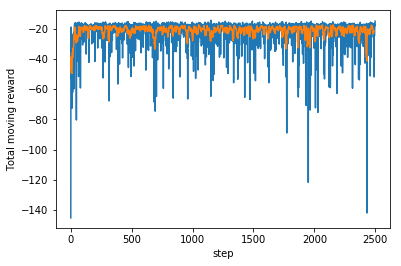

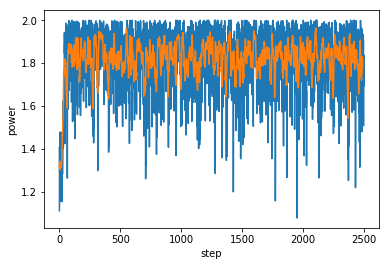

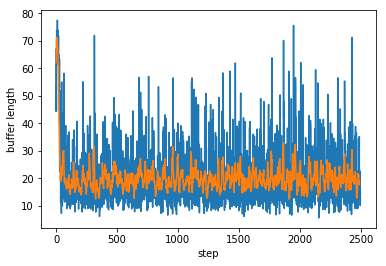

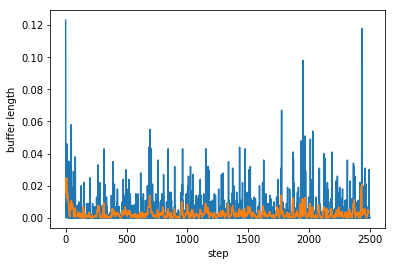

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])